In [2]:
# core 3rd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ours: data
from vizard.data import functional
from vizard.data import constant
from vizard.data import logic
from vizard.data import preprocessor
# ours: utils
from vizard.utils.visualization import add_percentage_axes
# ours: configs/db
from vizard.configs import CANADA_COUNTRY_CODE_TO_NAME

# MLOps
from mlflow.tracking import MlflowClient
import mlflow
import dvc.api

# utils
from IPython.display import display
from typing import Any
import logging
import shutil
import sys
import os

## Reproducibility


### Setup DVC experiment and configs

In [3]:
# main path
SRC_DIR = '/mnt/e/dataset/processed/all/'  # path to source encrypted pdf
DST_DIR = 'raw-dataset/all/'  # path to decrypted pdf

# DVC: main dataset
PATH = DST_DIR[:-1] + '.pkl'  # path to source data, e.g. data.pkl file
REPO = '/home/nik/visaland-visa-form-utility'
VERSION = 'v1.0.3'  # use latest using `git tag`

# DVC: helper - (for more info see the API that uses these files)
# data file for converting country names to continuous score in "economical" sense
HELPER_PATH_GDP = 'raw-dataset/API_NY.GDP.PCAP.CD_DS2_en_xml_v2_4004943.pkl'
HELPER_VERSION_GDP = 'v0.1.0-field-GDP'  # use latest using `git tag`
# data file for converting country names to continuous score in "all" possible senses
HELPER_PATH_OVERALL = 'raw-dataset/databank-2015-2019.pkl'
HELPER_VERSION_OVERALL = 'v0.1.0-field'  # use latest using `git tag`
# gather these for MLFlow track
all_helper_data_info = {
    HELPER_PATH_GDP: HELPER_VERSION_GDP,
    HELPER_PATH_OVERALL: HELPER_VERSION_OVERALL,
}

### Configure Logging

In [4]:
#py>
#logger = logging.getLogger(__name__)  # subset of `vizard_ipynb` logger
## override display to log using logger
#display = logger.info
## if the script is run directly, log to console instead of inheriting module level log
#if __name__ == '__main__':
#    logger_handler = logging.StreamHandler(sys.stderr)
#    logger.addHandler(logger_handler)
#    logger.setLevel(logging.INFO)

In [5]:
#nb>
VERBOSITY = logging.INFO
logger = logging.getLogger(__name__)
logger.setLevel(VERBOSITY)

# Set up root logger, and add a file handler to root logger
if not os.path.exists(REPO + '/artifacts'):
    os.makedirs(REPO + '/artifacts')
    os.makedirs(REPO + '/artifacts/logs')
    os.makedirs(REPO + '/artifacts/notebooks')

logger_handler = logging.FileHandler(filename=REPO + '/artifacts/logs/nb.log', mode='w')
logger.addHandler(logger_handler)

In [6]:
SEED = 322
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

In [7]:
#nb>
logger.info('SEED={}'.format(SEED))

## Loading Data


### Setup MLFlow

In [8]:
#nb>
# NBVAL_IGNORE_OUTPUT
# log experiment configs
MLFLOW_EXPERIMENT_NAME = 'minimalist feature engineering'
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
MLFLOW_TAGS = {
    'stage': 'dev'  # dev, beta, production
}
mlflow.set_tags(MLFLOW_TAGS)
client = MlflowClient()

logger.info('MLFlow experiment name: {}'.format(MLFLOW_EXPERIMENT_NAME))
logger.info('MLFlow experiment id: {}'.format(mlflow.active_run().info.run_id))
logger.info('DVC data version: {}'.format(VERSION))
logger.info('DVC repo (root): {}'.format(REPO))
logger.info('DVC data source path: {}'.format(PATH))

### Set global options for the notebook

In [9]:
#nb>
# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# matplotlib
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
import mplcyberpunk
plt.style.use('cyberpunk')
%matplotlib inline

### Import data from DVC storage

In [10]:
# get url data from DVC data storage
data_url = dvc.api.get_url(path=PATH, repo=REPO, rev=VERSION)
# read dataset from remote (local) data storage
data = pd.read_pickle(data_url)

### Global Data Preprocessing Functions

In [11]:
canada_logic = logic.CanadaLogics()
# just to make sure mypy does not complain after `vizard_ipynb.nb2py.py conversion`
feature_name: Any = ''

### Getting to know the data

In [12]:
#nb>
display(data.sample(5, random_state=SEED))

P1.AdultFlag  P1.PD.ServiceIn.ServiceIn P1.PD.VisaType.VisaType  \
132         True                        1.0             VisitorVisa   
200         True                        1.0             VisitorVisa   
135         True                        1.0             VisitorVisa   
235         True                        1.0             VisitorVisa   
67          True                        1.0             VisitorVisa   

    P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
132                                              False             Male   
200                                              False             Male   
135                                              False             Male   
235                                              False             Male   
67                                               False             Male   

    P1.PD.PlaceBirthCity P1.PD.PlaceBirthCountry  \
132               TEHRAN                    IRAN   
200               TEHRAN                    IRAN   
135                AHVAZ                    IRAN   
235               TEHRAN                    IRAN   
67                GHESHM                    IRAN   

    P1.PD.Citizenship.Citizenship P1.PD.CurrCOR.Row2.Country  \
132                          IRAN                       IRAN   
200                          IRAN                       IRAN   
135                          IRAN                       IRAN   
235                          IRAN                       IRAN   
67                           IRAN                       IRAN   

     P1.PD.CurrCOR.Row2.Status P1.PD.CurrCOR.Row2.Other P1.PD.PCRIndicator  \
132                        1.0                    False              False   
200                        1.0                    False              False   
135                        1.0                    False              False   
235                        1.0                    False              False   
67                         1.0                    False              False   

    P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row2.Status  \
132                      OTHER                        6.0   
200                      OTHER                        6.0   
135                      OTHER                        6.0   
235                      OTHER                        6.0   
67                       OTHER                        6.0   

    P1.PD.PrevCOR.Row3.Country  P1.PD.PrevCOR.Row3.Status  \
132                      OTHER                        6.0   
200                      OTHER                        6.0   
135                      OTHER                        6.0   
235                      OTHER                        6.0   
67                       OTHER                        6.0   

    P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status  \
132                    False                 TURKEY                    6.0   
200                    False                 TURKEY                    3.0   
135                    False                 TURKEY                    6.0   
235                    False                    242                    3.0   
67                     False                 TURKEY                    3.0   

    P1.PD.CWA.Row2.Other P1.MS.SecA.MS P2.MS.SecA.PrevMarrIndicator  \
132                 True            01                        False   
200                False            01                        False   
135                 True            02                        False   
235                False            04                         True   
67                 False            01                        False   

    P2.MS.SecA.TypeOfRelationship  \
132                         OTHER   
200                         OTHER   
135                         OTHER   
235                            01   
67                          OTHER   

    P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
132                                           IRAN  

In [13]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [14]:
#nb>
display(data.isnull().sum()[data.isnull().sum() != 0])  # checking for total null values

P1.AdultFlag                                              3
P1.PD.ServiceIn.ServiceIn                                 3
P1.PD.VisaType.VisaType                                   3
P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator     3
P1.PD.Sex.Sex                                             3
                                                         ..
p1.SecC.Chd.[2].ChdDOB.Period                            26
p1.SecC.Chd.[3].ChdDOB.Period                            26
p1.SecC.Chd.[4].ChdDOB.Period                            26
p1.SecC.Chd.[5].ChdDOB.Period                            26
p1.SecC.Chd.[6].ChdDOB.Period                            26
Length: 169, dtype: int64

it seems we have 4 rows with no information (empty forms) but the flag exists. There is nothing we can do except deleting them.

In [15]:
#nb>
feature_name = 'P1.PD.VisaType.VisaType'
data[data[feature_name].isna()]

P1.AdultFlag  P1.PD.ServiceIn.ServiceIn P1.PD.VisaType.VisaType  \
10          NaN                        NaN                     NaN   
94          NaN                        NaN                     NaN   
96          NaN                        NaN                     NaN   

   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
10                                                NaN              NaN   
94                                                NaN              NaN   
96                                                NaN              NaN   

   P1.PD.PlaceBirthCity P1.PD.PlaceBirthCountry P1.PD.Citizenship.Citizenship  \
10                  NaN                     NaN                           NaN   
94                  NaN                     NaN                           NaN   
96                  NaN                     NaN                           NaN   

   P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
10                        NaN                        NaN   
94                        NaN                        NaN   
96                        NaN                        NaN   

   P1.PD.CurrCOR.Row2.Other P1.PD.PCRIndicator P1.PD.PrevCOR.Row2.Country  \
10                      NaN                NaN                        NaN   
94                      NaN                NaN                        NaN   
96                      NaN                NaN                        NaN   

    P1.PD.PrevCOR.Row2.Status P1.PD.PrevCOR.Row3.Country  \
10                        NaN                        NaN   
94                        NaN                        NaN   
96                        NaN                        NaN   

    P1.PD.PrevCOR.Row3.Status P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  \
10                        NaN                      NaN                    NaN   
94                        NaN                      NaN                    NaN   
96                        NaN                      NaN                    NaN   

    P1.PD.CWA.Row2.Status P1.PD.CWA.Row2.Other P1.MS.SecA.MS  \
10                    NaN                  NaN           NaN   
94                    NaN                  NaN           NaN   
96                    NaN                  NaN           NaN   

   P2.MS.SecA.PrevMarrIndicator P2.MS.SecA.TypeOfRelationship  \
10                          NaN                           NaN   
94                          NaN                           NaN   
96                          NaN                           NaN   

   P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
10                                            NaN   
94                                            NaN   
96                                            NaN   

   P2.MS.SecA.Langs.languages.nativeLang.nativeLang  \
10                                              NaN   
94                                              NaN   
96                                              NaN   

   P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  \
10                                                NaN               
94                                                NaN               
96                                                NaN               

   P2.MS.SecA.Langs.LangTest P2.natID.q1.natIDIndicator  \
10                       NaN                        NaN   
94                       NaN                        NaN   
96                       NaN                        NaN   

   P2.natID.natIDdocs.CountryofIssue.CountryofIssue  \
10                                              NaN   
94                                              NaN   
96                                              NaN   

   P2.USCard.q1.usCardIndicator P2.CI.cntct.PhnNums.Phn.CanadaUS  \
10                          NaN                              NaN   
94                          NaN                              NaN   
96                          NaN                              NaN   

   P2.CI.cntct.PhnNums.A

In [16]:
feature_name = 'P1.PD.VisaType.VisaType'
data = data.drop(data[data[feature_name].isna()].index)
display(data.isnull().sum()[data.isnull().sum() != 0])

P3.Edu.Edu_Row1.FieldOfStudy      97
p1.SecA.App.AppAddr                2
p1.SecA.Sps.SpsCOB                70
p1.SecA.Sps.SpsAddr               68
p1.SecA.Mo.MoCOB                   8
p1.SecA.Mo.MoAddr                  5
p1.SecA.Fa.FaCOB                   8
p1.SecA.Fa.FaAddr                  9
p1.SecB.Chd.[0].ChdAddr          108
p1.SecB.Chd.[1].ChdAddr          184
p1.SecB.Chd.[2].ChdAddr          267
p1.SecB.Chd.[3].ChdAddr          285
p1.SecC.Chd.[0].ChdAddr           18
p1.SecC.Chd.[1].ChdAddr           74
p1.SecC.Chd.[2].ChdAddr          130
p1.SecC.Chd.[3].ChdAddr          181
p1.SecC.Chd.[4].ChdAddr          222
p1.SecC.Chd.[5].ChdAddr          255
p1.SecC.Chd.[6].ChdAddr          273
p1.SecB.Chd.[0].ChdDOB.Period      5
p1.SecB.Chd.[1].ChdDOB.Period      3
p1.SecC.Chd.[0].ChdDOB.Period     23
p1.SecC.Chd.[1].ChdDOB.Period     23
p1.SecC.Chd.[2].ChdDOB.Period     23
p1.SecC.Chd.[3].ChdDOB.Period     23
p1.SecC.Chd.[4].ChdDOB.Period     23
p1.SecC.Chd.[5].ChdDOB.Period     23
p

We can see the only three type of data are missing:
1. COB: country of birth
2. Period: age of sibling and kids (probably because the person does not have any kid or sibling to fill)
3. Address: Address of applicants, their spouses, parents, children, and siblings. Although full address is available, only city matters.

| Feature | Fill | Desc |
| --- | --- | --- |
| COB | str: same as applicant's COB for ghost spouse | If all SpsCOB are the same, just drop the entire column, so no differentiation between ghost spouse or missed one.  
| Period | int: 0 | prob only ghost cases, otherwise, should be filled statistically 
| Address | str: city name | If None (for both ghost case and missing info), skip it (None). Since the value itself is not important and we prefer the difference of applicant's value from their family (to count long distance cases), we can only focus on filled values that are different from applicant's.

In [17]:
feature_name = [c for c in data.columns.values if 'Sps' in c]
display(feature_name)

['p1.SecA.Sps.SpsCOB',
 'p1.SecA.Sps.SpsAddr',
 'p1.SecA.Sps.SpsOcc',
 'p1.SecA.Sps.SpsAccomp',
 'p1.SecA.Sps.SpsDOB.Period']

In [18]:
#nb>
data[data[feature_name[0]].isna()][feature_name]

p1.SecA.Sps.SpsCOB                p1.SecA.Sps.SpsAddr p1.SecA.Sps.SpsOcc  \
8                 None                               None              OTHER   
15                None                               None              OTHER   
25                None                               None              OTHER   
27                None  BESAT BLVD-JANAT ABAD-TEHRAN-IRAN          HOUSEWIFE   
29                None  BESAT BLVD-JANAT ABAD-TEHRAN-IRAN          HOUSEWIFE   
..                 ...                                ...                ...   
288               None                               None              OTHER   
290               None                               None              OTHER   
291               None                               None              OTHER   
294               None                               None              OTHER   
300               None                               None              OTHER   

    p1.SecA.Sps.SpsAccomp  p1.SecA.Sps.SpsDOB.Period  
8                   False                        0.0  
15                  False                        0.0  
25                  False                        0.0  
27                   True                    10368.0  
29                   True                    10368.0  
..                    ...                        ...  
288                 False                        0.0  
290                 False                        0.0  
291                 False                        0.0  
294                 False                        0.0  
300                 False                        0.0  

[70 rows x 5 columns]

In [19]:
#nb>
display(data[data[feature_name[0]].isna()][feature_name].__len__())
display(data[(data[feature_name[2]] == 'OTHER') & (data[feature_name[0]].isna())][feature_name].__len__())

70

67

There are 70-67 cases where the person has job title but no COB, which means that only 3 cases are not ghost cases and we can fill their COB using their spouse's COB.
For all other cases (ghosts), we just use the dominant case, IRAN. 

In [20]:
# fill ghost cases' COB with 'IRAN'
data.loc[(data[feature_name[2]] == 'OTHER') & (data[feature_name[0]].isna()), [feature_name[0]]] = 'IRAN'

In [21]:
#nb>
display(data[data[feature_name[0]].isna()][feature_name].__len__())
display(data[(data[feature_name[2]] == 'OTHER') & (data[feature_name[0]].isna())][feature_name].__len__())

3

0

In [22]:
# fill non-filled spouse COB cases' with their spouses' COB
data.loc[data[feature_name[0]].isna(), [feature_name[0]]] = data['P1.PD.PlaceBirthCountry']

In [23]:
#nb>
display(data[data[feature_name[0]].isna()][feature_name].__len__())
display(data[(data[feature_name[2]] == 'OTHER') & (data[feature_name[0]].isna())][feature_name].__len__())

0

0

## Analyzing the features

### Ground truth

In [24]:
output_name = 'VisaResult'
data.loc[data[output_name] == 1, [output_name]] = 'acc'  # 1 -> accepted
data.loc[data[output_name] == 2, [output_name]] = 'rej'  # 2 -> rejected
data.loc[data[output_name] == 3, [output_name]] = 'w-acc'  # 3 -> allegedly accepted
data.loc[data[output_name] == 4, [output_name]] = 'w-rej'  # 4 -> allegedly rejected
data.loc[data[output_name] == 5, [output_name]] = 'no idea'  # 5 -> no idea
output_hue_order = ['acc', 'rej', 'w-rej', 'w-acc', 'no idea']

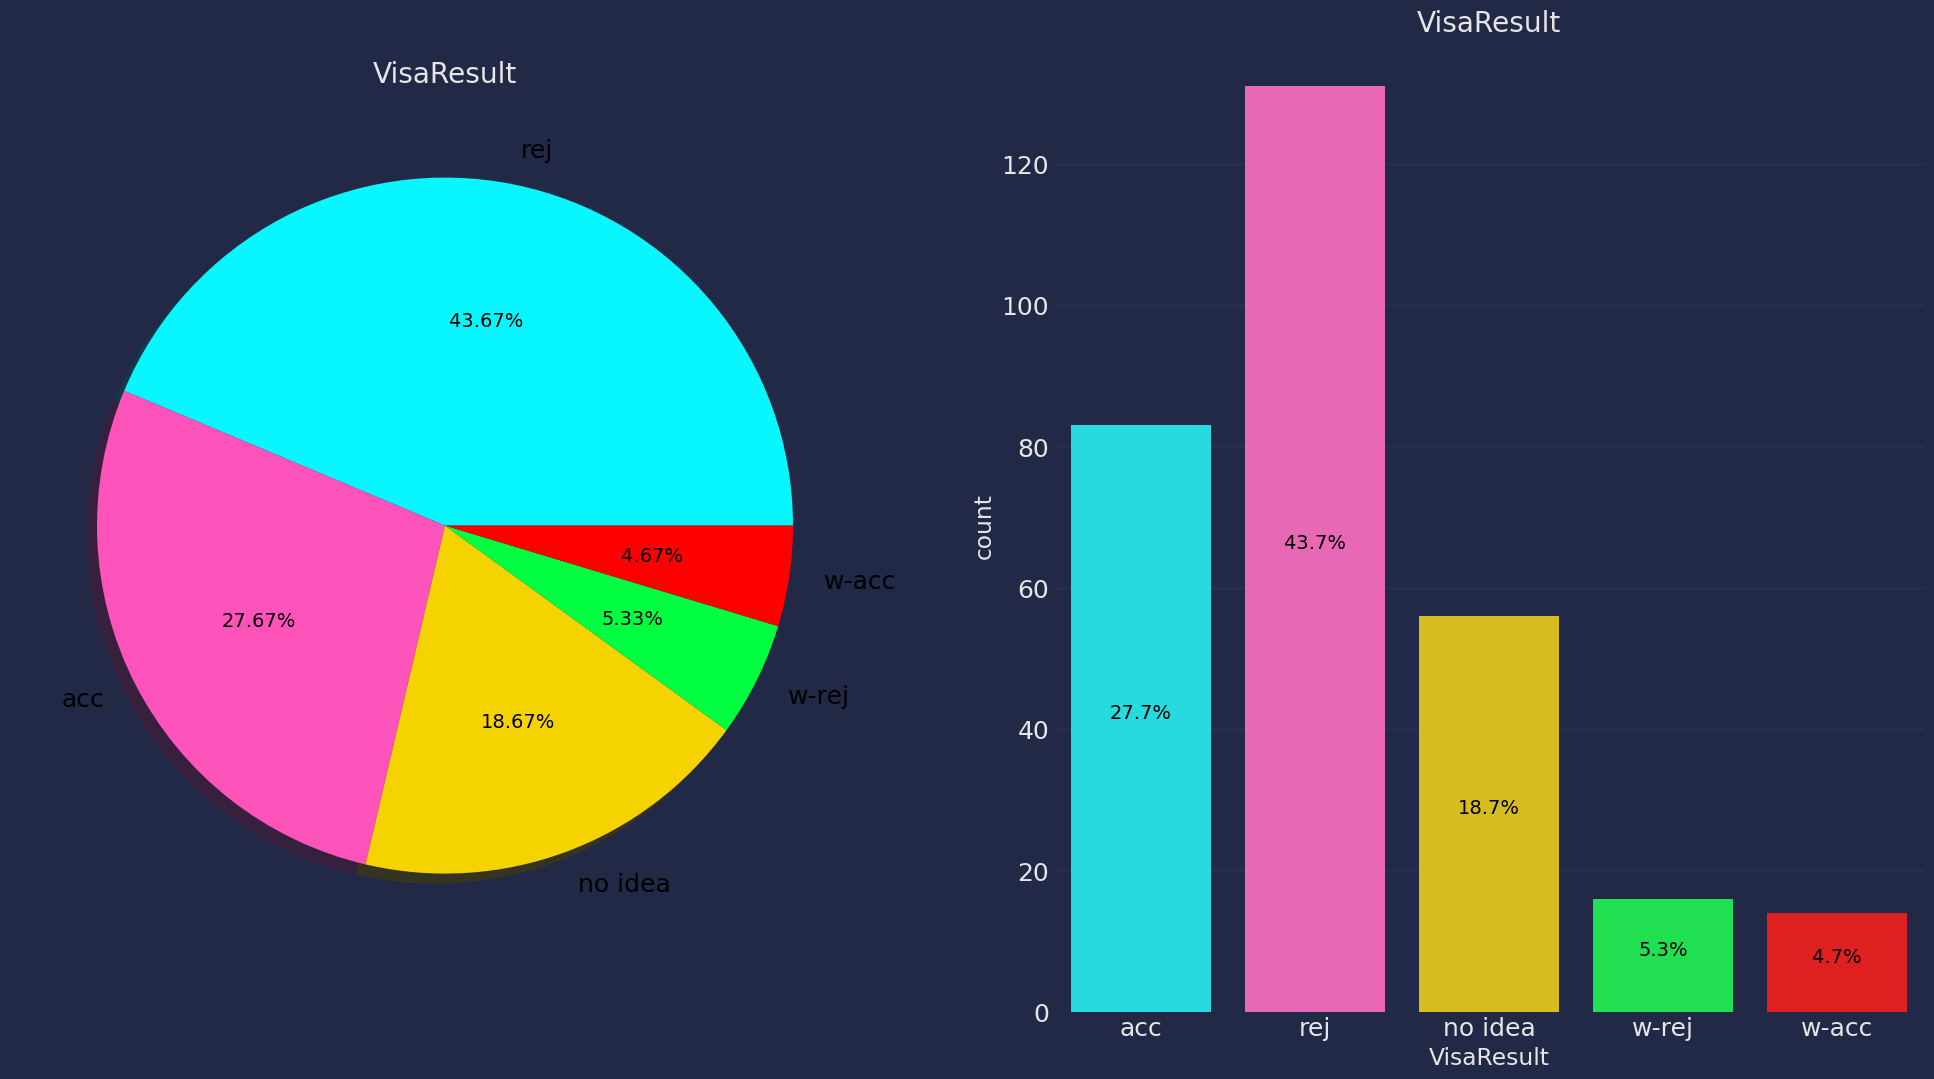

In [25]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color': 'black'})
ax[0].set_title(output_name)
ax[0].set_ylabel('')
sns.countplot(x=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title(output_name)
plt.show()

We don't have the labels for %18 of our data, but we have weak labels for around %10. In this way, we can revive 80% of labels by doing weak supervised learning. Check [Snorkel](https://www.snorkel.org/get-started/) for more information. 

### P1.AdultFlag -> categorical

In [26]:
feature_name = 'P1.AdultFlag'
output_name = 'VisaResult'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.AdultFlag  VisaResult
False         acc             1
              rej             1
True          acc            82
              no idea        56
              rej           130
              w-acc          14
              w-rej          16
Name: VisaResult, dtype: int64

In [27]:
data[data[feature_name] == False]

P1.AdultFlag  P1.PD.ServiceIn.ServiceIn P1.PD.VisaType.VisaType  \
15        False                        1.0             VisitorVisa   
92        False                        1.0             VisitorVisa   

   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
15                                              False             Male   
92                                              False             Male   

   P1.PD.PlaceBirthCity P1.PD.PlaceBirthCountry P1.PD.Citizenship.Citizenship  \
15               TEHRAN                    IRAN                          IRAN   
92                KARAJ                    IRAN                          IRAN   

   P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
15                       IRAN                        1.0   
92                       IRAN                        1.0   

   P1.PD.CurrCOR.Row2.Other P1.PD.PCRIndicator P1.PD.PrevCOR.Row2.Country  \
15                    False              False                      OTHER   
92                    False              False                      OTHER   

    P1.PD.PrevCOR.Row2.Status P1.PD.PrevCOR.Row3.Country  \
15                        6.0                      OTHER   
92                        6.0                      OTHER   

    P1.PD.PrevCOR.Row3.Status P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  \
15                        6.0                    False                 TURKEY   
92                        6.0                    False                 TURKEY   

    P1.PD.CWA.Row2.Status P1.PD.CWA.Row2.Other P1.MS.SecA.MS  \
15                    3.0                False            02   
92                    3.0                False            02   

   P2.MS.SecA.PrevMarrIndicator P2.MS.SecA.TypeOfRelationship  \
15                        False                         OTHER   
92                        False                         OTHER   

   P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
15                                           IRAN   
92                                           IRAN   

   P2.MS.SecA.Langs.languages.nativeLang.nativeLang  \
15                                             IRAN   
92                                             IRAN   

   P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  \
15                                            English               
92                                            English               

   P2.MS.SecA.Langs.LangTest P2.natID.q1.natIDIndicator  \
15                     False                       True   
92                     False                       True   

   P2.natID.natIDdocs.CountryofIssue.CountryofIssue  \
15                                             IRAN   
92                                             IRAN   

   P2.USCard.q1.usCardIndicator P2.CI.cntct.PhnNums.Phn.CanadaUS  \
15                        False                            False   
92                        False                            False   

   P2.CI.cntct.PhnNums.AltPhn.CanadaUS  \
15                               False   
92                               False   

    P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit P3.DOV.PrpsRow1.Other.Other  \
15                                      2.0                       False   
92                                      2.0                       False   

    P3.DOV.PrpsRow1.Funds.Funds  \
15                       5000.0   
92                       8000.0   

   P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
15                                              OTHER     
92                                              HOTEL     

   P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
15                                        OTHER               False   
92                                        OTHER               False   

   P3.Edu.Edu_Row1.FieldOfStudy P3.Edu.Edu_Row1.Country.Country  \
15                         <NA>                            IRAN   
92                         <NA

Ok, useless kids, dropping all of them, and hence, the entire `P1.AdultFlag` flag

In [28]:
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [29]:
output_name = 'VisaResult'
feature_name = 'P1.PD.ServiceIn.ServiceIn' 
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.ServiceIn.ServiceIn  VisaResult
1.0                        acc            83
                           no idea        56
                           rej           131
                           w-acc          14
                           w-rej          16
Name: VisaResult, dtype: int64

In [30]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.ServiceIn.ServiceIn -> categorical

In [31]:
output_name = 'VisaResult'
feature_name = 'P1.PD.VisaType.VisaType' 
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.VisaType.VisaType  VisaResult
VisitorVisa              acc            83
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [32]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator -> categorical

In [33]:
output_name = 'VisaResult'
feature_name = 'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  VisaResult
False                                                  acc            76
                                                       no idea        54
                                                       rej           118
                                                       w-acc          12
                                                       w-rej          16
True                                                   acc             7
                                                       no idea         2
                                                       rej            13
                                                       w-acc           2
Name: VisaResult, dtype: int64

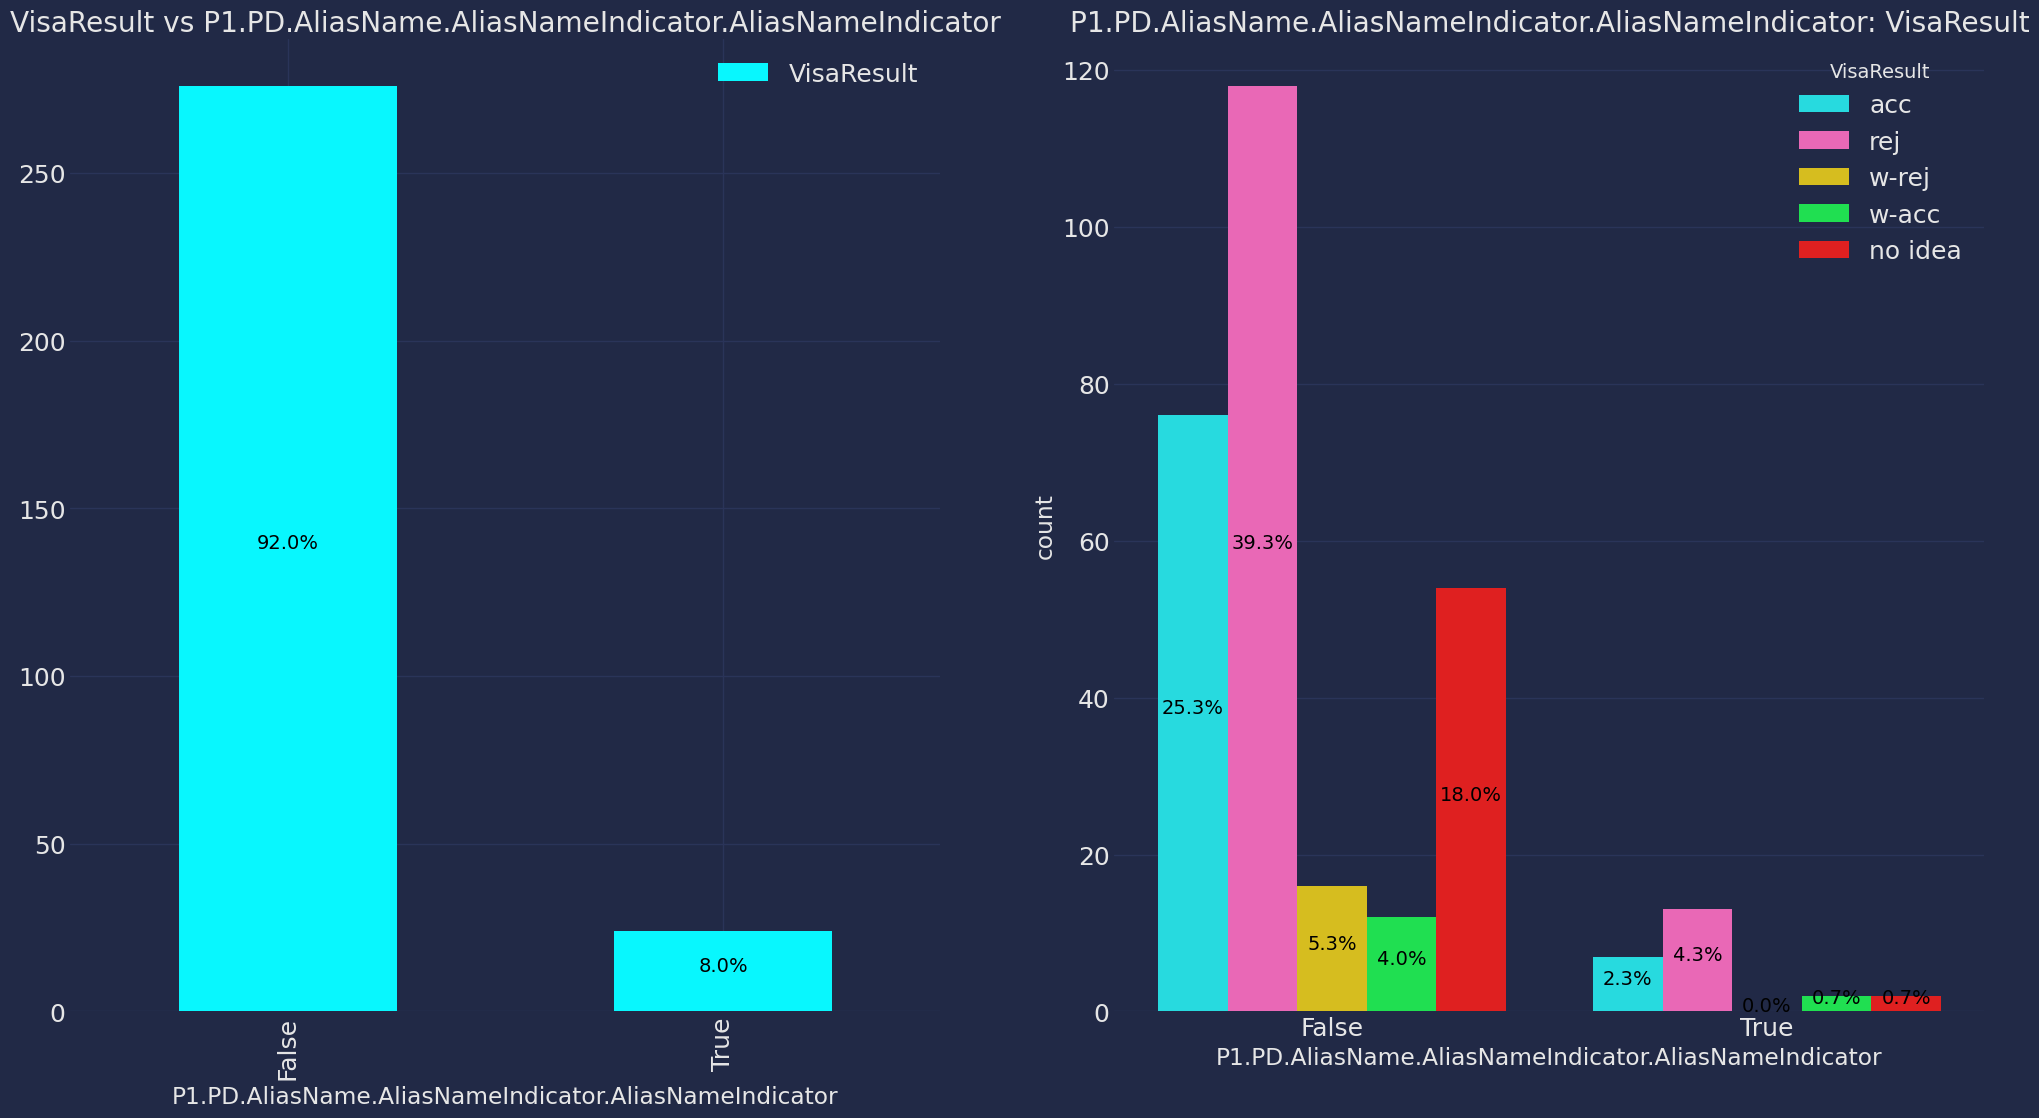

In [34]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

TODO: They seem proportional, for now, we skip it, but if after modeling, we didn't find any improvement by including this feature, we must remove it.
DONE: removed it

In [35]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.Sex.Sex -> categorical

In [36]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Sex.Sex', 'P1.MS.SecA.MS'
display(data.groupby([feature_name[0], output_name])[output_name].count())

P1.PD.Sex.Sex  VisaResult
Female         acc           47
               no idea       28
               rej           60
               w-acc          6
               w-rej          9
Male           acc           36
               no idea       28
               rej           71
               w-acc          8
               w-rej          7
Name: VisaResult, dtype: int64

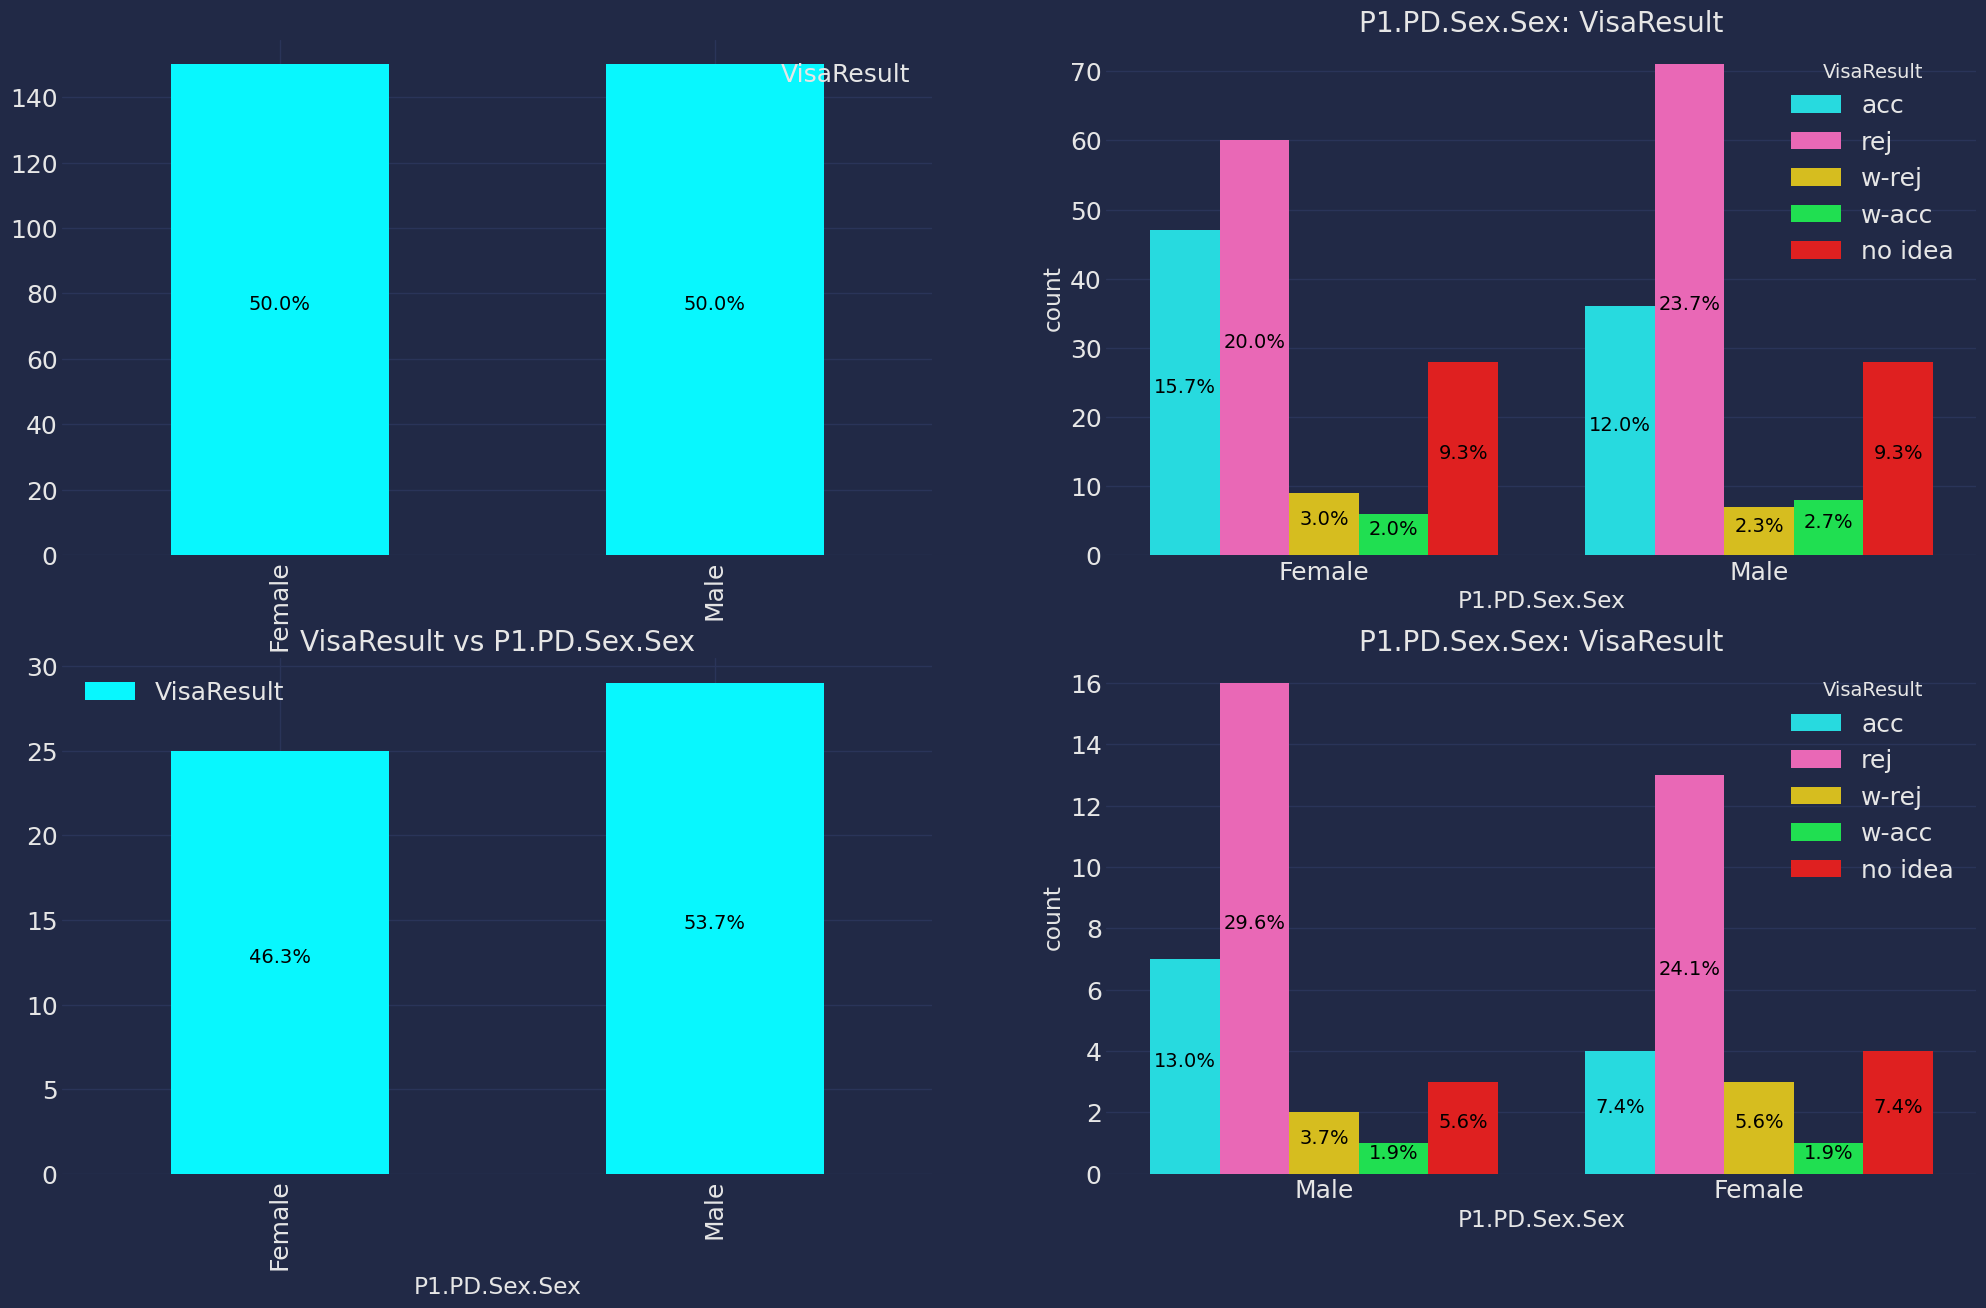

In [37]:
#nb>
f, ax = plt.subplots(2, 2, figsize=(22, 14))
data[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[0, 0])
add_percentage_axes(ax[0, 0], len(data))
ax[0, 1].set_title('{} vs {}'.format(output_name, feature_name[0]))
sns.countplot(x=feature_name[0], hue=output_name, data=data,
    ax=ax[0, 1], hue_order=output_hue_order)
add_percentage_axes(ax[0, 1], len(data))
ax[0, 1].set_title('{}: {}'.format(feature_name[0], output_name))

z = data[data[feature_name[1]] == '02']  # singles data ('02' == single)
z[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[1, 0])
add_percentage_axes(ax[1, 0], len(z))
ax[1, 0].set_title('{} vs {}'.format(output_name, feature_name[0]))
sns.countplot(x=feature_name[0], hue=output_name, data=z,
    ax=ax[1, 1], hue_order=output_hue_order)
add_percentage_axes(ax[1, 1], len(z))
ax[1, 1].set_title('{}: {}'.format(feature_name[0], output_name))

plt.show()

Insights: 
1. It seems that women are getting more visas than man, even though the number of applicants in term of gender are almost equal.
2. A closer looks shows that in **singles**, men are doing better.

### P1.PD.PlaceBirthCity -> categorical

In [38]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCity'

In [39]:
#nb>
# NBVAL_IGNORE_OUTPUT
pd.crosstab(data[feature_name], data[output_name],
            margins=True).style.background_gradient(cmap='summer_r')

The data fro other cities except Tehran, Karaj and Shiraz is too small to matter. At the end of the day, the value of land is summarized into assets, so no point in this, hence deleted.

In [40]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.PlaceBirthCountry -> categorical

In [41]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PlaceBirthCountry'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.PlaceBirthCountry  VisaResult
059                      rej             1
226                      no idea         1
IRAN                     acc            83
                         no idea        55
                         rej           130
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

Well, all are from damned Iran, so let's drop it.

In [42]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.Citizenship.Citizenship -> categorical

In [43]:
output_name = 'VisaResult'
feature_name = 'P1.PD.Citizenship.Citizenship'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.Citizenship.Citizenship  VisaResult
IRAN                           acc            83
                               no idea        56
                               rej           129
                               w-acc          14
                               w-rej          16
TURKEY                         rej             2
Name: VisaResult, dtype: int64

In [44]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Country -> categorical

In [45]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.CurrCOR.Row2.Country  VisaResult
280                         acc             1
511                         acc             1
IRAN                        acc            81
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

511 is Canada and someone who has residency of Canada absolutely needs to be excluded as an anomaly.

In [46]:
data.drop(data[data[feature_name] == '511'].index, inplace=True)

In [47]:
config_path = CANADA_COUNTRY_CODE_TO_NAME

data[feature_name] = data[feature_name].apply(func=functional.extended_dict_get, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', str.isnumeric, ))

In [48]:
tmp_df = pd.read_pickle(dvc.api.get_url(path=HELPER_PATH_GDP, repo=REPO, rev=HELPER_VERSION_GDP))
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [49]:
display(data[feature_name].unique())

array([1.10715442, 2.33984284])

It is hard to say that how having different country of residence than IRAN effects the output variable. So know more about it, especially if it is **anomaly** or not, we currently skip it and after having a clean data, we use visualization, statistical or ML methods to figure this out. [See this for more information](https://www.analyticsvidhya.com/blog/2021/04/dealing-with-anomalies-in-the-data/)

We can also make this into categorical, [`IRAN`, `OTHER`] and simplify things, but if it's anomaly, I prefer fixing it.

TODO: last priority but mandatory

In [50]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Status -> delete

In [51]:
feature_name = 'P1.PD.CurrCOR.Row2.Status'
# drop useless
data.drop(feature_name, axis=1, inplace=True)

Similar as [P1.PD.CurrCOR.Row2.Country](#P1.PD.CurrCOR.Row2.Country)

### P1.PD.CurrCOR.Row2.Other -> del

In [52]:
# drop useless
feature_name = 'P1.PD.CurrCOR.Row2.Other'
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Period -> del

In [55]:
# drop useless
feature_name = 'P1.PD.CurrCOR.Row2.Period'
data.drop(feature_name, axis=1, inplace=True)

In [56]:
#nb>
display(data.sample(5, random_state=SEED))

P1.PD.Sex.Sex P1.PD.PCRIndicator P1.PD.PrevCOR.Row2.Country  \
145        Female              False                      OTHER   
234          Male              False                      OTHER   
287          Male              False                      OTHER   
196          Male              False                      OTHER   
68         Female              False                      OTHER   

     P1.PD.PrevCOR.Row2.Status P1.PD.PrevCOR.Row3.Country  \
145                        6.0                      OTHER   
234                        6.0                      OTHER   
287                        6.0                      OTHER   
196                        6.0                      OTHER   
68                         6.0                      OTHER   

     P1.PD.PrevCOR.Row3.Status P1.PD.SameAsCORIndicator  \
145                        6.0                    False   
234                        6.0                    False   
287                        6.0                    False   
196                        6.0                    False   
68                         6.0                    False   

    P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status P1.PD.CWA.Row2.Other  \
145                 TURKEY                    3.0                False   
234                 TURKEY                    6.0                 True   
287                 TURKEY                    3.0                False   
196                    049                    3.0                False   
68                  TURKEY                    3.0                False   

    P1.MS.SecA.MS P2.MS.SecA.PrevMarrIndicator P2.MS.SecA.TypeOfRelationship  \
145            02                        False                         OTHER   
234            01                         True                            01   
287            02                        False                         OTHER   
196            02                        False                         OTHER   
68             02                        False                         OTHER   

    P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
145                                           IRAN   
234                                           IRAN   
287                                           IRAN   
196                                           IRAN   
68                                            IRAN   

    P2.MS.SecA.Langs.languages.nativeLang.nativeLang  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  \
145                                            English               
234                                            English               
287                                            English               
196                                            English               
68                                             English               

    P2.MS.SecA.Langs.LangTest P2.natID.q1.natIDIndicator  \
145                     False                       True   
234                     False                       True   
287                     False                       True   
196                     False                       True   
68                      False                       True   

    P2.natID.natIDdocs.CountryofIssue.CountryofIssue  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.USCard.q1.usCardIndicator P2.CI.cntct.PhnNums.Phn.CanadaUS  \
145                        False                            False   
234                        False  

### P1.PD.PCRIndicator -> categorical

In [57]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PCRIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.PCRIndicator  VisaResult
False               acc            76
                    no idea        56
                    rej           128
                    w-acc          14
                    w-rej          12
True                acc             6
                    rej             3
                    w-rej           4
Name: VisaResult, dtype: int64

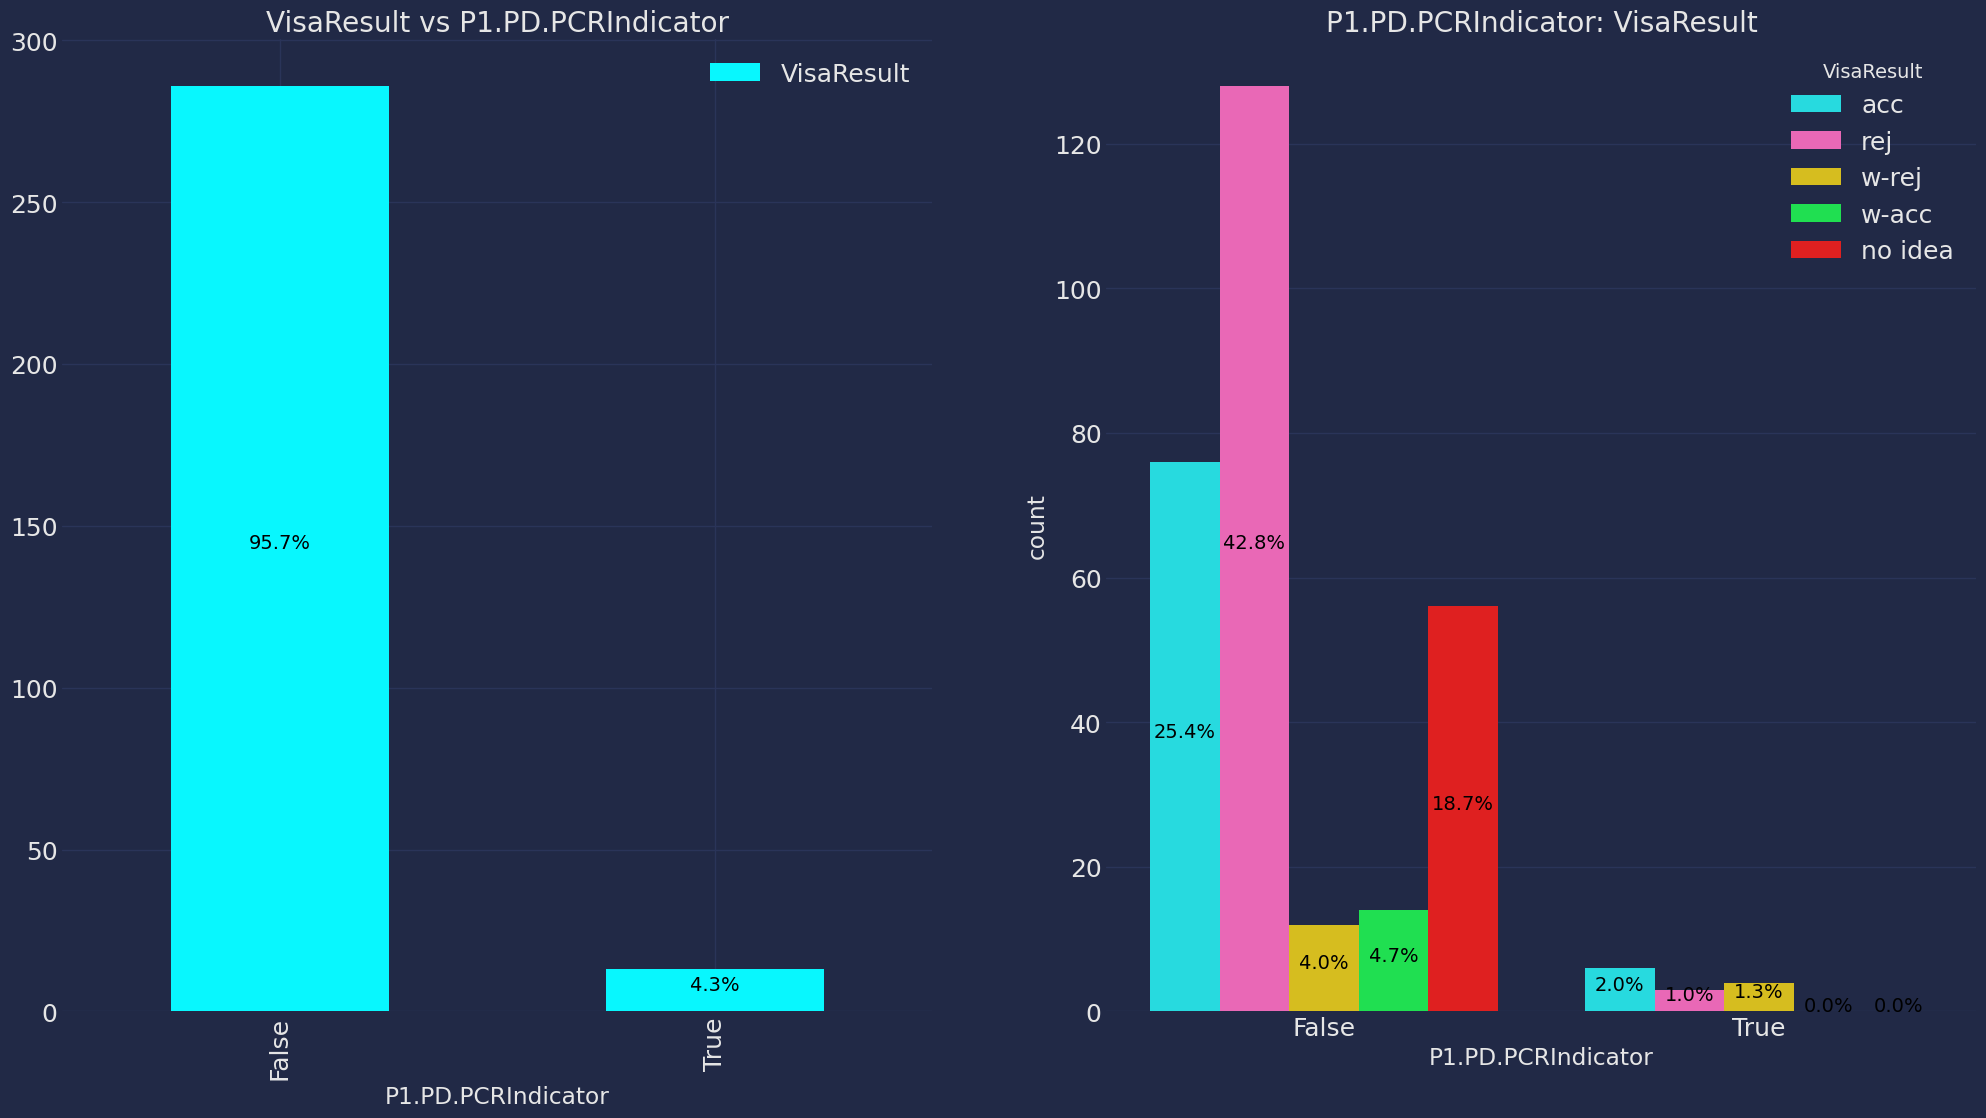

In [58]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data, ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

It is hard to say, but having previous country of residence has higher acceptance rate than none ones. Well, this is maybe the case, because they showed that they have resided in third-party countries and went back to their home country.

### P1.PD.PrevCOR.Row[i].\* -> categorical

In [59]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

Ok, we have good amount of examples that cannot be ignored or labeled as anomaly.

The main issue here is that the countries are so diverse that cannot be considered. To fix this, we consider label feature `P1.PD.PCRIndicator` which is a binary variable indicating if the candidate has had previous country of residence or not. The below cell confirms this, so we drop this column and second row of the same info, i.e. `P1.PD.PrevCOR.Row2.Country`, `P1.PD.PrevCOR.Row2.Status`, `P1.PD.PrevCOR.Row3.Country`, `P1.PD.PrevCOR.Row3.Status`.

All these columns can be integrated into another column, aggregating all of these into sum of non-`OTHER` status for PrevCOR, simply put, the count of previous countries of residence. In this case, `0` means no PCR, so we can get rid of `P1.PD.PCRIndicator` too.

In [60]:
display(data[data['P1.PD.PCRIndicator'] == True].groupby([feature_name, output_name])[output_name].count())

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej         2
028                         acc           1
                            rej           2
034                         acc           1
052                         acc           2
202                         w-rej         1
224                         w-rej         1
226                         rej           1
280                         acc           1
TURKEY                      acc           1
Name: VisaResult, dtype: int64

In [61]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.PrevCOR.Row2.Country  VisaResult
016                         w-rej           2
028                         acc             1
                            rej             2
034                         acc             1
052                         acc             2
202                         w-rej           1
224                         w-rej           1
226                         rej             1
280                         acc             1
OTHER                       acc            76
                            no idea        56
                            rej           128
                            w-acc          14
                            w-rej          12
TURKEY                      acc             1
Name: VisaResult, dtype: int64

In [62]:
output_name = 'VisaResult'
display(data.groupby(['P1.PD.PrevCOR.Row2.Status', 'P1.PD.PrevCOR.Row3.Status']).size())

P1.PD.PrevCOR.Row2.Status  P1.PD.PrevCOR.Row3.Status
2.0                        6.0                            1
3.0                        3.0                            1
                           6.0                            1
4.0                        6.0                            3
5.0                        6.0                            3
6.0                        6.0                          290
dtype: int64

In [63]:
r = re.compile('P1.PD.PrevCOR.Row..Period')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])

# replace rows of previous country of residency with count of them
agg_column_name = 'P1.PD.PrevCOR.Row.Count'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(
    aggregator=canada_logic.count_previous_residency_country,
    agg_column_name=agg_column_name, columns=feature_name
)

# delete redundant columns tnx to newly created `agg_column_name='P1.PD.PrevCOR.Row.Count'`
data.drop(
    ['P1.PD.PrevCOR.Row2.Status',
     'P1.PD.PrevCOR.Row3.Status',
     'P1.PD.PCRIndicator'
    ],
    axis=1,
    inplace=True
)

In [64]:
output_name = 'VisaResult'
feature_name = 'P1.PD.PrevCOR.Row2.Period', 'P1.PD.PrevCOR.Row3.Period', 'P1.PD.PrevCOR.Row.Count'
display(data.groupby([*feature_name, output_name])[output_name].count())

P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  P1.PD.PrevCOR.Row.Count  VisaResult
0.0                        0.0                        0                        acc            76
                                                                               no idea        56
                                                                               rej           128
                                                                               w-acc          14
                                                                               w-rej          12
140.0                      0.0                        1                        w-rej           1
163.0                      0.0                        1                        rej             1
183.0                      0.0                        1                        acc             1
208.0                      0.0                        1                        acc             1
303.0                      0.0       

In [65]:
output_name = 'VisaResult'
feature_name = ['P1.PD.PrevCOR.Row2.Country', 'P1.PD.PrevCOR.Row3.Country']
data.drop(feature_name, axis=1, inplace=True)

In [66]:
#nb>
data.sample(5, random_state=SEED)

P1.PD.Sex.Sex P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  \
145        Female                    False                 TURKEY   
234          Male                    False                 TURKEY   
287          Male                    False                 TURKEY   
196          Male                    False                    049   
68         Female                    False                 TURKEY   

     P1.PD.CWA.Row2.Status P1.PD.CWA.Row2.Other P1.MS.SecA.MS  \
145                    3.0                False            02   
234                    6.0                 True            01   
287                    3.0                False            02   
196                    3.0                False            02   
68                     3.0                False            02   

    P2.MS.SecA.PrevMarrIndicator P2.MS.SecA.TypeOfRelationship  \
145                        False                         OTHER   
234                         True                            01   
287                        False                         OTHER   
196                        False                         OTHER   
68                         False                         OTHER   

    P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
145                                           IRAN   
234                                           IRAN   
287                                           IRAN   
196                                           IRAN   
68                                            IRAN   

    P2.MS.SecA.Langs.languages.nativeLang.nativeLang  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  \
145                                            English               
234                                            English               
287                                            English               
196                                            English               
68                                             English               

    P2.MS.SecA.Langs.LangTest P2.natID.q1.natIDIndicator  \
145                     False                       True   
234                     False                       True   
287                     False                       True   
196                     False                       True   
68                      False                       True   

    P2.natID.natIDdocs.CountryofIssue.CountryofIssue  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.USCard.q1.usCardIndicator P2.CI.cntct.PhnNums.Phn.CanadaUS  \
145                        False                            False   
234                        False                            False   
287                        False                            False   
196                        False                            False   
68                         False                            False   

    P2.CI.cntct.PhnNums.AltPhn.CanadaUS  \
145                               False   
234                               False   
287                               False   
196                               False   
68                                False   

     P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit P3.DOV.PrpsRow1.Other.Other  \
145                                      2.0                       False   
234                                     13.0                       False   
287                                      8.0                       False   
196                                      2

### P1.PD.SameAsCORIndicator -> categorical

In [67]:
output_name = 'VisaResult'
feature_name = 'P1.PD.SameAsCORIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.SameAsCORIndicator  VisaResult
False                     acc            75
                          no idea        56
                          rej           126
                          w-acc          14
                          w-rej          13
True                      acc             7
                          rej             5
                          w-rej           3
Name: VisaResult, dtype: int64

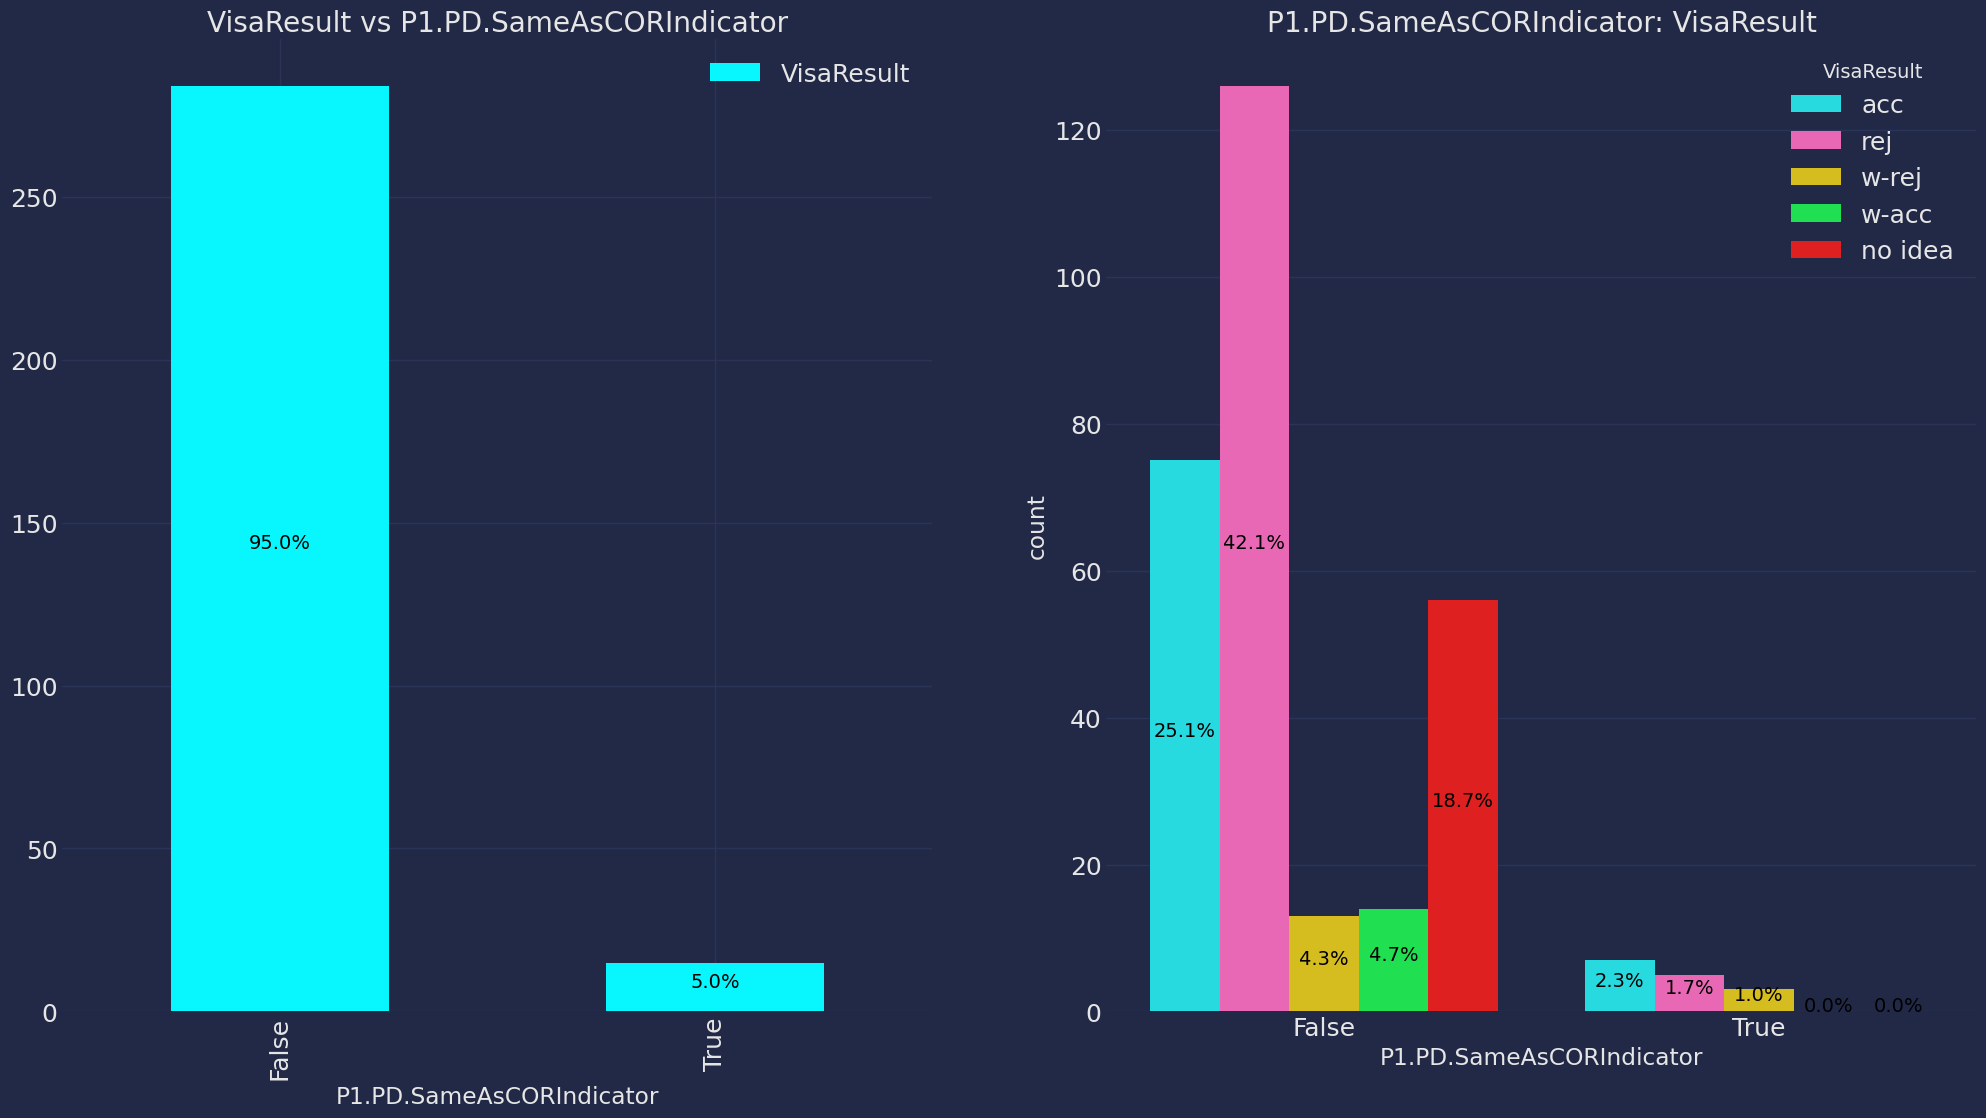

In [68]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()


It seems that having residency of other countries improves the chance of getting the visa. Seems like that the person had a choice to be the citizen of any country (by being refugee of course) but legally has chosen another country than the visiting country (here Canada). I.e. the person has no intention to go back to Iran, but no intention to stay in Canada too, a third-party country is taking care of it!

Seems useless nonetheless, so I get rid of it too.

In [69]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CWA.Row2.Country -> categorical

In [70]:
output_name = 'VisaResult'
feature_name = ['P1.PD.CWA.Row2.Country', 'P1.PD.PrevCOR.Row.Count']
display(data.groupby([*feature_name, output_name])[output_name].count())

P1.PD.CWA.Row2.Country  P1.PD.PrevCOR.Row.Count  VisaResult
022                     0                        rej             2
049                     0                        w-acc           1
052                     0                        acc             2
                                                 rej             3
                        1                        acc             1
059                     0                        rej             1
224                     0                        rej             3
242                     0                        no idea         1
263                     0                        rej             1
280                     0                        rej             4
IRAN                    0                        acc             1
                                                 rej             2
                                                 w-rej           2
OTHER                   0                        acc             6
  

In [71]:
# convert numbers to countries and transform them into categories that are more frequent
number_to_country = {
    '049': 'Armenia',
    '052': 'Georgia',
    '280': 'UAE',
    'IRAN': 'TURKEY',  # CWA cannot be Iran, prob Turkey
    'OTHER': 'TURKEY',  # CWA cannot be OTHER, prob Turkey
    'TURKEY': 'TURKEY',
}

def fix_cwa(string: str, dic):
    if string in dic.keys():
        string = string.replace(string, dic[string])
    else:
        string = 'OTHER'
    return string

feature_name = 'P1.PD.CWA.Row2.Country'
data[feature_name] = data[feature_name].apply(
    func=fix_cwa, args=(number_to_country, ))

In [72]:
display(data[feature_name].unique())

array(['TURKEY', 'OTHER', 'Georgia', 'UAE', 'Armenia'], dtype=object)

In [73]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.CWA.Row2.Country  VisaResult
Armenia                 w-acc           1
Georgia                 acc             3
                        rej             3
OTHER                   no idea         1
                        rej             7
TURKEY                  acc            79
                        no idea        55
                        rej           117
                        w-acc          13
                        w-rej          16
UAE                     rej             4
Name: VisaResult, dtype: int64

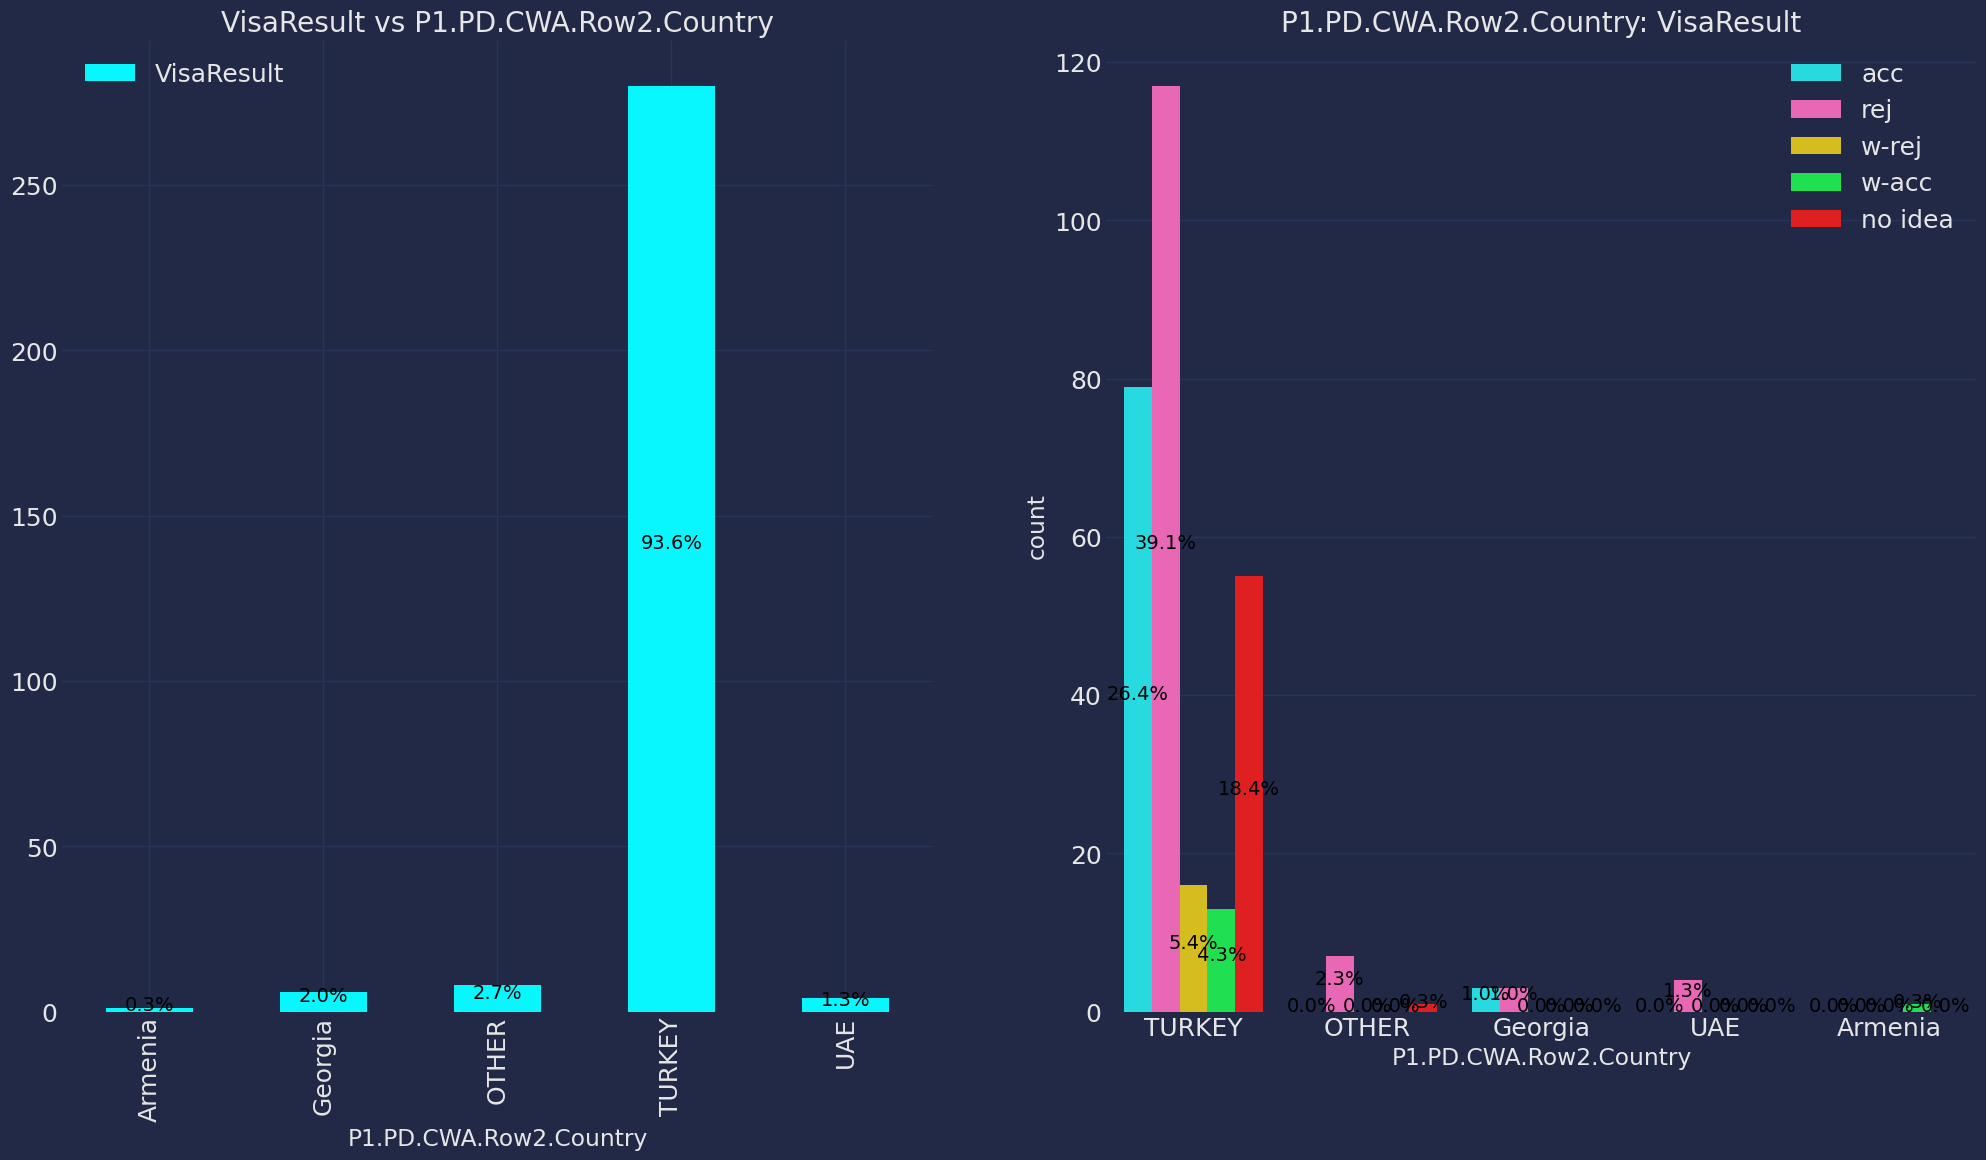

In [74]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

Here, we just are considering countries that usually someone can apply from, which for Iranians, it's Armenia, Georgia, United Arab Emirates, and Turkey.

Note that, we had CWA cases where the person applied from France, or Iraq. Separately categorizing these might be harder, but we can tell that the person whose CWA is france, already has residency status or travel history that making the case stronger, so other variables dominate affect of this.

*Remark:* My goal for including this feature is that to see if there is bias toward specific countries. I.e. in some Reddit (which is legit) post, people mentioned that UAE cases for non UAE cases usually have higher rate of rejection. 


- [ ] TODO: lets find any dataset/news of tourism visa stats w.r.t. countries.

### P1.PD.CWA.Row2.Status -> categorical

In [75]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.PD.CWA.Row2.Status  VisaResult
1.0                    acc            1
                       no idea        1
                       rej            4
                       w-acc          2
3.0                    acc           63
                       no idea       20
                       rej           60
                       w-acc          6
                       w-rej          8
6.0                    acc           18
                       no idea       35
                       rej           67
                       w-acc          6
                       w-rej          8
Name: VisaResult, dtype: int64

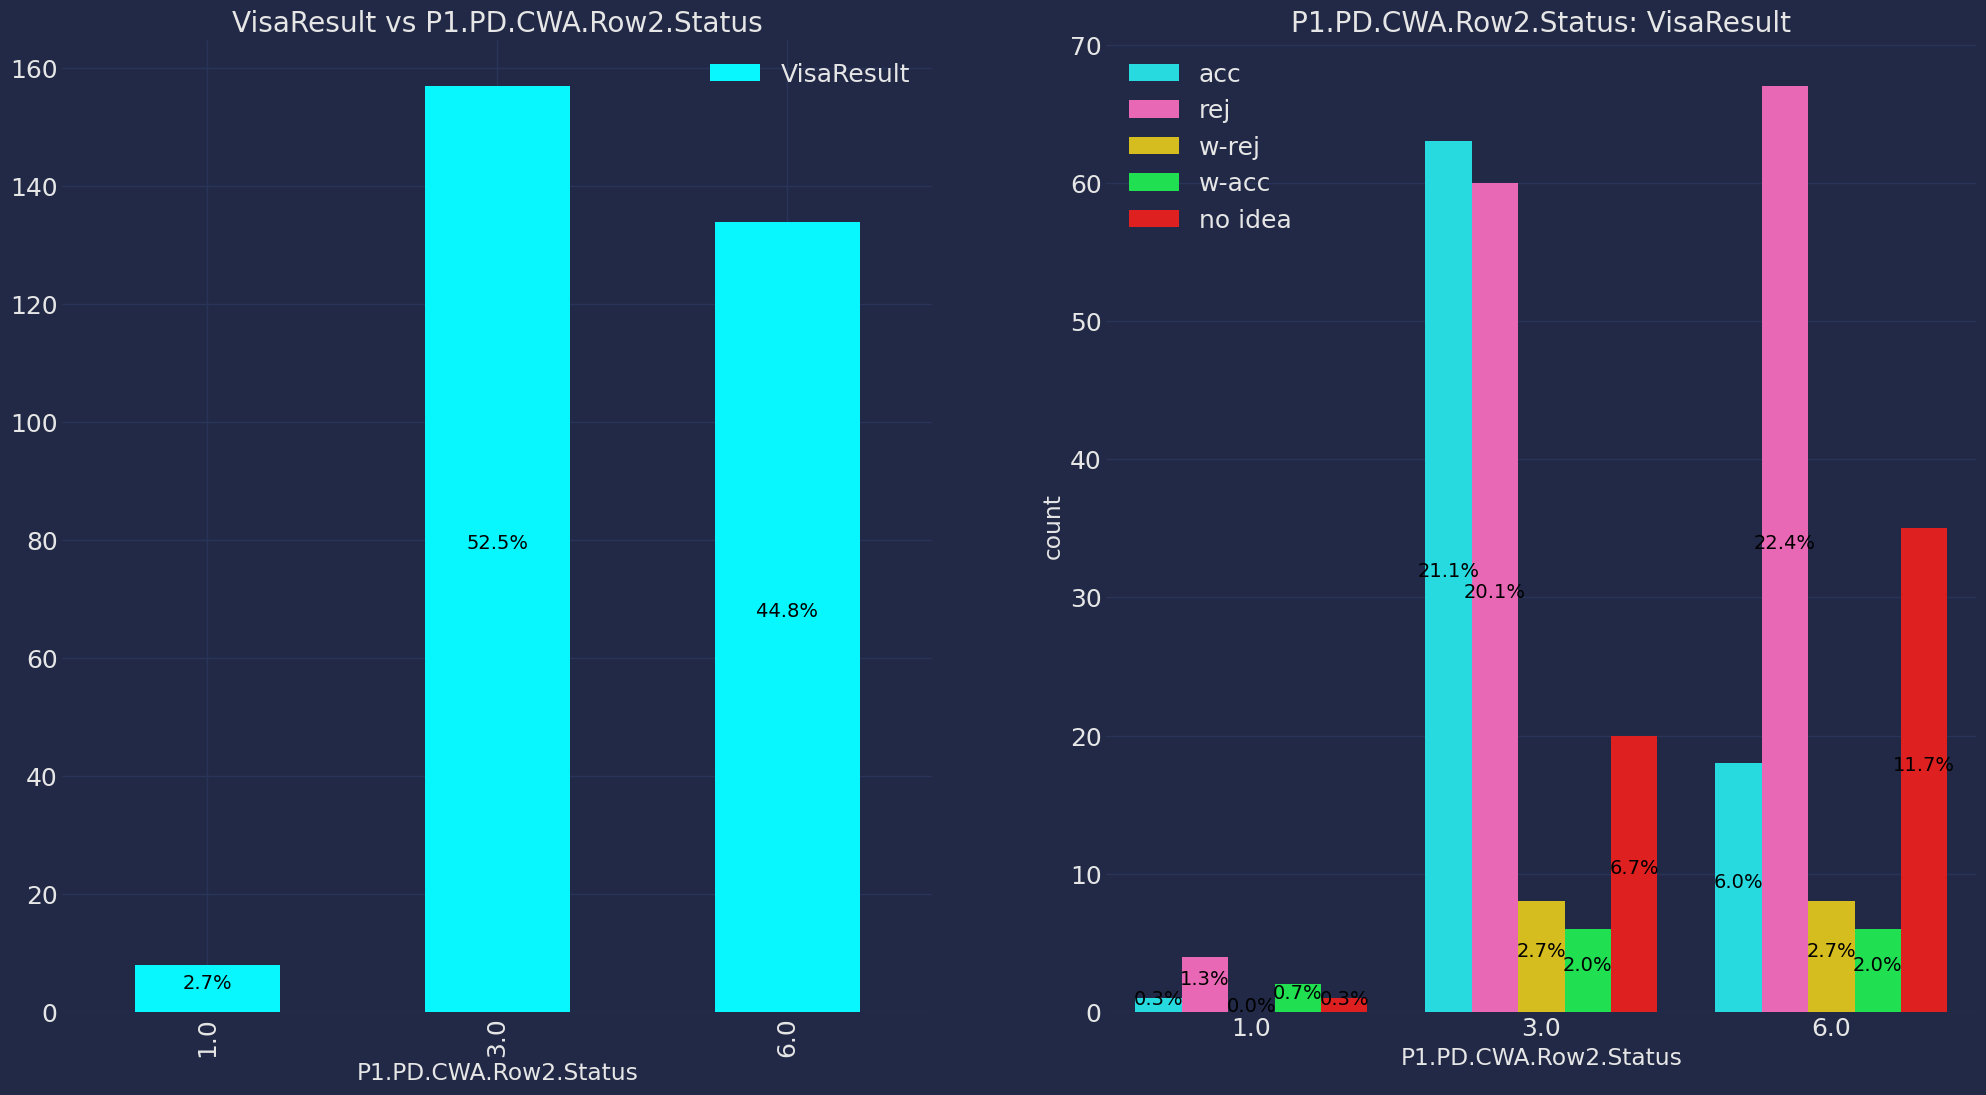

In [76]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper left')
plt.show()

The interesting observation is that there is huge difference between who choose state of their visit to CWA as VISITOR=3 vs OTHER(Biometric)=6. *I think the reason is that those who choose visitor are way richer on average*, because they need to at least stay there for 2 weeks which costs far more than Biometric visit. Let's see if we are right in the following cells:

In [77]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'

In [78]:
#nb>
# NBVAL_IGNORE_OUTPUT
pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

In [79]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Status', 'P1.PD.CWA.Row2.Period'
display(data.groupby([*feature_name, output_name])[output_name].count())

P1.PD.CWA.Row2.Status  P1.PD.CWA.Row2.Period  VisaResult
1.0                    30.0                   acc            1
                                              rej            3
                       31.0                   rej            1
                                              w-acc          2
                       90.0                   no idea        1
                                                            ..
6.0                    90.0                   rej           15
                                              w-acc          1
                       92.0                   rej           14
                                              w-rej          1
                       93.0                   rej            1
Name: VisaResult, Length: 54, dtype: int64

### Fill CWA NaN and 0 periods with a heuristic
We could go with average, but apparently data is more like discrete where applicants stayed in months rather than weeks/days. Hence, `mode` is a better feature than `mean` as it falls to dominating value.

In [80]:
display(f'{data[feature_name[1]].isna().sum()} `None`s in `{feature_name[1]}`')
display(f'{(data[feature_name[1]] == 0).sum()} `0`s in `{feature_name[1]}`')

'0 `None`s in `P1.PD.CWA.Row2.Period`'

'15 `0`s in `P1.PD.CWA.Row2.Period`'

In [81]:
# use `.item()` after calling `.mode()` on a dataframe. This is because `.mode()` returns a series, not a scalar!
data.loc[(data[feature_name[1]] == 0.) | (data[feature_name[1]].isna()), feature_name[1]] = data[data[feature_name[1]] != 0][feature_name[1]].mode().item()
display(data[feature_name[1]].unique())

array([30., 31., 29., 92., 89., 28., 90., 91., 77., 93., 61., 37.])

In [82]:
display(f'{data[feature_name[1]].isna().sum()} `None`s in `{feature_name[1]}`')
display(f'{(data[feature_name[1]] == 0).sum()} `0`s in `{feature_name[1]}`')

'0 `None`s in `P1.PD.CWA.Row2.Period`'

'0 `0`s in `P1.PD.CWA.Row2.Period`'

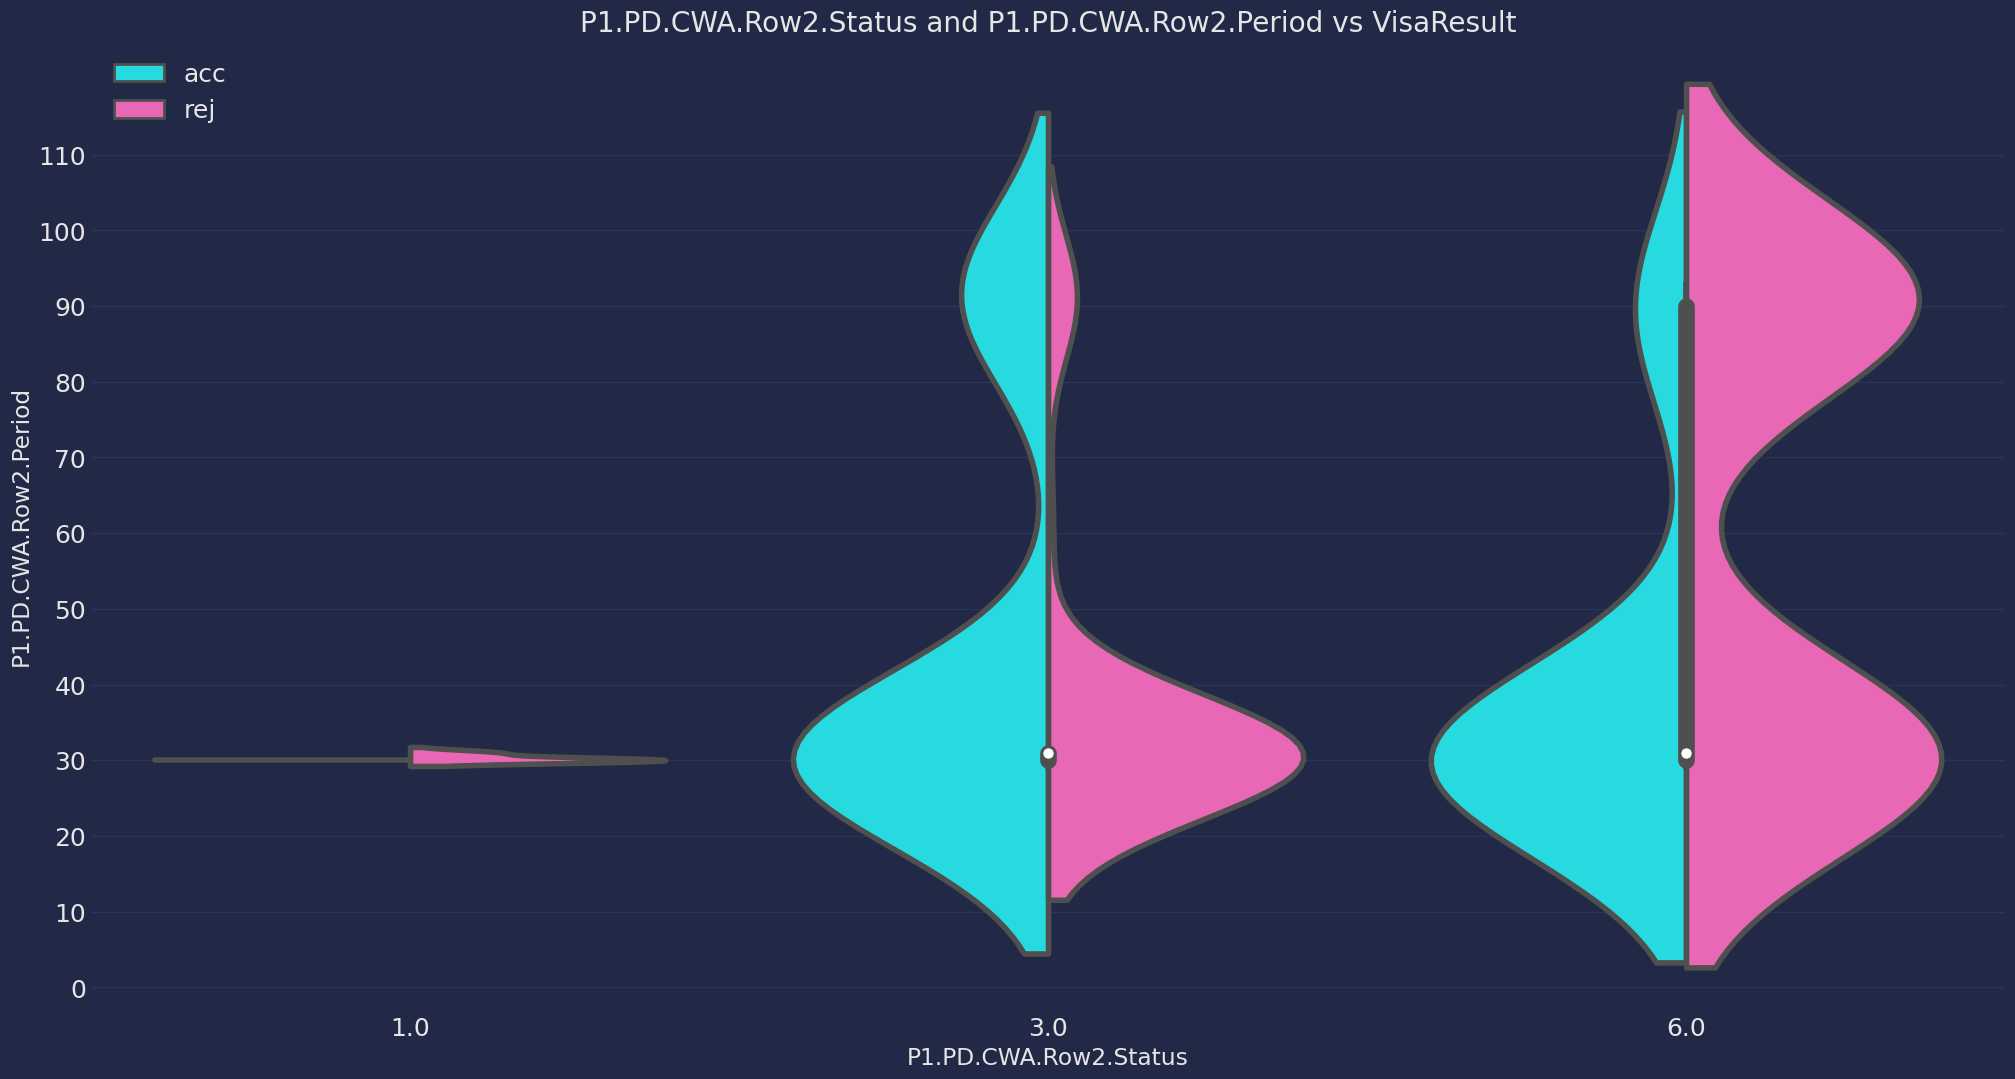

In [83]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.violinplot(x=feature_name[0], y=feature_name[1], hue=output_name, scale='width',
               data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], split=True, ax=ax)
ax.set_title('{} and {} vs {}'.format(
    feature_name[0], feature_name[1], output_name))
ax.set_yticks(range(0, 120, 10))
ax.legend(loc='upper left')
plt.show()

Well, I WAS WRONG. For some reason, where CWA status is `'OTHER'`, people are mostly staying for 90 days, meanwhile for status of Visitor, the duration is mostly around 30 days. The reason it's weird is that usually CWA status of `'OTHER'` stands for `'Biometric'` case and 90 days mode does not make sense!

TODO: what's going on? ask agents!

### P1.PD.CWA.Row2.Other -> categorical

In [84]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CWA.Row2.Other'
display(data.groupby([feature_name, 'P1.PD.CWA.Row2.Status'])[output_name].count())

P1.PD.CWA.Row2.Other  P1.PD.CWA.Row2.Status
False                 1.0                        8
                      3.0                      157
                      6.0                       15
True                  6.0                      119
Name: VisaResult, dtype: int64

All the cases that have flag `'P1.PD.CWA.Row2.Other'=True` are in  `'P1.PD.CWA.Row2.Status'=6` which means status of 6 is already representing other case. So, we delete it.

In [85]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

In [86]:
#nb>
data.sample(5, random_state=SEED)

P1.PD.Sex.Sex P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status P1.MS.SecA.MS  \
145        Female                 TURKEY                    3.0            02   
234          Male                 TURKEY                    6.0            01   
287          Male                 TURKEY                    3.0            02   
196          Male                Armenia                    3.0            02   
68         Female                 TURKEY                    3.0            02   

    P2.MS.SecA.PrevMarrIndicator P2.MS.SecA.TypeOfRelationship  \
145                        False                         OTHER   
234                         True                            01   
287                        False                         OTHER   
196                        False                         OTHER   
68                         False                         OTHER   

    P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  \
145                                           IRAN   
234                                           IRAN   
287                                           IRAN   
196                                           IRAN   
68                                            IRAN   

    P2.MS.SecA.Langs.languages.nativeLang.nativeLang  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  \
145                                            English               
234                                            English               
287                                            English               
196                                            English               
68                                             English               

    P2.MS.SecA.Langs.LangTest P2.natID.q1.natIDIndicator  \
145                     False                       True   
234                     False                       True   
287                     False                       True   
196                     False                       True   
68                      False                       True   

    P2.natID.natIDdocs.CountryofIssue.CountryofIssue  \
145                                             IRAN   
234                                             IRAN   
287                                             IRAN   
196                                             IRAN   
68                                              IRAN   

    P2.USCard.q1.usCardIndicator P2.CI.cntct.PhnNums.Phn.CanadaUS  \
145                        False                            False   
234                        False                            False   
287                        False                            False   
196                        False                            False   
68                         False                            False   

    P2.CI.cntct.PhnNums.AltPhn.CanadaUS  \
145                               False   
234                               False   
287                               False   
196                               False   
68                                False   

     P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit P3.DOV.PrpsRow1.Other.Other  \
145                                      2.0                       False   
234                                     13.0                       False   
287                                      8.0                       False   
196                                      2.0                       False   
68                                       2.0                       False   

     P3.DOV.PrpsRow1.Funds.Funds  \
145                      10000.0   
234                      10000.0   
287                       8000.0   
196                      10000.0   
68                       100

### P1.MS.SecA.MS -> categorical

In [87]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.MS'
display(data.groupby([feature_name, output_name])[output_name].count())

P1.MS.SecA.MS  VisaResult
01             acc           65
               no idea       48
               rej           95
               w-acc         12
               w-rej         11
02             acc           10
               no idea        7
               rej           29
               w-acc          2
               w-rej          5
04             acc            5
               no idea        1
               rej            5
06             acc            2
               rej            2
Name: VisaResult, dtype: int64

In [88]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')

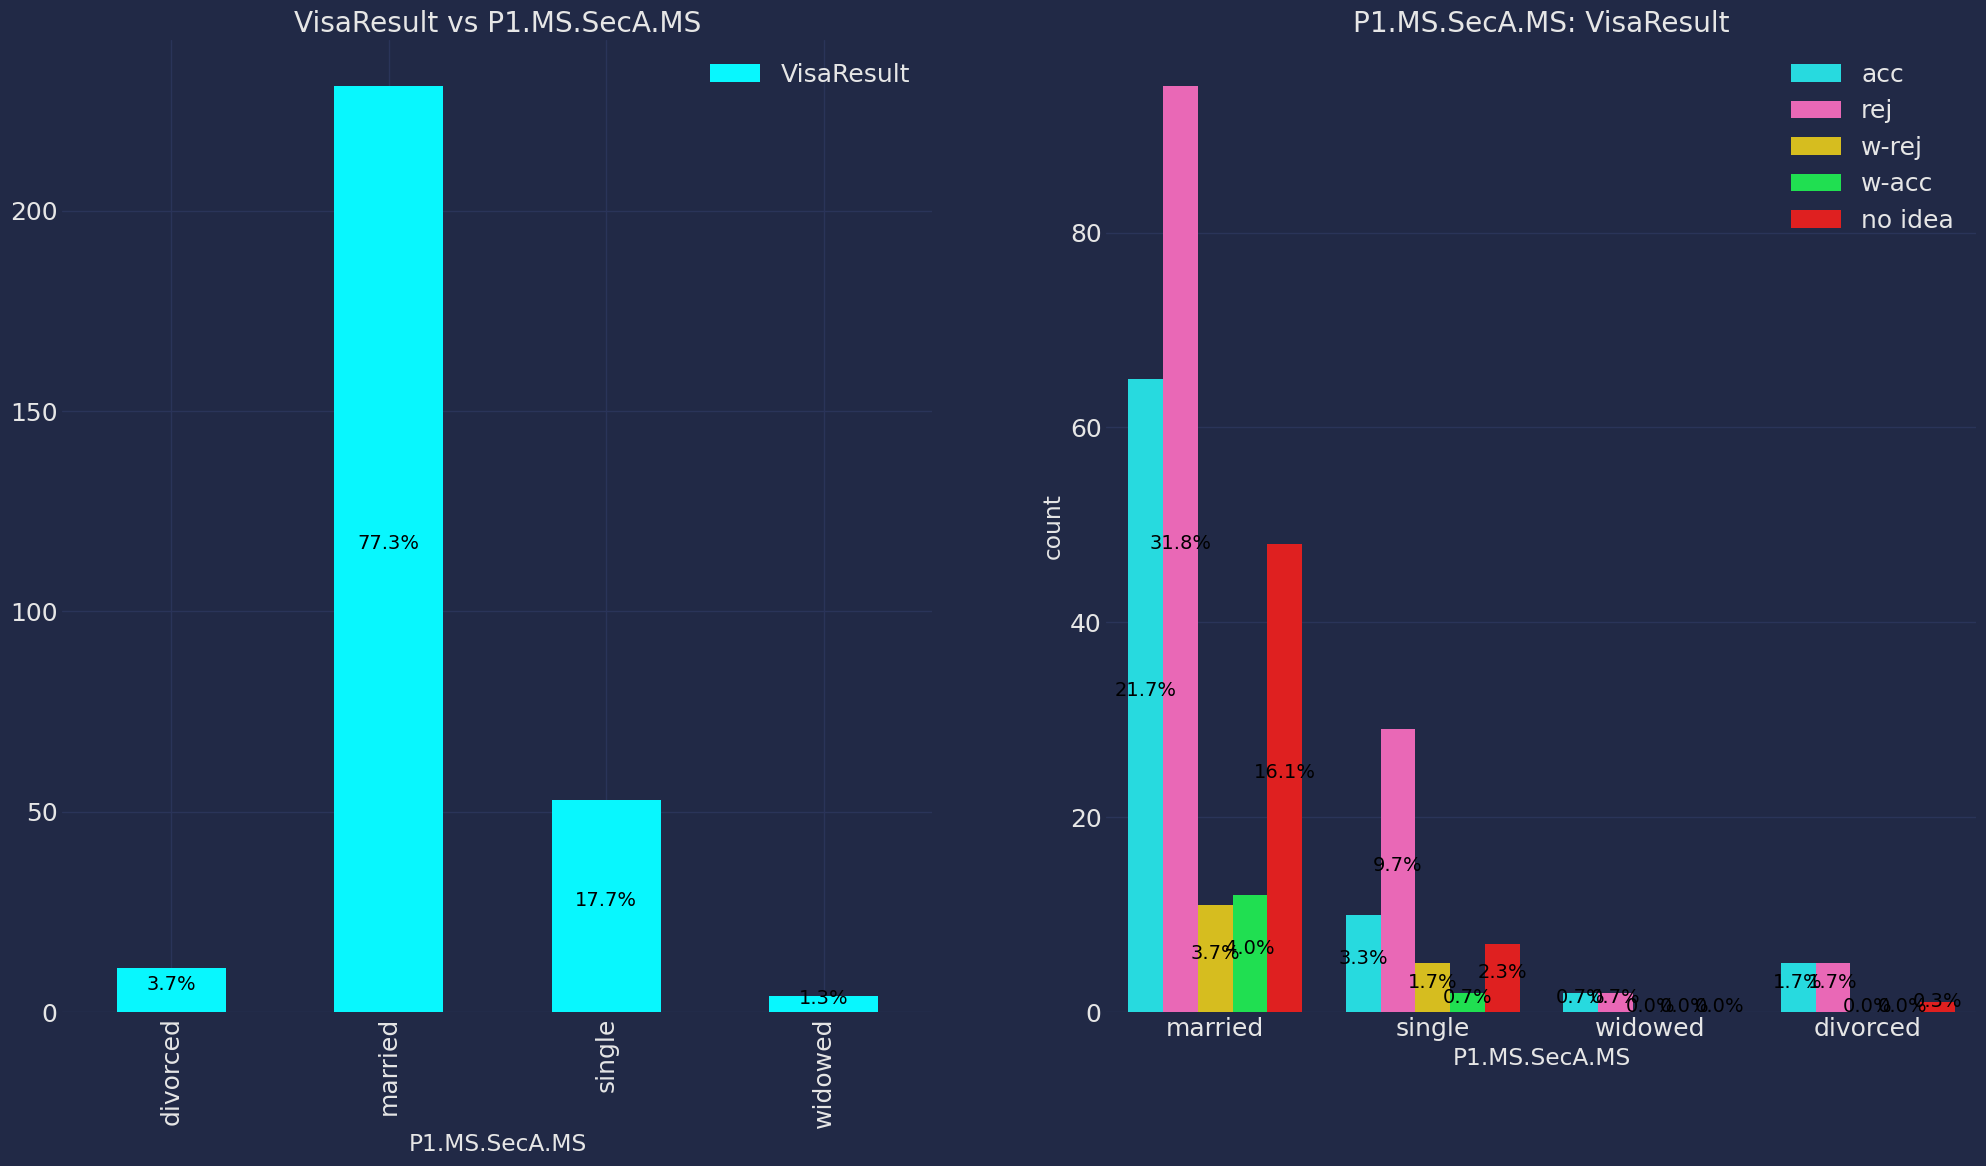

In [89]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

It is clear that *single people (necessarily those who have never married) are way more likely to get rejected*, since single people are way more likely to stay. 

### P2.MS.SecA.PrevMarrIndicator -> categorical

In [90]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevMarrIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.PrevMarrIndicator  VisaResult
False                         acc            69
                              no idea        53
                              rej           123
                              w-acc          14
                              w-rej          14
True                          acc            13
                              no idea         3
                              rej             8
                              w-rej           2
Name: VisaResult, dtype: int64

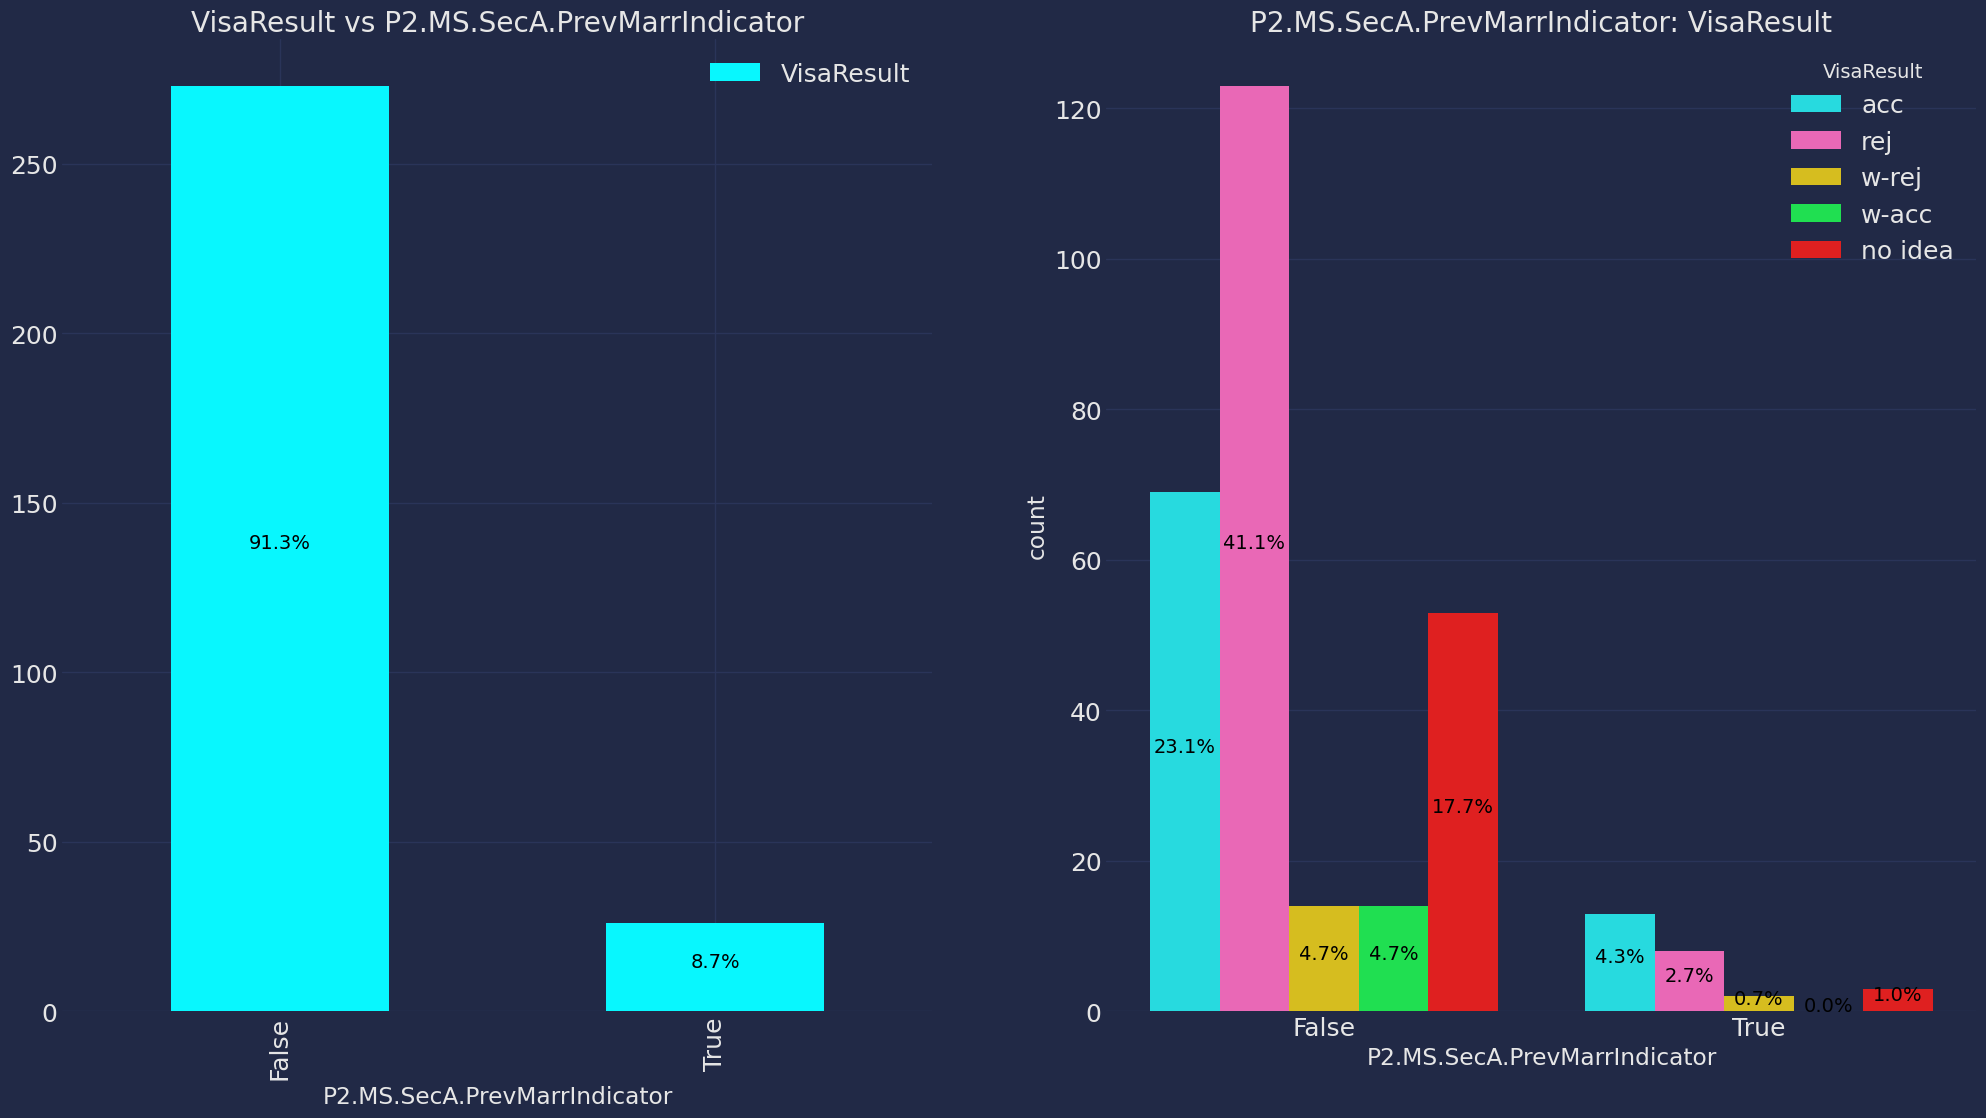

In [91]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

We can see that those who have previous marriage have higher chance, but this could be directly because of the age, since someone with previous marriage is probably more like to have higher age, and higher income (well, women get a lot of money for getting divorced for some unknown reason and those who can divorce usually have higher status as it is rarer to happen in traditional families.)

In [92]:
feature_name = 'P2.MS.SecA.PrevMarrIndicator', 'P1.PD.Sex.Sex'

In [93]:
#nb>
# NBVAL_IGNORE_OUTPUT
pd.crosstab([data[feature_name[0]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name]], data[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

### P2.MS.SecA.TypeOfRelationship -> categorical

In [94]:
# convert numbers to names
ms_num_names = {
    '01': 'married',
    '02': 'single',
    '03': 'common-law',
    '04': 'divorced',
    '05': 'separated',
    '06': 'widowed',
    '09': 'annulled',
    '00': 'ukn',
}

output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.TypeOfRelationship'

# keep it 'ukn' since we have this category in XFA PDFs too
#   although here it means that there was no previous marriage.
data[feature_name] = data[feature_name].apply(lambda x: ms_num_names[x]
                                              if x in ms_num_names else 'ukn')  

display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.TypeOfRelationship  VisaResult
married                        acc            13
                               no idea         3
                               rej             8
                               w-rej           2
ukn                            acc            69
                               no idea        53
                               rej           123
                               w-acc          14
                               w-rej          14
Name: VisaResult, dtype: int64

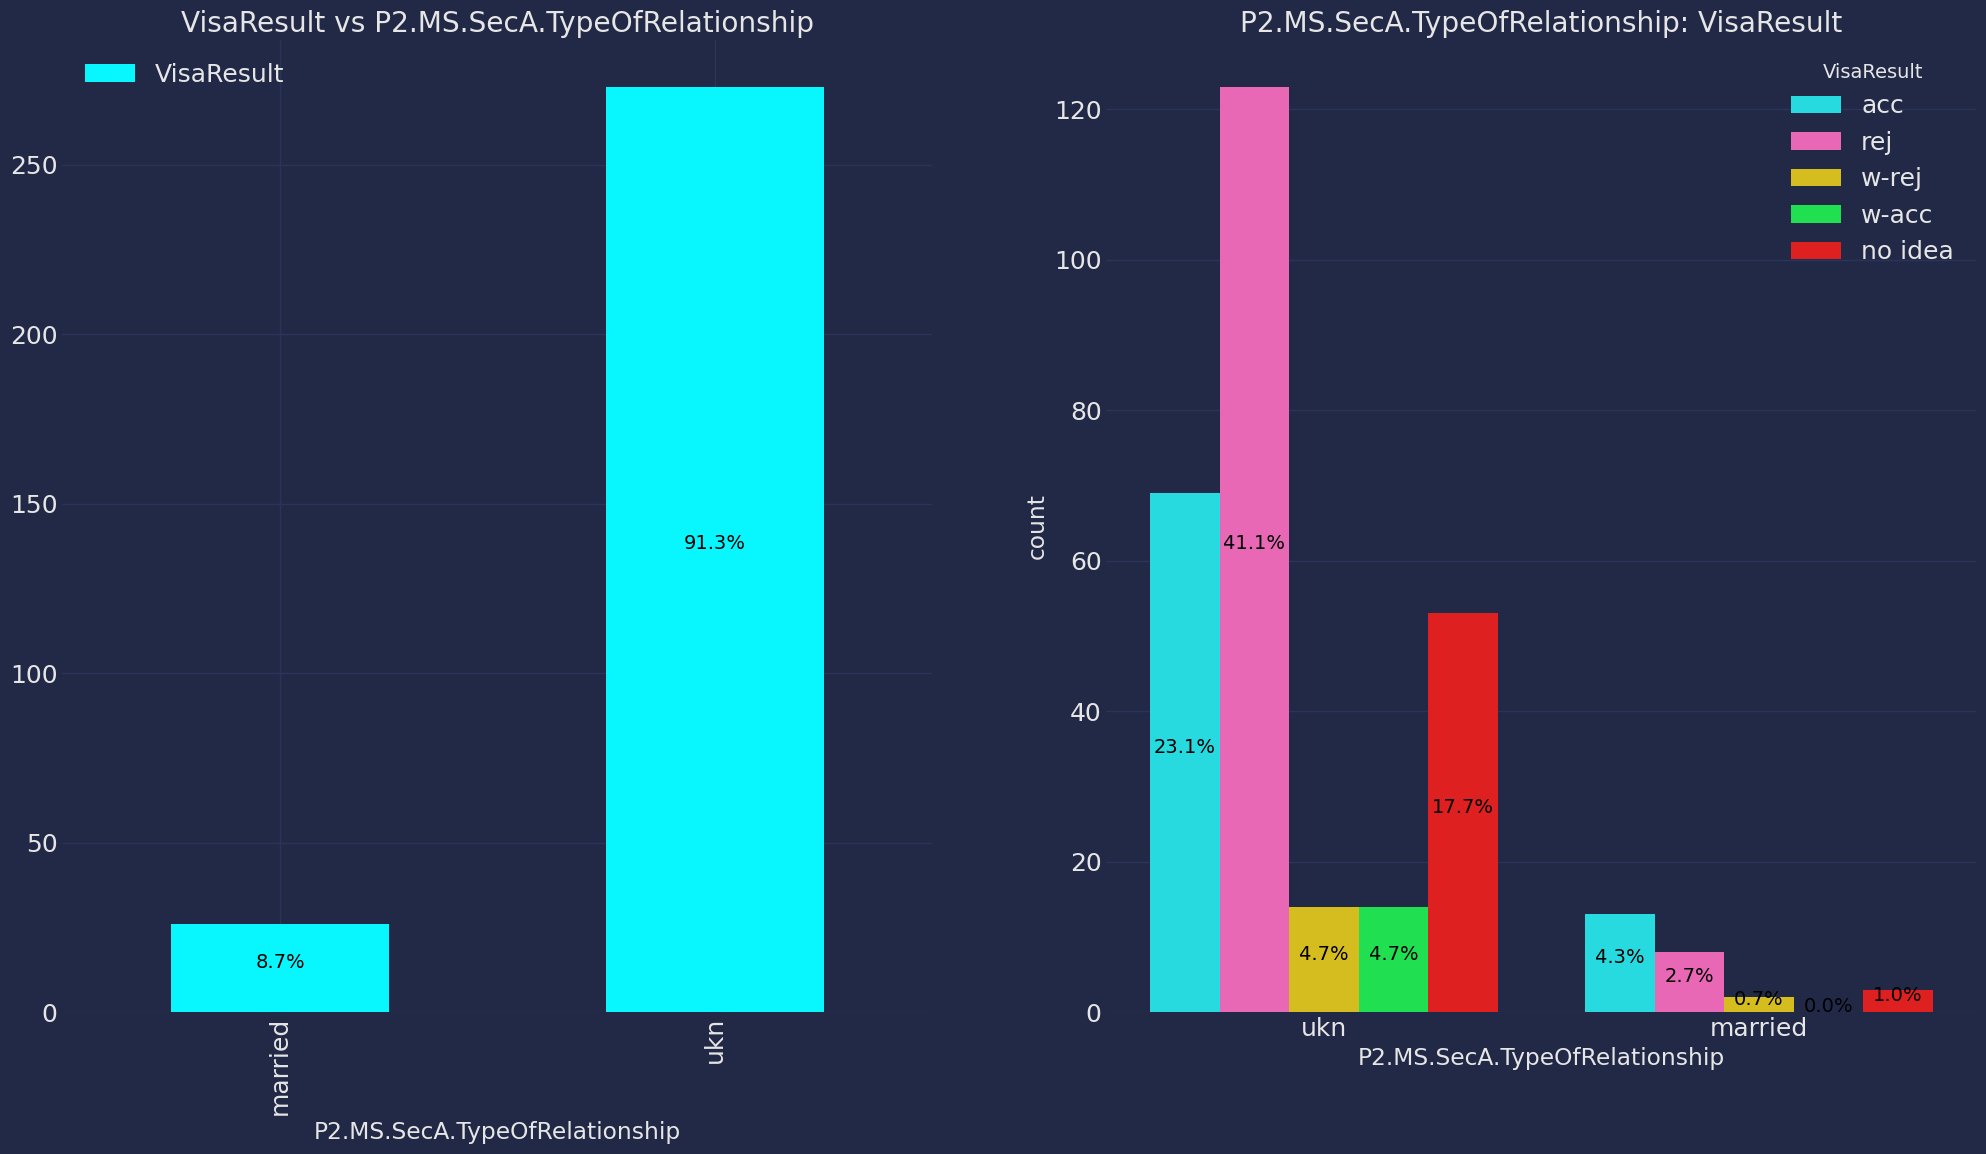

In [95]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

Since we have only type of `'married'`, `'ukn'` represents cases where there was no previous marriage. Hence, feature in previous section, i.e. `'P2.MS.SecA.PrevMarrIndicator'` is representing the exact same thing. On the other hand, common-law marriage is not legal in Iran and as we can see, there is not a single case of it. So even in future, we can just ignore it or replace it with married case. So, we can delete it.

In [96]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue -> categorical

In [97]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.Psprt.CountryofIssue.CountryofIssue  VisaResult
059                                             rej             1
IRAN                                            acc            82
                                                no idea        56
                                                rej           128
                                                w-acc          14
                                                w-rej          16
TURKEY                                          rej             2
Name: VisaResult, dtype: int64

In [98]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.nativeLang.nativeLang -> categorical

In [99]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.nativeLang.nativeLang'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.Langs.languages.nativeLang.nativeLang  VisaResult
106                                               rej             1
251                                               rej             4
                                                  w-rej           1
IRAN                                              acc            82
                                                  no idea        56
                                                  rej           126
                                                  w-acc          14
                                                  w-rej          15
Name: VisaResult, dtype: int64

In [100]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate -> categorical

In [101]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Both                                                            w-rej           1
English                                                         acc            75
                                                                no idea        55
                                                                rej           130
                                                                w-acc          14
                                                                w-rej          14
Neither                                                         acc             7
                                                                no idea         1
                                                                rej             1
                                                                w-rej           1
Name: VisaResult, dtype: int64

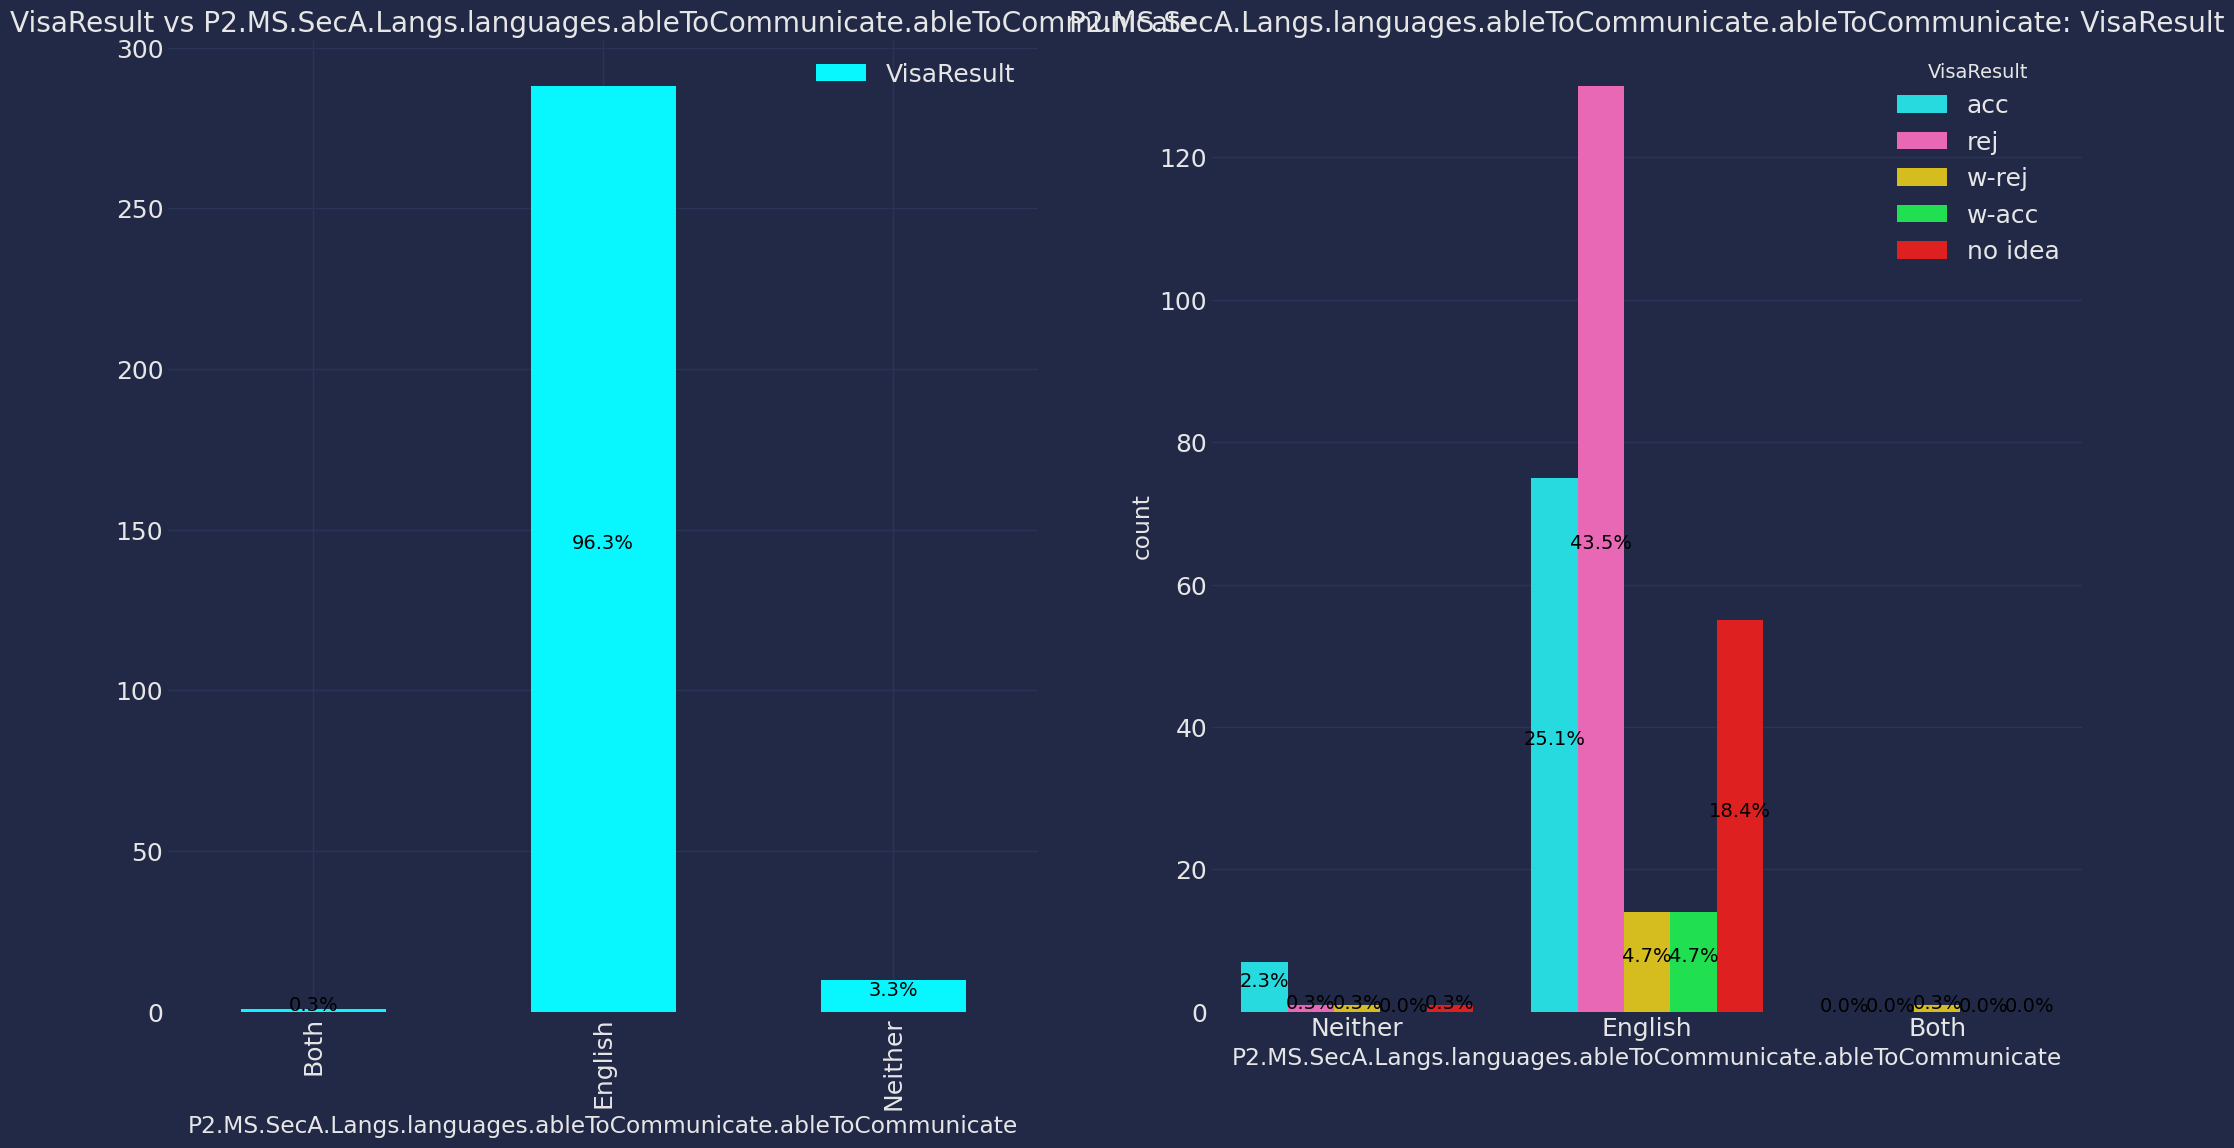

In [102]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

The data is too small to make a decision, but we see a large acceptance rate when applicant speaks no language, and the reason easily could be that the person is probably old and have a full family, i.e. who can afford to go to Canada but does not speak a second language? Old housewives and retired employees probably! Let's see if we are right for fun:

In [103]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ', 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
display(data[data[feature_name[1]] == 'Neither'].groupby([*feature_name, output_name])[output_name].count())

P3.Occ.OccRow1.Occ.Occ         P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate  VisaResult
Advertising Director           Neither                                                         no idea       1
DEPUTY OF NOTARY PUBLIC        Neither                                                         rej           1
HOUSEWIFE                      Neither                                                         acc           2
                                                                                               w-rej         1
OWNER RESTAURANT-MASTER CHEF   Neither                                                         acc           1
PERSIAN/PICTURE CARPET WEAVER  Neither                                                         acc           1
RETIRED                        Neither                                                         acc           3
Name: VisaResult, dtype: int64

We were right, KEKW. But it has no useful information since it is directly affected by age, family status, etc. Hence, I delete it.

In [104]:
# drop useless
feature_name = 'P2.MS.SecA.Langs.languages.ableToCommunicate.ableToCommunicate'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Langs.LangTest -> categorical

In [105]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Langs.LangTest'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.MS.SecA.Langs.LangTest  VisaResult
False                      acc            80
                           no idea        56
                           rej           128
                           w-acc          14
                           w-rej          14
True                       acc             2
                           rej             3
                           w-rej           2
Name: VisaResult, dtype: int64

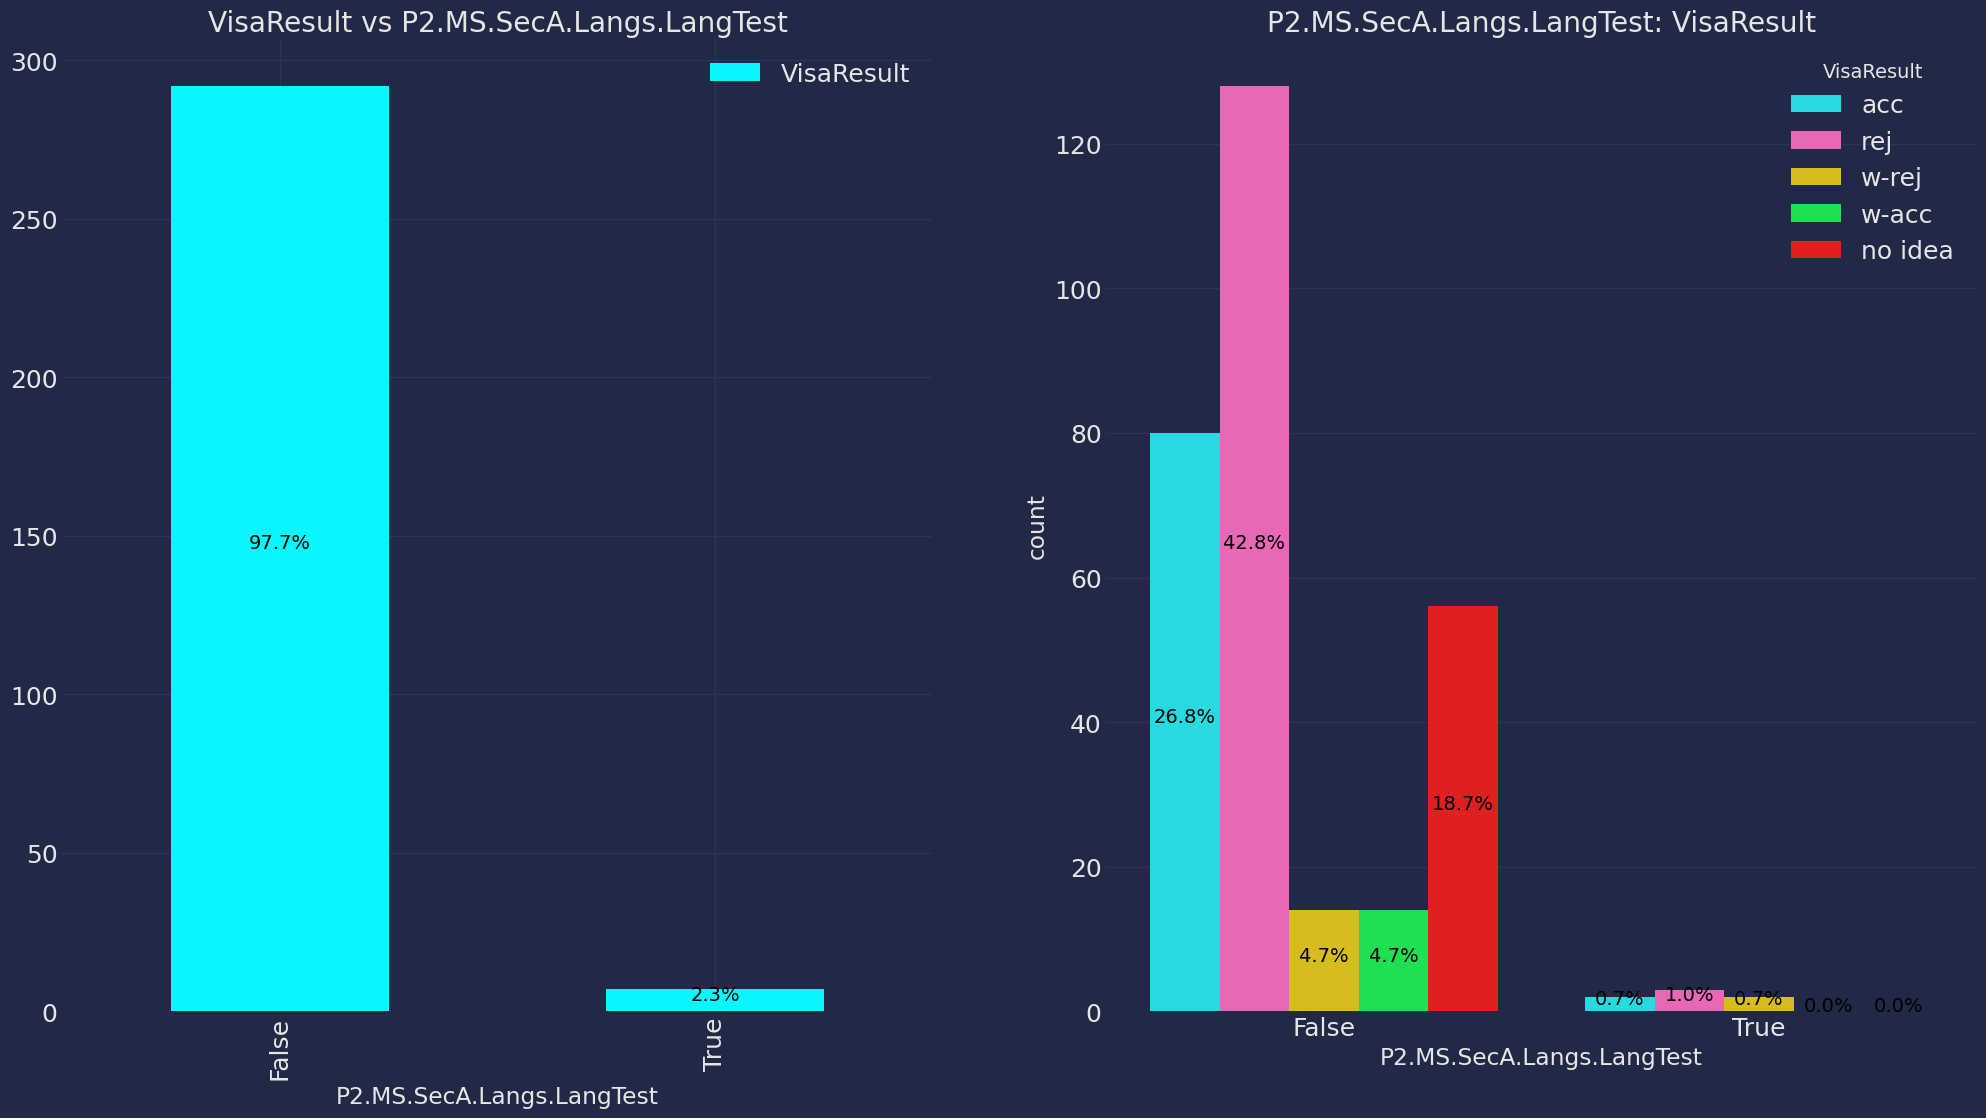

In [106]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
plt.show()

In [107]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

No idea! Maybe letter we can see some correlation or delete it entirely. For now, we delete it because of few samples. TODO: see what's the best, delete or not?

### P2.natID.q1.natIDIndicator -> categorical

In [108]:
output_name = 'VisaResult'
feature_name = 'P2.natID.q1.natIDIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.natID.q1.natIDIndicator  VisaResult
True                        acc            82
                            no idea        56
                            rej           131
                            w-acc          14
                            w-rej          16
Name: VisaResult, dtype: int64

In [109]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)
# also this
feature_name = 'P2.natID.natIDdocs.CountryofIssue.CountryofIssue'
data.drop(feature_name, axis=1, inplace=True)

### P2.USCard.q1.usCardIndicator -> categorical

In [110]:
output_name = 'VisaResult'
feature_name = 'P2.USCard.q1.usCardIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.USCard.q1.usCardIndicator  VisaResult
False                         acc            82
                              no idea        56
                              rej           131
                              w-acc          14
                              w-rej          16
Name: VisaResult, dtype: int64

In [111]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P2.CI.cntct.PhnNums.[Phn.CanadaUS, AltPhn.CanadaUS] -> categorical

In [112]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.Phn.CanadaUS'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.CI.cntct.PhnNums.Phn.CanadaUS  VisaResult
False                             acc            82
                                  no idea        56
                                  rej           131
                                  w-acc          14
                                  w-rej          16
Name: VisaResult, dtype: int64

In [113]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

In [114]:
output_name = 'VisaResult'
feature_name = 'P2.CI.cntct.PhnNums.AltPhn.CanadaUS'
display(data.groupby([feature_name, output_name])[output_name].count())

P2.CI.cntct.PhnNums.AltPhn.CanadaUS  VisaResult
False                                acc            80
                                     no idea        56
                                     rej           131
                                     w-acc          14
                                     w-rej          16
True                                 acc             2
Name: VisaResult, dtype: int64

In [115]:
#nb>
data[data[feature_name] == True]

P1.PD.Sex.Sex P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status P1.MS.SecA.MS  \
55         Female                 TURKEY                    3.0       married   
208          Male                 TURKEY                    3.0       married   

    P2.MS.SecA.PrevMarrIndicator P2.CI.cntct.PhnNums.AltPhn.CanadaUS  \
55                         False                                True   
208                        False                                True   

     P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit P3.DOV.PrpsRow1.Other.Other  \
55                                       8.0                       False   
208                                      8.0                       False   

     P3.DOV.PrpsRow1.Funds.Funds  \
55                        8000.0   
208                       8000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
55                                            DAUGHTER     
208                                           DAUGHTER     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
55                                         OTHER               False   
208                                        OTHER               False   

    P3.Edu.Edu_Row1.FieldOfStudy P3.Edu.Edu_Row1.Country.Country  \
55                          <NA>                            IRAN   
208                         <NA>                            IRAN   

    P3.Occ.OccRow1.Occ.Occ P3.Occ.OccRow1.Country.Country  \
55                 RETIRED                           IRAN   
208                RETIRED                           IRAN   

    P3.Occ.OccRow2.Occ.Occ P3.Occ.OccRow2.Country.Country  \
55                   OTHER                           IRAN   
208                  OTHER                           IRAN   

    P3.Occ.OccRow3.Occ.Occ P3.Occ.OccRow3.Country.Country  \
55                   OTHER                           IRAN   
208                  OTHER                           IRAN   

    P3.BGI.Details.MedicalDetails P3.BGI.otherThanMedic P3.noAuthStay  \
55                          False                 False         False   
208                         False                 False         False   

    P3.refuseDeport P3.BGI2.PrevApply P3.PWrapper.criminalRec  \
55            False             False                   False   
208           False             False                   False   

    P3.PWrapper.Military.Choice P3.PWrapper.politicViol  \
55                        False                   False   
208                       False                   False   

    P3.PWrapper.witnessIllTreat  P1.PD.DOBYear.Period  \
55                        False               26465.0   
208                       False               27196.0   

     P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  \
55                         0.0                        0.0   
208                        0.0                        0.0   

     P1.PD.CWA.Row2.Period  P1.MS.SecA.DateOfMarr.Period  \
55                    91.0                       18309.0   
208                   91.0                       18309.0   

     P2.MS.SecA.PrevSpouseDOB.DOBYear.Period  P2.MS.SecA.Period  \
55                                       0.0                0.0   
208                                      0.0                0.0   

     P2.MS.SecA.Psprt.ExpiryDate.Remaining  P3.DOV.PrpsRow1.HLS.Period  \
55                                  1496.0                        31.0   
208                                 1502.0                        31.0   

     P3.Edu.Edu_Row1.Period  P3.Occ.OccRow1.Period  P3.Occ.OccRow2.Period  \
55                      0.0                 7107.0                    0.0   
208                     0.0                 5281.0                    0.0   

     P3.Occ.OccRow3.Period  p1.Subform1.Visitor  p1.Subform1.Worker  \
55                     0.0                  1.0                 0.0   
208                    0.0                  1.0                 0.0   

     p1.Subform1.Student  p1.Subform1.Other  \
5

In [116]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

These two entries are the family of the same person with strong application. Although, indication of Canada/US phone depicts strong case, other factors should indicate the same thing too, like previous travel to Canada/US, funds, relationship in Canada, etc. Hence, I remove it for now until further notice!

TODO: see if del or not

In [117]:
#nb>
data.sample(5, random_state=SEED)

P1.PD.Sex.Sex P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status P1.MS.SecA.MS  \
145        Female                 TURKEY                    3.0        single   
234          Male                 TURKEY                    6.0       married   
287          Male                 TURKEY                    3.0        single   
196          Male                Armenia                    3.0        single   
68         Female                 TURKEY                    3.0        single   

    P2.MS.SecA.PrevMarrIndicator  P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  \
145                        False                                      2.0   
234                         True                                     13.0   
287                        False                                      8.0   
196                        False                                      2.0   
68                         False                                      2.0   

    P3.DOV.PrpsRow1.Other.Other  P3.DOV.PrpsRow1.Funds.Funds  \
145                       False                      10000.0   
234                       False                      10000.0   
287                       False                       8000.0   
196                       False                      10000.0   
68                        False                      10000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
145                                              HOTEL     
234                                              HOTEL     
287                                            BROTHER     
196                                              HOTEL     
68                                               HOTEL     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
145                                        HOTEL                True   
234                                        HOTEL                True   
287                                        OTHER                True   
196                                        HOTEL                True   
68                                         OTHER                True   

    P3.Edu.Edu_Row1.FieldOfStudy P3.Edu.Edu_Row1.Country.Country  \
145            MEDICAL CHEMISTRY                            IRAN   
234          BUSINESS MANAGEMENT                            IRAN   
287                         DVME                            IRAN   
196  CULTURAL AFFAIRS MANAGEMENT                            IRAN   
68                     NUTRITION                            IRAN   

                                P3.Occ.OccRow1.Occ.Occ  \
145                                            student   
234                                           EMPLOYEE   
287                                                VET   
196                                           EMPLOYEE   
68   the expert in-charge of nutrition and dietothe...   

    P3.Occ.OccRow1.Country.Country   P3.Occ.OccRow2.Occ.Occ  \
145                           IRAN                    OTHER   
234                           IRAN                    OTHER   
287                           IRAN  Animal husbandry farmer   
196                           IRAN                    OTHER   
68                            IRAN                    OTHER   

    P3.Occ.OccRow2.Country.Country P3.Occ.OccRow3.Occ.Occ  \
145                           IRAN                  OTHER   
234                           IRAN                  OTHER   
287                           IRAN                  OTHER   
196                           IRAN                  OTHER   
68                            IRAN                  OTHER   

    P3.Occ.OccRow3.Country.Country P3.BGI.Details.MedicalDetails  \
145                           IRAN                         False   
234                           IRAN                         False   
287                           IRAN                         False   
196                           IRAN                         False   
68                            I

### P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit -> categorical

In [118]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
1.0                                      rej            1
2.0                                      acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
3.0                                      acc            1
                                         rej            2
8.0                                      acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
13.0                                     acc            5
                                         no idea       18
                                         rej           19
                    

In [119]:
# convert numbers to names
vp_num_names = {
    1: 'business',
    2: 'tourism',
    3: 'other',
    4: 'short study',
    5: 'returning student',
    6: 'returning worker',
    7: 'super visa',
    8: 'family visit',
    13: 'visit',
}

output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'
# keep it 'other' since we have this category in XFA PDFs too (as '03')
#   although here it means that there was no previous marriage.
data[feature_name] = data[feature_name].apply(lambda x: vp_num_names[int(x)]
                                              if int(x) in vp_num_names else 'other')

display(data.groupby([feature_name, output_name])[output_name].count())

P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  VisaResult
business                                 rej            1
family visit                             acc           48
                                         no idea        6
                                         rej           23
                                         w-acc          4
                                         w-rej          3
other                                    acc            1
                                         rej            2
tourism                                  acc           28
                                         no idea       32
                                         rej           86
                                         w-acc          7
                                         w-rej          8
visit                                    acc            5
                                         no idea       18
                                         rej           19
                    

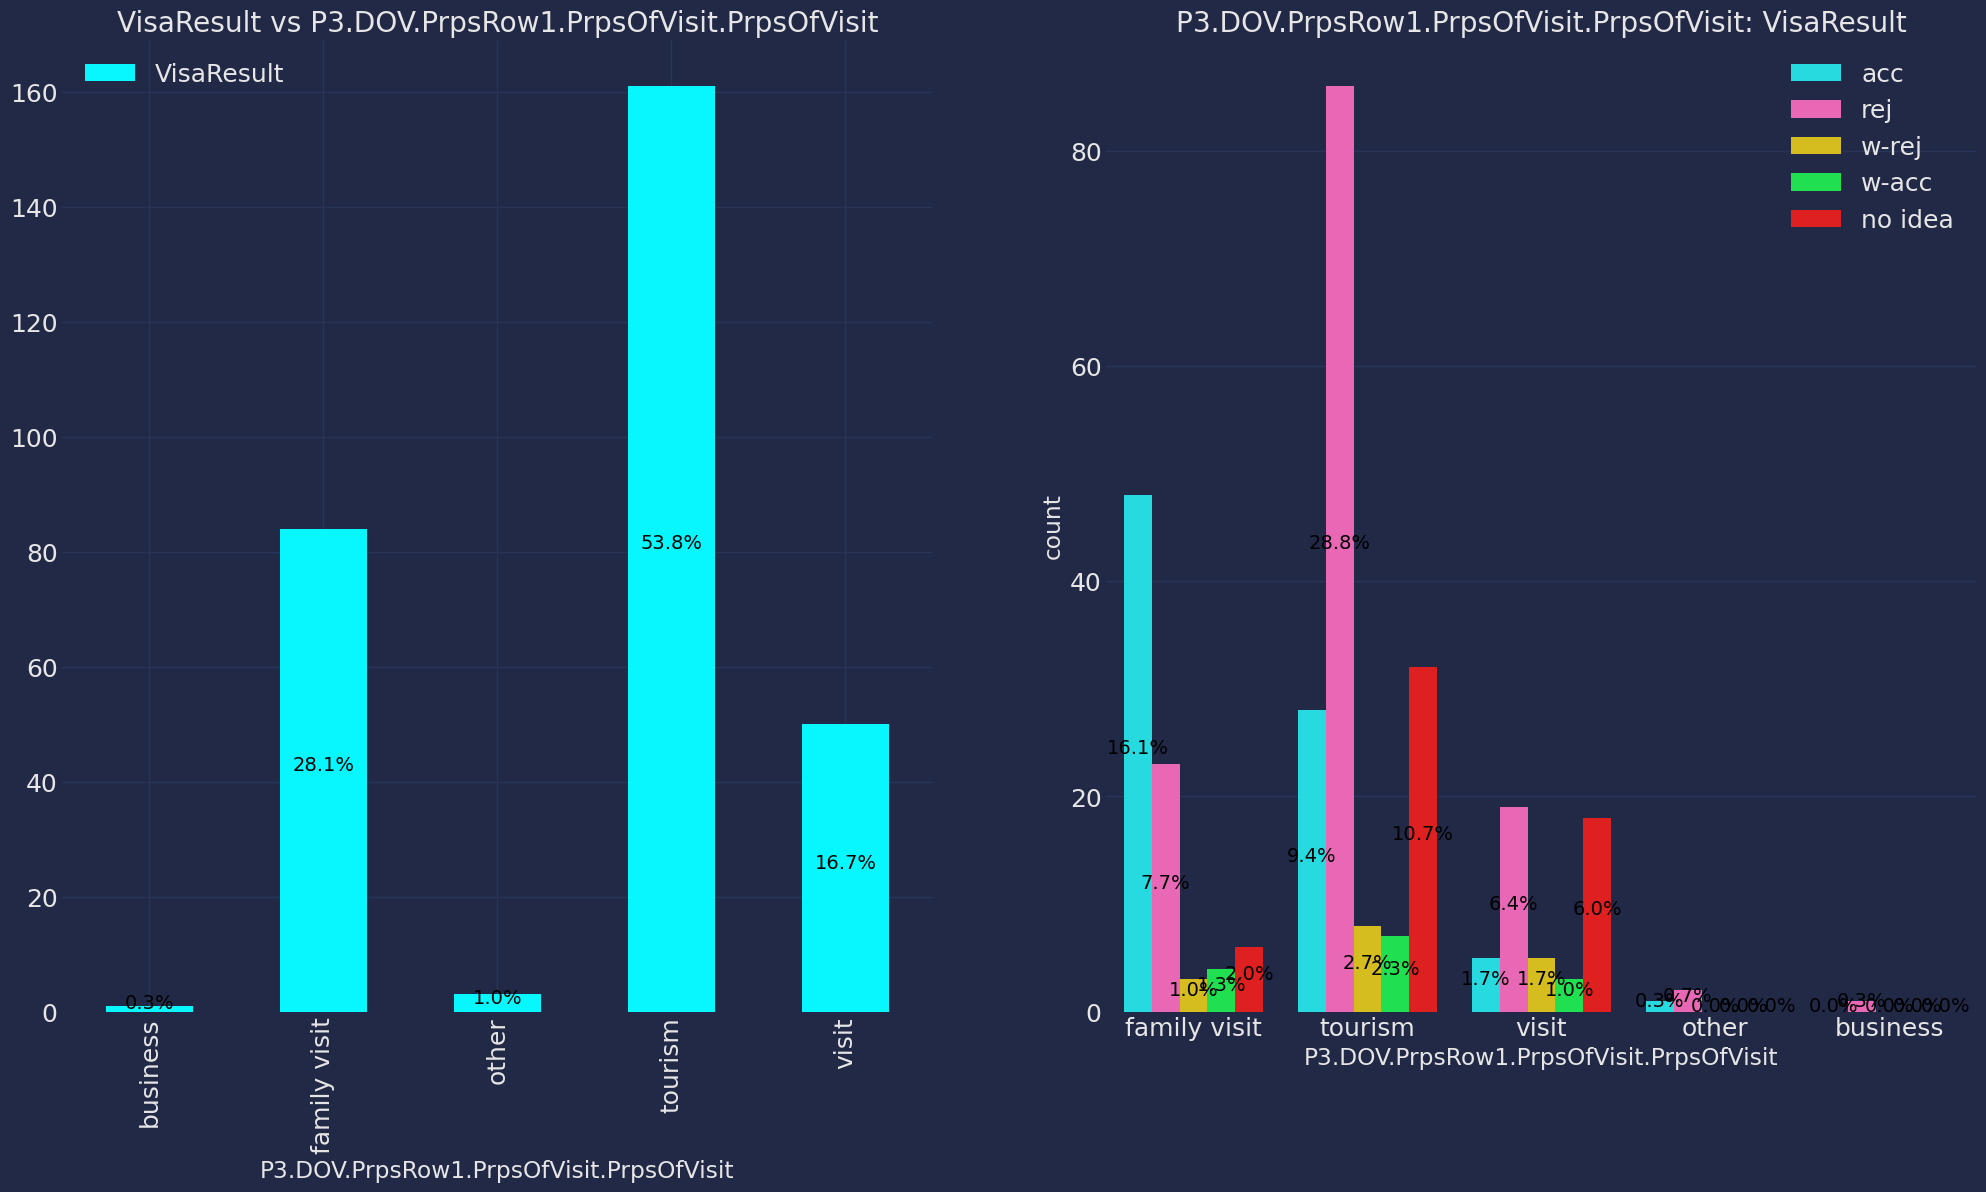

In [120]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
sns.countplot(x=feature_name, hue=output_name, data=data,
              ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

Clearly, a candidate visiting his family (hence having invitation letter too) has a stronger application than just tourism which is open to all. Also, just `'visit'` is not good enough even though it's not `'tourism'`.

In [121]:
feature_name = 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe'

In [122]:
#nb>
# NBVAL_IGNORE_OUTPUT
z = data[data[feature_name[0]] == 'visit']
pd.crosstab([z[feature_name[0]], z[(z[output_name] == 'acc') | (z[output_name] == 'rej')][output_name]], z[feature_name[1]],
            margins=True, dropna=False).style.background_gradient(cmap='summer_r')

Well, yes, of course you get rejected if you are going to spend 10K CAD to see your wife's first cousin. OMEGALUL.

### P3.DOV.PrpsRow1.Other.Other -> categorical

In [123]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Other.Other'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.DOV.PrpsRow1.Other.Other  VisaResult
False                        acc            81
                             no idea        56
                             rej           129
                             w-acc          14
                             w-rej          16
True                         acc             1
                             rej             2
Name: VisaResult, dtype: int64

In [124]:
display(data[data[feature_name] == True].groupby(
    ['P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', feature_name])[feature_name].count())

P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  P3.DOV.PrpsRow1.Other.Other
other                                    True                           3
Name: P3.DOV.PrpsRow1.Other.Other, dtype: int64

In [125]:
# drop useless
data.drop(feature_name, axis=1, inplace=True)

### P3.DOV.PrpsRow1.Funds.Funds -> Continuous

In [126]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.Funds.Funds'

count      299.000000
mean      9051.839465
std       2050.083063
min       1000.000000
25%       8000.000000
50%      10000.000000
75%      10000.000000
max      30000.000000
Name: P3.DOV.PrpsRow1.Funds.Funds, dtype: float64

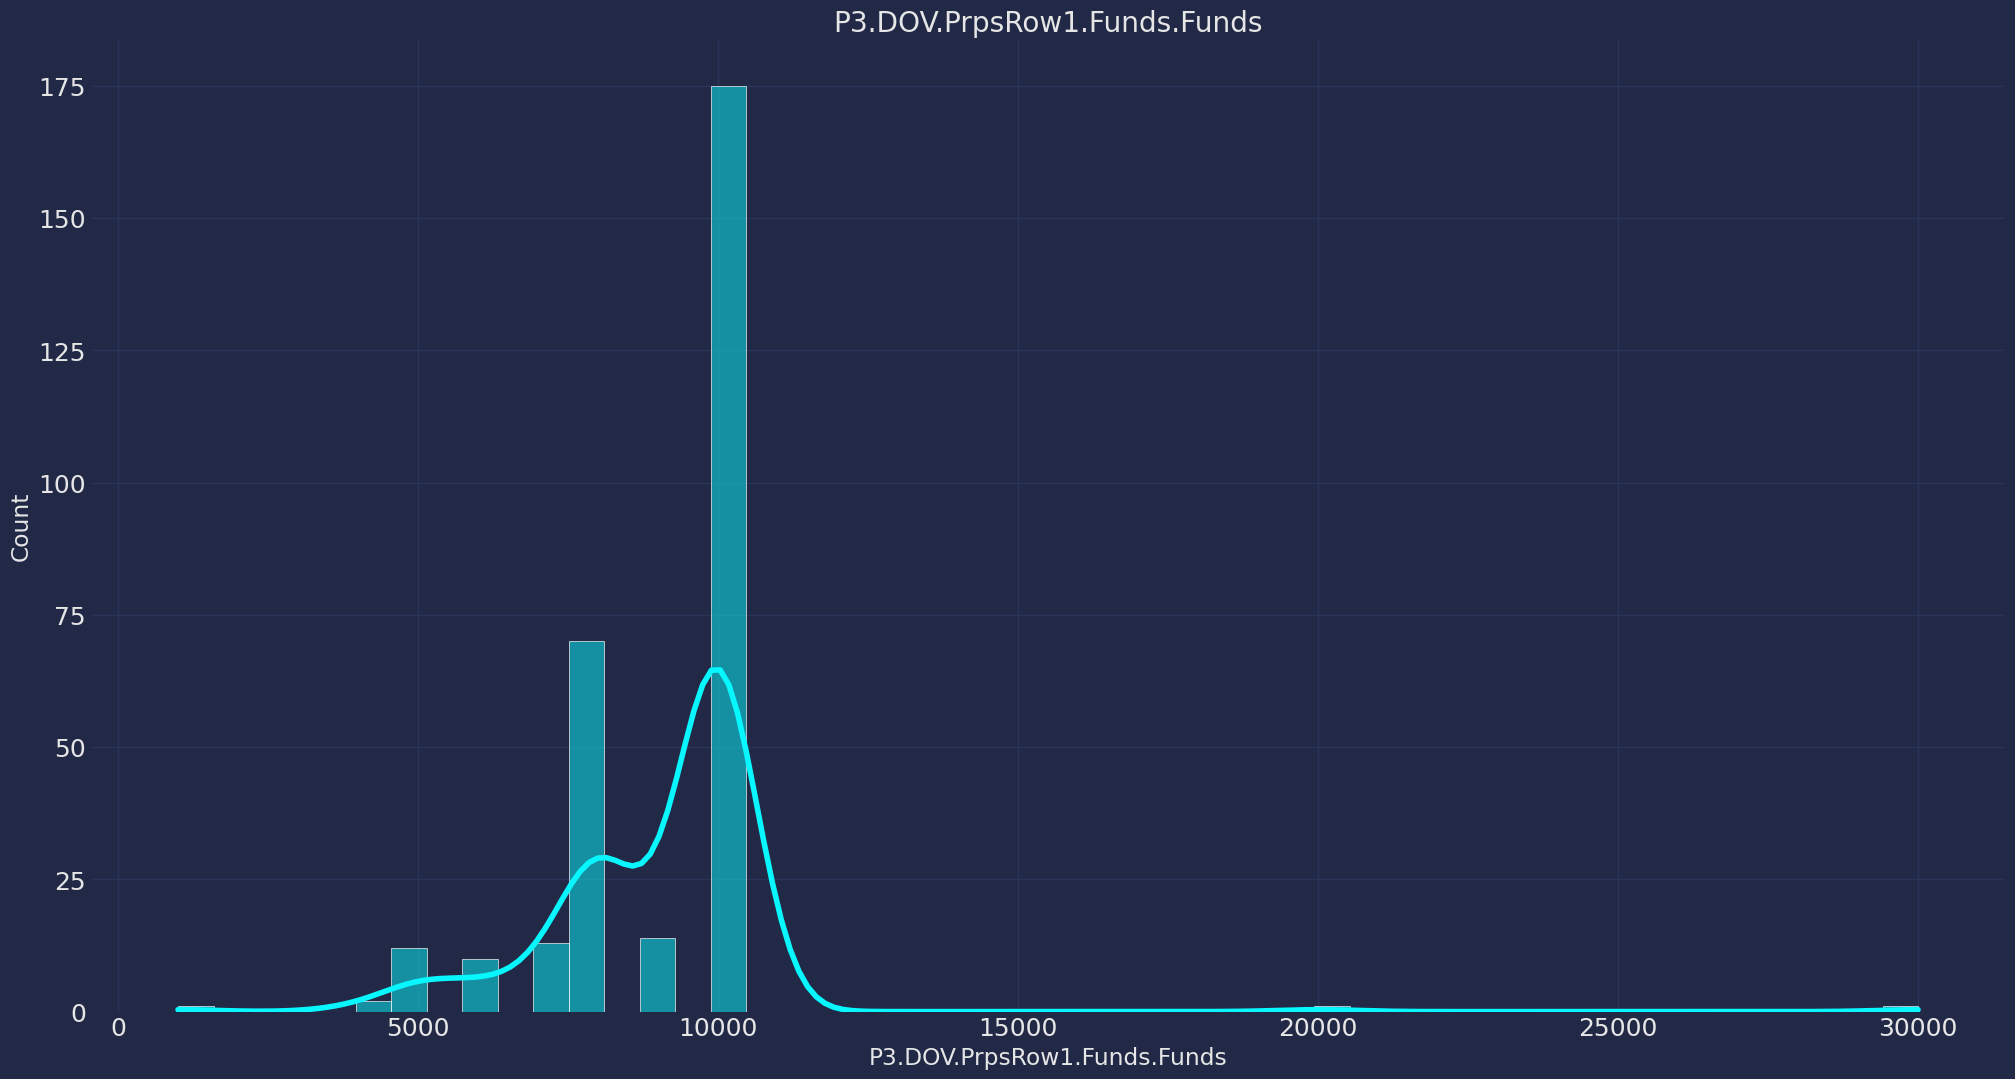

In [127]:
#nb>
display(data[feature_name].describe())

f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.histplot(data[feature_name], ax=ax, kde=True)
ax.set_title('{}'.format(feature_name))
plt.show()

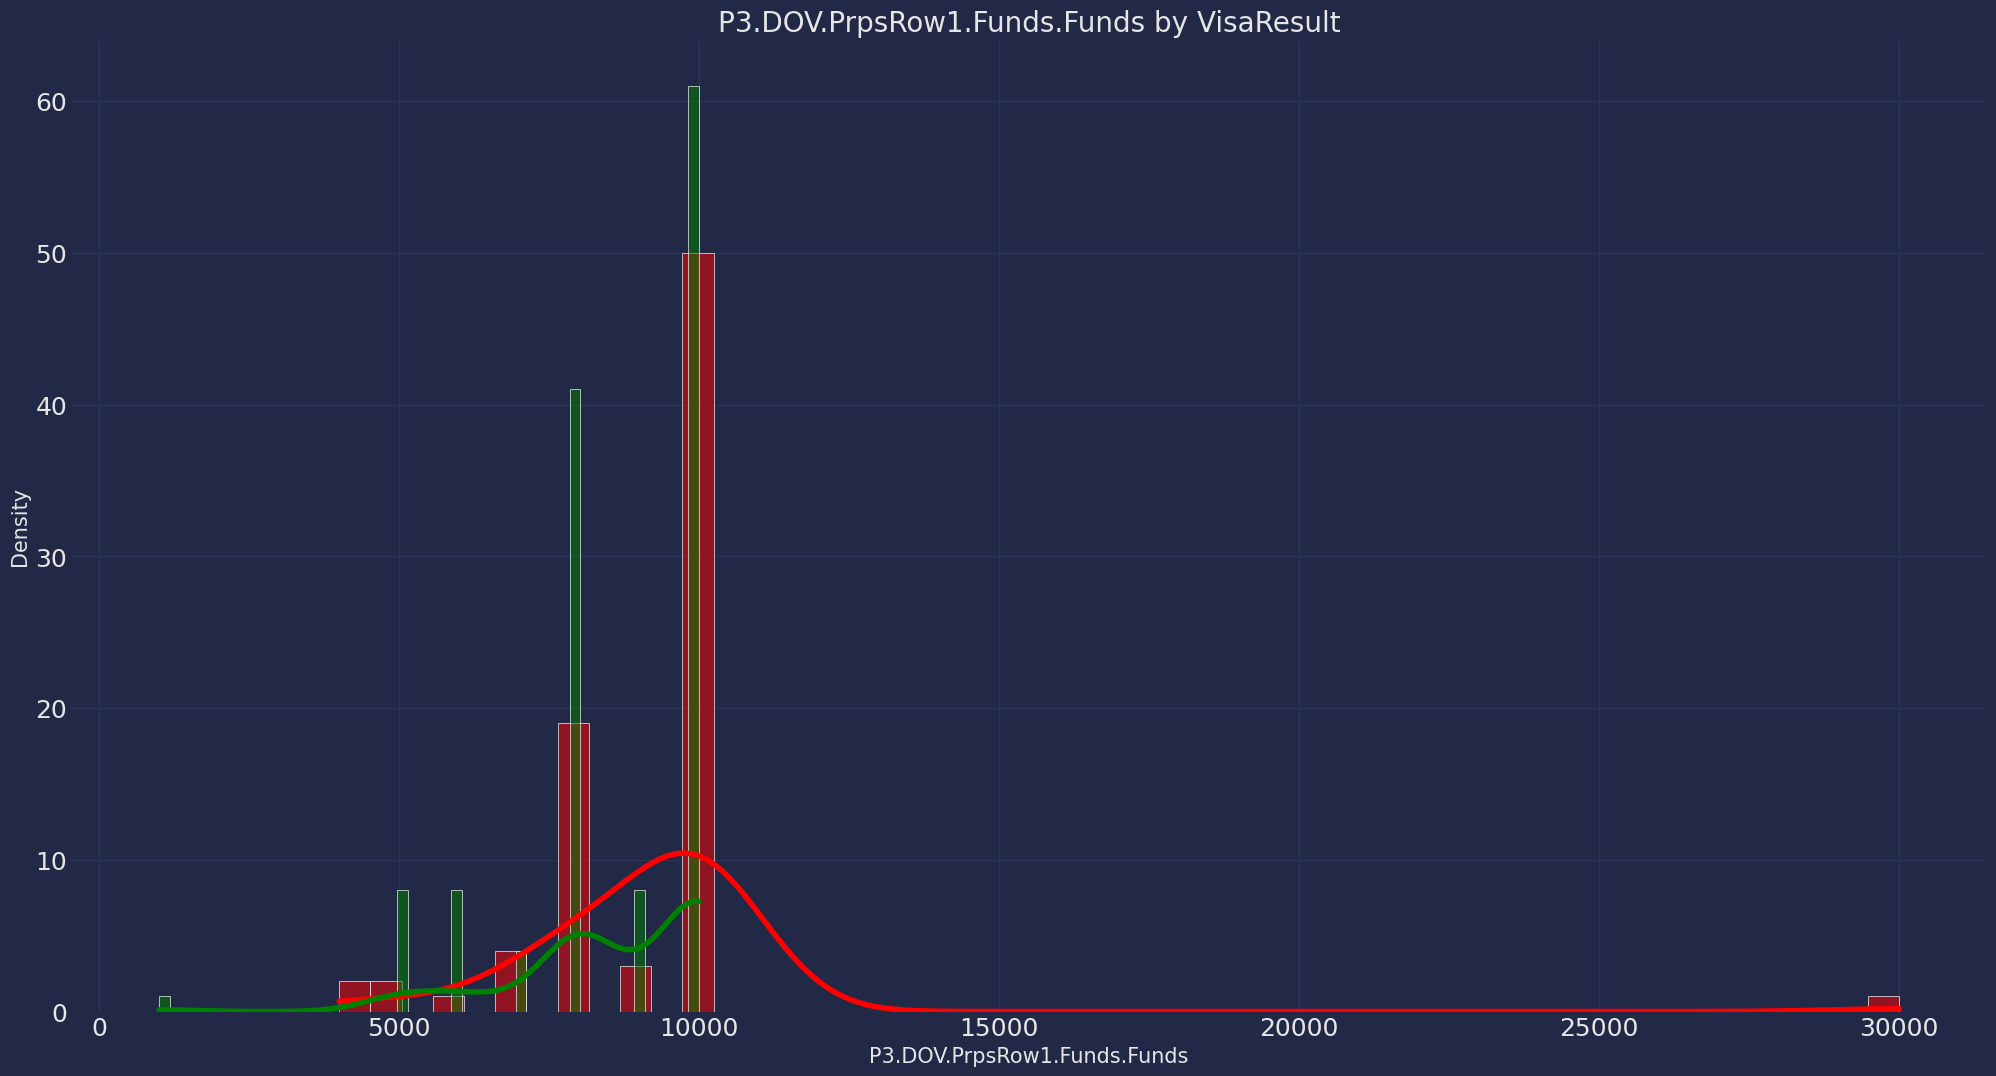

In [128]:
#nb>
plt.figure(figsize=(22, 12))

sns.histplot(data[data[output_name] == 'acc'][feature_name],
             bins=50, color='r', kde=True)
sns.histplot(data[data[output_name] == 'rej'][feature_name],
             bins=50, color='g', kde=True)
plt.title('{} by {}'.format(feature_name, output_name), fontsize=20)
plt.xlabel(feature_name, fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

### P3.DOV.cntcts_Row[i].RelationshipToMe.RelationshipToMe -> categorical

In [129]:
output_name = 'VisaResult'
feature_name = 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe', 'P3.cntcts_Row2.Relationship.RelationshipToMe'

In [130]:
display(data[feature_name[0]].unique())
display(data[feature_name[1]].unique())

array(['SON', 'OTHER', 'HOTEL', 'DAUGHTER', 'RELATIVE-FREIND', 'AUNT',
       'BROTHER', 'COUSIN', 'HOTE', 'sister', 'Hotel', 'SISTER',
       'CEO TOTAL ARM WRESTLING LEAGUE', 'sister in law', 'Aunt',
       'SON-DAUGHTER IN LAW', 'My First Cousin', 'PARENT AND SISTER',
       'BROTHER IN LAW', '1)SON-IN-LAW', 'FRIEND', 'CHILD', 'GRANDCHILD',
       'MOTHER', 'hotel', 'DAUGHTER-SON IN LAW', 'BROTHER-IN-LAW',
       'SISTER IN LAW-MY WIFE SISTER', 'Close Friend', 'STEP SON',
       'WIFE\\\\S AUNT', 'IFBB PRO LEAGUE', 'SISTER IN LAW', 'UNCLE',
       'Wife\\\\s Aunt', 'MY WIFE\\\\S COUSIN', 'CLOSE FRIEND',
       'My Wife\\\\s first cousin', 'NIECE', 'STEP BROHER',
       'WIFE\\\\S SISTER', 'INTERNATIONAL SYMPOSIUM OF SCULPTURE- HOTEL',
       'TWIN BROTHER', 'NEPHEW'], dtype=object)

array(['OTHER', 'HOTEL', 'COUSIN,S HUSBAND', 'Hotel', 'cousin',
       'My First Cousin\\\\s Husband/hotel', '2)DAUGHTER',
       'BROTHER-IN-LAW', 'FRIEND', 'hotel', 'SON IN LAW',
       'SPOUSE\\\\S SISTER\\\\S HUSBAND', 'Close Friend',
       'DAUGHTER IN LAW', 'COUSIN', '2)HOTEL 3)CLOSE FRIEND',
       'SON IN LOW', 'WIFE\\\\S COUSIN', 'SISTER IN LAW', 'SISTER',
       'The Husband of My Wife\\\\s first cousin/hotel', 'Cousin'],
      dtype=object)

We need to categorize these into simpler and representative categories:
1. `['brother', 'sister', 'step*', ...]: 'f1'` 
2. `['*in law*', 'nephew']: 'f2'`
3.  `'*friend*': 'friend'`


Issues:
1. Should we put `'hotel'` first or `'cousin'` in `'The Husband of My Wife\\\\s first cousin/hotel'`?  TODO: ask agents which one has higher priority

In [131]:
rel_cat = {  # order matters, put weaker on top, i.e. put 'law' above 'brother', so 'brother in law' get handled by 'law' rule than 'bother' rule
    'law': 'f2',
    'nephew': 'f2',
    'niece': 'f2',
    'aunt': 'f2',
    'uncle': 'f2',
    'cousin': 'f2',
    'relative': 'f2',
    'grand': 'f2',
    'parent': 'f1',
    'mother': 'f1',
    'father': 'f1',
    'child': 'f1',
    'daughter': 'f1',
    'brother': 'f1',
    'sister': 'f1',
    'wife': 'f1',
    'husband': 'f1',
    'step': 'f1',
    'son': 'f1',
    'partner': 'f1',
    'fiance': 'f1',
    'fiancee': 'f1',
    'other': 'ukn',
    'friend': 'friend',
    'league': 'work',
    'symposium': 'work',
    'hote': 'hotel',
    'hotel': 'hotel',
}


def fix_rel(string: str, dic: dict):
    string = string.lower()
    for k, v in dic.items():
        if k in string:
            string = string.replace(string, v)
            return string
    return 'ukn'


data[feature_name[0]] = data[feature_name[0]].apply(fix_rel, args=(rel_cat, ))
data[feature_name[1]] = data[feature_name[1]].apply(fix_rel, args=(rel_cat, ))

In [132]:
display(data[feature_name[0]].unique())
display(data[feature_name[1]].unique())

array(['f1', 'ukn', 'hotel', 'f2', 'work', 'friend'], dtype=object)

array(['ukn', 'hotel', 'f2', 'f1', 'friend'], dtype=object)

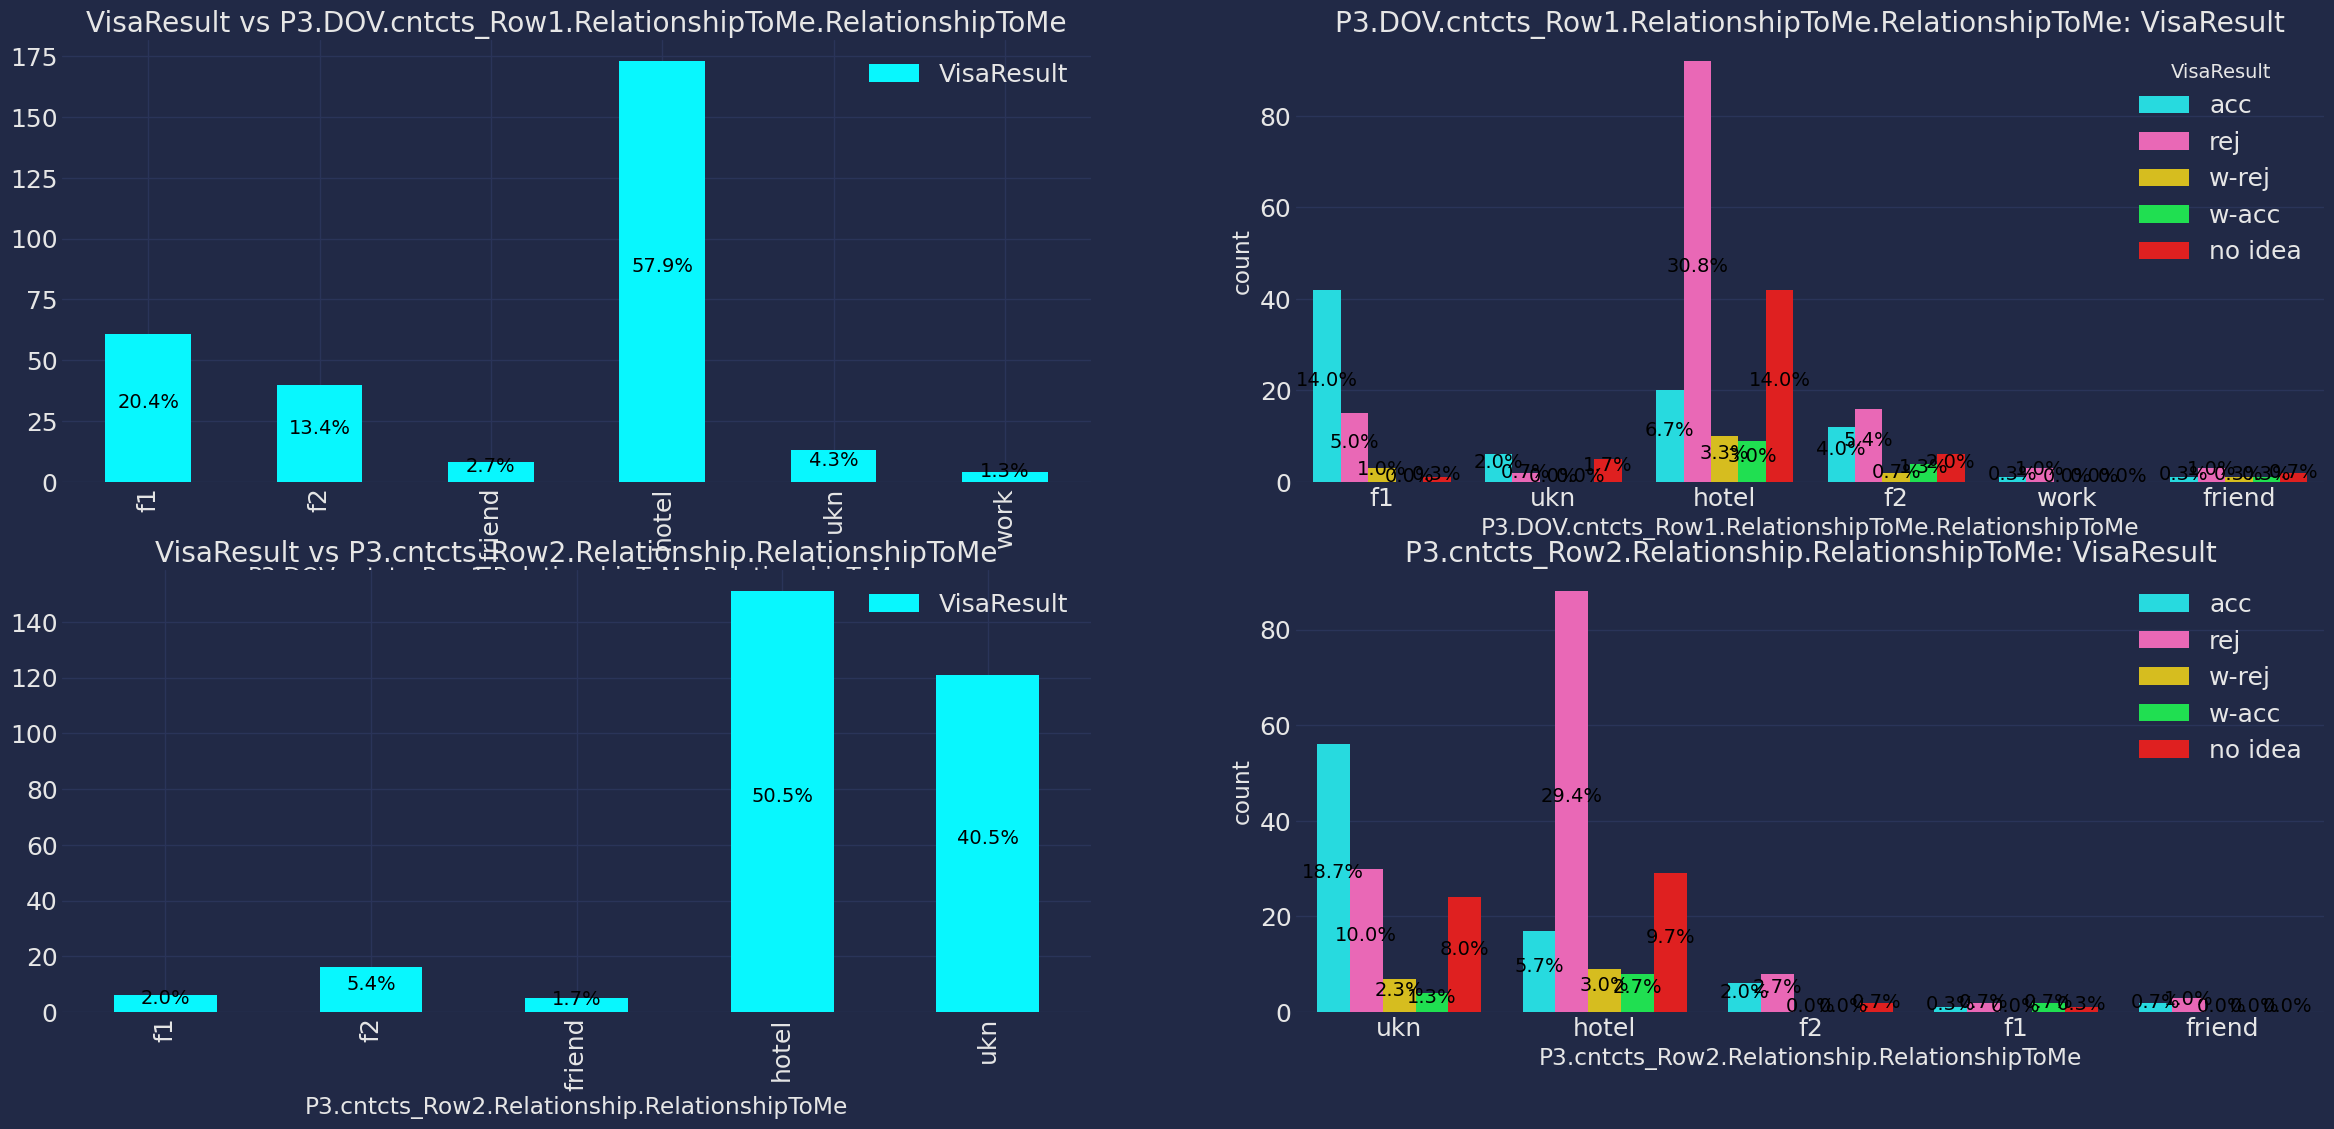

In [133]:
#nb>
f, ax = plt.subplots(2, 2, figsize=(26, 12))
data[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[0, 0], sort_columns=True)
add_percentage_axes(ax[0, 0], len(data))
ax[0, 0].set_title('{} vs {}'.format(output_name, feature_name[0]))
sns.countplot(x=feature_name[0], hue=output_name, data=data,
              ax=ax[0, 1], hue_order=output_hue_order)
add_percentage_axes(ax[0, 1], len(data))
ax[0, 1].set_title('{}: {}'.format(feature_name[0], output_name))

data[[feature_name[1], output_name]].groupby(
    [feature_name[1]]).count().plot.bar(ax=ax[1, 0], sort_columns=True)
add_percentage_axes(ax[1, 0], len(data))
ax[1, 0].set_title('{} vs {}'.format(output_name, feature_name[1]))
sns.countplot(x=feature_name[1], hue=output_name, data=data,
              ax=ax[1, 1], hue_order=output_hue_order)
add_percentage_axes(ax[1, 1], len(data))
ax[1, 1].set_title('{}: {}'.format(feature_name[1], output_name))
ax[1, 1].legend(loc='upper right')
plt.show()

### P3.Edu.EduIndicator -> categorical

In [127]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.EduIndicator'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.Edu.EduIndicator  VisaResult
False                acc           29
                     no idea       14
                     rej           42
                     w-acc          7
                     w-rej          5
True                 acc           53
                     no idea       42
                     rej           89
                     w-acc          7
                     w-rej         11
Name: VisaResult, dtype: int64

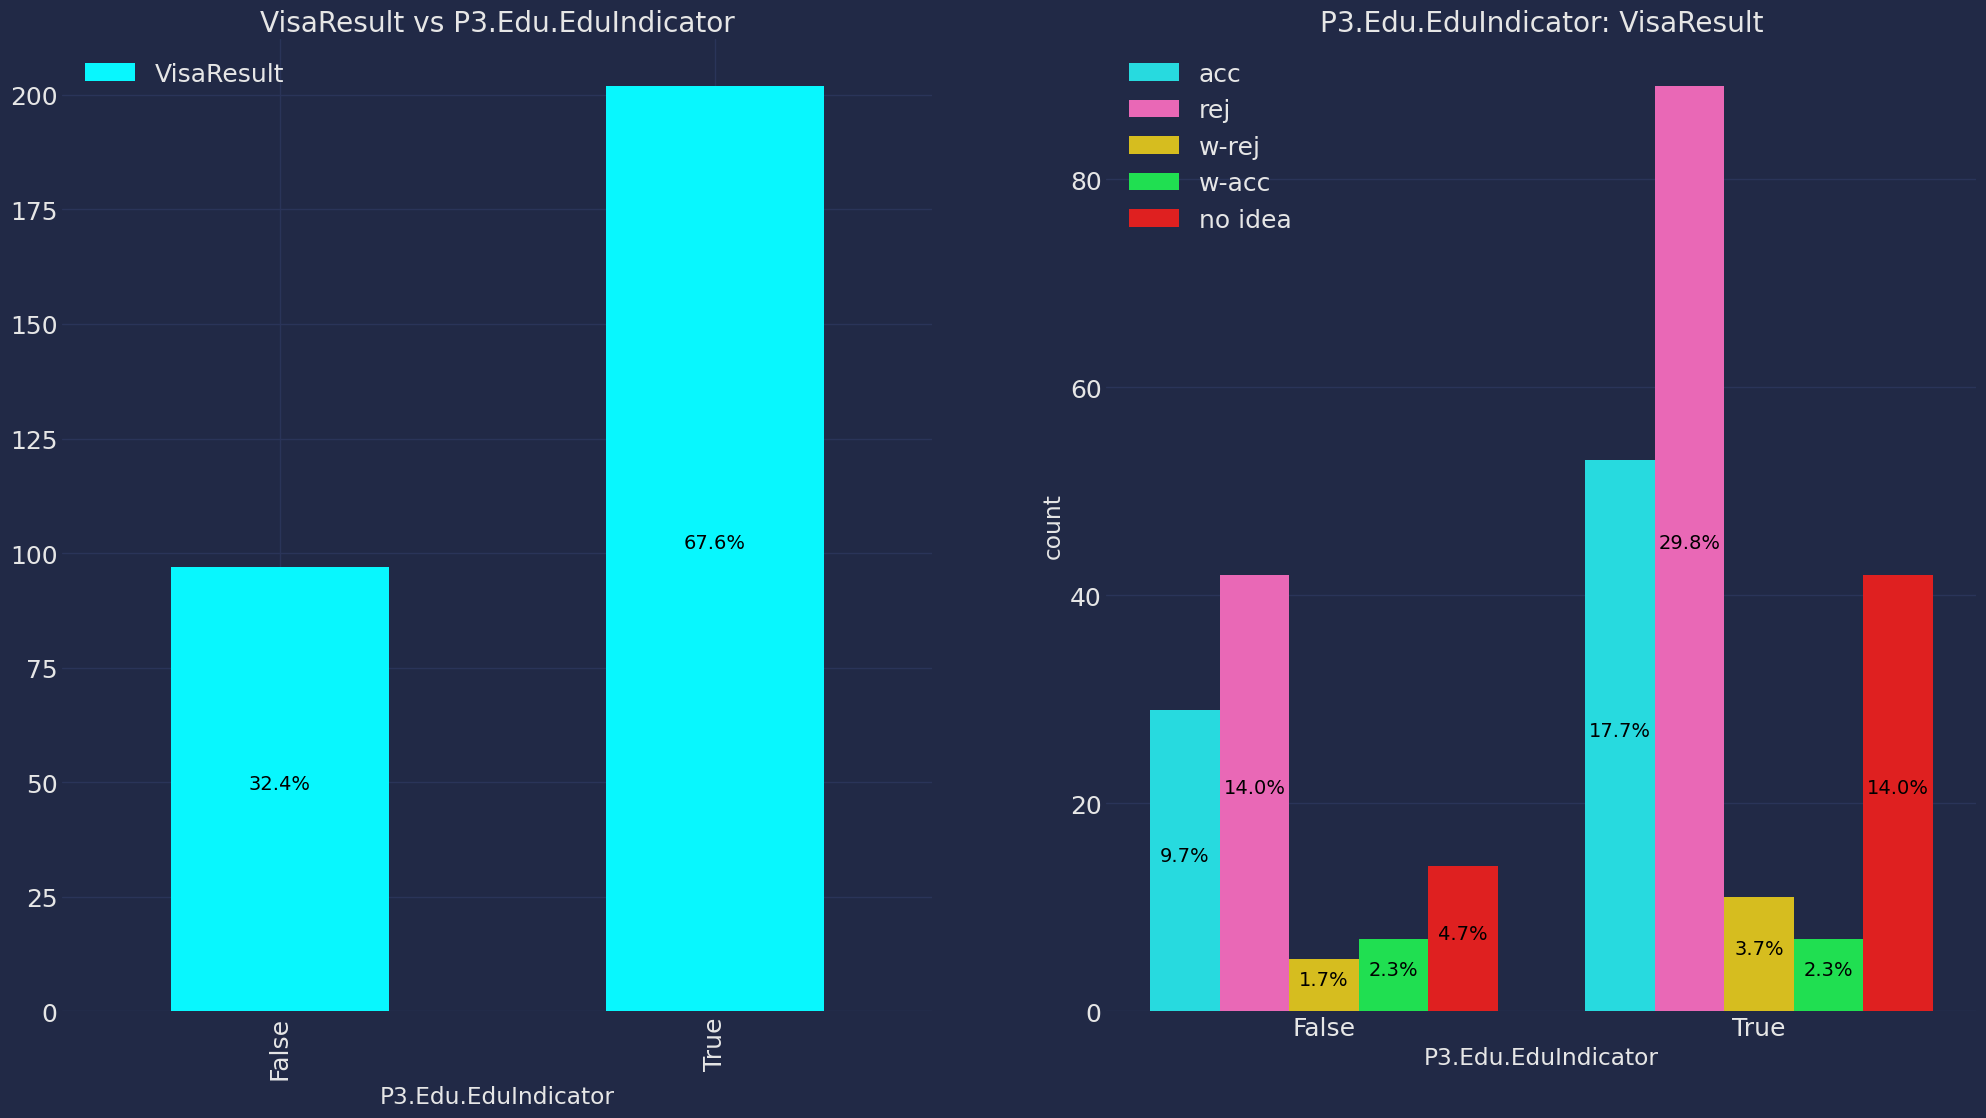

In [128]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(x=feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper left')
plt.show()

It seems that around %40 of people without education got accepted but %37.5 of people with education got accepted. These percentages are close and other factors such as age might have greater effect.

Also, I think the education field has way more effect than just having higher education. Of course we prefer a engineer/medic refugee than some pleb that going to consume more than provide.

TODO: somehow categorize education level/field into an ordered list, then show the acceptance rate given the education level/field.

### P3.Edu.Edu_Row1.Country.Country -> categorical -> continuous

In [129]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.Country.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.Edu.Edu_Row1.Country.Country  VisaResult
028                              acc             2
                                 rej             1
059                              rej             1
242                              acc             1
280                              acc             1
IRAN                             acc            78
                                 no idea        56
                                 rej           129
                                 w-acc          14
                                 w-rej          16
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for education fields, and take average of countries score over past years. Here, we utilize those methods.

In [130]:
# drop useless
feature_name = 'P3.Edu.Edu_Row1.Country.Country'
data.drop(feature_name, axis=1, inplace=True)

Also, education period does not add much value, as the education field of study can contain enough information about the education. For instance, from degree, we can guess the years of education.

Nonetheless, I currently keep it.

In [136]:
# convert days to years by dividing to 365.
feature_name = 'P3.Edu.Edu_Row1.Period'
data[feature_name] = 1 / 365.0 * data[feature_name]

Given that indication of education is also implicitly (yet easily) can be inferred from the education period, country, degree and so on. So it can be deleted.

In [131]:
# drop useless
feature_name = 'P3.Edu.EduIndicator'
data.drop(feature_name, axis=1, inplace=True)

In [137]:
#nb>
data.sample(1, random_state=SEED)

P1.PD.Sex.Sex P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status P1.MS.SecA.MS  \
145        Female                 TURKEY                    3.0        single   

    P2.MS.SecA.PrevMarrIndicator P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  \
145                        False                                 tourism   

     P3.DOV.PrpsRow1.Funds.Funds  \
145                      10000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
145                                              hotel     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.Edu_Row1.FieldOfStudy  \
145                                        hotel            MEDICAL CHEMISTRY   

    P3.Occ.OccRow1.Occ.Occ P3.Occ.OccRow1.Country.Country  \
145                student                           IRAN   

    P3.Occ.OccRow2.Occ.Occ P3.Occ.OccRow2.Country.Country  \
145                  OTHER                           IRAN   

    P3.Occ.OccRow3.Occ.Occ P3.Occ.OccRow3.Country.Country  \
145                  OTHER                           IRAN   

    P3.BGI.Details.MedicalDetails P3.BGI.otherThanMedic P3.noAuthStay  \
145                         False                 False         False   

    P3.refuseDeport P3.BGI2.PrevApply P3.PWrapper.criminalRec  \
145           False             False                   False   

    P3.PWrapper.Military.Choice P3.PWrapper.politicViol  \
145                       False                   False   

    P3.PWrapper.witnessIllTreat  P1.PD.CurrCOR.Row2.Period  \
145                       False                    10377.0   

     P1.PD.DOBYear.Period  P1.PD.PrevCOR.Row2.Period  \
145               10377.0                        0.0   

     P1.PD.PrevCOR.Row3.Period  P1.PD.CWA.Row2.Period  \
145                        0.0                   30.0   

     P1.MS.SecA.DateOfMarr.Period  P2.MS.SecA.PrevSpouseDOB.DOBYear.Period  \
145                           0.0                                      0.0   

     P2.MS.SecA.Period  P2.MS.SecA.Psprt.ExpiryDate.Remaining  \
145                0.0                                 1702.0   

     P3.DOV.PrpsRow1.HLS.Period  P3.Edu.Edu_Row1.Period  \
145                        16.0                     2.0   

     P3.Occ.OccRow1.Period  P3.Occ.OccRow2.Period  P3.Occ.OccRow3.Period  \
145                 1611.0                    0.0                    0.0   

     p1.Subform1.Visitor  p1.Subform1.Worker  p1.Subform1.Student  \
145                  1.0                 0.0                  0.0   

     p1.Subform1.Other                                p1.SecA.App.AppAddr  \
145                0.0  UNIT 4-NO.10-NEXT TO REZA ALLEY-ASGARIAN ST-FA...   

     p1.SecA.App.ChdMStatus p1.SecA.Sps.SpsCOB p1.SecA.Sps.SpsAddr  \
145                     7.0               IRAN                None   

    p1.SecA.Sps.SpsOcc p1.SecA.Sps.SpsAccomp p1.SecA.Mo.MoCOB  \
145              OTHER                 False             IRAN   

                                     p1.SecA.Mo.MoAddr p1.SecA.Mo.MoOcc  \
145  UNIT 4-NO.10-NEXT TO REZA ALLEY-ASGARIAN ST-FA...        HOUSEWIFE   

    p1.SecA.Mo.MoAccomp  p1.SecA.Mo.ChdMStatus p1.SecA.Fa.FaCOB  \
145                True                    5.0             IRAN   

                                     p1.SecA.Fa.FaAddr p1.SecA.Fa.FaOcc  \
145  UNIT 4-NO.10-NEXT TO REZA ALLEY-ASGARIAN ST-FA...          RETIRED   

    p1.SecA.Fa.FaAccomp  p1.SecA.Fa.ChdMStatus  p1.SecB.Chd.[0].ChdMStatus  \
145                True                    5.0                         9.0   

    p1.SecB.Chd.[0].ChdRel p1.SecB.Chd.[0].ChdCOB p1.SecB.Chd.[0].ChdAddr  \
145                  OTHER                   IRAN                    None   

    p1.SecB.Chd.[0].ChdOcc p1.SecB.Chd.[0].ChdAccomp  \
145                  OTHER                     False   

     p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel p1.SecB.Chd.[1].ChdCOB  \
145                         9.0                  OTHER                   IRAN   

    p1.SecB.Chd.[1].ChdAddr p1.SecB.Chd.[1].ChdOcc p1.SecB.Ch

### P3.Edu.Edu_Row1.FieldOfStudy -> categorical/ordered/continuous

TODO: can we do continuous here?


There are different ways again to deal with this, ranking, continuous, etc.

Here are the methods:
1. **Ranking** only based on the higher education level, i.e. `[apprentices=1, worker diploma=2, bachelor=3, master=5, phd=8`]. (we entirely ignore the field actually, just level of education). ([ref](https://www.canada.ca/en/immigration-refugees-citizenship/services/application/application-forms-guides/guide-5256-applying-visitor-visa-temporary-resident-visa.html)) **<-- CURRENT IMPL.**
2. *manually* ranking field of study and multiply it by method (1); i.e. `new = result1 * result2`


***Remark: This section assumes applicants' highest post secondary education**. I.e. if you have a bachelor and masters, you have to put masters and its period which is 2 years rather than 6 years (4 years of bachelor and 2 years of masters)*

In [138]:
from enum import Enum
class field_of_study_rank(Enum):
    apprentice = 1  # 1*1 = 1
    diploma = 2  # 2*2 = 4
    bachelor = 3  # 3*4 = 12
    master = 8  # 8*2 = 16
    phd = 10  # 10*3 = 30

In [139]:
output_name = 'VisaResult'
feature_name = 'P3.Edu.Edu_Row1.FieldOfStudy', 'P3.Edu.Edu_Row1.Period', 'P3.Occ.OccRow1.Occ.Occ'

#### `'P3.Edu.Edu_Row1.Period' > 8`

In [141]:
cond = (data[feature_name[1]] >= 8) & (data[feature_name[1]] <= 99)
display(data.loc[cond, feature_name[0]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'phd')
display(data.loc[cond, feature_name[0]])

4      phd
21     phd
49     phd
76     phd
85     phd
93     phd
126    phd
274    phd
289    phd
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

4      phd
21     phd
49     phd
76     phd
85     phd
93     phd
126    phd
274    phd
289    phd
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### `7 <= 'P3.Edu.Edu_Row1.Period' < 8`

In [142]:
cond = (data[feature_name[1]] >= 7) & (data[feature_name[1]] < 8)
display(data.loc[cond, feature_name[0]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'phd' if 'med' in x.lower() else 'master')
display(data.loc[cond, feature_name[0]])

72                          SEAFARING
83                           MEDICINE
172    MEDICAL LABORATORY TECHNOLOGIS
231                          MEDICINE
239                       ELECTRONICS
290                        ACCOUNTING
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

72     master
83        phd
172       phd
231       phd
239    master
290    master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### `6 <= 'P3.Edu.Edu_Row1.Period' < 7`

In [143]:
cond = (data[feature_name[1]] >= 6) & (data[feature_name[1]] < 7)
display(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'master')
display(data.loc[cond, feature_name[0]])

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
26           ELECTONIC ENGINEERING                6.005479
48                        PHARMACY                6.002740
100            ENGLISH TRANSLATION                6.005479
109       AGRICULTURAL ENGINEERING                6.005479
114                       MECHANIC                6.005479
130                       COMPUTER                6.002740
150                       COMPUTER                6.002740
154                        BIOLOGY                6.005479
168       AGRICULTURAL ENGINEERING                6.002740
184            TEXTILE ENGINEERING                6.005479
194                       MEDICINE                6.410959
210                     ACCOUNTING                6.005479
216             MINING ENGINEERING                6.002740
236  Master Degree in Mechatronics                6.005479
240              CIVIL ENGINEERING                6.002740

26     master
48     master
100    master
109    master
114    master
130    master
150    master
154    master
168    master
184    master
194    master
210    master
216    master
236    master
240    master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### `3.5 <= 'P3.Edu.Edu_Row1.Period' < 6`

In [144]:
cond = (data[feature_name[1]] >= 3.5) & (data[feature_name[1]] < 6)
display(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'bachelor')
display(data.loc[cond, feature_name[0]])

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
3                     Accounting                 5.00274
12                      ECONMICS                 4.00274
31                       WELDING                 5.00274
32               SOCIAL SCIENCES                 4.00274
34                    ACCOUNTING                 4.00274
..                           ...                     ...
288            HANDICRAFTS FIELD                 4.00274
291     ARCHITECTURE ENGINEERING                 5.00274
295       MECHANICAL ENGINEERING                 5.00274
297                    DENTISTRY                 5.00274
303            CIVIL ENGINEERING                 4.00274

[80 rows x 2 columns]

3      bachelor
12     bachelor
31     bachelor
32     bachelor
34     bachelor
         ...   
288    bachelor
291    bachelor
295    bachelor
297    bachelor
303    bachelor
Name: P3.Edu.Edu_Row1.FieldOfStudy, Length: 80, dtype: string

#### `3 <= 'P3.Edu.Edu_Row1.Period' < 3.5`

In [145]:
cond = (data[feature_name[1]] >= 3) & (data[feature_name[1]] < 3.5)
display(data.loc[cond, feature_name[0:2]])
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'master')
display(data.loc[cond, feature_name[0]])

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
1                       TV PRODUCER                 3.00274
7                 CHEMICAL ENGINEER                 3.00274
8                          MECHANIC                 3.00000
9                 BUISINESS MANAGER                 3.00274
22               Traffic Management                 3.00274
25                CIVIL ENGINEERING                 3.00274
28                     MICROBIOLOGY                 3.00274
45     ARCHITECTURE TECHNOLOGY ENG.                 3.00000
52                         GRAPHICS                 3.00274
58                COMPUTER-SOFTWARE                 3.00000
63                     ARCHITECTURE                 3.00274
64                        MIDWIFERY                 3.00274
68                        NUTRITION                 3.00274
74             Computer Engineering                 3.00000
107       Safety and Inspection eng                 3.00274
113  ITC-INFORMATION AND COMMUNICAT                 3.00000
116                     ARCHTECTURE                 3.00274
120                      JOURNALISM                 3.00274
137                        COMPUTER                 3.00274
143             ENGLISH TRANSLATION                 3.00274
155                  OPERATING ROOM                 3.00274
156                      Accounting                 3.00274
162           THEORETICAL ECONOMICS                 3.00000
163             THEOLOGY AND ARABIC                 3.00274
171               SOFTWARE-COMPUTER                 3.00274
191    COMMERCIAL MANAGEMENT,MASTER                 3.00000
214        ARCHITECTURE ENGINEERING                 3.00274
215                             MBA                 3.00274
226                      ACCOUNTING                 3.00274
230                       ECONOMICS                 3.00274
244                             MBI                 3.00274
254               CHEMICAL ENGINEER                 3.00274
275                URBAN MANAGEMENT                 3.00274
278            COMPUTER ENGINEERING                 3.00000
298              Emergency Medicine                 3.00000
299          ELECTRICAL ENGINEERING                 3.00274
301                      ACCOUNTING                 3.00000

1      master
7      master
8      master
9      master
22     master
25     master
28     master
45     master
52     master
58     master
63     master
64     master
68     master
74     master
107    master
113    master
116    master
120    master
137    master
143    master
155    master
156    master
162    master
163    master
171    master
191    master
214    master
215    master
226    master
230    master
244    master
254    master
275    master
278    master
298    master
299    master
301    master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### `2 <= 'P3.Edu.Edu_Row1.Period' < 3`

In [146]:
cond = (data[feature_name[1]] >= 2) & (data[feature_name[1]] < 3)
display(data.loc[cond, feature_name[0:2]])

def field_of_study_converter(x: str) -> str:
    _keys = ['logy', 'eng', 'manag', 'mb', 'med', 'sci', 'adm', 'law', 'physic', ]
    val = 'diploma'
    for k in _keys:
        if k in x.lower():
            val = 'master'
    return val

data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(field_of_study_converter)
display(data.loc[cond, feature_name[0]])

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
13                PRIMARY EDUCATION                2.000000
16             FINANCIAL MANAGEMENT                2.002740
20                       ACCOUNTING                2.002740
24    Supplementary topics of civil                2.002740
33                        ELECTONIC                2.002740
35                    MECHANICA ENG                2.000000
41                             EMBA                2.986301
42                     Horticulture                2.002740
61              TEXTILE ENGINEERING                2.002740
62                          STUDENT                2.030137
69             CONTINUING EDUCATION                2.002740
86              ASSOCIAE ANESTHESIA                2.002740
108                    Horticulture                2.002740
112                         PHYSICS                2.002740
132          ELECTRONIC ENGINEERING                2.000000
135                    IT MANAGMENT                2.002740
138                      ACCOUNTING                2.002740
145               MEDICAL CHEMISTRY                2.000000
167           CARDIOLOGY FELLOWSHIP                2.000000
179                    MICROBIOLOGY                2.000000
186                             LAW                2.002740
189       METALLURGICAL ENGINEERING                2.002740
196     CULTURAL AFFAIRS MANAGEMENT                2.000000
209           INTERIOR ARCHITECTURE                2.383562
225       Architectural Engineering                2.526027
229             LABAROTARY SCIENCES                2.000000
234             BUSINESS MANAGEMENT                2.002740
235          INDUSTRIAL ENGINEERING                2.002740
241                PUBLIC RELATIONS                2.002740
250                  TECHNOLOGY ENG                2.000000
264               SPORTS MANAGEMENT                2.000000
270         BUSINESS ADMINISTRATION                2.002740
276                         ENGLISH                2.000000
277                        SOFTWARE                2.000000
282                    RHEUMATOLOGY                2.002740
283     CULTURAL AFFAIRS MANAGEMENT                2.000000
285  Ancient cultures and languages                2.000000
300                    ANTHROPOLOGY                2.000000

13     diploma
16      master
20     diploma
24     diploma
33     diploma
35      master
41      master
42     diploma
61      master
62     diploma
69     diploma
86     diploma
108    diploma
112     master
132     master
135     master
138    diploma
145     master
167     master
179     master
186     master
189     master
196     master
209    diploma
225     master
229     master
234     master
235     master
241    diploma
250     master
264     master
270     master
276     master
277    diploma
282     master
283     master
285    diploma
300     master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### `0 < 'P3.Edu.Edu_Row1.Period' < 2`

In [147]:
cond = (data[feature_name[1]] > 0) & (data[feature_name[1]] < 2)
display(data.loc[cond, feature_name[0:2]])
def field_of_study_converter(x: str) -> str:
    _keys = ['mba', 'admin', 'med', 'scien']
    val = 'apprentice'
    for k in _keys:
        if k in x.lower():
            val = 'master'
    return val

data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(field_of_study_converter)
display(data.loc[cond, feature_name[0]])

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period
5                           HISTORY                1.002740
19   DOCTORATE OF BUSINESS ADMINIST                1.000000
70              BUSINESS MANAGEMENT                1.868493
81                              phd                0.252055
99                  FOOD INDUSTRIES                1.002740
103                 MEDICAL STUDENT                1.101370
153    english language translation                0.975342
160                      ELECTRONIC                1.421918
176             LABORATORY SCIENCES                1.000000
180                             MBA                1.000000
205            DENTAL BIO MATERIALS                0.567123
207          ADMINISTRATION MANAGER                1.000000
221                ENGLISH TEACHING                1.000000
223                      ACCOUNTING                1.000000
287                            DVME                0.454795
294                HOTEL MANAGEMENT                0.430137
296                            EMBA                1.000000

5      apprentice
19         master
70     apprentice
81     apprentice
99     apprentice
103        master
153    apprentice
160    apprentice
176        master
180        master
205    apprentice
207        master
221    apprentice
223    apprentice
287    apprentice
294    apprentice
296        master
Name: P3.Edu.Edu_Row1.FieldOfStudy, dtype: string

#### Missed and Uneducated

1. **uneducated**: Those who do not have field of study and have zero education period
2. **missed**: Those who have > 0 education period but no field of study

In [148]:
display(f'{len(data[(data[feature_name[0]].isna())])} cases with missing field of study')
display(f'{data[(data[feature_name[0]].isna()) & (data[feature_name[1]] == 0.)][[*feature_name]].__len__()} case are uneducated.')

'97 cases with missing field of study'

'97 case are uneducated.'

In [149]:
display(data[(data[feature_name[0]].isna()) & (data[feature_name[1]] == 0.)][[*feature_name]].sample(10, random_state=SEED))

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period  \
46                          <NA>                     0.0   
50                          <NA>                     0.0   
159                         <NA>                     0.0   
146                         <NA>                     0.0   
29                          <NA>                     0.0   
105                         <NA>                     0.0   
181                         <NA>                     0.0   
111                         <NA>                     0.0   
202                         <NA>                     0.0   
304                         <NA>                     0.0   

                                P3.Occ.OccRow1.Occ.Occ  
46                                           HOUSEWIFE  
50                                   REAL ESTATE OWNER  
159                                          HOUSEWIFE  
146                                AUTOMOBILE MECHANIC  
29   Haberdashery, Corrective Lenses and Sunglasses...  
105                                  FINANCIAL MANAGER  
181                                          HOUSEWIFE  
111                                       CONSTRUCTION  
202                BUSINESS LICENSE OWNER/FISH FARMING  
304              EXECUTIVE MANAGER-MEMBER OF THE BOARD

Fill all **uneducated**'s field of study with with `'unedu'` just for readability purposes.

In [150]:
cond = (data[feature_name[0]].isna()) & (data[feature_name[1]] == 0.)
data.loc[cond, feature_name[0]] = data.loc[cond, feature_name[0]].apply(lambda x: 'unedu')

In [151]:
display(data[(data[feature_name[1]] == 0.)][[*feature_name]].sample(10, random_state=SEED))

P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Period  \
46                         unedu                     0.0   
50                         unedu                     0.0   
159                        unedu                     0.0   
146                        unedu                     0.0   
29                         unedu                     0.0   
105                        unedu                     0.0   
181                        unedu                     0.0   
111                        unedu                     0.0   
202                        unedu                     0.0   
304                        unedu                     0.0   

                                P3.Occ.OccRow1.Occ.Occ  
46                                           HOUSEWIFE  
50                                   REAL ESTATE OWNER  
159                                          HOUSEWIFE  
146                                AUTOMOBILE MECHANIC  
29   Haberdashery, Corrective Lenses and Sunglasses...  
105                                  FINANCIAL MANAGER  
181                                          HOUSEWIFE  
111                                       CONSTRUCTION  
202                BUSINESS LICENSE OWNER/FISH FARMING  
304              EXECUTIVE MANAGER-MEMBER OF THE BOARD

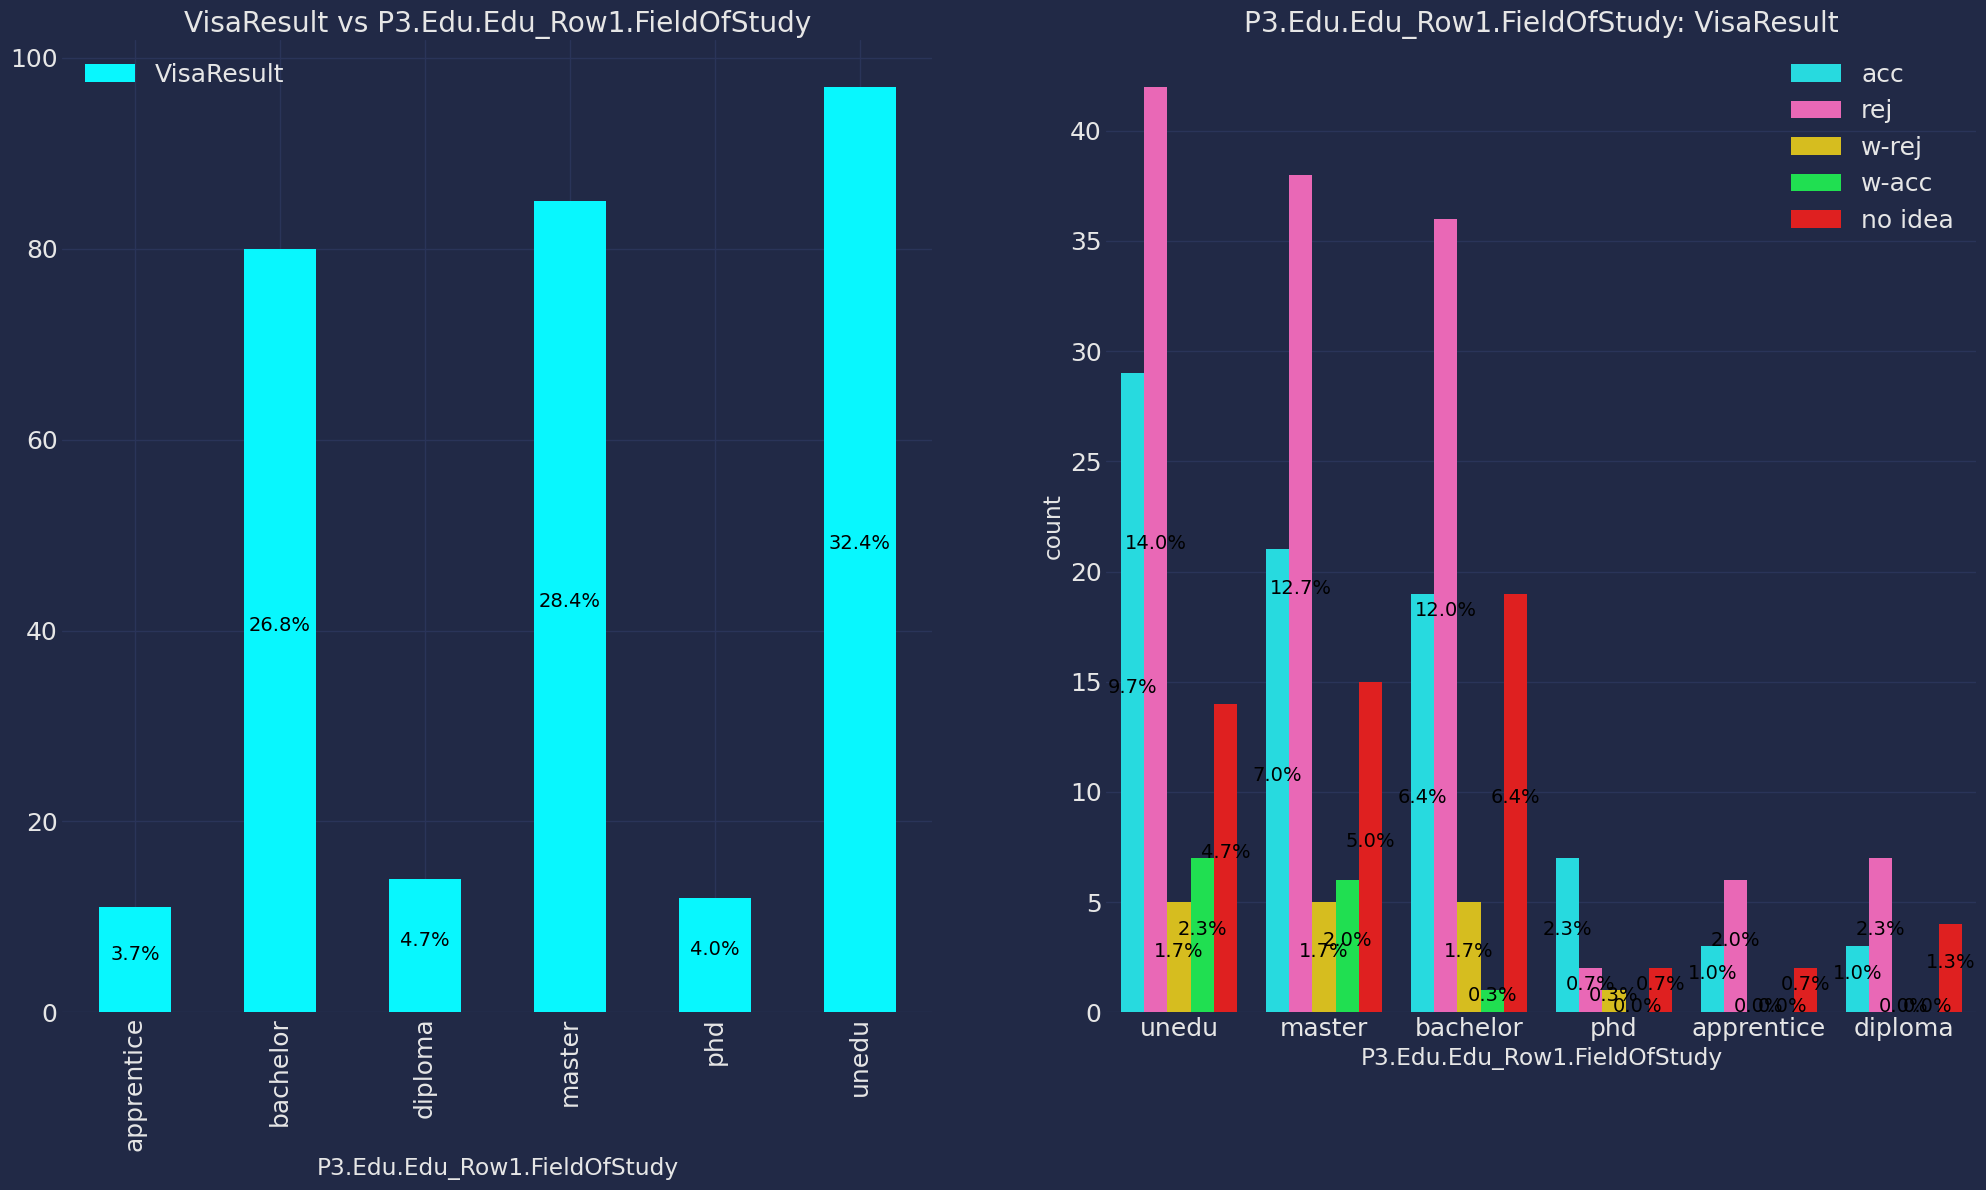

In [152]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name[0], output_name]].groupby(
    [feature_name[0]]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name[0]))
ax[1] = sns.countplot(x=feature_name[0], hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name[0], output_name))
ax[1].legend(loc='upper right')
plt.show()

Insights:
1. There is a slight positive rate towards `master` in comparison to `bachelor`.
2. `phd` (`phd` and `md`) dominates but having acceptance above 0.5.
3. `unedu` is almost representative of all cases, since almost majority of `unedu` are `housewife` cases and their husband's application is strongly affecting

TODO: for creating dataset, I have treated each member of the family as an separate application and I am supposed to only copy-paste `other.csv` part between members of the same family. But for cases when the *female's job is housewife*, features `P3.Edu` and `P3.Occ` need to be updated respectively. I.e. we should not have `housewife` case at all unless main applicant was `housewife` which sounds impossible. <span style="color: cyan"> #46 </span> 

### P3.Occ.OccRow[1,2,3].Occ.Occ -> categorical -> continuous

This is hard to deal with too, can we assign continuous values? can we rank and categorize into 5, 10 categories?

Categories that are considered and filled by keyword matching:
1. manager: `['manager', 'chair', 'business', 'direct', 'owner', 'share', 'board', 'head', 'ceo']`
2. specialist: `['eng', 'doc', 'med', 'arch', 'expert']`
3. employee: `['sale', 'employee', 'teacher', 'retail']` and anything else except `'OTHER'` (`'OTHER'` is used for `None` jobs)
4. retired: `['retire']`
5. student: `['student', 'intern']`
6. house wife: `['wife']`

In [153]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Occ.Occ', 'P3.Occ.OccRow2.Occ.Occ', 'P3.Occ.OccRow3.Occ.Occ'

In [154]:
unique_occ = np.array([]).astype('object')
for f in feature_name:
    unique_occ = np.concatenate([unique_occ, data[f].unique()])
display(unique_occ.__len__())
display(unique_occ[:10])

323

array(['PERSIAN/PICTURE CARPET WEAVER',
       'CHAIRMAN OF THE BOARD-ADVERTISING MANAGER-', 'MAKEUP ARTIST',
       'APPLICATION DEVELOPMENT MANAGER', 'GENERAL PRACTITIONER',
       'HOUSEWIFE', 'PETROCHEMICAL CO. ENGINEER',
       'PREPARING AND SUPERVISING FOR EXECUTING CONCRETING OPERATION',
       'SALES MANAGER', 'RETIRED'], dtype=object)

In [155]:
# order is important, e.g. `'student of computer engineering'` should be categorized as `'student'` not `'specialist'` (because of `'eng'`)
occ_cat_dict = {
    'manager': ['manager', 'chair', 'business', 'direct', 'owner', 'share', 'board', 'head', 'ceo'],
    'student': ['student', 'intern'],
    'retired': ['retire'],
    'specialist': ['eng', 'doc', 'med', 'arch', 'expert'],
    'employee': ['sale', 'employee', 'teacher', 'retail'],
    'housewife': ['wife'],
}


def categorize_occ(x: str, d: dict, default='employee') -> str:
    """if `x` found in any of `d.value`, return the corresponding `d.key`.

    Args:
        x (str): input string to search for
        d (dict): the dictionary to look for `x` in its values and return the key
        default (str, optional): if `x` no found in `d` at all. Defaults to 'employee'.
            except cases mentioned in `d` or `'OTHER'` 

    Returns:
        str: string containing a key in `d`
    """
    x = x.lower()

    # find occurrences
    for k in d.keys():
        d_vals = d[k]
        found = len([v for v in d_vals if v in x]) > 0
        if found:
            return k
    return default if x != 'other' else 'OTHER'


display(data.loc[:, [*feature_name]])  # old
data.loc[:, [*feature_name]] = data.loc[:, [*feature_name]].applymap(categorize_occ,
                                                                     d=occ_cat_dict,
                                                                     default='employee', )
display(data.loc[:, [*feature_name]])  # new

P3.Occ.OccRow1.Occ.Occ  P3.Occ.OccRow2.Occ.Occ  \
0                 PERSIAN/PICTURE CARPET WEAVER      DRIVING INSTRUCTOR   
1    CHAIRMAN OF THE BOARD-ADVERTISING MANAGER-  DIRECTOR OF TV PROGRAM   
2                                 MAKEUP ARTIST                   OTHER   
3               APPLICATION DEVELOPMENT MANAGER                   OTHER   
4                          GENERAL PRACTITIONER    GENERAL PRACTITIONER   
..                                          ...                     ...   
300                                   HOUSEWIFE                   OTHER   
301                            CAR SALES EXPERT                 MANAGER   
302                                     RETIRED                   OTHER   
303                                SALES EXPERT          civil engineer   
304       EXECUTIVE MANAGER-MEMBER OF THE BOARD                   OTHER   

           P3.Occ.OccRow3.Occ.Occ  
0    COSMETOLOGY AND HAIR STYLIST  
1                        PRODUCER  
2                           OTHER  
3                           OTHER  
4            GENERAL PRACTITIONER  
..                            ...  
300                         OTHER  
301        QUALITY CONTROL EXPERT  
302                         OTHER  
303                         OTHER  
304                         OTHER  

[299 rows x 3 columns]

P3.Occ.OccRow1.Occ.Occ P3.Occ.OccRow2.Occ.Occ P3.Occ.OccRow3.Occ.Occ
0                 employee               employee               employee
1                  manager                manager               employee
2                 employee                  OTHER                  OTHER
3                  manager                  OTHER                  OTHER
4                 employee               employee               employee
..                     ...                    ...                    ...
300              housewife                  OTHER                  OTHER
301             specialist                manager             specialist
302                retired                  OTHER                  OTHER
303             specialist             specialist                  OTHER
304                manager                  OTHER                  OTHER

[299 rows x 3 columns]

In [158]:
feature_name = 'P3.Occ.OccRow1.Occ.Occ', 'P3.Occ.OccRow2.Occ.Occ', 'P3.Occ.OccRow3.Occ.Occ'
_feature_name = 'P3.Occ.OccRow1.Period', 'P3.Occ.OccRow2.Period', 'P3.Occ.OccRow3.Period'

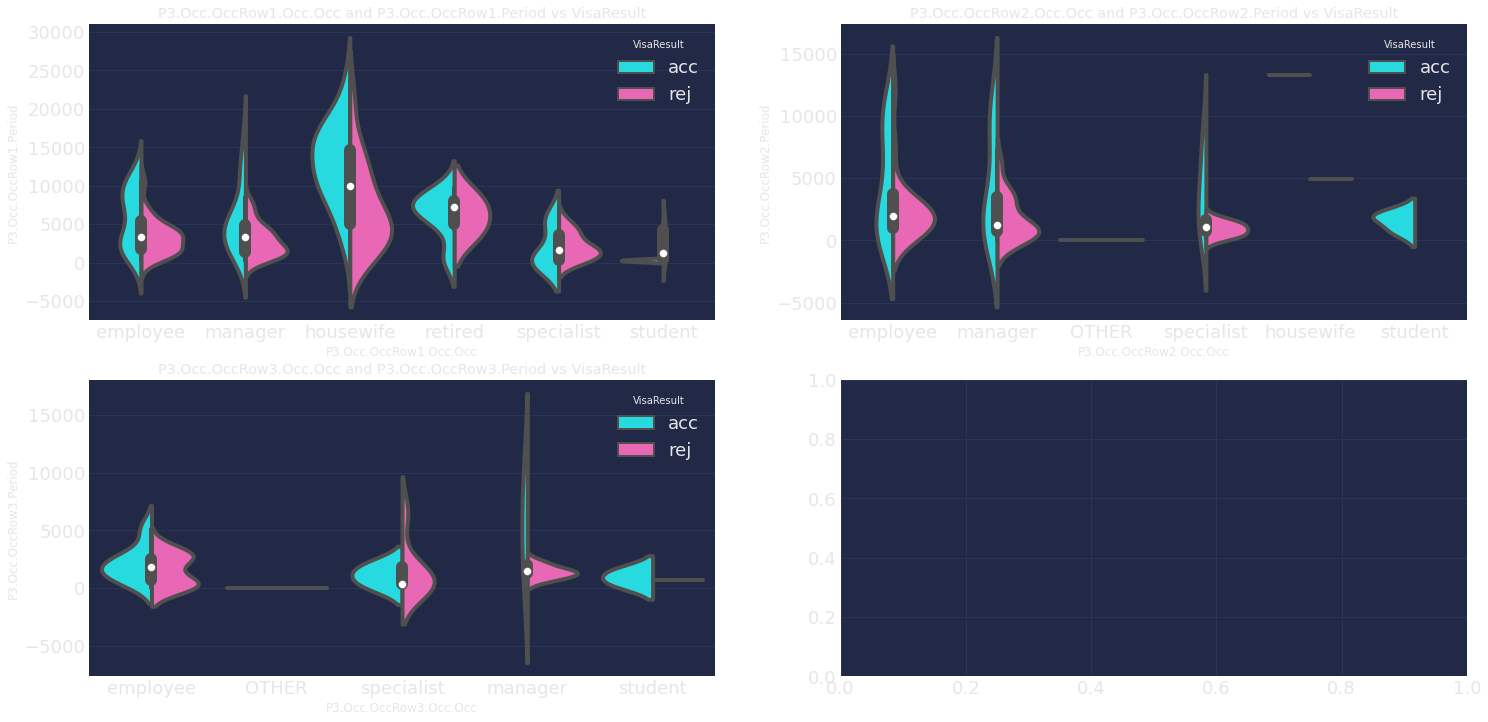

In [159]:
#nb>
f, ax = plt.subplots(2, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[0], y=_feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0, 0])
ax[0, 0].set_title('{} and {} vs {}'.format(feature_name[0], _feature_name[0], output_name))
# ax[0, 0].set_ylim(0, 15000)
sns.violinplot(x=feature_name[1], y=_feature_name[1], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0, 1])
ax[0, 1].set_title('{} and {} vs {}'.format(feature_name[1], _feature_name[1], output_name))
# ax[0, 1].set_ylim(0, 15000)
sns.violinplot(x=feature_name[2], y=_feature_name[2], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1, 0])
ax[1, 0].set_title('{} and {} vs {}'.format(feature_name[2], _feature_name[2], output_name))
# ax[1, 0].set_ylim(0, 15000)
# ax[0, 0].set_yticks(range(0, 200, 10))
plt.show()


Insights:
1. in almost all cases we can see that higher the period, higher the chance. This is because of age too, higher the work period means person has higher age. So, this is a correlation that was expected. Most obvious case of this scenario is the `housewife` case where practically person is unemployed (worst case) and the longer the person is unemployed the higher chance he/she has which is direct result of age factor.
2. In case of `employee`s and `specialist`s, we can see that the effect of age becomes way less.
3. Those whose *previous* job were `manager` or `specialist` (which may sound that they are not longer in that job) have way higher rejection. I.e. if you had more responsibility before your current job, you are less likely to be satisfied with your *current* status.

### P3.Occ.OccRow1.Country.Country -> categorical -> continuous

In [160]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow1.Country.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.Occ.OccRow1.Country.Country  VisaResult
059                             rej             1
202                             w-rej           1
224                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          15
Name: VisaResult, dtype: int64

Dealing with countries in categorical form is not logical. We would like to rank them or in an easier way, have a continuous score for each country. This way, we can convert a possibly large categorical feature into continuous field.

To do so, approach discussed in issue #10 (PR #11) has been taken, which in summary, takes WorldBank data, looks for economical fields (GDP), and take average of countries score over past years. Here, we utilize those methods.

In [161]:
config_path = CANADA_COUNTRY_CODE_TO_NAME
data[feature_name] = data[feature_name].apply(func=functional.extended_dict_get, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', str.isnumeric, ))

Time to convert country names to continuous values of scores of them.

In [162]:
display(data[feature_name].unique())

array(['IRAN', 'China', 'United Arab Emirates', 'Ukraine', 'Iraq'],
      dtype=object)

options: 
- 'GCI 4.0: Global Competitiveness Index 4.0, Rank'
- [NEW] GDP per capita: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD 

In [163]:
tmp_df = pd.read_pickle(dvc.api.get_url(path=HELPER_PATH_GDP, repo=REPO, rev=HELPER_VERSION_GDP))
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [164]:
display(data[feature_name].unique())

array([1.10715442, 1.32752412, 2.33984284, 1.10558781, 1.16178083])

#### P3.Occ.OccRow2.Country.Country -> categorical -> continuous

In [165]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow2.Country.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.Occ.OccRow2.Country.Country  VisaResult
059                             rej             1
280                             acc             1
IRAN                            acc            81
                                no idea        56
                                rej           129
                                w-acc          14
                                w-rej          16
TURKEY                          rej             1
Name: VisaResult, dtype: int64

In [166]:
config_path = CANADA_COUNTRY_CODE_TO_NAME
data[feature_name] = data[feature_name].apply(func=functional.extended_dict_get, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', str.isnumeric, ))

In [167]:
tmp_df = pd.read_pickle(dvc.api.get_url(path=HELPER_PATH_GDP, repo=REPO, rev=HELPER_VERSION_GDP))
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [168]:
display(data[feature_name].unique())

array([1.10715442, 2.33984284, 1.10558781, 1.30392442])

#### P3.Occ.OccRow3.Country.Country -> categorical -> continuous

In [169]:
output_name = 'VisaResult'
feature_name = 'P3.Occ.OccRow3.Country.Country'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.Occ.OccRow3.Country.Country  VisaResult
059                             rej             1
IRAN                            acc            82
                                no idea        56
                                rej           130
                                w-acc          14
                                w-rej          16
Name: VisaResult, dtype: int64

In [170]:
config_path = CANADA_COUNTRY_CODE_TO_NAME
data[feature_name] = data[feature_name].apply(func=functional.extended_dict_get, args=(
    functional.config_csv_to_dict(config_path), 'Unknown', str.isnumeric, ))

In [171]:
tmp_df = pd.read_pickle(dvc.api.get_url(path=HELPER_PATH_GDP, repo=REPO, rev=HELPER_VERSION_GDP))
eco_country_score_preprocessor = preprocessor.WorldBankXMLProcessor(dataframe=tmp_df)
data[feature_name] = data[feature_name].apply(
    func=eco_country_score_preprocessor.convert_country_name_to_numeric)

In [172]:
display(data[feature_name].unique())

array([1.10715442, 1.10558781])

#### P3.Occ.OccRowX.Period -> continuous

In [173]:
r = re.compile('P3.Occ.OccRow.*.Period')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['P3.Occ.OccRow1.Period', 'P3.Occ.OccRow2.Period', 'P3.Occ.OccRow3.Period']

In [174]:
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

### P3.BGI.Details.MedicalDetails -> categorical

In [175]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.Details.MedicalDetails'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.BGI.Details.MedicalDetails  VisaResult
False                          acc            82
                               no idea        56
                               rej           131
                               w-acc          14
                               w-rej          16
Name: VisaResult, dtype: int64

In [176]:
# drop useless
feature_name = 'P3.BGI.Details.MedicalDetails'
data.drop(feature_name, axis=1, inplace=True)

### P3.BGI.otherThanMedic -> categorical

In [177]:
output_name = 'VisaResult'
feature_name = 'P3.BGI.otherThanMedic'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.BGI.otherThanMedic  VisaResult
False                  acc            82
                       no idea        56
                       rej           131
                       w-acc          14
                       w-rej          16
Name: VisaResult, dtype: int64

In [178]:
# drop useless
feature_name = 'P3.BGI.otherThanMedic'
data.drop(feature_name, axis=1, inplace=True)

### P3.noAuthStay -> categorical

In [179]:
output_name = 'VisaResult'
feature_name = 'P3.noAuthStay'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.noAuthStay  VisaResult
False          acc            82
               no idea        56
               rej           129
               w-acc          14
               w-rej          16
True           rej             2
Name: VisaResult, dtype: int64

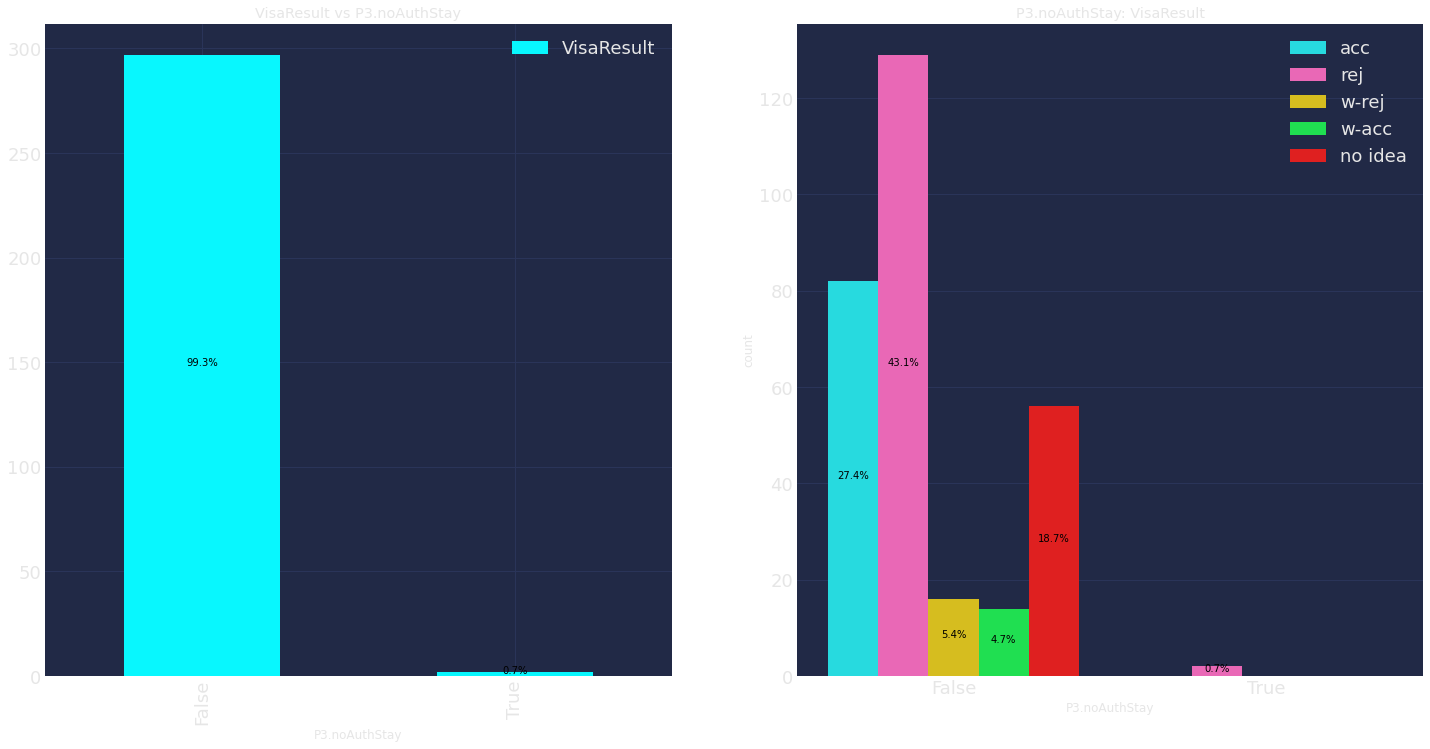

In [180]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(x=feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

Obviously, staying in a country beyond authenticated duration, dominates solely and even though it sounds obvious, it shouldn't be ignored.

### P3.refuseDeport -> categorical

In [181]:
output_name = 'VisaResult'
feature_name = 'P3.refuseDeport'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.refuseDeport  VisaResult
False            acc           68
                 no idea       41
                 rej           95
                 w-acc         12
                 w-rej         12
True             acc           14
                 no idea       15
                 rej           36
                 w-acc          2
                 w-rej          4
Name: VisaResult, dtype: int64

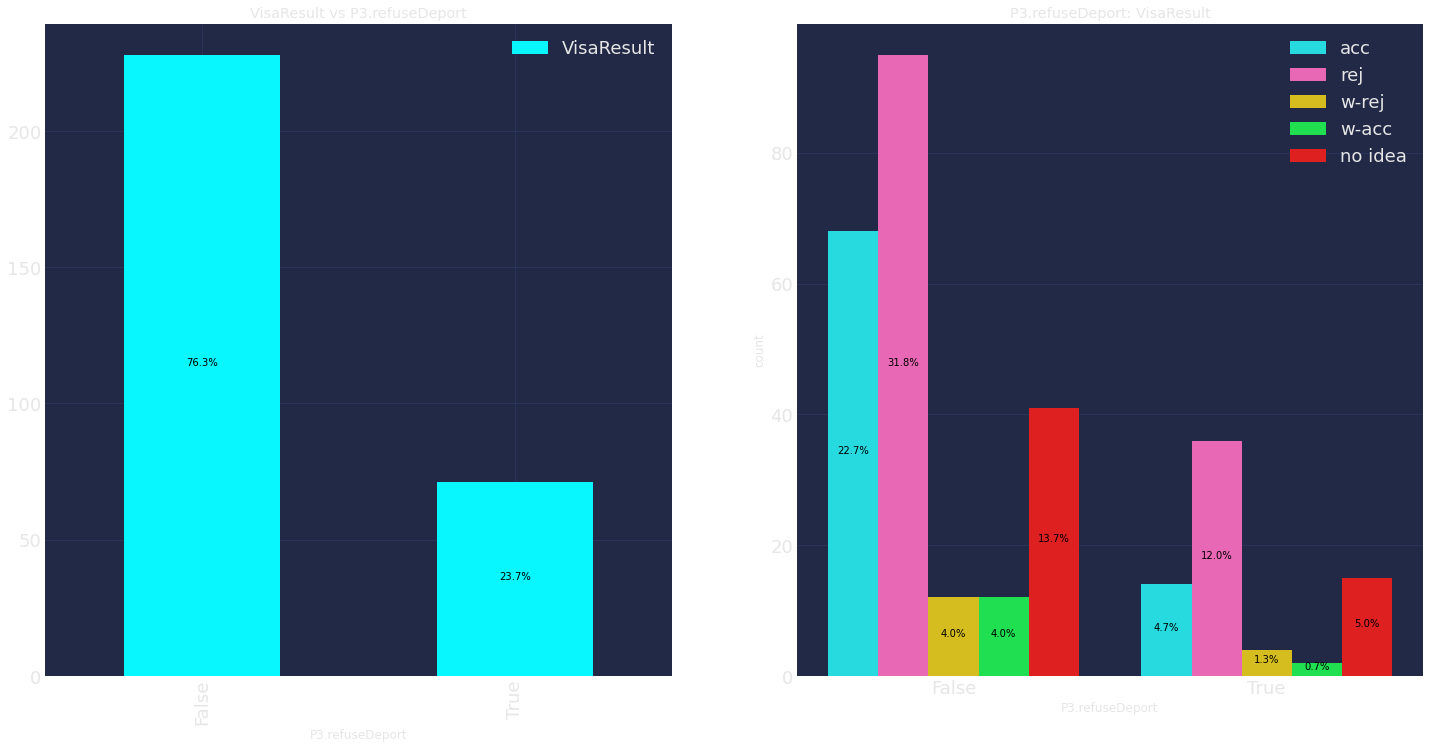

In [182]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(x=feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

Of course, those who have previous rejected cases are more likely to get rejected again.

### P3.BGI2.PrevApply -> categorical

In [183]:
output_name = 'VisaResult'
feature_name = 'P3.BGI2.PrevApply'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.BGI2.PrevApply  VisaResult
False              acc            44
                   no idea        41
                   rej           107
                   w-acc          14
                   w-rej          14
True               acc            38
                   no idea        15
                   rej            24
                   w-rej           2
Name: VisaResult, dtype: int64

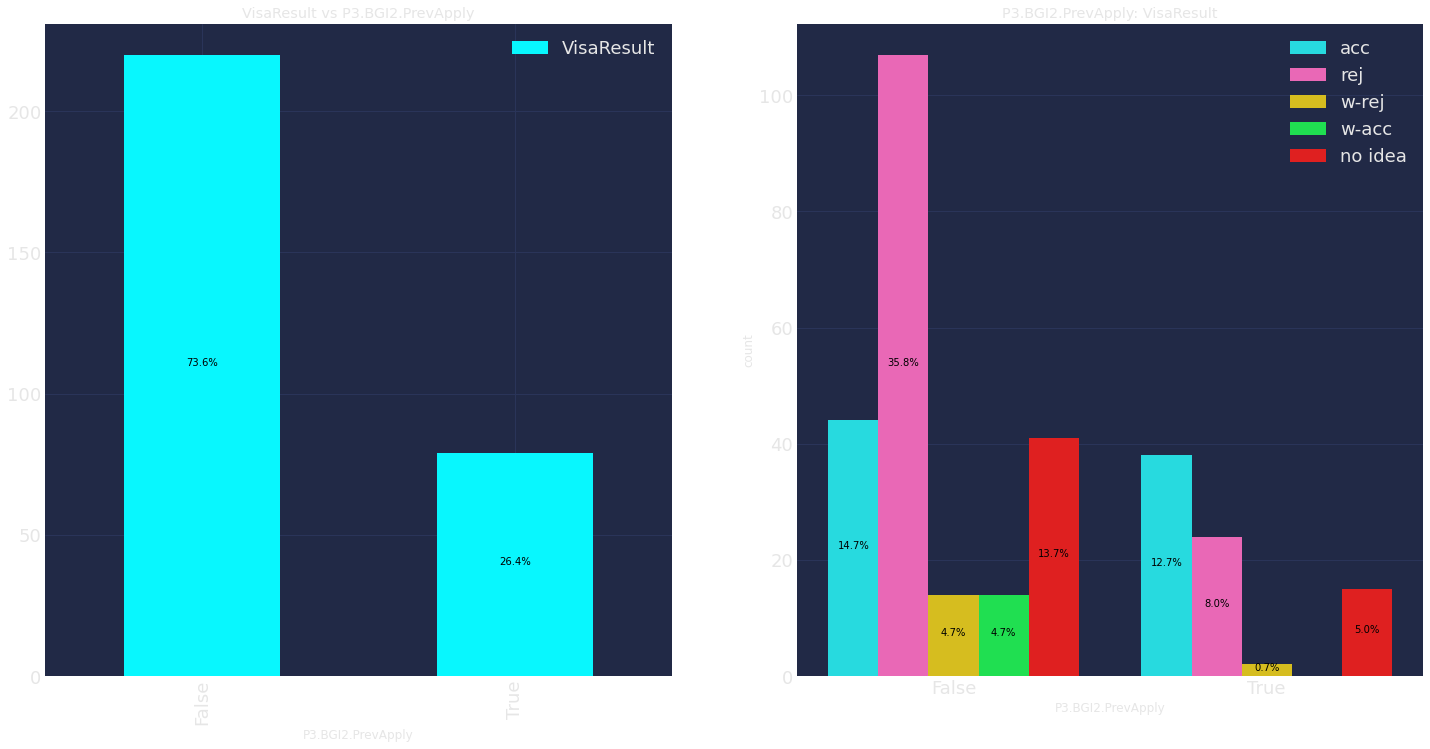

In [184]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(x=feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

Well, it sounds obvious that if someone got the visa before, it is more likely to get the visa once again and vice versa. So, let's compare with `'P3.refuseDeport'` to see the relation between previous applies that succeeded or failed.

In [185]:
feature_name = 'P3.BGI2.PrevApply', 'P3.refuseDeport'

In [186]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) *100
ct

VisaResult                               acc        rej         All
P3.BGI2.PrevApply P3.refuseDeport                                  
False             False            17.840376  42.723005   60.563380
                  True              2.816901   7.511737   10.328638
True              False            14.084507   1.877934   15.962441
                  True              3.755869   9.389671   13.145540
All                                38.497653  61.502347  100.000000

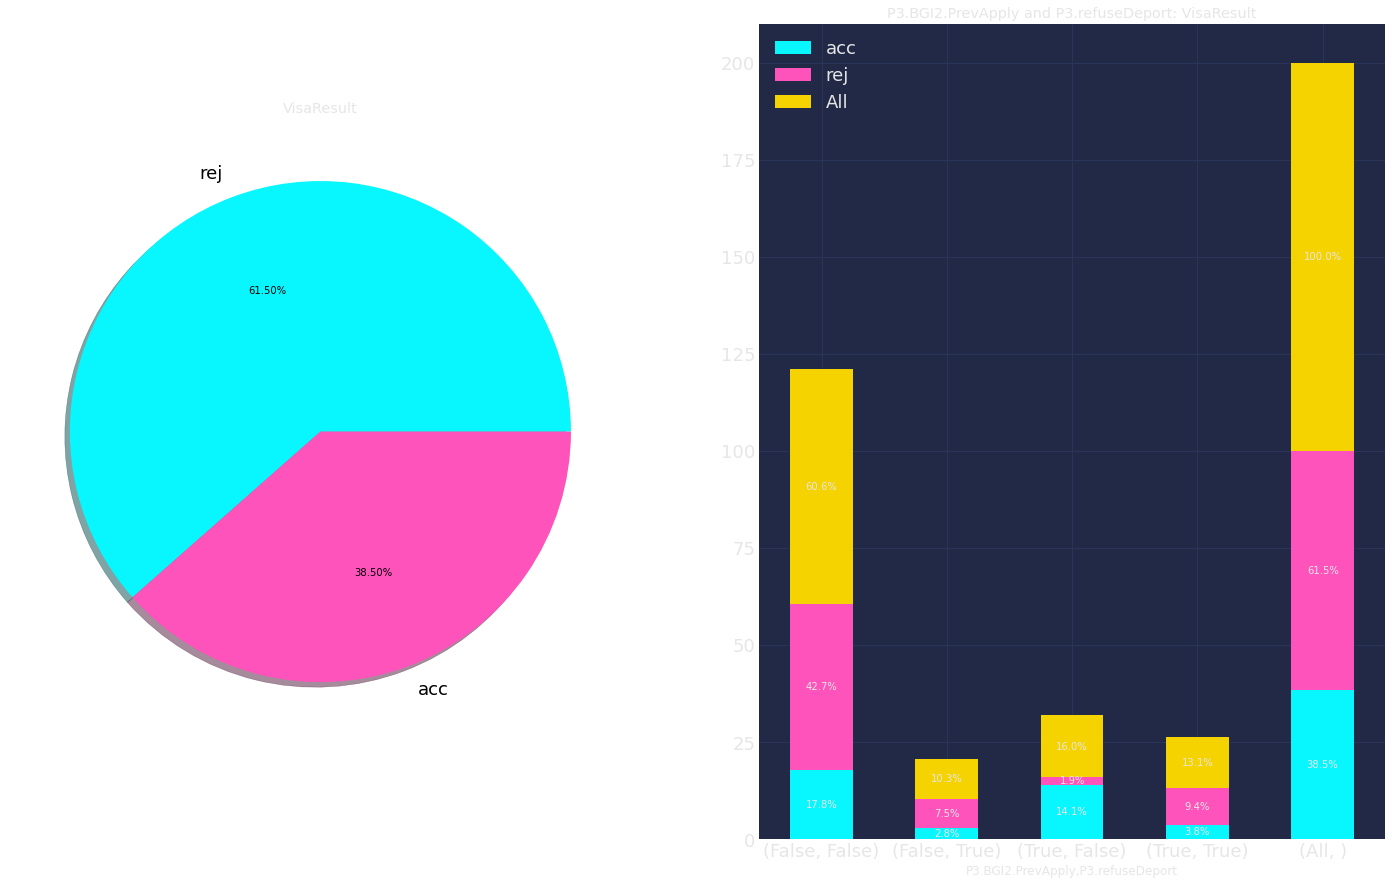

In [187]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 15))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color': 'black'})
ax[0].set_title('VisaResult')
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1.1f%%')
plt.show()

First of all, we can see that %38.7 of applicants got visa. Now, let's see how many of them got it because of their previous apply.

Insights:
1. As we can see from the 3rd column, around %14.5 of applicant got visa because they had applied previously and got accepted. 
2. Interestingly, around %6.5(=2.8+3.7) of applicant got visa, even though they have been previously rejected.
3. Other %17.8 got visa without any prior record.
4. Having visa rejection (2nd column) reduces the chance of acceptance by at least 2 times!

### P3.PWrapper.criminalRec -> categorical

In [188]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.criminalRec'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.PWrapper.criminalRec  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

In [189]:
# drop useless
feature_name = 'P3.PWrapper.criminalRec'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.Military.Choice -> categorical

In [190]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.Military.Choice'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.PWrapper.Military.Choice  VisaResult
False                        acc            80
                             no idea        54
                             rej           128
                             w-acc          14
                             w-rej          16
True                         acc             2
                             no idea         2
                             rej             3
Name: VisaResult, dtype: int64

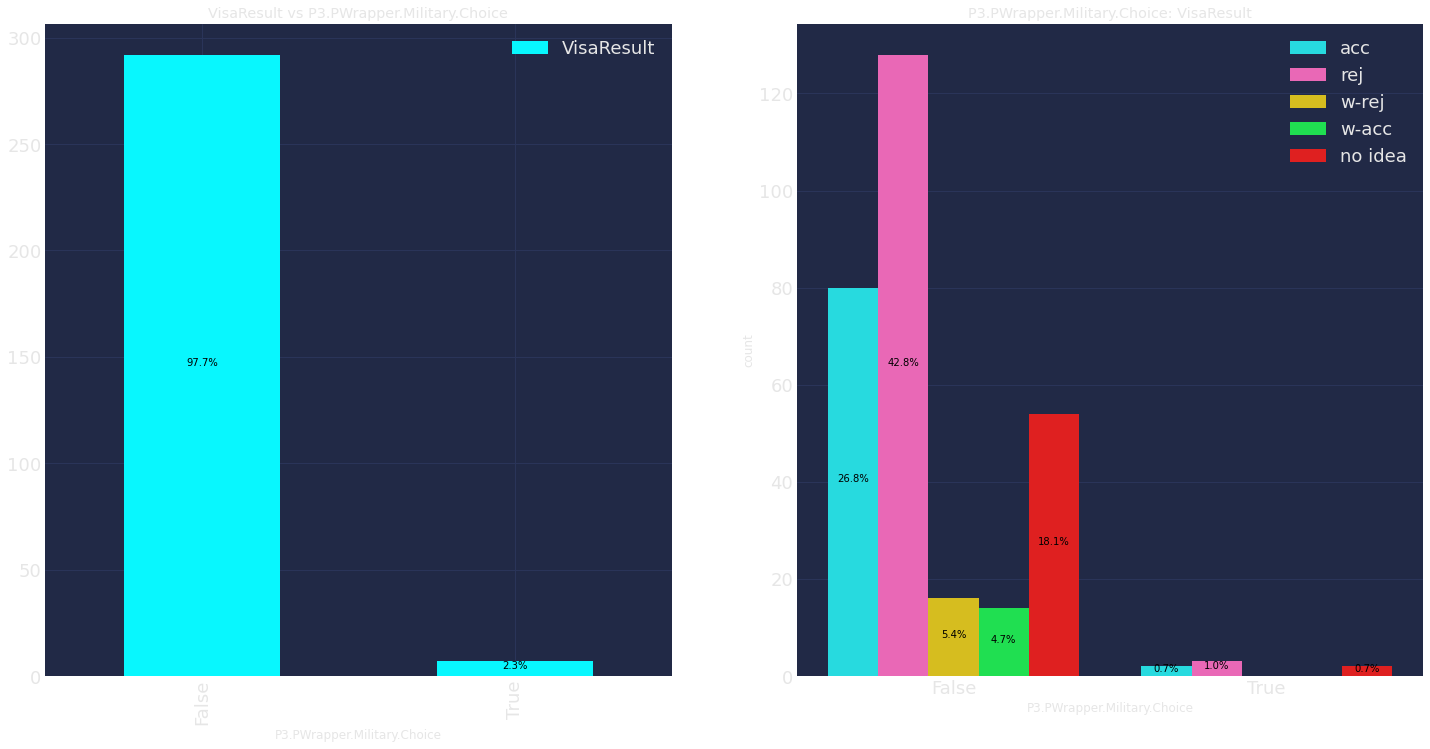

In [191]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
data[[feature_name, output_name]].groupby(
    [feature_name]).count().plot.bar(ax=ax[0])
add_percentage_axes(ax[0], len(data))
ax[0].set_title('{} vs {}'.format(output_name, feature_name))
ax[1] = sns.countplot(x=feature_name, hue=output_name, data=data,
                      ax=ax[1], hue_order=output_hue_order)
add_percentage_axes(ax[1], len(data))
ax[1].set_title('{}: {}'.format(feature_name, output_name))
ax[1].legend(loc='upper right')
plt.show()

It's nothing to consider. If all was rejected, we could say it is a warning, but apparently has no effect. Especially, many have done compulsory service. Hence, for now we drop it.

In [192]:
# drop useless
feature_name = 'P3.PWrapper.Military.Choice'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.politicViol -> categorical

In [193]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.politicViol'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.PWrapper.politicViol  VisaResult
False                    acc            82
                         no idea        56
                         rej           131
                         w-acc          14
                         w-rej          16
Name: VisaResult, dtype: int64

So ... Yea... everybody lied that they have not seen any mistreatment! KEKSociety.

In [194]:
# drop useless
feature_name = 'P3.PWrapper.politicViol'
data.drop(feature_name, axis=1, inplace=True)

### P3.PWrapper.witnessIllTreat -> categorical

In [195]:
output_name = 'VisaResult'
feature_name = 'P3.PWrapper.witnessIllTreat'
display(data.groupby([feature_name, output_name])[output_name].count())

P3.PWrapper.witnessIllTreat  VisaResult
False                        acc            82
                             no idea        56
                             rej           131
                             w-acc          14
                             w-rej          16
Name: VisaResult, dtype: int64

In [196]:
# drop useless
feature_name = 'P3.PWrapper.witnessIllTreat'
data.drop(feature_name, axis=1, inplace=True)

### P1.PD.CurrCOR.Row2.Period -> continuous

This part is a little different, since most of the people are single-national citizens (in our domain at least), then their `'CurrCOR'` and `'DOBYear.Period'` are the same value.
So we prefer to compare these to together as a joint variable. 

In [197]:
output_name = 'VisaResult'
feature_name = 'P1.PD.CurrCOR.Row2.Period', 'P1.PD.DOBYear.Period'

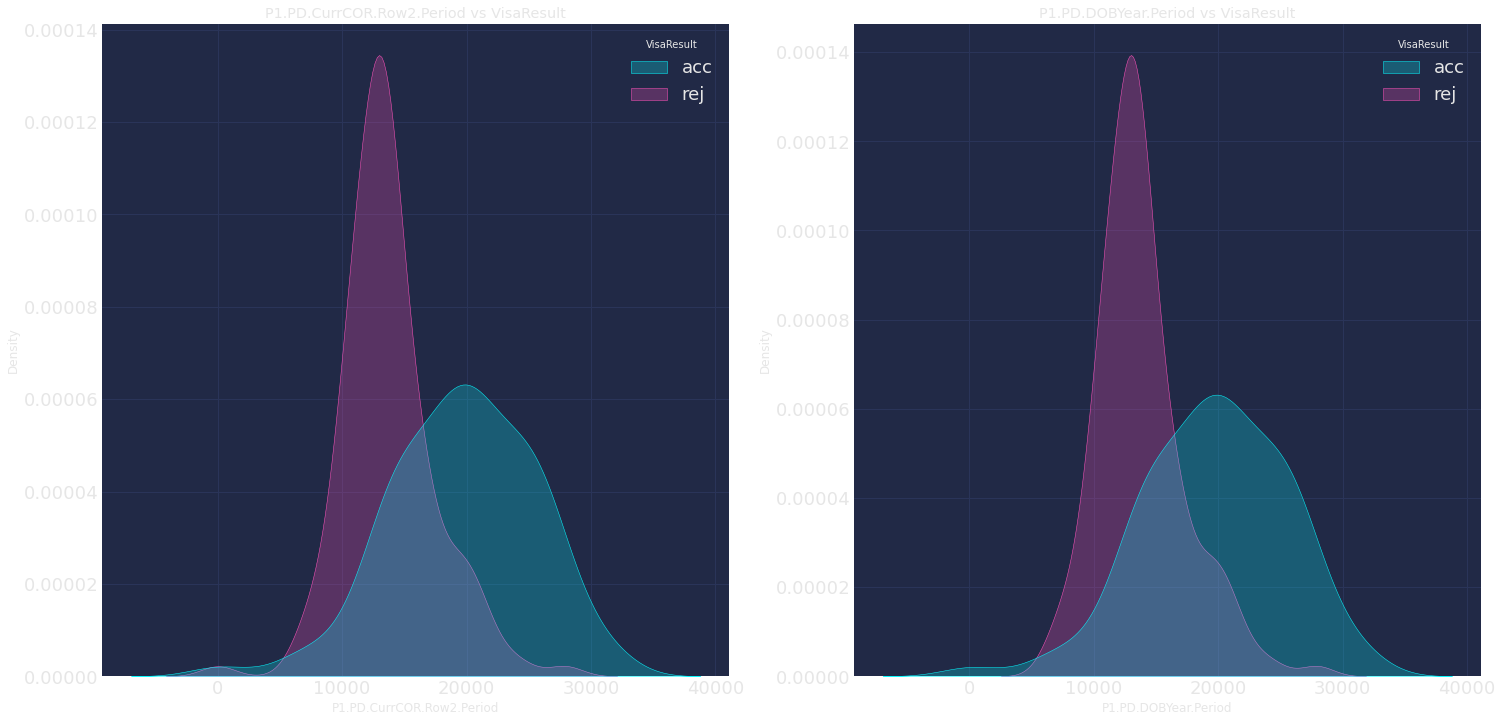

In [198]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.kdeplot(x=feature_name[0], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[0])
ax[0].set_title('{} vs {}'.format(feature_name[0], output_name))
sns.kdeplot(x=feature_name[1], hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[1], output_name))
plt.show()

As we can see, both data has the same distribution except a small proportion (around 0) which can be considered as anomaly. Hence, I think dropping this `'CurrCOR'` is a rational choice. But to make sure, we plot these these two variables against each other.

In [199]:
# drop useless
feature_name = 'P1.PD.CurrCOR.Row2.Period'
data.drop(feature_name, axis=1, inplace=True)

### 'P1.PD.DOBYear.Period' -> continuous

In [200]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period'

In [201]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [202]:
#nb>
display(data[data[feature_name]<=25].groupby([feature_name, output_name])[output_name].count())

P1.PD.DOBYear.Period  VisaResult
0.591781              acc           1
17.808219             rej           1
18.534247             acc           1
19.115068             acc           1
19.989041             rej           1
20.394521             rej           1
20.989041             rej           1
22.043836             no idea       1
22.268493             rej           1
22.446575             rej           1
23.838356             no idea       1
Name: VisaResult, dtype: int64

Let's get rid of that kid first. But I decided to keep others (e.g. 17, 18, ... years old kids) and the reason is that they have been proportionately rejected. So, if they wanted to go alone, or with family, there is something that caused them to get rejected. So, let's keep em.

In [203]:
data.drop(data[data[feature_name]<=1].index, inplace=True)
display(data[data[feature_name]<=1][feature_name])

Series([], Name: P1.PD.DOBYear.Period, dtype: float64)

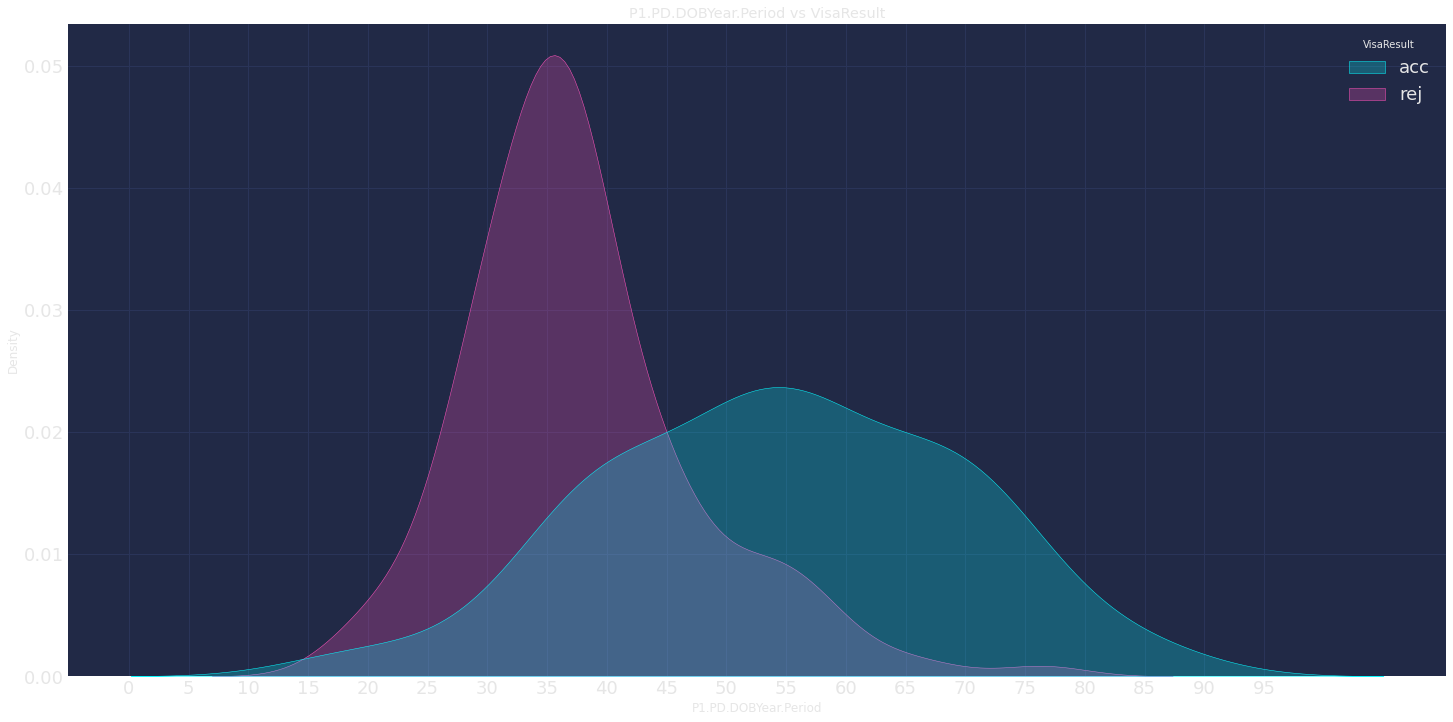

In [204]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_title('{} vs {}'.format(feature_name, output_name))
ax.set_xticks(range(0, 100, 5))
plt.show()

### 'P1.PD.DOBYear.Period' and a second feature

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [205]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P1.PD.Sex.Sex'

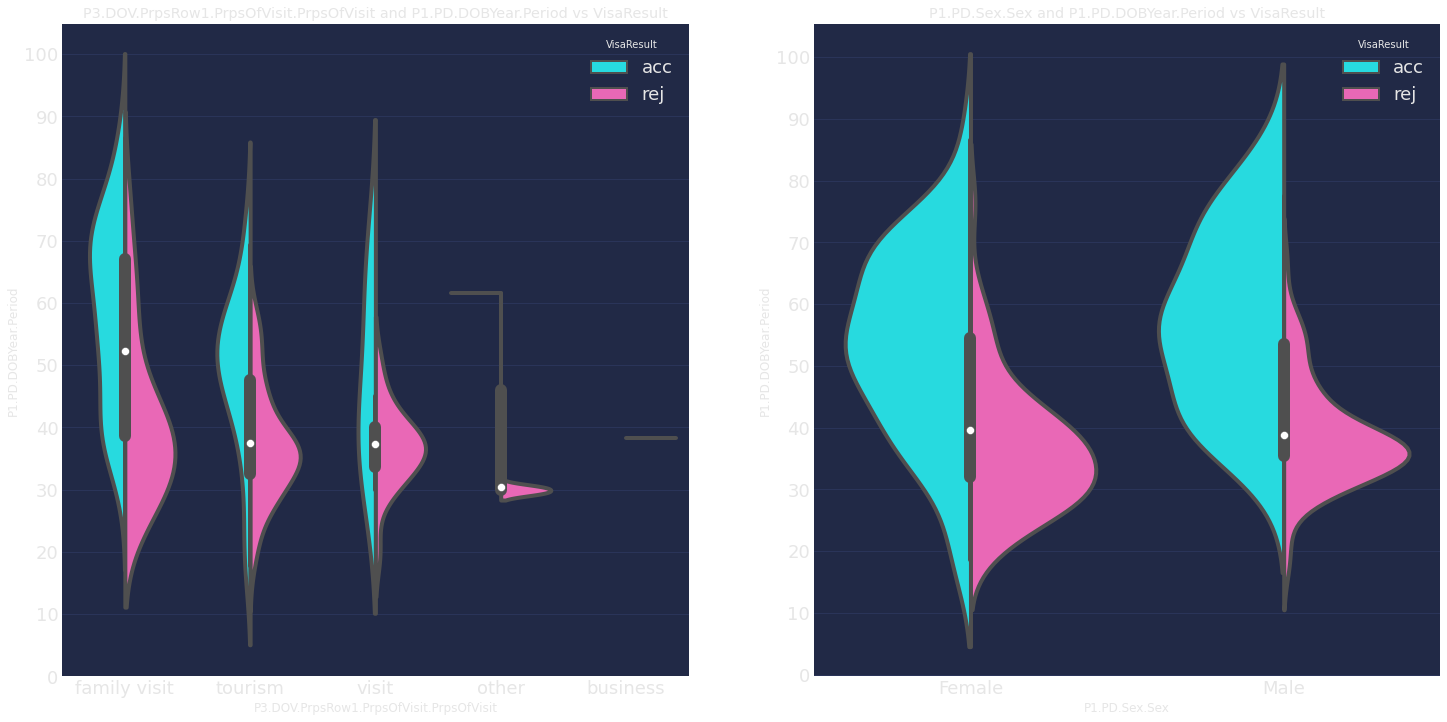

In [206]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0], scale='area', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x=feature_name[2], y=feature_name[0], scale='width', 
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} and {} vs {}'.format(feature_name[2], feature_name[0], output_name))
ax[1].set_yticks(range(0, 110, 10))
plt.show()

Insights:
1. The lower the age, the lower the likelihood
2. 'family visit' dominates the age and increases the likelihood considerably
3. There is not much difference in 'tourism' and 'visit' and 'age' is the the important factor again
4. The peak of rejection for 'Male' is around 40 while for 'Female' is around 30 and the reason is that usually in families, men have higher age than women.


#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.Funds.Funds' -> continuous

In [207]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

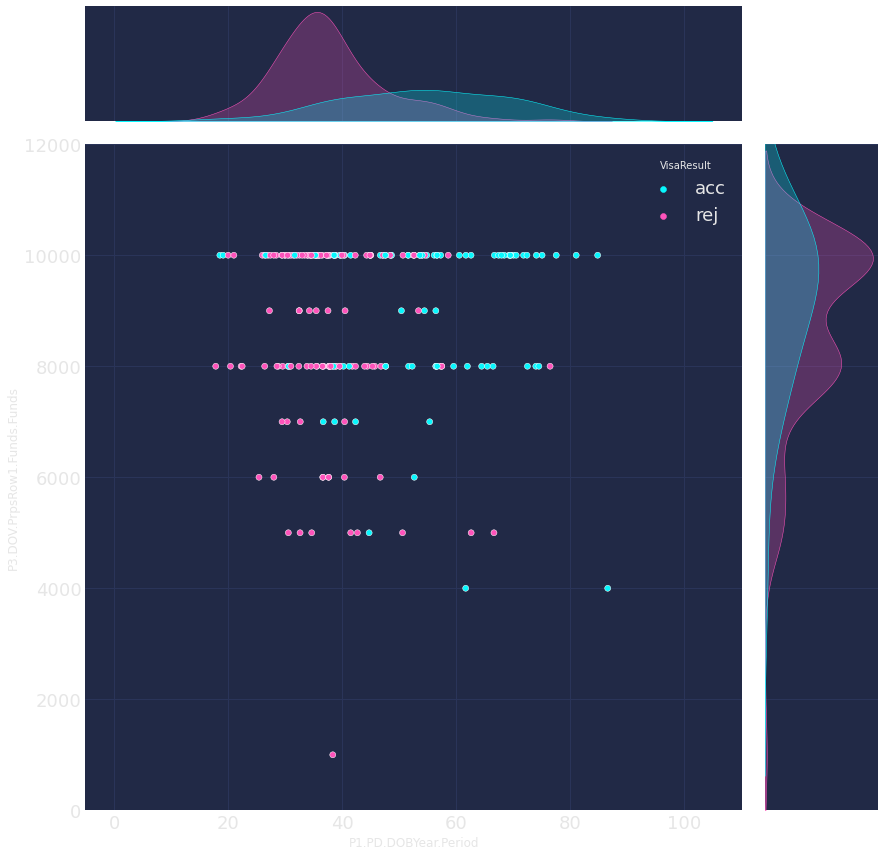

In [208]:
#nb>
sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
plt.ylim(0, 12e3)
plt.show()

Since lower age decreases the likelihood of acceptance considerably, having larger funds is compensating.

#### 'P1.PD.DOBYear.Period' and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [209]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P1.MS.SecA.MS'

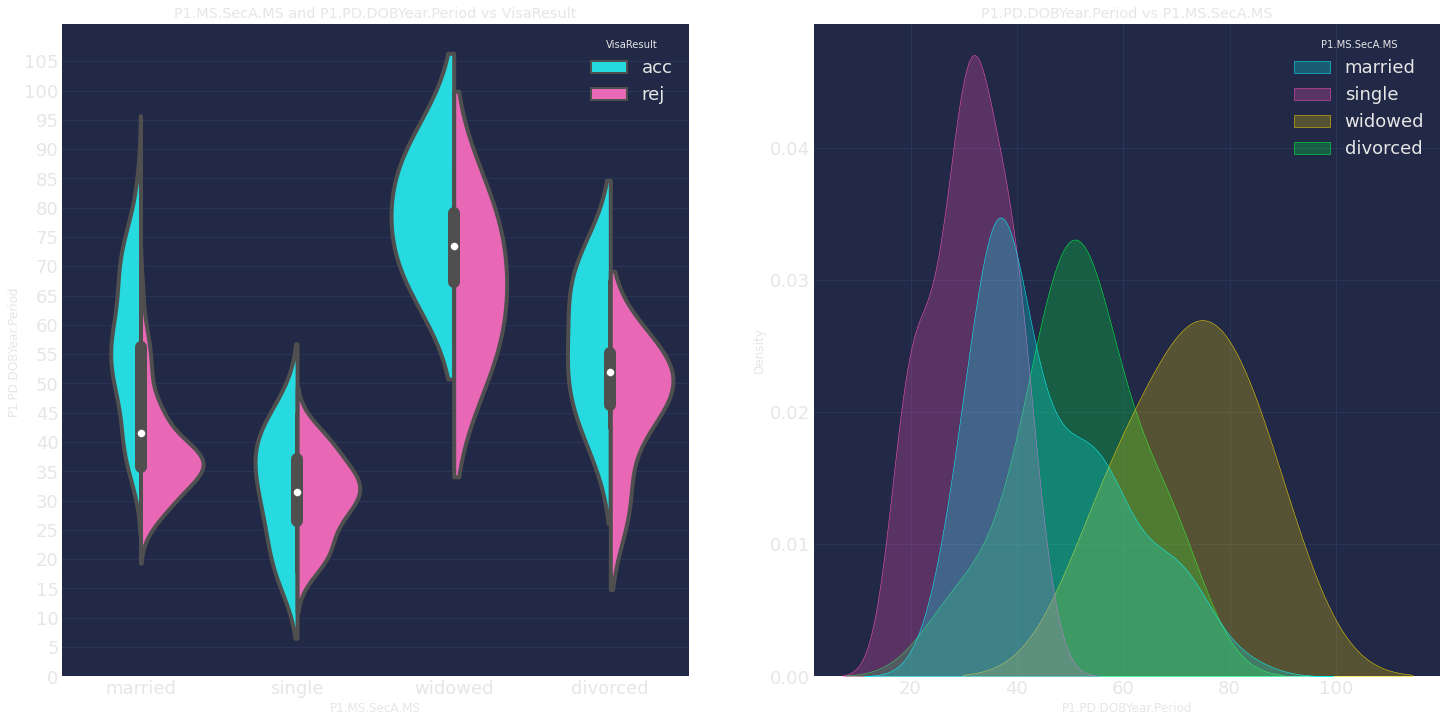

In [210]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 110, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


It seems that 'marital status' has been encoded in 'age' or wise versa.

For instance:
1. Single people's acceptance mean is way lower age than other groups. This is counter intuitive, because most of these young and 'single' people are with their family probably, so their parents are the actual applicants. This can be confirmed by looking at the trail of 'single' where it expands to lower ages.
2. 'divorced' and 'married' people's age seems irrelevant. Although, we see that peak of rejection and acceptance for 'divorced' people are higher and this is obvious since usually, 'divorced' people have higher average age.
3. 'widowed' case has similar status as the latter statement in 2.

### 'P1.MS.SecA.DateOfMarr.Period' -> continuous

In [211]:
# convert to years but continuous
feature_name = 'P1.MS.SecA.DateOfMarr.Period'
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [212]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex'

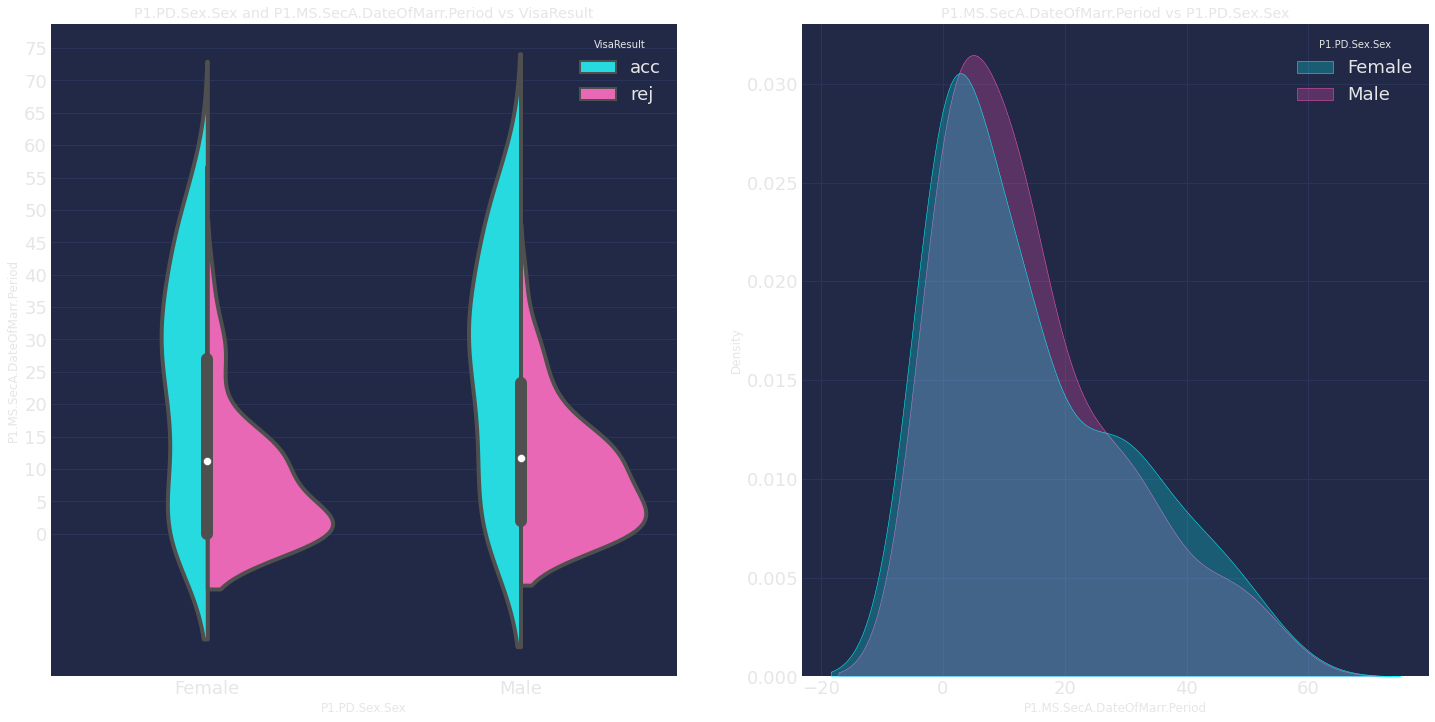

In [213]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.kdeplot(x=feature_name[0], hue=feature_name[1], common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[0], feature_name[1]))
plt.show()

Seems like there is no insight in relation of gender to marriage period.

In [214]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.DOBYear.Period'

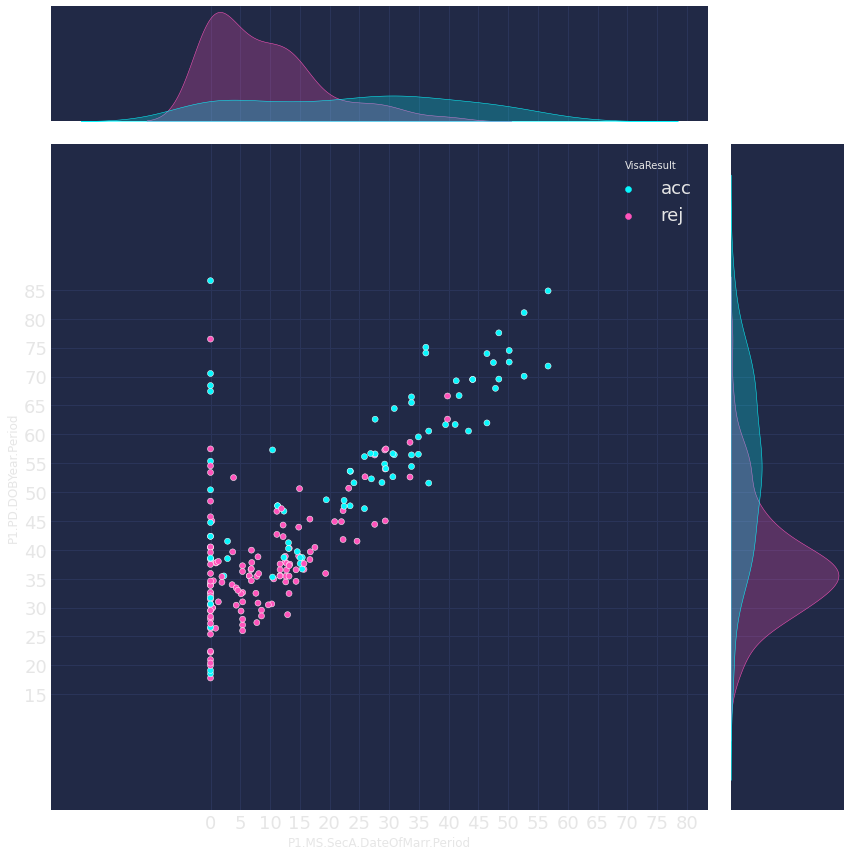

In [215]:
#nb>
g= sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(15, 90, 5))
plt.show()

In [216]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.DateOfMarr.Period', 'P1.PD.Sex.Sex', 'P1.PD.DOBYear.Period', 

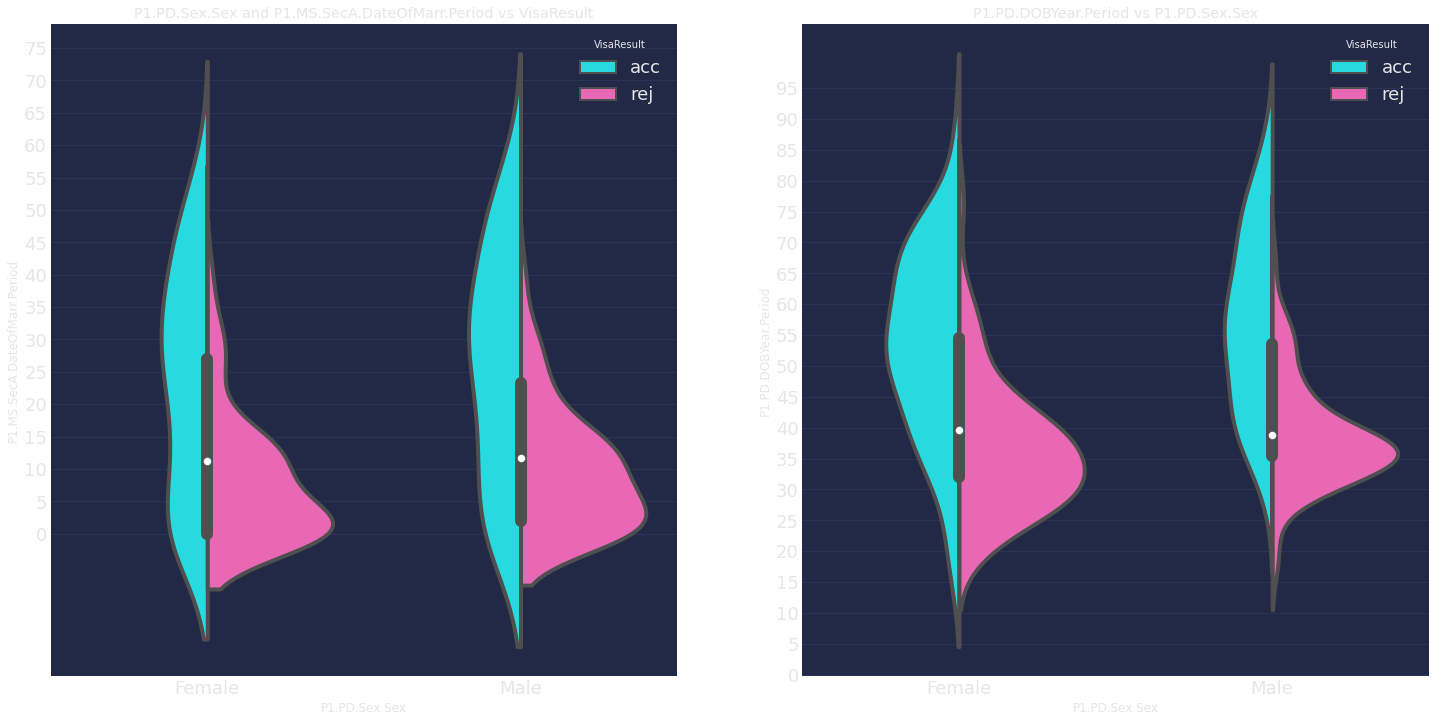

In [217]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 80, 5))
sns.violinplot(x=feature_name[1], y=feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()

Even though it seems that a lot of people with short to medium marriages (<=10) when they are in their early 30s or late 20s have been rejected (previous scatter graph), here, we can see that having marriage even for a short period increases the likelihood considerably (look at the bumps on the figure on the left around Yaxis=0 and smooth very low density on the figure on the right.)

TODO: see issue #15. Seems that such a thing would improve.

### 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period' and 'P2.MS.SecA.Period' -> continuous

In [218]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P2.MS.SecA.Period'
data[feature_name[0]] = data[feature_name[0]].apply(lambda x: x/365.)
data[feature_name[1]] = data[feature_name[1]].apply(lambda x: x/365.)

In [219]:
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period', 'P1.MS.SecA.MS', 'P2.MS.SecA.Period'

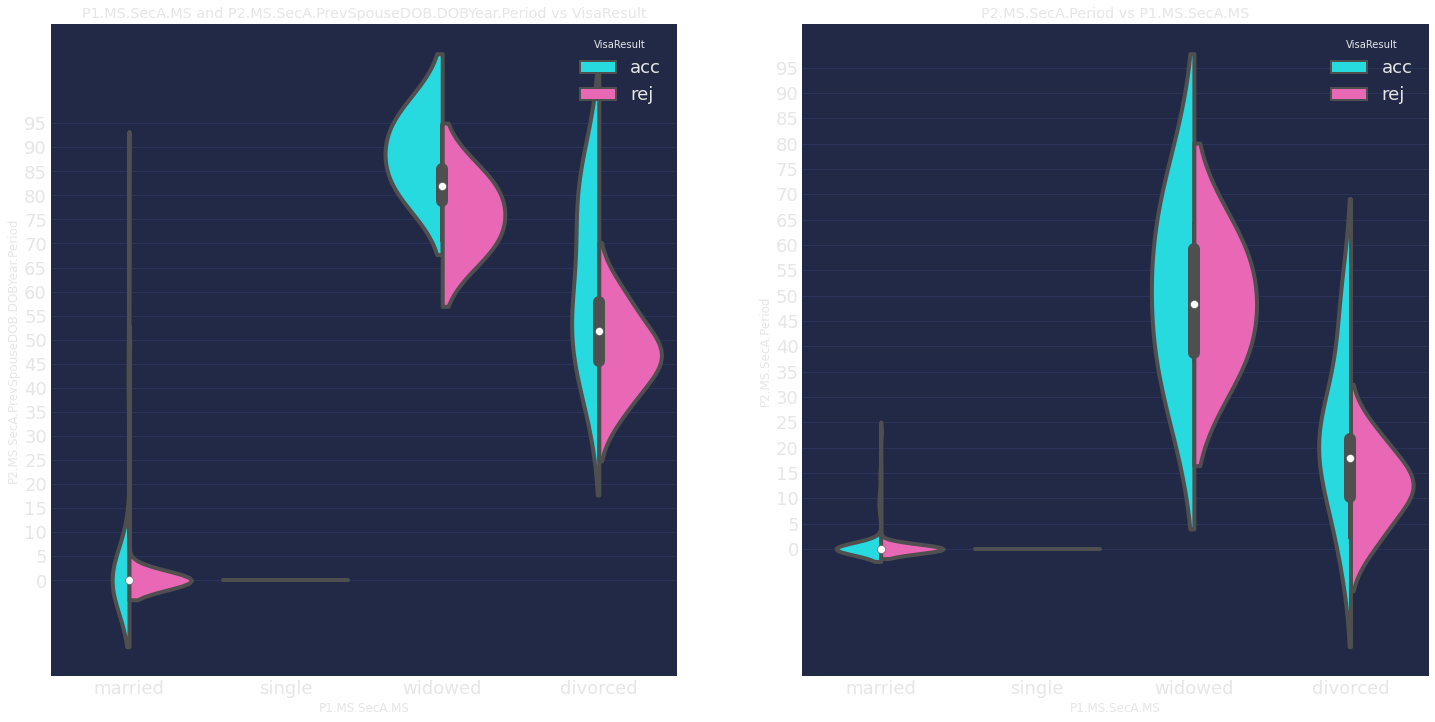

In [220]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {}'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 100, 5))
sns.violinplot(x=feature_name[1], y=feature_name[2],
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
ax[1].set_yticks(range(0, 100, 5))
plt.show()

It is hard to extract any insights from it since all range of age exist for all categories (except single/married of course), so I leave it there until further investigation.

TODO: maybe delete? no idea how useful it is 
1. Having previous marriage's period seems to contain all information we need about previous marriage, hence, the age of previous spouse does not provide any useful information.

In [221]:
# drop useless
feature_name = 'P2.MS.SecA.PrevSpouseDOB.DOBYear.Period'
data.drop(feature_name, axis=1, inplace=True)

### P2.MS.SecA.Psprt.ExpiryDate.Remaining -> continuous

In [222]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
data[feature_name] = data[feature_name].apply(lambda x: x/30.)

In [223]:
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
display(data[data[feature_name] < 5.].__len__())

2

For some reason, we have to samples that have negative expiration date. For conversion, we can use `.abs` to mirror them or use statistical methods to fill, e.g. `mode`.

In [224]:
data.loc[data[feature_name] < 5., feature_name] = data[data[feature_name] < 5.][feature_name].apply(lambda x: np.abs(x))
display(data[data[feature_name] < 5.].__len__())

0

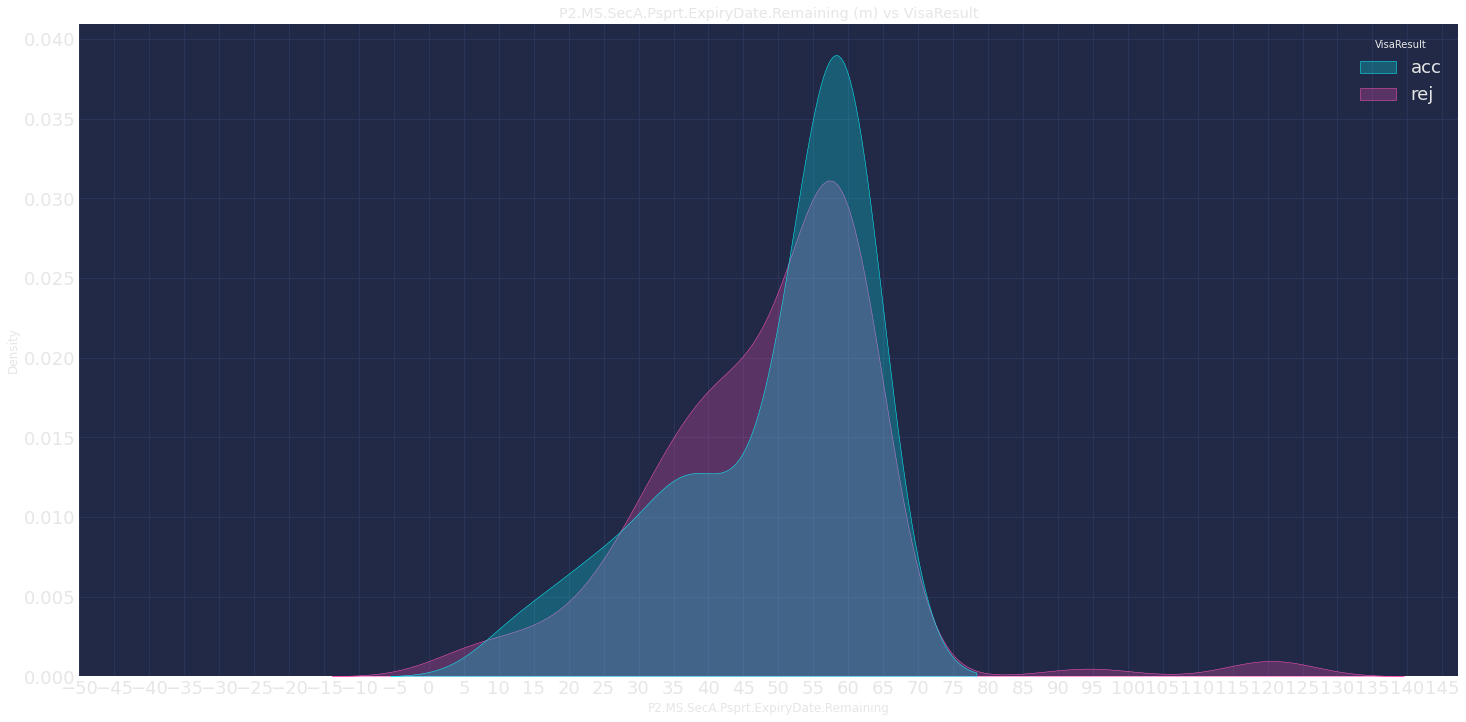

In [225]:
#nb>
feature_name = 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'
f, ax = plt.subplots(1, 1, figsize=(22, 12))
sns.kdeplot(x=feature_name, hue=output_name, common_norm=False,
            data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], fill=True, ax=ax)
ax.set_xticks(range(-50, 150, 5))
ax.set_title('{} (m) vs {}'.format(feature_name, output_name))
plt.show()

There are three points of interest here, one around 5-10 and the other around 60 on x axis.
1. 5-10: It seems that not having long enough expiration date on passport suggests that the applicant is more likely to get rejected.
2. 60: 60 month or 5 years are the expiration period for fresh Iranian passports and it might mean that they are children of a family and their parent's features are carrying them.

In [226]:
output_name = 'VisaResult'
feature_name = 'P1.PD.DOBYear.Period', 'P2.MS.SecA.Psprt.ExpiryDate.Remaining'

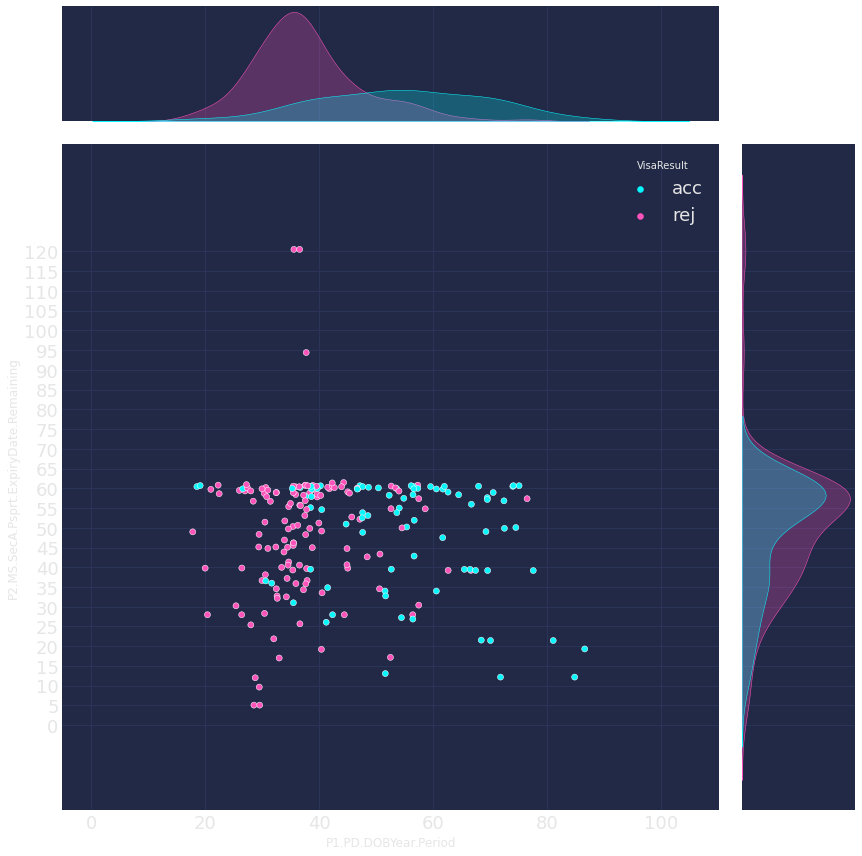

In [227]:
#nb>
g = sns.jointplot(
    data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')], x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
# g.ax_joint.set_xticks(range(0, 81, 5))
g.ax_joint.set_yticks(range(0, 125, 5))
plt.show()

### P3.DOV.PrpsRow1.HLS.Period -> continuous

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.Funds.Funds'

In [228]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.Funds.Funds'

In [229]:
#nb>
data[data[feature_name[1]] > 10000]

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
110                                              False             Male   
220                                              False           Female   

     P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
110                    1.107154                        1.0   
220                    1.107154                        1.0   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
110                    1.429856                    1.429856   
220                    1.429856                    1.429856   

    P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status  \
110                     True                 TURKEY                    6.0   
220                    False                 TURKEY                    3.0   

    P1.MS.SecA.MS P2.MS.SecA.PrevMarrIndicator  \
110       married                        False   
220       married                        False   

    P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  P3.DOV.PrpsRow1.Funds.Funds  \
110                            family visit                      30000.0   
220                            family visit                      20000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
110                                                 f1     
220                                                 f2     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
110                                          ukn               False   
220                                           f2                True   

    P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Country.Country  \
110                        unedu                         1.000000   
220                     bachelor                         3.177804   

    P3.Occ.OccRow1.Occ.Occ  P3.Occ.OccRow1.Country.Country  \
110                manager                        1.107154   
220              housewife                        1.107154   

    P3.Occ.OccRow2.Occ.Occ  P3.Occ.OccRow2.Country.Country  \
110                  OTHER                        1.107154   
220               employee                        1.107154   

    P3.Occ.OccRow3.Occ.Occ  P3.Occ.OccRow3.Country.Country P3.noAuthStay  \
110                  OTHER                        1.107154         False   
220                  OTHER                        1.107154         False   

    P3.refuseDeport P3.BGI2.PrevApply  P1.PD.DOBYear.Period  \
110           False             False             60.561644   
220            True              True             36.950685   

     P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  \
110                        0.0                        0.0   
220                        0.0                        0.0   

     P1.PD.CWA.Row2.Period  P1.MS.SecA.DateOfMarr.Period  P2.MS.SecA.Period  \
110                   30.0                     36.643836                0.0   
220                   30.0                      8.978082                0.0   

     P2.MS.SecA.Psprt.ExpiryDate.Remaining  P3.DOV.PrpsRow1.HLS.Period  \
110                              33.966667                        31.0   
220                              53.033333                        19.0   

     P3.Edu.Edu_Row1.Period  P3.Occ.OccRow1.Period  P3.Occ.OccRow2.Period  \
110                 0.00000              36.024658                0.00000   
220                 4.00274               9.005479                3.00274   

     P3.Occ.OccRow3.Period  p1.Subform1.Visitor  p1.Subform1.Worker  \
110                    0.0                  1.0                 0.0   
220                    0.0                  1.0                 0.0   

     p1.Subform1.Student  p1.Subform1.Other  \
110                  0.0                0.0   
220                  0.0                0.0   

                                   p1.SecA.App.AppAddr  \
110  UNIT 3-NO.51-1ST SHAHIZEAEE ALLEY-MOTAHARI STR...   
220  APT 1, #2 ZENDEDELAN ALLEY, MALEK

we have two cases where have 20K and 30K funds, hence, for visualization purposes, I have excluded them.

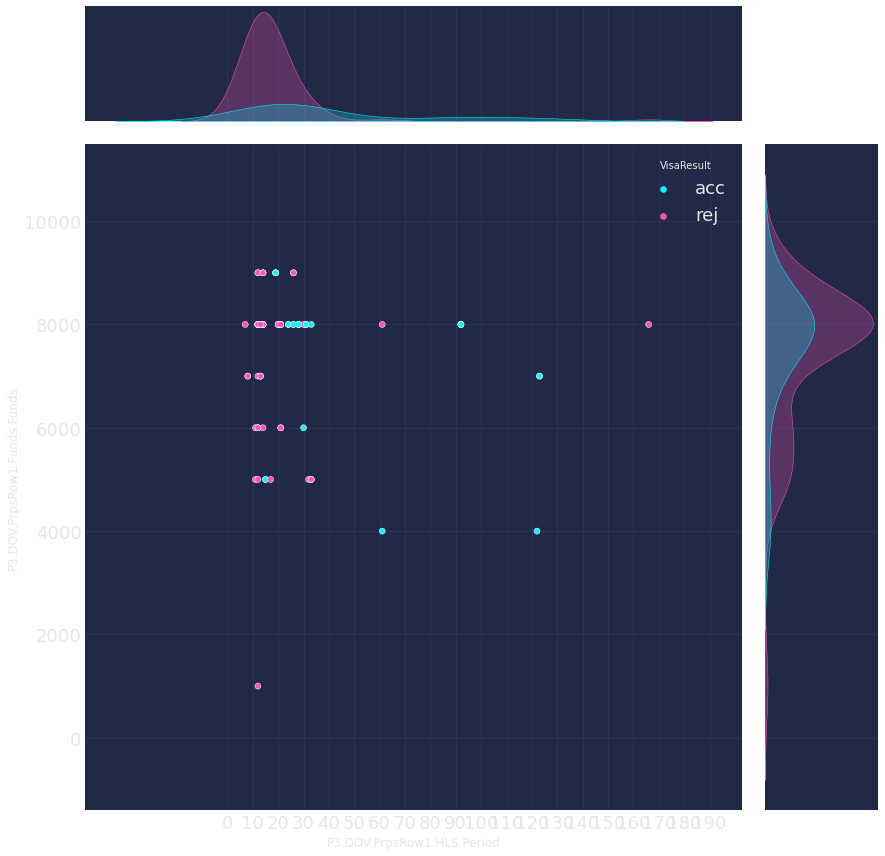

In [230]:
#nb>
g = sns.jointplot(
    data=data[((data[output_name] == 'acc') | (data[output_name] == 'rej')) & (data[feature_name[1]] < 10000)],
    x=feature_name[0], y=feature_name[1], hue=output_name, height=12)
g.ax_joint.set_xticks(range(0, 200, 10))
plt.show()

It seems many people who have **chosen below 30 days stay have been rejected for any amount of funds.**. As we can see on the top distribution, peak of rejection is on 10 days!

But, this could be because of other reasons, for instance, those who are coming for tourism, would mostly stay for 2 weeks, and most of the rejections are for tourism. So, we check purpose of visit and the duration.

#### P3.DOV.PrpsRow1.HLS.Period and 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [231]:
# convert to years but continuous
output_name = 'VisaResult'
feature_name = 'P3.DOV.PrpsRow1.HLS.Period', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'P3.DOV.PrpsRow1.Funds.Funds'

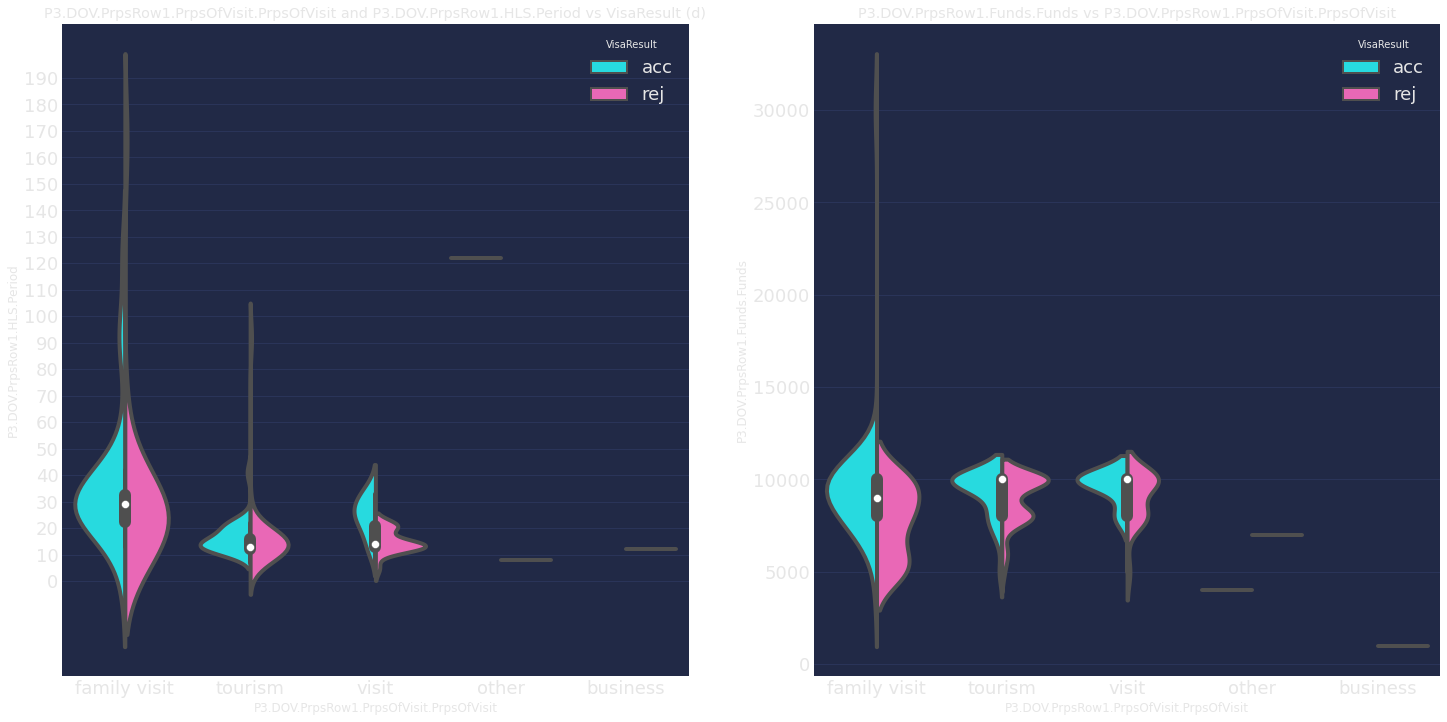

In [232]:
#nb>
f, ax = plt.subplots(1, 2, figsize=(22, 12))
sns.violinplot(x=feature_name[1], y=feature_name[0], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[0])
ax[0].set_title('{} and {} vs {} (d)'.format(feature_name[1], feature_name[0], output_name))
ax[0].set_yticks(range(0, 200, 10))
sns.violinplot(x=feature_name[1], y=feature_name[2], scale='area',
               hue=output_name, data=data[(data[output_name] == 'acc') | (data[output_name] == 'rej')],
               split=True, ax=ax[1])
ax[1].set_title('{} vs {}'.format(feature_name[2], feature_name[1]))
# ax[1, 1].set_xticks(range(0, 100, 5))
plt.show()


My intuition was not wrong! We can see that even though peak of funds for all visits (except family visit a bit) are around 10K, meanwhile, those who chose shorter visits, i.e. <30 days, have been rejected more. 

### p1.Subform1.Visitor, p1.Subform1.Worker, p1.Subform1.Student, and p1.Subform1.Other

In [233]:
output_name = 'VisaResult'
feature_name = 'p1.Subform1.Visitor', 'p1.Subform1.Worker', 'p1.Subform1.Student', 'p1.Subform1.Other'
display(data.groupby([*feature_name, output_name])[output_name].count())

p1.Subform1.Visitor  p1.Subform1.Worker  p1.Subform1.Student  p1.Subform1.Other  VisaResult
0.0                  0.0                 0.0                  0.0                acc             5
                                                                                 no idea         1
                                                                                 rej             8
1.0                  0.0                 0.0                  0.0                acc            76
                                                                                 no idea        55
                                                                                 rej           123
                                                                                 w-acc          14
                                                                                 w-rej          16
Name: VisaResult, dtype: int64

In [234]:
# drop useless
data.drop([*feature_name], axis=1, inplace=True)

Ok, everyone is a `visitor`, they just forgot to mention it! So, delete it.

### p1.SecA.Sps.SpsCOB, p1.SecA.Fa.FaCOB, p1.SecA.Mo.MoCOB, p1.SecB.Chd.X.ChdCOB, p1.SecC.Chd.X.ChdCOB -> categorical

I don't think having a father born in different country make a difference from having a foreigner mother. Same for brother or sister. So, let's aggregate all of these into one single column, calling it `hasForeignF1` which means if the applicant has any tier 1 family member, with different nationality than applicant's.

***BUT***, there should be difference in following cases:
1. Having a foreign **sibling**: Candidate more likely to not live in their own country of birth


It's better to create a separate variable for cases mentioned above.

In [235]:
feature_name = [c for c in data.columns.values if 'ChdCOB' in c]
feature_name.extend([c for c in data.columns.values if 'MoCOB' in c or 'FaCOB' in c or 'SpsCOB' in c])
display(feature_name)

['p1.SecB.Chd.[0].ChdCOB',
 'p1.SecB.Chd.[1].ChdCOB',
 'p1.SecB.Chd.[2].ChdCOB',
 'p1.SecB.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[0].ChdCOB',
 'p1.SecC.Chd.[1].ChdCOB',
 'p1.SecC.Chd.[2].ChdCOB',
 'p1.SecC.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[4].ChdCOB',
 'p1.SecC.Chd.[5].ChdCOB',
 'p1.SecC.Chd.[6].ChdCOB',
 'p1.SecA.Sps.SpsCOB',
 'p1.SecA.Mo.MoCOB',
 'p1.SecA.Fa.FaCOB']

In [236]:
# fillna with IRAN
display(data[feature_name].isna().sum())
data[feature_name] = data[feature_name].fillna(value='IRAN')

p1.SecB.Chd.[0].ChdCOB    0
p1.SecB.Chd.[1].ChdCOB    0
p1.SecB.Chd.[2].ChdCOB    0
p1.SecB.Chd.[3].ChdCOB    0
p1.SecC.Chd.[0].ChdCOB    0
p1.SecC.Chd.[1].ChdCOB    0
p1.SecC.Chd.[2].ChdCOB    0
p1.SecC.Chd.[3].ChdCOB    0
p1.SecC.Chd.[4].ChdCOB    0
p1.SecC.Chd.[5].ChdCOB    0
p1.SecC.Chd.[6].ChdCOB    0
p1.SecA.Sps.SpsCOB        0
p1.SecA.Mo.MoCOB          8
p1.SecA.Fa.FaCOB          8
dtype: int64

In [237]:
config_path = CANADA_COUNTRY_CODE_TO_NAME
typos = ['iram', 'iaran', 'mahallat-iran', 'astara-iran', 'tehran-iran']

data[feature_name] = data[feature_name].applymap(func=functional.extended_dict_get,
                                                 dic=functional.config_csv_to_dict(config_path),
                                                 if_nan='iran', condition=str.isnumeric)
data[feature_name] = data[feature_name].applymap(func=str.lower)  # conditions for aggs are in lowercase                                             
data[feature_name] = data[feature_name].applymap(func=functional.fix_typo, typos=typos, fix='iran')

#### p1.SecC.Chd.X.ChdCOB -> categorical

Convert the list of siblings' country of birth to a single variable depicting how many foreigner sibling the candidate has.

In [238]:
r = re.compile('p1.SecC.Chd.*.ChdCOB')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdCOB',
 'p1.SecC.Chd.[1].ChdCOB',
 'p1.SecC.Chd.[2].ChdCOB',
 'p1.SecC.Chd.[3].ChdCOB',
 'p1.SecC.Chd.[4].ChdCOB',
 'p1.SecC.Chd.[5].ChdCOB',
 'p1.SecC.Chd.[6].ChdCOB']

In [239]:
output_name = 'VisaResult'
display(data.groupby([*feature_name, output_name])[output_name].count())

p1.SecC.Chd.[0].ChdCOB  p1.SecC.Chd.[1].ChdCOB  p1.SecC.Chd.[2].ChdCOB  p1.SecC.Chd.[3].ChdCOB  p1.SecC.Chd.[4].ChdCOB  p1.SecC.Chd.[5].ChdCOB  p1.SecC.Chd.[6].ChdCOB  VisaResult
iran                    canada                  iran                    iran                    iran                    iran                    iran                    rej             1
                        iran                    iran                    iran                    iran                    iran                    iran                    acc            81
                                                                                                                                                                        no idea        55
                                                                                                                                                                        rej           130
                                                                             

In [240]:
# replace rows of previous country of residency to count of them
agg_column_name = 'p1.SecC.Chd.X.ChdCOB.ForeignerCount'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_foreigner_family,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecC.Chd.X.ChdCOB.ForeignerCount'
data.drop(feature_name, axis=1, inplace=True)

In [241]:
#nb>
data[data[agg_column_name] > 0]

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
26                                              False             Male   
40                                              False             Male   

    P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
26                    1.107154                        1.0   
40                    1.107154                        1.0   

    P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
26                    1.429856                    1.429856   
40                    1.429856                    1.429856   

   P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status  \
26                    False                 TURKEY                    6.0   
40                    False                 TURKEY                    3.0   

   P1.MS.SecA.MS P2.MS.SecA.PrevMarrIndicator  \
26       married                        False   
40       married                        False   

   P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  P3.DOV.PrpsRow1.Funds.Funds  \
26                            family visit                       5000.0   
40                                 tourism                      10000.0   

   P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
26                                                 f1     
40                                              hotel     

   P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
26                                          ukn                True   
40                                          ukn                True   

   P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Country.Country  \
26                       master                         3.177804   
40                     bachelor                         3.177804   

   P3.Occ.OccRow1.Occ.Occ  P3.Occ.OccRow1.Country.Country  \
26                manager                        1.107154   
40             specialist                        1.107154   

   P3.Occ.OccRow2.Occ.Occ  P3.Occ.OccRow2.Country.Country  \
26                  OTHER                        1.107154   
40                  OTHER                        1.107154   

   P3.Occ.OccRow3.Occ.Occ  P3.Occ.OccRow3.Country.Country P3.noAuthStay  \
26                  OTHER                        1.107154         False   
40                  OTHER                        1.107154         False   

   P3.refuseDeport P3.BGI2.PrevApply  P1.PD.DOBYear.Period  \
26           False             False             32.608219   
40            True              True             36.068493   

    P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  \
26                        0.0                        0.0   
40                        0.0                        0.0   

    P1.PD.CWA.Row2.Period  P1.MS.SecA.DateOfMarr.Period  P2.MS.SecA.Period  \
26                   90.0                      5.402740                0.0   
40                   30.0                     10.893151                0.0   

    P2.MS.SecA.Psprt.ExpiryDate.Remaining  P3.DOV.PrpsRow1.HLS.Period  \
26                              32.733333                        32.0   
40                              28.033333                         6.0   

    P3.Edu.Edu_Row1.Period  P3.Occ.OccRow1.Period  P3.Occ.OccRow2.Period  \
26                6.005479              13.597260                    0.0   
40                5.002740               7.046575                    0.0   

    P3.Occ.OccRow3.Period                                p1.SecA.App.AppAddr  \
26                    0.0  UNIT 11-NO.26-ST 118-ST 17-BAHAR ST-1ST SQ.-TE...   
40                    0.0        2ND FLOOR-NO.62-SAEIDI ST.-MEYBOD-YAZD-IRAN   

    p1.SecA.App.ChdMStatus p1.SecA.Sps.SpsCOB  \
26                     5.0               iran   
40                     5.0               iran   

                                  p1.SecA.Sps.SpsAddr p1.SecA.Sps.SpsOcc  \
26  UNIT 11-NO.26-ST 118-ST 17-BAHAR ST-1ST SQ.-TE...         ACCOUNTANT   
40        2ND FLOOR

In [242]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdCOB.ForeignerCount', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [243]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                         acc  \
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                   business                                  0.000000   
                                    family visit                             22.641509   
                                    other                                     0.471698   
                                    tourism                                  12.735849   
                                    visit                                     2.358491   
1                                   business                                  0.000000   
                                    family visit                              0.000000   
                                    other                                     0.000000   
                                    tourism                                   0.000000   
                                    visit                                     0.000000   

VisaResult                                                                         rej  \
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                   business                                  0.471698   
                                    family visit                             10.377358   
                                    other                                     0.943396   
                                    tourism                                  40.566038   
                                    visit                                     8.962264   
1                                   business                                  0.000000   
                                    family visit                              0.471698   
                                    other                                     0.000000   
                                    tourism                                   0.000000   
                                    visit                                     0.000000   

VisaResult                                                                         All  
p1.SecC.Chd.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                                   business                                  0.471698  
                                    family visit                             33.018868  
                                    other                                     1.415094  
                                    tourism                                  53.301887  
                                    visit                                    11.320755  
1                                   business                                  0.000000  
                                    family visit                              0.471698  
                                    other                                     0.000000  
                                    tourism                                   0.000000  
                                    visit                                     0.000000

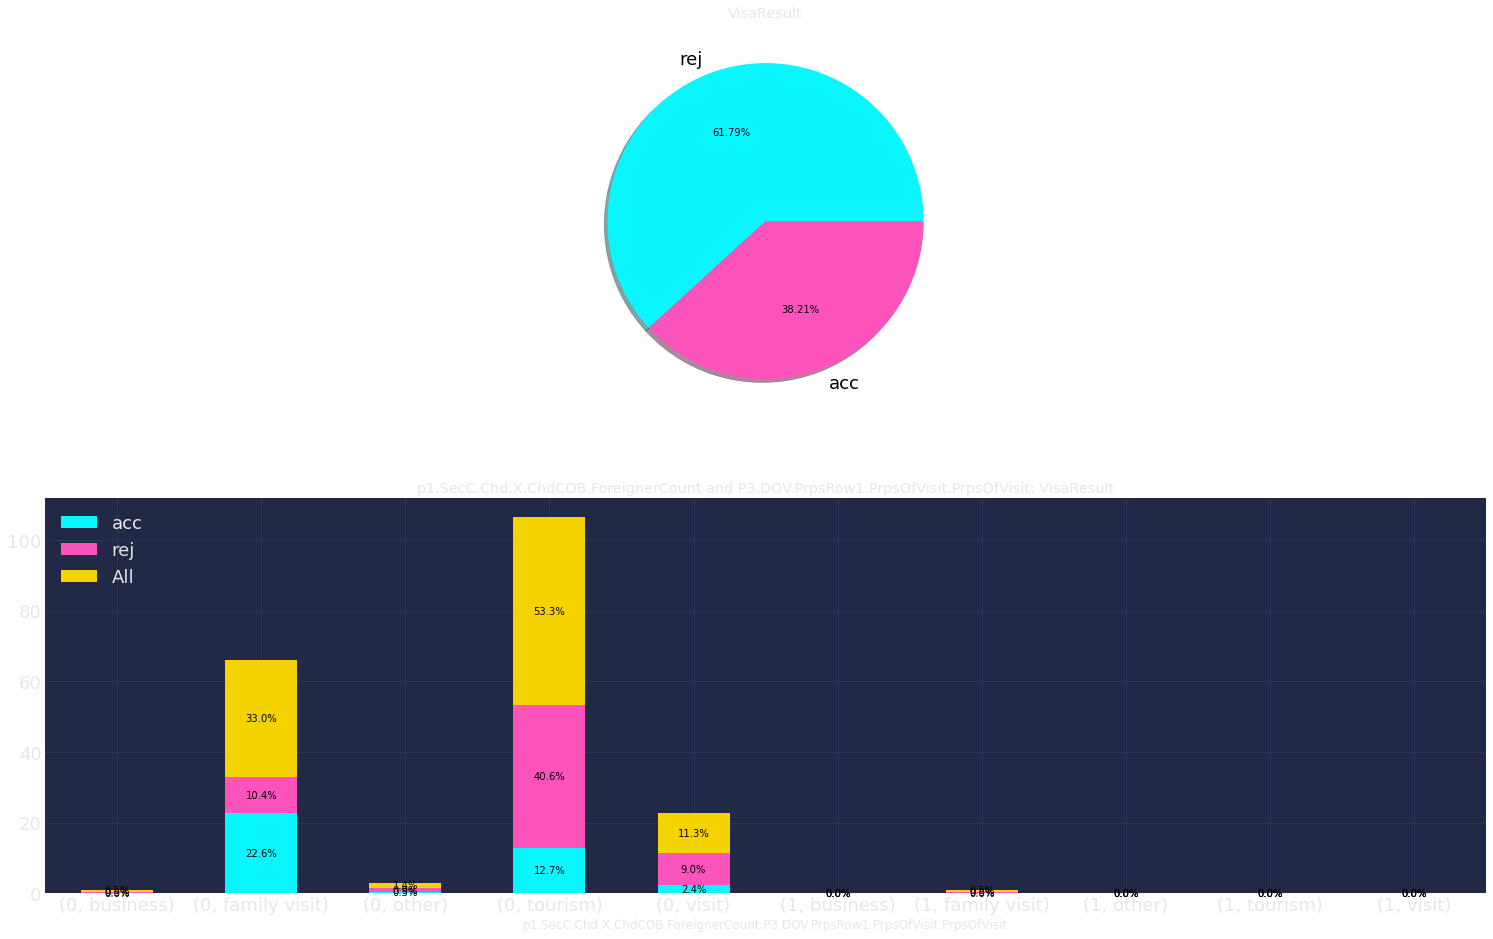

In [244]:
#nb>
f, ax = plt.subplots(2, 1, figsize=(23, 16))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color':'black'})
ax[0].set_title(output_name)
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1.1f%%', color='black')
plt.show()

#### p1.SecB.Chd.X.ChdCOB, p1.SecA.Mo.MoCOB, p1.SecA.Fa.FaCOB -> categorical

Convert the list of children/parents' country of birth to a single variable depicting how many foreigner children/parents the candidate has.

In [245]:
r = re.compile('p1.SecB.Chd.*.ChdCOB')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name.extend([c for c in data.columns.values if 'MoCOB' in c or 'FaCOB' in c or 'SpsCOB' in c])
display(feature_name)

['p1.SecB.Chd.[0].ChdCOB',
 'p1.SecB.Chd.[1].ChdCOB',
 'p1.SecB.Chd.[2].ChdCOB',
 'p1.SecB.Chd.[3].ChdCOB',
 'p1.SecA.Sps.SpsCOB',
 'p1.SecA.Mo.MoCOB',
 'p1.SecA.Fa.FaCOB']

In [246]:
output_name = 'VisaResult'
display(data.groupby([*feature_name, output_name])[output_name].count())

p1.SecB.Chd.[0].ChdCOB  p1.SecB.Chd.[1].ChdCOB  p1.SecB.Chd.[2].ChdCOB  p1.SecB.Chd.[3].ChdCOB  p1.SecA.Sps.SpsCOB  p1.SecA.Mo.MoCOB  p1.SecA.Fa.FaCOB  VisaResult
iran                    iran                    canada                  iran                    iran                iran              iran              rej             2
                                                iran                    iran                    iran                iran              iran              acc            81
                                                                                                                                                        no idea        56
                                                                                                                                                        rej           122
                                                                                                                                                        w-acc

In [247]:
# replace rows of previous country of residency to count of them
agg_column_name = 'p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_foreigner_family,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecB.Chd.X.ChdCOB.ForeignerCount'
data.drop(feature_name, axis=1, inplace=True)

In [248]:
display(data[data[agg_column_name] > 0][agg_column_name])

51     1
117    1
150    1
159    1
160    2
174    1
175    1
224    2
268    1
Name: p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount, dtype: int64

In [249]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [250]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                                acc  \
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                          business                                  0.000000   
                                           family visit                             22.641509   
                                           other                                     0.471698   
                                           tourism                                  12.735849   
                                           visit                                     2.358491   
1                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.000000   
                                           visit                                     0.000000   
2                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.000000   
                                           visit                                     0.000000   

VisaResult                                                                                rej  \
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                                          business                                  0.471698   
                                           family visit                              9.905660   
                                           other                                     0.943396   
                                           tourism                                  37.264151   
                                           visit                                     8.962264   
1                                          business                                  0.000000   
                                           family visit                              0.943396   
                                           other                                     0.000000   
                                           tourism                                   2.358491   
                                           visit                                     0.000000   
2                                          business                                  0.000000   
                                           family visit                              0.000000   
                                           other                                     0.000000   
                                           tourism                                   0.943396   
                                           visit                                     0.000000   

VisaResult                                                                                All  
p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                                          business                                  0.471698  
                                           family visit                             32.547170  
                                           other                                     1.415094  
                                           tourism                                  50.000000  
                                           visit                                    11.320755  
1                           

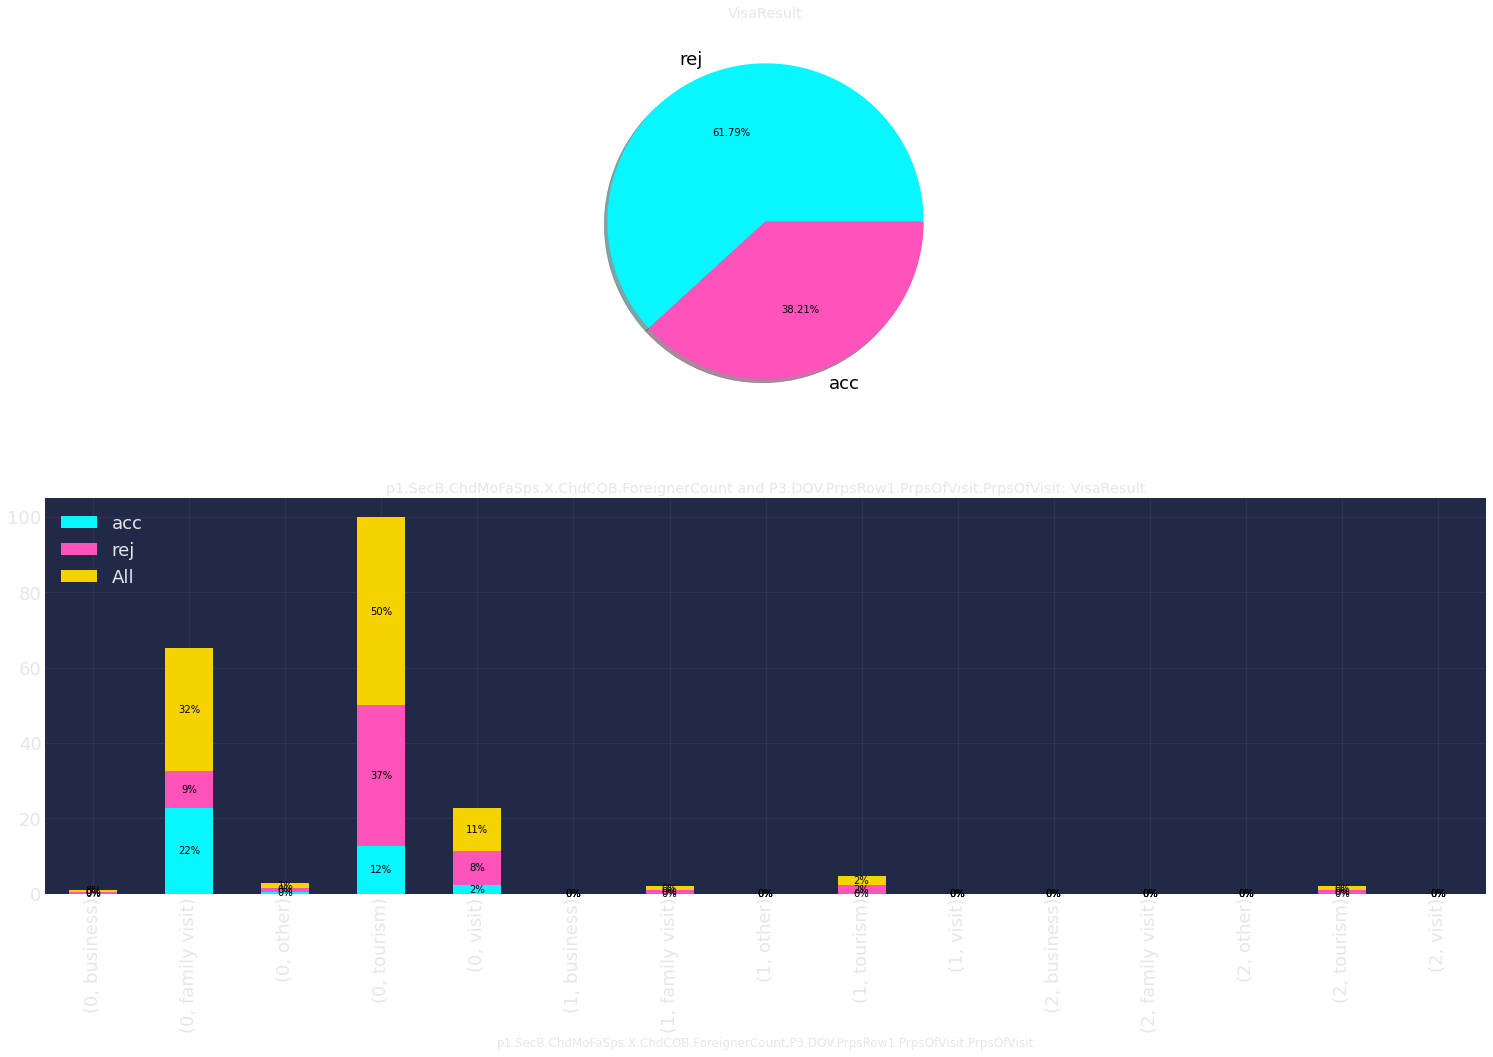

In [251]:
#nb>
f, ax = plt.subplots(2, 1, figsize=(23, 16))
data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name].value_counts().plot.pie(
    autopct='%1.2f%%', ax=ax[0], shadow=True, textprops={'color':'black'})
ax[0].set_title(output_name)
ax[0].set_ylabel('')

ct.plot(kind='bar', stacked=True, rot=90, ax=ax[1])
ax[1].set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax[1].legend(loc='upper left')
for c in ax[1].containers:
    ax[1].bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

### p1.SecA.App.ChdMStatus -> categorical[/rank?]

TODO: ask agents if we can rank type of marriage and convert this into a **ordered** list?

In [252]:
output_name = 'VisaResult'
feature_name = 'P1.MS.SecA.MS', 'p1.SecA.App.ChdMStatus'

display(data.groupby([*feature_name, output_name])[output_name].count())

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
divorced       3.0                     acc            4
                                       no idea        1
                                       rej            5
               8.0                     acc            1
married        5.0                     acc           64
                                       no idea       46
                                       rej           91
                                       w-acc         12
                                       w-rej         11
               6.0                     rej            1
               9.0                     acc            1
                                       no idea        2
                                       rej            3
single         5.0                     rej            1
               7.0                     acc            9
                                       no idea        7
                                       rej           2

There is some inconsistency between two fields, some cases person put `divorced` in one field, and `widowed` in another field. There are cases where second field has value of `9` (unknown), but in other field, filled with some valid value. so after fixing these inconsistencies, this field contains all information about marriage, so we can drop marriage status obtained from 5256e and use 5645e marital statuses.

In [253]:
display(data[data[feature_name[1]] == 9].groupby([*feature_name, output_name])[output_name].count())

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
married        9.0                     acc           1
                                       no idea       2
                                       rej           3
widowed        9.0                     acc           1
Name: VisaResult, dtype: int64

In [254]:
# convert numbers to names
ms_name_num = {
    'married': 5,
    'single': 7,
    'common-law': 2,
    'divorced': 3,
    'separated': 4,
    'widowed': 8,
    'annulled': 1,
}
data.loc[data[feature_name[1]] == 9, feature_name[1]] = data[data[feature_name[1]] == 9][feature_name[0]].apply(lambda x: ms_name_num[x])

# status=9 should no longer exist
display(data.groupby([*feature_name, output_name])[output_name].count())

P1.MS.SecA.MS  p1.SecA.App.ChdMStatus  VisaResult
divorced       3.0                     acc            4
                                       no idea        1
                                       rej            5
               8.0                     acc            1
married        5.0                     acc           65
                                       no idea       48
                                       rej           94
                                       w-acc         12
                                       w-rej         11
               6.0                     rej            1
single         5.0                     rej            1
               7.0                     acc            9
                                       no idea        7
                                       rej           28
                                       w-acc          2
                                       w-rej          5
widowed        8.0                     acc            

In [255]:
# drop useless
data.drop([feature_name[0]], axis=1, inplace=True)

### p1.SecA.Sps.SpsOcc -> categorical -> continuous

TODO: currently I don't know how convert jobs to continuous or ordered values, so, we just drop em all!

In [256]:
feature_name = [c for c in data.columns.values if (('Occ' in c) and ('OccRow' not in c))]
data.drop(feature_name, axis=1, inplace=True)

### p1.SecB.Chd.X.ChdAccomp -> categorical -> rank

Convert the list of tier 1 family members' accompanying status to a single variable depicting how many of them are accompanying the candidate.

In [257]:
r = re.compile('p1.SecB.Chd.*.ChdAccomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdAccomp',
 'p1.SecB.Chd.[1].ChdAccomp',
 'p1.SecB.Chd.[2].ChdAccomp',
 'p1.SecB.Chd.[3].ChdAccomp']

In [258]:
# replace rows of children's accompany status to count of them
agg_column_name = 'p1.SecB.Chd.X.ChdAccomp.Count'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_accompanying,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecB.Chd.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [259]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.Chd.X.ChdAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [260]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                   acc  \
p1.SecB.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.000000   
                              family visit                             19.811321   
                              other                                     0.471698   
                              tourism                                   7.547170   
                              visit                                     2.358491   
1                             business                                  0.000000   
                              family visit                              2.830189   
                              other                                     0.000000   
                              tourism                                   5.188679   
                              visit                                     0.000000   
2                             business                                  0.000000   
                              family visit                              0.000000   
                              other                                     0.000000   
                              tourism                                   0.000000   
                              visit                                     0.000000   

VisaResult                                                                   rej  \
p1.SecB.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.471698   
                              family visit                              9.433962   
                              other                                     0.943396   
                              tourism                                  29.716981   
                              visit                                     5.188679   
1                             business                                  0.000000   
                              family visit                              0.943396   
                              other                                     0.000000   
                              tourism                                   8.018868   
                              visit                                     1.415094   
2                             business                                  0.000000   
                              family visit                              0.471698   
                              other                                     0.000000   
                              tourism                                   2.830189   
                              visit                                     2.358491   

VisaResult                                                                   All  
p1.SecB.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                             business                                  0.471698  
                              family visit                             29.245283  
                              other                                     1.415094  
                              tourism                                  37.264151  
                              visit                                     7.547170  
1                             business                                  0.000000  
                              family visit                              3.773585  
                              other                                     0.000000  
                              tourism                                  13.207547  
                              visit                                     1.415094  
2                             business                                  0.000000  
                              family visit                     

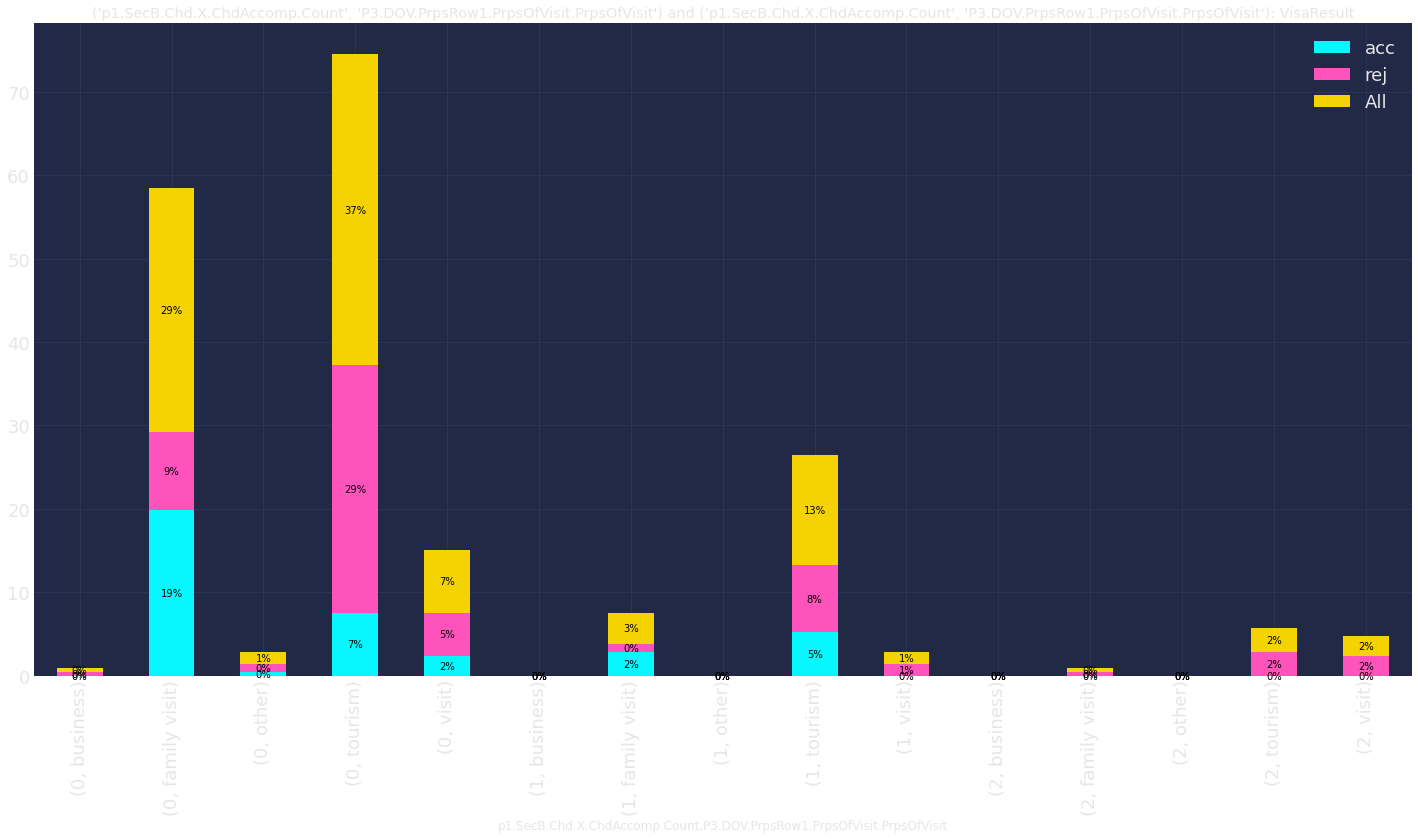

In [261]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

Following groups have higher chance:
1. `family visit` is generally good except with *large=`3`* family size
2. `family visit` chance decreases by increase in number of f1 family size
3. `tourism` chance increases by increasing the number of accompanying people
4. `visit` only is viable if you are going with `0` accompanying, not good if you going to `visit` with f1 member

### p1.SecA.Mo.MoAccomp, p1.SecA.Fa.FaAccomp -> categorical -> rank

In [262]:
r = re.compile('p1.*.(Fa|Mo)Accomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecA.Mo.MoAccomp', 'p1.SecA.Fa.FaAccomp']

In [263]:
# replace rows of Mo/Fa accompany status to count of them
agg_column_name = 'p1.SecA.ParAccomp.Count'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_accompanying,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecB.Chd.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [264]:
output_name = 'VisaResult'
feature_name = 'p1.SecA.ParAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [265]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                             acc  \
p1.SecA.ParAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                       business                                  0.000000   
                        family visit                             22.169811   
                        other                                     0.471698   
                        tourism                                  11.320755   
                        visit                                     2.358491   
1                       business                                  0.000000   
                        family visit                              0.471698   
                        other                                     0.000000   
                        tourism                                   0.000000   
                        visit                                     0.000000   
2                       business                                  0.000000   
                        family visit                              0.000000   
                        other                                     0.000000   
                        tourism                                   1.415094   
                        visit                                     0.000000   

VisaResult                                                             rej  \
p1.SecA.ParAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                       business                                  0.471698   
                        family visit                             10.849057   
                        other                                     0.943396   
                        tourism                                  37.735849   
                        visit                                     8.018868   
1                       business                                  0.000000   
                        family visit                              0.000000   
                        other                                     0.000000   
                        tourism                                   0.000000   
                        visit                                     0.943396   
2                       business                                  0.000000   
                        family visit                              0.000000   
                        other                                     0.000000   
                        tourism                                   2.830189   
                        visit                                     0.000000   

VisaResult                                                             All  
p1.SecA.ParAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                       business                                  0.471698  
                        family visit                             33.018868  
                        other                                     1.415094  
                        tourism                                  49.056604  
                        visit                                    10.377358  
1                       business                                  0.000000  
                        family visit                              0.471698  
                        other                                     0.000000  
                        tourism                                   0.000000  
                        visit                                     0.943396  
2                       business                                  0.000000  
                        family visit                              0.000000  
                        other                                     0.000000  
                        tourism                                   4.245283  
                        visit                                     0.000000

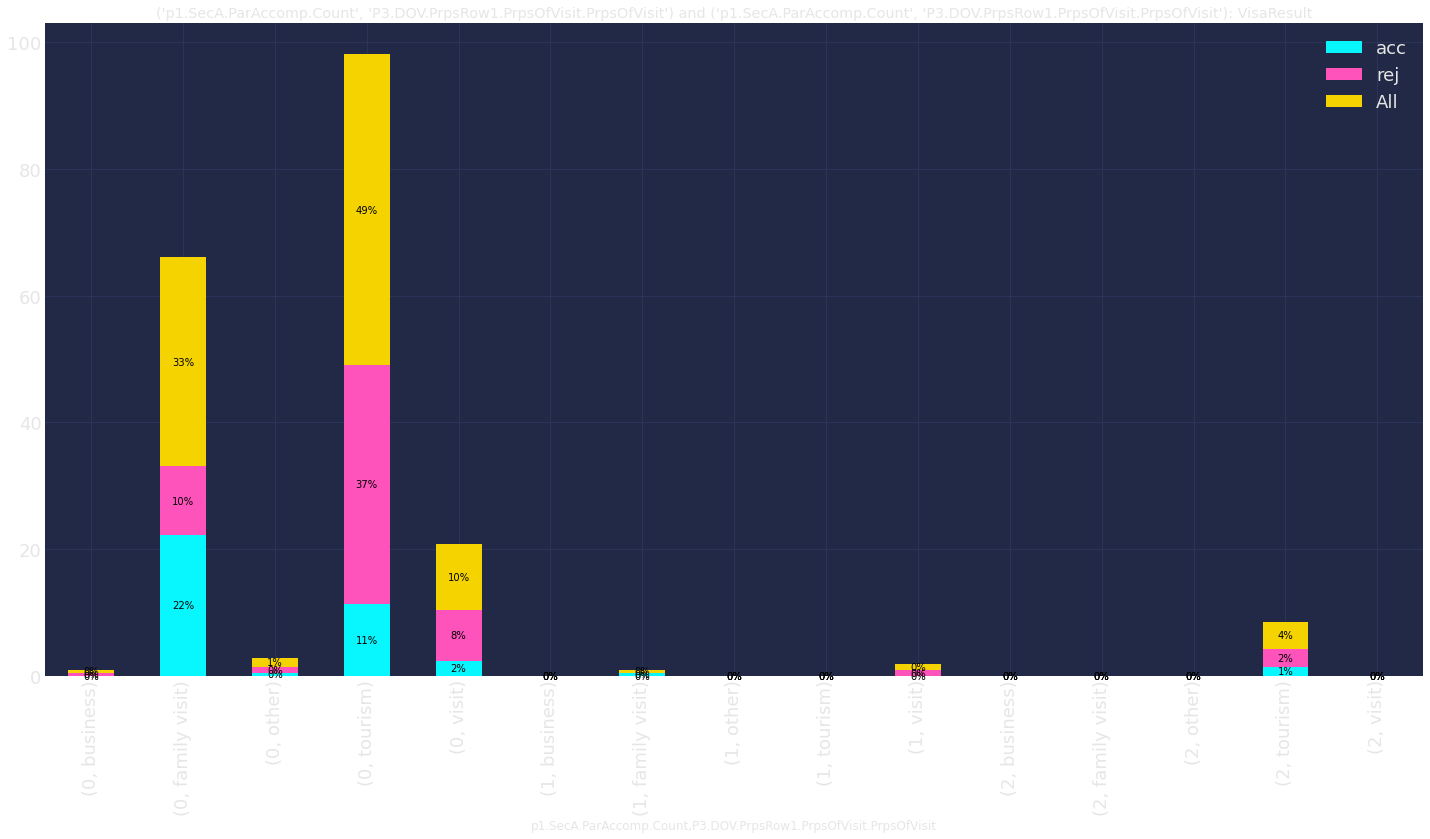

In [266]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

### p1.SecA.Sps.SpsAccomp -> categorical -> rank

In [267]:
r = re.compile('p1.SecA.Sps.SpsAccomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecA.Sps.SpsAccomp']

In [268]:
# replace rows of Spouse accompany status to count of them
agg_column_name = 'p1.SecA.Sps.SpsAccomp.Count'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_accompanying,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecB.Chd.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [269]:
output_name = 'VisaResult'
feature_name = 'p1.SecA.Sps.SpsAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [270]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                 acc  \
p1.SecA.Sps.SpsAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                           business                                  0.000000   
                            family visit                              8.490566   
                            other                                     0.471698   
                            tourism                                   2.358491   
                            visit                                     2.358491   
1                           business                                  0.000000   
                            family visit                             14.150943   
                            other                                     0.000000   
                            tourism                                  10.377358   
                            visit                                     0.000000   

VisaResult                                                                 rej  \
p1.SecA.Sps.SpsAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                           business                                  0.471698   
                            family visit                              8.962264   
                            other                                     0.943396   
                            tourism                                  15.566038   
                            visit                                     4.716981   
1                           business                                  0.000000   
                            family visit                              1.886792   
                            other                                     0.000000   
                            tourism                                  25.000000   
                            visit                                     4.245283   

VisaResult                                                                 All  
p1.SecA.Sps.SpsAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                           business                                  0.471698  
                            family visit                             17.452830  
                            other                                     1.415094  
                            tourism                                  17.924528  
                            visit                                     7.075472  
1                           business                                  0.000000  
                            family visit                             16.037736  
                            other                                     0.000000  
                            tourism                                  35.377358  
                            visit                                     4.245283

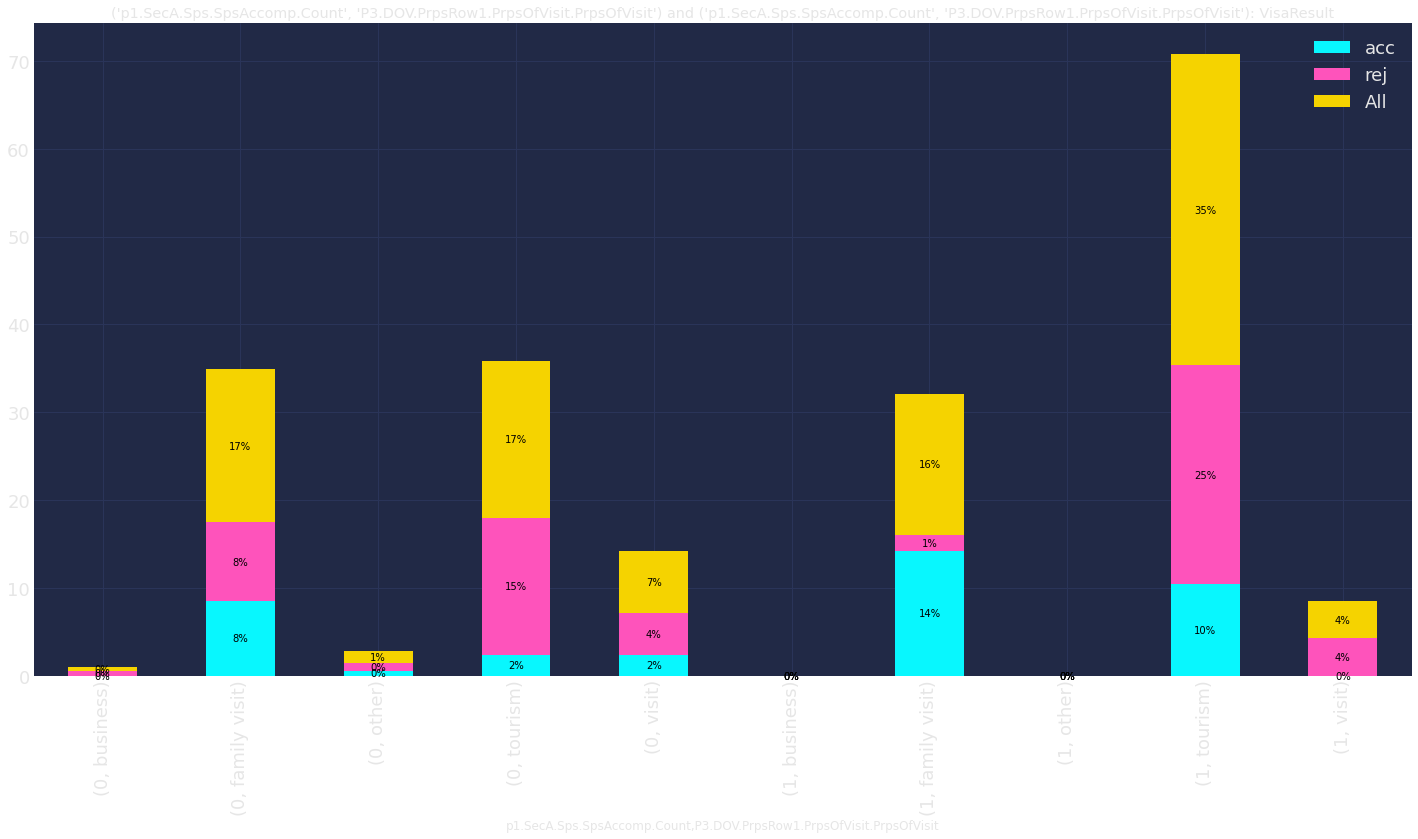

In [271]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

### p1.SecC.Chd.X.ChdAccomp -> categorical -> rank

Convert the list of tier 1 family members' accompanying status to a single variable depicting how many of them are accompanying the candidate.

In [272]:
r = re.compile('p1.SecC.Chd.*.ChdAccomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdAccomp',
 'p1.SecC.Chd.[1].ChdAccomp',
 'p1.SecC.Chd.[2].ChdAccomp',
 'p1.SecC.Chd.[3].ChdAccomp',
 'p1.SecC.Chd.[4].ChdAccomp',
 'p1.SecC.Chd.[5].ChdAccomp',
 'p1.SecC.Chd.[6].ChdAccomp']

In [273]:
# replace rows of previous country of residency to count of them
agg_column_name = 'p1.SecC.Chd.X.ChdAccomp.Count'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_accompanying,
                                   agg_column_name=agg_column_name, columns=feature_name)
# delete redundant columns tnx to newly created 'p1.SecC.Chd.X.ChdAccomp.Count'
data.drop(feature_name, axis=1, inplace=True)

In [274]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdAccomp.Count', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'

In [275]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                                   acc  \
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.000000   
                              family visit                             21.698113   
                              other                                     0.471698   
                              tourism                                  12.735849   
                              visit                                     2.358491   
1                             business                                  0.000000   
                              family visit                              0.943396   
                              other                                     0.000000   
                              tourism                                   0.000000   
                              visit                                     0.000000   

VisaResult                                                                   rej  \
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit              
0                             business                                  0.471698   
                              family visit                              9.905660   
                              other                                     0.943396   
                              tourism                                  38.679245   
                              visit                                     8.490566   
1                             business                                  0.000000   
                              family visit                              0.943396   
                              other                                     0.000000   
                              tourism                                   1.886792   
                              visit                                     0.471698   

VisaResult                                                                   All  
p1.SecC.Chd.X.ChdAccomp.Count P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit             
0                             business                                  0.471698  
                              family visit                             31.603774  
                              other                                     1.415094  
                              tourism                                  51.415094  
                              visit                                    10.849057  
1                             business                                  0.000000  
                              family visit                              1.886792  
                              other                                     0.000000  
                              tourism                                   1.886792  
                              visit                                     0.471698

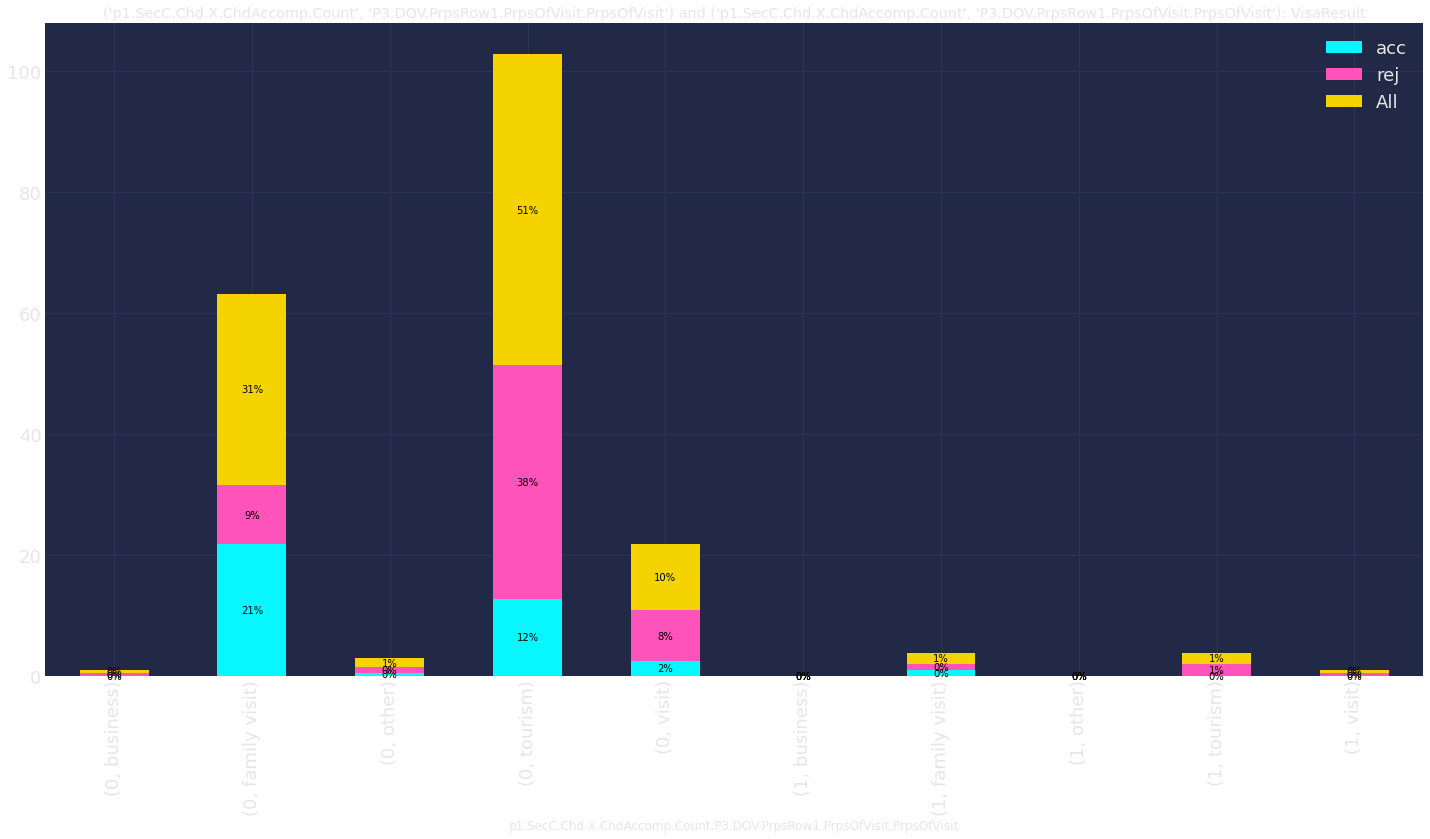

In [276]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

There is not much, except family visit which was already a dominant factor, regardless of the accompanying type and number. 

In [277]:
r = re.compile('.*Accomp')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
feature_name.extend(['P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit'])
display(feature_name)

['p1.SecB.Chd.X.ChdAccomp.Count',
 'p1.SecA.ParAccomp.Count',
 'p1.SecA.Sps.SpsAccomp.Count',
 'p1.SecC.Chd.X.ChdAccomp.Count',
 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit']

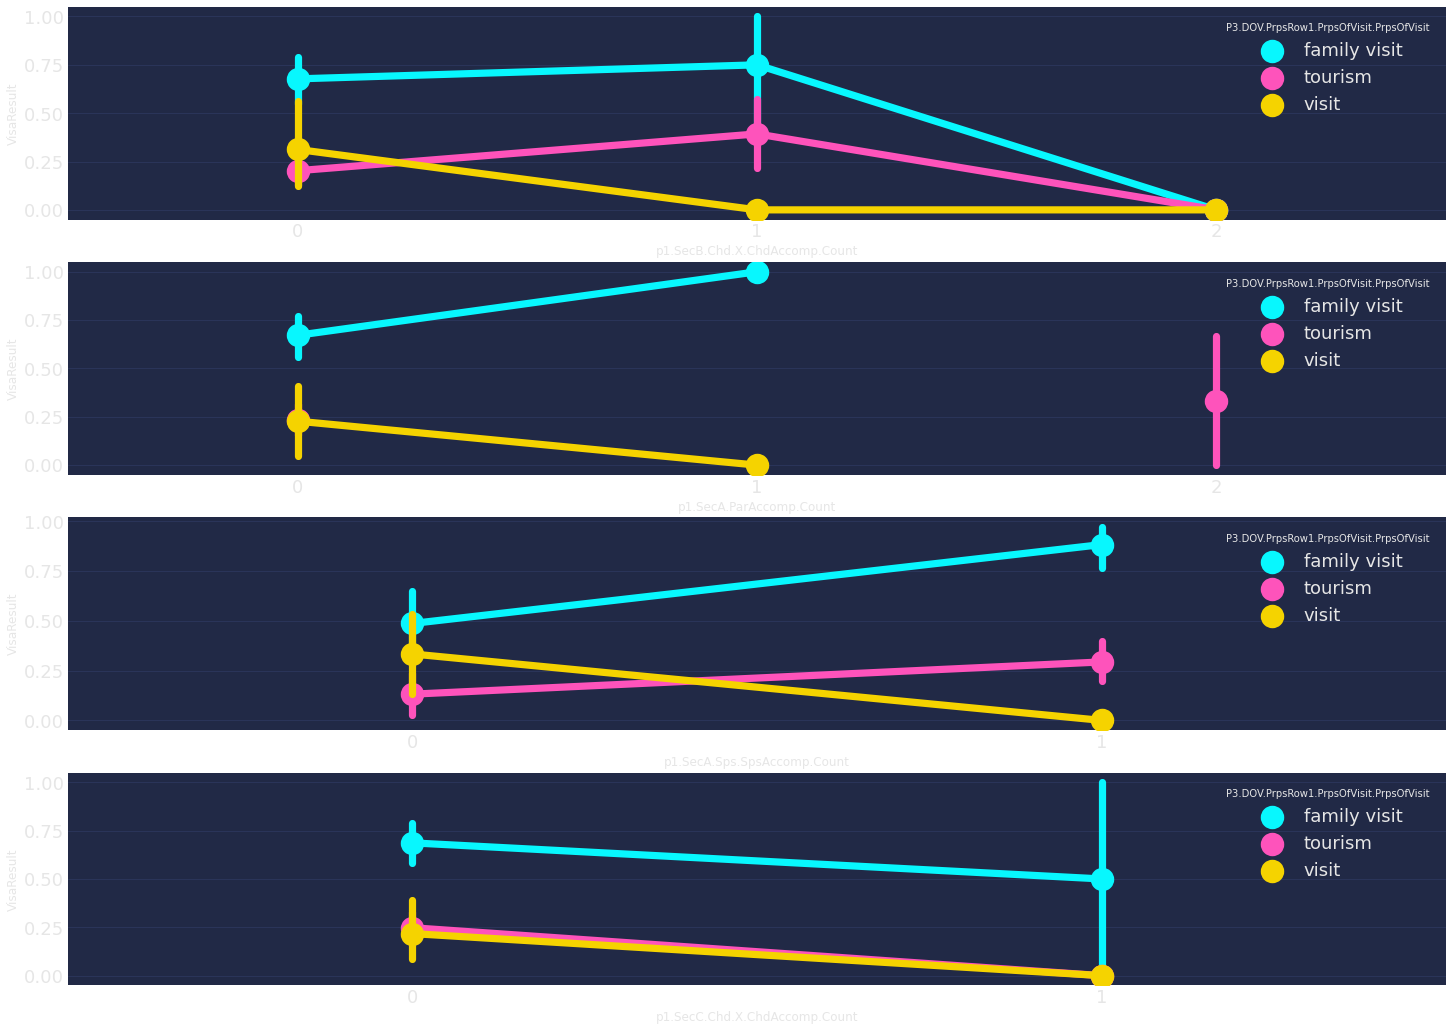

In [278]:
f, ax = plt.subplots(4, 1, figsize=(22, 18))
z = data[(data[output_name] == 'acc') | (data[output_name] == 'rej')].copy()
z = z[(z[feature_name[-1]] != 'other') & (z[feature_name[-1]] != 'business')]
z[output_name] = z[output_name].apply(lambda x: True if x == 'acc' else False)

for i in range(4):
    sns.pointplot(x=feature_name[i], y=output_name, hue=feature_name[-1],
                data=z, 
                kind='point', ax=ax[i])
plt.show()

Insights:
1. It is clear that bringing any of `siblings` is very risky and decrease chance even for `family visit` which all the time increased the chance!
2. Bringing `spouse` for `visit` purpose is a terrible idea

### p1.SecA.Sps.SpsDOB.Period -> continuous

In [279]:
output_name = 'VisaResult'
feature_name = ['p1.SecA.Sps.SpsDOB.Period', 'p1.SecA.Mo.MoDOB.Period', 'p1.SecA.Fa.FaDOB.Period']
display(data[feature_name].isna().sum())

p1.SecA.Sps.SpsDOB.Period    0
p1.SecA.Mo.MoDOB.Period      0
p1.SecA.Fa.FaDOB.Period      0
dtype: int64

In [280]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

We have deceased people and their age has been calculated from the day the data has been gathered. I.e. If someone died 30 years before the data was gathered, I still calculate the age like the person is still alive (when a bug makes a lot of copium!). Here, we set max age to 85 (❁´◡`❁).

In [281]:
data[feature_name] = data[feature_name].applymap(lambda x: 85. if x > 85 else x)

p1.SecA.Sps.SpsDOB.Period  p1.SecA.Mo.MoDOB.Period  \
count                 298.000000               298.000000   
mean                   35.161690                61.707474   
std                    22.558734                22.381942   
min                     0.000000                 0.000000   
25%                    27.738356                57.422603   
50%                    37.652055                66.598630   
75%                    49.545205                74.417808   
max                    84.306849                85.000000   

       p1.SecA.Fa.FaDOB.Period  
count               298.000000  
mean                 63.301756  
std                  26.379887  
min                   0.000000  
25%                  61.304795  
50%                  70.664384  
75%                  82.060959  
max                  85.000000

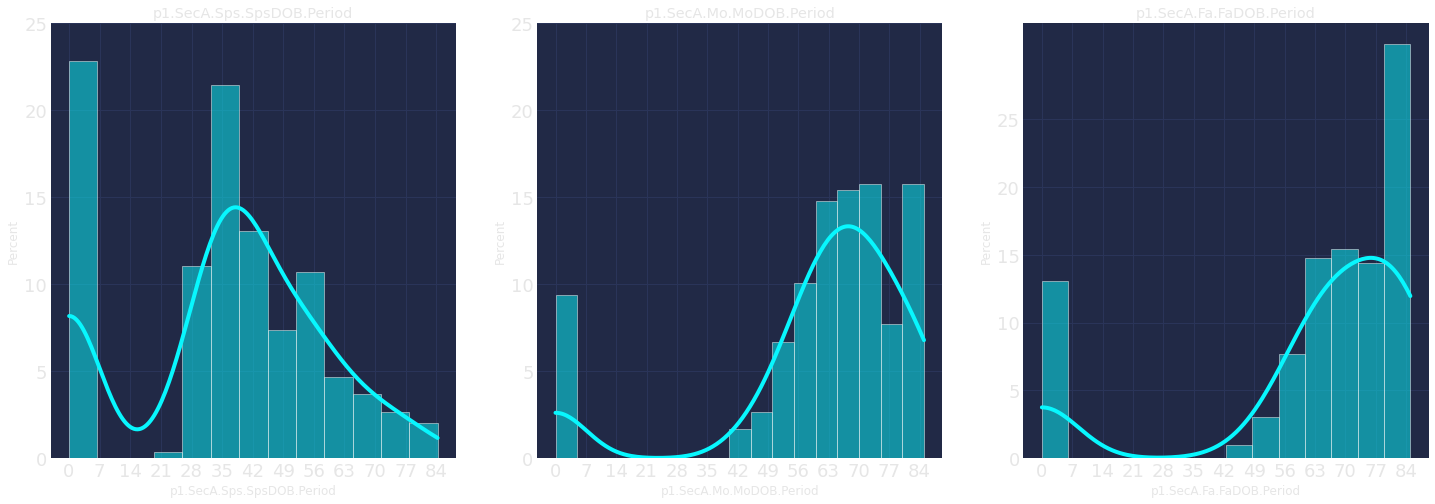

In [282]:
#nb>
display(data[feature_name].describe())

f, ax = plt.subplots(1, 3, figsize=(22, 8))
for i, c in enumerate(feature_name):
    sns.histplot(data[c], ax=ax[i], kde=True, stat='percent')
    ax[i].set_title('{}'.format(c))
    ax[i].set_xticks(range(0, 90, 7), rotation='vertical', ha='right')
    ax[i].set_yticks(range(0, 30, 5))
plt.show()

### p1.SecB.Chd.[X].ChdDOB.Period and p1.SecB.Chd.[X].ChdMStatus and p1.SecB.Chd.[X].ChdRel

In [283]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdDOB.Period',
 'p1.SecB.Chd.[1].ChdDOB.Period',
 'p1.SecB.Chd.[2].ChdDOB.Period',
 'p1.SecB.Chd.[3].ChdDOB.Period']

In [284]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [285]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdMStatus',
 'p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdMStatus',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdMStatus',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdMStatus',
 'p1.SecB.Chd.[3].ChdRel']

I am going to use above features to find "ghost" and "incomplete" kids and fill them out properly. So, none of them should be `None`.

In [286]:
assert data[feature_name].isna().sum().sum() == 0

#### Fill `None`s of p1.SecB.Chd.[X].ChdDOB.Period

In [287]:
r = re.compile('p1.SecB.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
display(data[list(data.columns.values[mask])].isna().sum())

p1.SecB.Chd.[0].ChdDOB.Period    5
p1.SecB.Chd.[1].ChdDOB.Period    3
p1.SecB.Chd.[2].ChdDOB.Period    0
p1.SecB.Chd.[3].ChdDOB.Period    0
dtype: int64

Note that there are two types of `None`s originally:
1. Ghost children: Where child doest not exist at the first place and we filled `ChdRel = 'OTHER'` and `ChdMStatus = 9`, and `ChdDOB.Period = 0`. Already done when loading data.
2. Incomplete children: Where child exists but `ChdDOB.Period` is `None`. We like to fill this by other children if exists (already done when loading data), but when there is no other child or all children are missing `ChdDOB.Period`, we have to use statistical measure over all dataset to fill it. E.g. average difference of children's age from their parents decreased from missing cases' parent age.

In [288]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period'
    display(data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

0

0

0

0

We have no instances of case (1) that has not been handled already.

In [289]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period'
    display(data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

3

2

0

0

In [290]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    display(data[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
          (data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
40                          6.0                    SON   
261                         6.0               DAUGHTER   
280                         6.0                    SON   

     p1.SecB.Chd.[0].ChdDOB.Period  
40                             NaN  
261                            NaN  
280                            NaN

p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
40                          6.0               DAUGHTER   
261                         6.0               DAUGHTER   

     p1.SecB.Chd.[1].ChdDOB.Period  
40                             NaN  
261                            NaN

Empty DataFrame
Columns: [p1.SecB.Chd.[2].ChdMStatus, p1.SecB.Chd.[2].ChdRel, p1.SecB.Chd.[2].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecB.Chd.[3].ChdMStatus, p1.SecB.Chd.[3].ChdRel, p1.SecB.Chd.[3].ChdDOB.Period]
Index: []

As we can see, case (2) is existence here. Now, I fill it!

In [291]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdMStatus',
 'p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdMStatus',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdMStatus',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdMStatus',
 'p1.SecB.Chd.[3].ChdRel']

In [292]:
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
aggregator_feature_name = 'P1.PD.DOBYear.Period'
for i in range(len(feature_name) // 2):
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median().item()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median().item()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    display('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    # parent who have children but their children have no age
    na_parent_age = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    # fill the age of "parent who have children but their children have no age"
    data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

'median difference of parents age from "0"th child: 28.938356164383556'

'median difference of parents age from "1"th child: 31.83698630136986'

'median difference of parents age from "2"th child: 28.564383561643837'

'median difference of parents age from "3"th child: 33.45890410958904'

In [293]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[38, 256, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[38, 256]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
40                          6.0                    SON   
261                         6.0               DAUGHTER   
280                         6.0                    SON   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
40                        7.130137             36.068493  
261                      15.938356             44.876712  
280                       1.000000             27.991781

p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
40                          6.0               DAUGHTER   
261                         6.0               DAUGHTER   

     p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
40                        4.231507             36.068493  
261                      13.039726             44.876712

So I managed to clap the cheeks of those who didn't fill out their damn children's age.

#### Fill `None`s of p1.SecB.Chd.[X].ChdDOB.Period (case 2 but also rel missing)

In [294]:
r = re.compile('p1.SecB.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
display(data[list(data.columns.values[mask])].isna().sum())

p1.SecB.Chd.[0].ChdDOB.Period    2
p1.SecB.Chd.[1].ChdDOB.Period    1
p1.SecB.Chd.[2].ChdDOB.Period    0
p1.SecB.Chd.[3].ChdDOB.Period    0
dtype: int64

In [295]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    display(data[(data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  
43                             NaN  
124                            NaN

p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  
43                            NaN

Empty DataFrame
Columns: [p1.SecB.Chd.[2].ChdMStatus, p1.SecB.Chd.[2].ChdRel, p1.SecB.Chd.[2].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecB.Chd.[3].ChdMStatus, p1.SecB.Chd.[3].ChdRel, p1.SecB.Chd.[3].ChdDOB.Period]
Index: []

In [296]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[41, 120]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[41]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
43                             NaN             46.939726  
124                            NaN             25.989041

p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
43                            NaN             46.939726

In [297]:
target_feature_name = [
    'p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median().item()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median().item()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    display('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    # parent who have children but their children have no age and some other features (e.g. rel)
    na_parent_age = data.loc[(data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    # fill the age of "parent who have children but their children have no age and some other features (e.g. rel)"
    data.loc[(data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

'median difference of parents age from "0"th child: 29.467123287671228'

'median difference of parents age from "1"th child: 32.25068493150685'

'median difference of parents age from "2"th child: 28.564383561643837'

'median difference of parents age from "3"th child: 33.45890410958904'

In [298]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[41, 120]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecB.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[41]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
43                          6.0                  OTHER   
124                         6.0                  OTHER   

     p1.SecB.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
43                       17.472603             46.939726  
124                       1.000000             25.989041

p1.SecB.Chd.[1].ChdMStatus p1.SecB.Chd.[1].ChdRel  \
43                         6.0                  OTHER   

    p1.SecB.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
43                      14.689041             46.939726

### p1.SecB.Chd.[X].ChdRel -> categorical

Since there are some `other` in `ChdRel` here that are not "ghost case", we use `ChdDOB.Period` that have been already cleaned and filled based on conditions to detect "ghost" case from "incomplete" case. Hence, in this section, we just rely on non-zero cases of `ChdDOB.Period` to find out if child exists or not!

In [299]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdRel']

In [300]:
for f in feature_name:
    display(data[f].unique())

dic = {
    'DOUGHTER': 'daughter',
    'my daughter': 'daughter',
    'STEPDAUGHTER': 'step daughter',
    'STEP SON': 'step son',
    'SISTER': 'daughter',
    'BOY': 'son',
    'STEP DAUGHTER': 'step daughter',
    'STEP-SON': 'step son',
    'OTHER': 'other'
}

step_typo = {
    'step son': 'son',
    'step daughter': 'daughter'
}

for f in feature_name:
    data[f] = data[f].apply(lambda x: dic[x] if x in dic.keys() else x.lower())
    data[f] = data[f].apply(str.lower)
    data[f] = data[f].apply(functional.fix_typo, args=(step_typo, None, ))


display('--- cleaned ---')
for f in feature_name:
    display(data[f].unique())

array(['DAUGHTER', 'SON', 'OTHER', 'son', 'Daughter', 'DOUGHTER',
       'my daughter', 'STEPDAUGHTER', 'daughter', 'STEP SON', 'SISTER',
       'BOY'], dtype=object)

array(['SON', 'OTHER', 'DAUGHTER', 'daughter', 'Daughter', 'DOUGHTER',
       'son', 'SISTER'], dtype=object)

array(['SON', 'OTHER', 'son', 'DAUGHTER', 'SISTER', 'STEP DAUGHTER',
       'STEP-SON', 'DOUGHTER'], dtype=object)

array(['OTHER', 'SON', 'DAUGHTER', 'SISTER', 'STEP-SON'], dtype=object)

'--- cleaned ---'

array(['daughter', 'son', 'other'], dtype=object)

array(['son', 'other', 'daughter'], dtype=object)

array(['son', 'other', 'daughter'], dtype=object)

array(['other', 'son', 'daughter'], dtype=object)

In [301]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecB.Chd.[0].ChdDOB.Period',
 'p1.SecB.Chd.[1].ChdDOB.Period',
 'p1.SecB.Chd.[2].ChdDOB.Period',
 'p1.SecB.Chd.[3].ChdDOB.Period']

In [302]:
# replace rows of previous country of residency to count of them
agg_column_name = 'p1.SecB.Chd.X.ChdRel.ChdCount'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_rel,
                                   agg_column_name=agg_column_name, columns=feature_name)

In [303]:
#nb>
data[[*feature_name, agg_column_name]]

p1.SecB.Chd.[0].ChdDOB.Period  p1.SecB.Chd.[1].ChdDOB.Period  \
0                        35.498630                      34.482192   
1                        18.671233                       0.000000   
2                         2.378082                       0.000000   
3                         0.000000                       0.000000   
4                         0.000000                       0.000000   
..                             ...                            ...   
300                      21.821918                       0.000000   
301                       7.065753                       0.000000   
302                      46.950685                      45.402740   
303                       0.000000                       0.000000   
304                       0.000000                       0.000000   

     p1.SecB.Chd.[2].ChdDOB.Period  p1.SecB.Chd.[3].ChdDOB.Period  \
0                         7.350685                       0.000000   
1                         0.000000                       0.000000   
2                         0.000000                       0.000000   
3                         0.000000                       0.000000   
4                         0.000000                       0.000000   
..                             ...                            ...   
300                       0.000000                       0.000000   
301                       0.000000                       0.000000   
302                      40.783562                      31.778082   
303                       0.000000                       0.000000   
304                       0.000000                       0.000000   

     p1.SecB.Chd.X.ChdRel.ChdCount  
0                                3  
1                                1  
2                                1  
3                                0  
4                                0  
..                             ...  
300                              1  
301                              1  
302                              4  
303                              0  
304                              0  

[298 rows x 5 columns]

#### Filling None "ghost case" `other` Randomly

This part is about converting `OTHER` as child-parent relation into `SON` or `DAUGHTER`. Possible methods:
1. Should I even do it? There is no context information to infer and filling it statistically is not rational
2. Biased random fill:
   1. with 50% chance if no kid or all kids are `OTHER`
   2. 75% to be boy if more than half of the kids are *girl*
   3. 25% to be boy if more than half of the kids are *boy*
3. Pure random fill: Just use %50 for any `OTHER` case <- **CURRENT IMPL.** 

I may wanna convert these into `['son', 'daughter', 'other']` or `['son', 'daughter', 'step', 'other']`

In [304]:
output_name = 'VisaResult'
r = re.compile('p1.SecB.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
r = re.compile('p1.SecB.Chd\.\[.*\]\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
target_feature_name = list(data.columns.values[mask])
display(feature_name)
display(target_feature_name)

['p1.SecB.Chd.[0].ChdDOB.Period',
 'p1.SecB.Chd.[1].ChdDOB.Period',
 'p1.SecB.Chd.[2].ChdDOB.Period',
 'p1.SecB.Chd.[3].ChdDOB.Period']

['p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdRel',
 'p1.SecB.Chd.[3].ChdRel']

In [305]:
for f, tf in zip(feature_name, target_feature_name):
    rng = np.random.default_rng(SEED)
    random_child = 'son' if rng.random() > 0.5 else 'daughter'
    data.loc[(data[f] != 0) & (data[tf] == 'other'), tf] = random_child

In [306]:
#nb>
data[[*feature_name, *target_feature_name]].sample(5, random_state=SEED)

p1.SecB.Chd.[0].ChdDOB.Period  p1.SecB.Chd.[1].ChdDOB.Period  \
146                       0.000000                       0.000000   
234                      19.232877                       9.805479   
287                       0.000000                       0.000000   
197                       9.421918                       0.000000   
69                       54.668493                      51.123288   

     p1.SecB.Chd.[2].ChdDOB.Period  p1.SecB.Chd.[3].ChdDOB.Period  \
146                       0.000000                            0.0   
234                       2.567123                            0.0   
287                       0.000000                            0.0   
197                       0.000000                            0.0   
69                       41.553425                            0.0   

    p1.SecB.Chd.[0].ChdRel p1.SecB.Chd.[1].ChdRel p1.SecB.Chd.[2].ChdRel  \
146                  other                  other                  other   
234                    son               daughter               daughter   
287                  other                  other                  other   
197               daughter                  other                  other   
69                     son               daughter                    son   

    p1.SecB.Chd.[3].ChdRel  
146                  other  
234                  other  
287                  other  
197                  other  
69                   other

In [307]:
#nb>
data.sample(1, random_state=SEED)

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
146                                              False             Male   

     P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
146                    1.107154                        1.0   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
146                    1.429856                    1.429856   

    P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status  \
146                    False                Georgia                    6.0   

    P2.MS.SecA.PrevMarrIndicator P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  \
146                        False                                 tourism   

     P3.DOV.PrpsRow1.Funds.Funds  \
146                       6000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
146                                              hotel     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
146                                        hotel               False   

    P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Country.Country  \
146                        unedu                              1.0   

    P3.Occ.OccRow1.Occ.Occ  P3.Occ.OccRow1.Country.Country  \
146               employee                        1.107154   

    P3.Occ.OccRow2.Occ.Occ  P3.Occ.OccRow2.Country.Country  \
146                  OTHER                        1.107154   

    P3.Occ.OccRow3.Occ.Occ  P3.Occ.OccRow3.Country.Country P3.noAuthStay  \
146                  OTHER                        1.107154         False   

    P3.refuseDeport P3.BGI2.PrevApply  P1.PD.DOBYear.Period  \
146           False             False             46.673973   

     P1.PD.PrevCOR.Row2.Period  P1.PD.PrevCOR.Row3.Period  \
146                        0.0                        0.0   

     P1.PD.CWA.Row2.Period  P1.MS.SecA.DateOfMarr.Period  P2.MS.SecA.Period  \
146                   29.0                     11.147945                0.0   

     P2.MS.SecA.Psprt.ExpiryDate.Remaining  P3.DOV.PrpsRow1.HLS.Period  \
146                              60.033333                        11.0   

     P3.Edu.Edu_Row1.Period  P3.Occ.OccRow1.Period  P3.Occ.OccRow2.Period  \
146                     0.0              11.649315                    0.0   

     P3.Occ.OccRow3.Period                        p1.SecA.App.AppAddr  \
146                    0.0  NO.88-BEHDARI TOWN-MOAZEN BLVD-KARAJ-IRAN   

     p1.SecA.App.ChdMStatus                        p1.SecA.Sps.SpsAddr  \
146                     5.0  NO.88-BEHDARI TOWN-MOAZEN BLVD-KARAJ-IRAN   

                                    p1.SecA.Mo.MoAddr  p1.SecA.Mo.ChdMStatus  \
146  SHAHID FAHMIDEH SQ-KARKHANEH GHAND CR-KARAJ-IRAN                    9.0   

                                    p1.SecA.Fa.FaAddr  p1.SecA.Fa.ChdMStatus  \
146  SHAHID FAHMIDEH SQ-KARKHANEH GHAND CR-KARAJ-IRAN                    9.0   

     p1.SecB.Chd.[0].ChdMStatus p1.SecB.Chd.[0].ChdRel  \
146                         9.0                  other   

    p1.SecB.Chd.[0].ChdAddr  p1.SecB.Chd.[1].ChdMStatus  \
146                    None                         9.0   

    p1.SecB.Chd.[1].ChdRel p1.SecB.Chd.[1].ChdAddr  \
146                  other                    None   

     p1.SecB.Chd.[2].ChdMStatus p1.SecB.Chd.[2].ChdRel  \
146                         9.0                  other   

    p1.SecB.Chd.[2].ChdAddr  p1.SecB.Chd.[3].ChdMStatus  \
146                    None                         9.0   

    p1.SecB.Chd.[3].ChdRel p1.SecB.Chd.[3].ChdAddr  \
146                  other                    None   

     p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
146                         5.0                 SISTER   

                               p1.SecC.Chd.[0].ChdAddr  \
146  NO.14-NILOUFAR ALLEY-BESAT BLVD-ASBI SQ.-AZIMI...   

     p1.SecC.Chd.[1].ChdMStatus p1.SecC.Chd.[1].ChdRel  \
146                         5.0                 SISTER   

             p1.SecC.Chd.[1].ChdAddr  

In [308]:
output_name = 'VisaResult'
feature_name = 'p1.SecB.Chd.X.ChdAccomp.Count', 'p1.SecB.Chd.X.ChdRel.ChdCount'

In [309]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                         acc  \
p1.SecB.Chd.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount              
0                             0                               7.547170   
                              1                               4.245283   
                              2                              10.849057   
                              3                               2.830189   
                              4                               4.716981   
1                             0                               0.000000   
                              1                               4.716981   
                              2                               1.415094   
                              3                               1.886792   
                              4                               0.000000   
2                             0                               0.000000   
                              1                               0.000000   
                              2                               0.000000   
                              3                               0.000000   
                              4                               0.000000   

VisaResult                                                         rej  \
p1.SecB.Chd.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount              
0                             0                              29.245283   
                              1                               6.603774   
                              2                               6.603774   
                              3                               1.886792   
                              4                               1.415094   
1                             0                               0.000000   
                              1                               9.433962   
                              2                               0.943396   
                              3                               0.000000   
                              4                               0.000000   
2                             0                               0.000000   
                              1                               0.000000   
                              2                               5.660377   
                              3                               0.000000   
                              4                               0.000000   

VisaResult                                                         All  
p1.SecB.Chd.X.ChdAccomp.Count p1.SecB.Chd.X.ChdRel.ChdCount             
0                             0                              36.792453  
                              1                              10.849057  
                              2                              17.452830  
                              3                               4.716981  
                              4                               6.132075  
1                             0                               0.000000  
                              1                              14.150943  
                              2                               2.358491  
                              3                               1.886792  
                              4                               0.000000  
2                             0                               0.000000  
                              1                               0.000000  
                              2                               5.660377  
                              3                               0.000000  
                              4                               0.000000

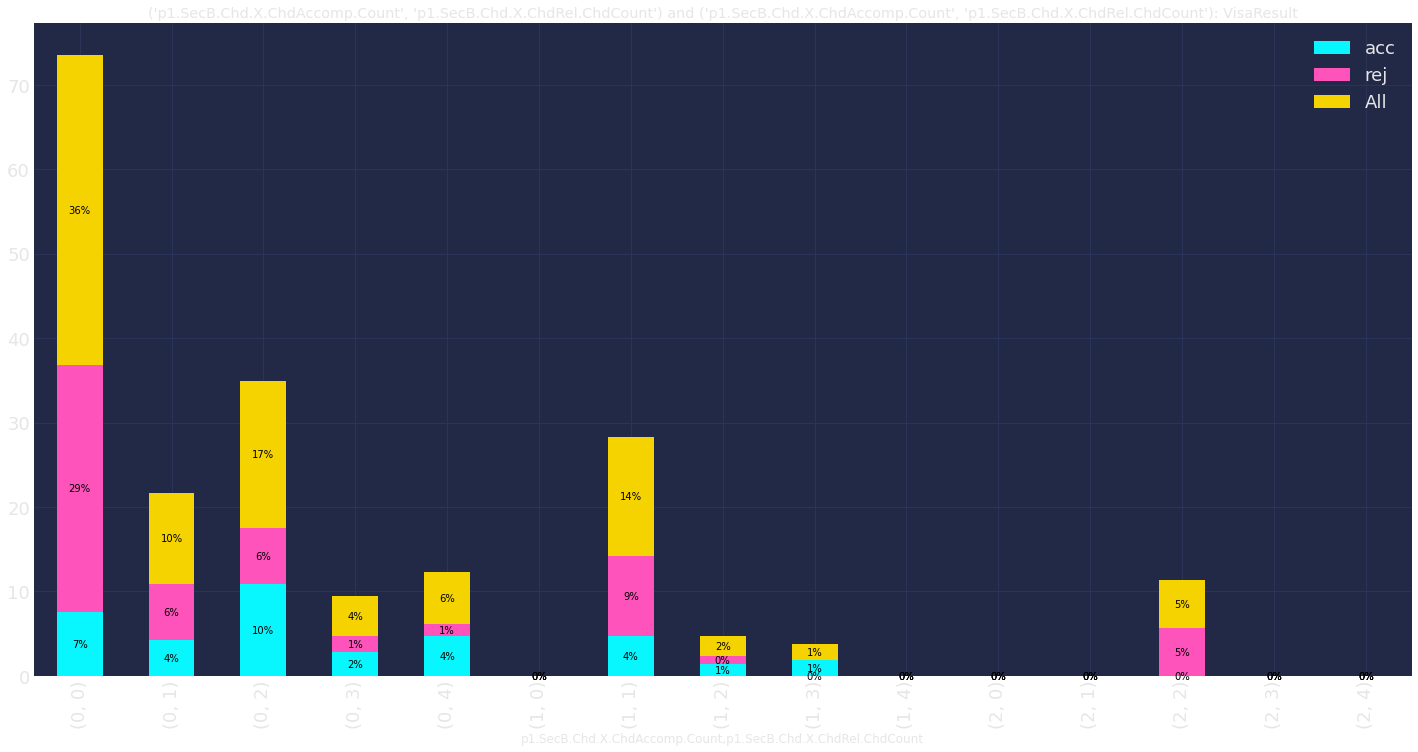

In [310]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

Obviously, the children you have and fewer of them are coming with you, the higher chance you have!

### p1.SecC.Chd.[X].ChdDOB.Period and p1.SecC.Chd.[X].ChdMStatus and p1.SecC.Chd.[X].ChdRel

In [311]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdDOB.Period',
 'p1.SecC.Chd.[1].ChdDOB.Period',
 'p1.SecC.Chd.[2].ChdDOB.Period',
 'p1.SecC.Chd.[3].ChdDOB.Period',
 'p1.SecC.Chd.[4].ChdDOB.Period',
 'p1.SecC.Chd.[5].ChdDOB.Period',
 'p1.SecC.Chd.[6].ChdDOB.Period']

In [312]:
# convert to years but continuous
data[feature_name] = data[feature_name].apply(lambda x: x/365.)

In [313]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdMStatus',
 'p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdMStatus',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdMStatus',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdMStatus',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdMStatus',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdMStatus',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdMStatus',
 'p1.SecC.Chd.[6].ChdRel']

I am going to use above features to find "ghost" and "incomplete" siblings and fill them out properly. So, none of them should be `None`.

In [314]:
assert data[feature_name].isna().sum().sum() == 0

#### Fill `None`s of p1.SecC.Chd.[X].ChdDOB.Period

In [315]:
r = re.compile('p1.SecC.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
display(data[list(data.columns.values[mask])].isna().sum())

p1.SecC.Chd.[0].ChdDOB.Period    22
p1.SecC.Chd.[1].ChdDOB.Period    22
p1.SecC.Chd.[2].ChdDOB.Period    22
p1.SecC.Chd.[3].ChdDOB.Period    22
p1.SecC.Chd.[4].ChdDOB.Period    22
p1.SecC.Chd.[5].ChdDOB.Period    22
p1.SecC.Chd.[6].ChdDOB.Period    22
dtype: int64

Note that there are two types of `None`s originally:
1. Ghost siblings: Where sibling doest not exist at the first place and we filled `ChdRel = 'OTHER'` and `ChdMStatus = 9`, and `ChdDOB.Period = 0`. Already done when loading data.
2. Incomplete siblings: Where sibling exists but `ChdDOB.Period` is `None`. We like to fill this by other siblings if exist (already done when loading data), but when there is no other sibling or all siblings are missing `ChdDOB.Period`, we have to use statistical measure over all dataset to fill it. E.g. average difference of sibling's age from the main applicant decreased from missing cases' main applicant's age.

In [316]:
# ghost siblings' age must be zero
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER'), target_feature_name] = 0.

In [317]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    display(data.loc[(data[feature_name[i*2]] == 9) & (data[feature_name[i*2+1]] == 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

0

0

0

0

0

0

0

We have no instances of case (1) that has not been handled already.

In [318]:
for i in range(len(feature_name) // 2):
    target_feature_name = 'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period'
    display(data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') & (data[target_feature_name].isna()), target_feature_name].isna().sum())

8

7

4

3

3

3

3

In [319]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    display(data[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
          (data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
87                          5.0                 SISTER   
97                          7.0                 SISTER   
170                         5.0                 SISTER   
219                         5.0                BROTHER   
261                         5.0                BROTHER   
265                         5.0                BROTHER   
280                         5.0                BROTHER   
300                         3.0                BROTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  
87                             NaN  
97                             NaN  
170                            NaN  
219                            NaN  
261                            NaN  
265                            NaN  
280                            NaN  
300                            NaN

p1.SecC.Chd.[1].ChdMStatus p1.SecC.Chd.[1].ChdRel  \
87                          5.0                 SISTER   
97                          5.0                 SISTER   
170                         5.0                 SISTER   
219                         5.0                BROTHER   
265                         5.0                 SISTER   
280                         6.0                BROTHER   
300                         5.0                 SISTER   

     p1.SecC.Chd.[1].ChdDOB.Period  
87                             NaN  
97                             NaN  
170                            NaN  
219                            NaN  
265                            NaN  
280                            NaN  
300                            NaN

p1.SecC.Chd.[2].ChdMStatus p1.SecC.Chd.[2].ChdRel  \
87                          5.0                 SISTER   
97                          6.0                BROTHER   
170                         5.0                 SISTER   
219                         5.0                BROTHER   

     p1.SecC.Chd.[2].ChdDOB.Period  
87                             NaN  
97                             NaN  
170                            NaN  
219                            NaN

p1.SecC.Chd.[3].ChdMStatus p1.SecC.Chd.[3].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   
219                         5.0                 SISTER   

     p1.SecC.Chd.[3].ChdDOB.Period  
87                             NaN  
170                            NaN  
219                            NaN

p1.SecC.Chd.[4].ChdMStatus p1.SecC.Chd.[4].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                BROTHER   
219                         5.0                 SISTER   

     p1.SecC.Chd.[4].ChdDOB.Period  
87                             NaN  
170                            NaN  
219                            NaN

p1.SecC.Chd.[5].ChdMStatus p1.SecC.Chd.[5].ChdRel  \
87                          5.0                BROTHER   
170                         5.0                  SITER   
219                         5.0                 SISTER   

     p1.SecC.Chd.[5].ChdDOB.Period  
87                             NaN  
170                            NaN  
219                            NaN

p1.SecC.Chd.[6].ChdMStatus p1.SecC.Chd.[6].ChdRel  \
87                          5.0                BROTHER   
170                         5.0                 SISTER   
219                         5.0                 SISTER   

     p1.SecC.Chd.[6].ChdDOB.Period  
87                             NaN  
170                            NaN  
219                            NaN

As we can see, case (2) is existence here. Now, I fill it!

In [320]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdMStatus|ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdMStatus',
 'p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdMStatus',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdMStatus',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdMStatus',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdMStatus',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdMStatus',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdMStatus',
 'p1.SecC.Chd.[6].ChdRel']

In [321]:
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median().item()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median().item()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    display('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    # people who have siblings but their siblings have no age
    na_parent_age = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    # fill the age of "people who have siblings but their siblings have no age"
    data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER') &
             (data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

'median difference of parents age from "0"th child: -4.671232876712331'

'median difference of parents age from "1"th child: -3.7630136986301395'

'median difference of parents age from "2"th child: 0.027397260273971824'

'median difference of parents age from "3"th child: 3.6068493150685015'

'median difference of parents age from "4"th child: 8.279452054794518'

'median difference of parents age from "5"th child: 11.38082191780822'

'median difference of parents age from "6"th child: 13.801369863013697'

In [322]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[85, 166, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 1  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[85, 166, 273]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

i = 2  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[85, 166]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   
280                         5.0                BROTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
87                       49.676712             45.005479  
170                      62.139726             57.468493  
280                      32.663014             27.991781

p1.SecC.Chd.[1].ChdMStatus p1.SecC.Chd.[1].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   
280                         6.0                BROTHER   

     p1.SecC.Chd.[1].ChdDOB.Period  P1.PD.DOBYear.Period  
87                       48.768493             45.005479  
170                      61.231507             57.468493  
280                      31.754795             27.991781

p1.SecC.Chd.[2].ChdMStatus p1.SecC.Chd.[2].ChdRel  \
87                          5.0                 SISTER   
170                         5.0                 SISTER   

     p1.SecC.Chd.[2].ChdDOB.Period  P1.PD.DOBYear.Period  
87                       44.978082             45.005479  
170                      57.441096             57.468493

So I managed to clap the cheeks of those who didn't fill out their damn children's age.

#### Fill `None`s of p1.SecC.Chd.[X].ChdDOB.Period (not case 1 or 2)

In [323]:
r = re.compile('p1.SecC.Chd\..*\.(Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
display(data[list(data.columns.values[mask])].isna().sum())

p1.SecC.Chd.[0].ChdDOB.Period    1
p1.SecC.Chd.[1].ChdDOB.Period    0
p1.SecC.Chd.[2].ChdDOB.Period    0
p1.SecC.Chd.[3].ChdDOB.Period    0
p1.SecC.Chd.[4].ChdDOB.Period    0
p1.SecC.Chd.[5].ChdDOB.Period    0
p1.SecC.Chd.[6].ChdDOB.Period    0
dtype: int64

In [324]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    display(data[(data[target_feature_name[i]].isna())][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i]]])

p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  
133                            NaN

Empty DataFrame
Columns: [p1.SecC.Chd.[1].ChdMStatus, p1.SecC.Chd.[1].ChdRel, p1.SecC.Chd.[1].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecC.Chd.[2].ChdMStatus, p1.SecC.Chd.[2].ChdRel, p1.SecC.Chd.[2].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecC.Chd.[3].ChdMStatus, p1.SecC.Chd.[3].ChdRel, p1.SecC.Chd.[3].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecC.Chd.[4].ChdMStatus, p1.SecC.Chd.[4].ChdRel, p1.SecC.Chd.[4].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecC.Chd.[5].ChdMStatus, p1.SecC.Chd.[5].ChdRel, p1.SecC.Chd.[5].ChdDOB.Period]
Index: []

Empty DataFrame
Columns: [p1.SecC.Chd.[6].ChdMStatus, p1.SecC.Chd.[6].ChdRel, p1.SecC.Chd.[6].ChdDOB.Period]
Index: []

In [325]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[129]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
133                            NaN             33.819178

In [326]:
target_feature_name = [
    'p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
for i in range(len(feature_name) // 2):
    aggregator_feature_name = 'P1.PD.DOBYear.Period'
    parent_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  aggregator_feature_name].median().item()
    child_age_median = data.loc[(data[feature_name[i*2]] != 9) & (data[feature_name[i*2+1]] != 'OTHER'),  target_feature_name[i]].median().item()
    average_difference = parent_age_median - child_age_median  # must be positive (parent - child) since parent > child
    display('median difference of parents age from "{}"th child: {}'.format(i, average_difference))

    # people who have siblings but their siblings have no age and some other features (e.g. rel)
    na_parent_age = data.loc[(data[target_feature_name[i]].isna()),  aggregator_feature_name]
    fill_age = na_parent_age - average_difference
    fill_age.loc[fill_age < 0.] = 1.  # if fill value become negative, use 1 as the age (too young!)
    # fill the age of "people who have siblings but their siblings have no age and some other features (e.g. rel)"
    data.loc[(data[target_feature_name[i]].isna()),  target_feature_name[i]] = fill_age

'median difference of parents age from "0"th child: -4.679452054794524'

'median difference of parents age from "1"th child: -3.7630136986301395'

'median difference of parents age from "2"th child: 0.027397260273971824'

'median difference of parents age from "3"th child: 3.5986301369863085'

'median difference of parents age from "4"th child: 8.128767123287666'

'median difference of parents age from "5"th child: 11.342465753424662'

'median difference of parents age from "6"th child: 13.198630136986296'

In [327]:
i = 0  # could be 0, 1, 2, 3
target_feature_name = ['p1.SecC.Chd.[' + str(i) + '].ChdDOB.Period' for i in range(len(feature_name) // 2)]
display(data.iloc[[129]][[feature_name[i*2], feature_name[i*2+1], target_feature_name[i], aggregator_feature_name]])

p1.SecC.Chd.[0].ChdMStatus p1.SecC.Chd.[0].ChdRel  \
133                         6.0                  OTHER   

     p1.SecC.Chd.[0].ChdDOB.Period  P1.PD.DOBYear.Period  
133                       38.49863             33.819178

### p1.SecC.Chd.[X].ChdRel -> categorical

Since there are some `other` in `ChdRel` here that are not "ghost case", we use `ChdDOB.Period` that have been already cleaned and filled based on conditions to detect "ghost" case from "incomplete" case. Hence, in this section, we just rely on non-zero cases of `ChdDOB.Period` to find out if sibling exists or not!

In [328]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdRel']

In [329]:
for f in feature_name:
    display(data[f].unique())

typos = {
    'BROTHER': 'brother',
    'SISTER': 'sister',
    'SISTRE': 'sister',
    'SITER': 'sister',
    'NROTHER': 'brother',
    'BRITHER': 'brother',
    'BROTEHR': 'brother',
    'STEP-BROTEHR': 'step brother',
    'BRTHER': 'brother',
    'Siser': 'sister',
    'OTHER': 'other',
}
step_typo = {
    'step brother': 'brother',
    'step sister': 'sister'
}

for f in feature_name:
    data[f] = data[f].apply(functional.fix_typo, args=(typos, None, ))
    data[f] = data[f].apply(str.lower)
    data[f] = data[f].apply(functional.fix_typo, args=(step_typo, None, ))

display('--- cleaned ---')
for f in feature_name:
    display(data[f].unique())

array(['BROTHER', 'SISTER', 'sister', 'OTHER', 'brother', 'Brother',
       'Sister', 'STEP-BROTEHR', 'BRITHER'], dtype=object)

array(['BROTHER', 'OTHER', 'SISTER', 'sister', 'Brother', 'SISTRE',
       'Sister', 'NROTHER', 'STEP-BROTEHR'], dtype=object)

array(['SISTER', 'BROTHER', 'OTHER', 'brother', 'Brother', 'Sister',
       'BRITHER', 'BROTEHR'], dtype=object)

array(['BROTHER', 'OTHER', 'SISTER', 'sister', 'Brother', 'Sister',
       'BROTEHR'], dtype=object)

array(['BROTHER', 'OTHER', 'SISTER', 'Brother', 'Sister', 'SITER'],
      dtype=object)

array(['BROTHER', 'OTHER', 'SISTER', 'Brother', 'SITER', 'Sister',
       'BRTHER'], dtype=object)

array(['OTHER', 'BROTHER', 'Siser', 'SISTER'], dtype=object)

'--- cleaned ---'

array(['brother', 'sister', 'other'], dtype=object)

array(['brother', 'other', 'sister'], dtype=object)

array(['sister', 'brother', 'other'], dtype=object)

array(['brother', 'other', 'sister'], dtype=object)

array(['brother', 'other', 'sister'], dtype=object)

array(['brother', 'other', 'sister'], dtype=object)

array(['other', 'brother', 'sister'], dtype=object)

In [330]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecC.Chd.[0].ChdDOB.Period',
 'p1.SecC.Chd.[1].ChdDOB.Period',
 'p1.SecC.Chd.[2].ChdDOB.Period',
 'p1.SecC.Chd.[3].ChdDOB.Period',
 'p1.SecC.Chd.[4].ChdDOB.Period',
 'p1.SecC.Chd.[5].ChdDOB.Period',
 'p1.SecC.Chd.[6].ChdDOB.Period']

In [331]:
# replace rows of previous country of residency to count of them
agg_column_name = 'p1.SecC.Chd.X.ChdRel.ChdCount'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_rel,
                                   agg_column_name=agg_column_name, columns=feature_name)

In [332]:
#nb>
data[[*feature_name, agg_column_name]]

p1.SecC.Chd.[0].ChdDOB.Period  p1.SecC.Chd.[1].ChdDOB.Period  \
0                        71.304110                      67.994521   
1                        53.369863                      50.561644   
2                        26.347945                      20.895890   
3                        38.391781                       0.000000   
4                        27.547945                       0.000000   
..                             ...                            ...   
300                      47.013699                      46.105479   
301                      43.298630                      31.287671   
302                      72.438356                      68.147945   
303                      39.994521                      32.378082   
304                      42.695890                      35.679452   

     p1.SecC.Chd.[2].ChdDOB.Period  p1.SecC.Chd.[3].ChdDOB.Period  \
0                        65.808219                      60.942466   
1                        44.410959                       0.000000   
2                        12.646575                       0.000000   
3                         0.000000                       0.000000   
4                         0.000000                       0.000000   
..                             ...                            ...   
300                       0.000000                       0.000000   
301                       0.000000                       0.000000   
302                      66.306849                      61.690411   
303                      28.989041                       0.000000   
304                       0.000000                       0.000000   

     p1.SecC.Chd.[4].ChdDOB.Period  p1.SecC.Chd.[5].ChdDOB.Period  \
0                        56.709589                      53.227397   
1                         0.000000                       0.000000   
2                         0.000000                       0.000000   
3                         0.000000                       0.000000   
4                         0.000000                       0.000000   
..                             ...                            ...   
300                       0.000000                       0.000000   
301                       0.000000                       0.000000   
302                      57.317808                      79.528767   
303                       0.000000                       0.000000   
304                       0.000000                       0.000000   

     p1.SecC.Chd.[6].ChdDOB.Period  p1.SecC.Chd.X.ChdRel.ChdCount  
0                         0.000000                              6  
1                         0.000000                              3  
2                         0.000000                              3  
3                         0.000000                              1  
4                         0.000000                              1  
..                             ...                            ...  
300                       0.000000                              2  
301                       0.000000                              2  
302                      73.980822                              7  
303                       0.000000                              3  
304                       0.000000                              2  

[298 rows x 8 columns]

#### Filling None "ghost case" `other` Randomly

This part is about converting `OTHER` as sibling-main relation into `brother` or `sister`. Possible methods:
1. Should I even do it? There is no context information to infer and filling it statistically is not rational
2. Biased random fill:
   1. with 50% chance if no sibling or all siblings are `other`
   2. 75% to be `brother` if more than half of the siblings are `sister`
   3. 25% to be `brother` if more than half of the siblings are `brother`
3. Pure random fill: Just use %50 for any `other` case <- **CURRENT IMPL.** 

I may wanna convert these into `['brother', 'sister', 'other']` or `['brother', 'sister', 'step', 'other']`

In [333]:
output_name = 'VisaResult'
r = re.compile('p1.SecC.Chd\..*\.(ChdDOB.Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
r = re.compile('p1.SecC.Chd\.\[.*\]\.(ChdRel)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
target_feature_name = list(data.columns.values[mask])
display(feature_name)
display(target_feature_name)

['p1.SecC.Chd.[0].ChdDOB.Period',
 'p1.SecC.Chd.[1].ChdDOB.Period',
 'p1.SecC.Chd.[2].ChdDOB.Period',
 'p1.SecC.Chd.[3].ChdDOB.Period',
 'p1.SecC.Chd.[4].ChdDOB.Period',
 'p1.SecC.Chd.[5].ChdDOB.Period',
 'p1.SecC.Chd.[6].ChdDOB.Period']

['p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[1].ChdRel',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdRel',
 'p1.SecC.Chd.[4].ChdRel',
 'p1.SecC.Chd.[5].ChdRel',
 'p1.SecC.Chd.[6].ChdRel']

In [334]:
#nb>
data[[*feature_name, *target_feature_name]].sample(5, random_state=SEED)

p1.SecC.Chd.[0].ChdDOB.Period  p1.SecC.Chd.[1].ChdDOB.Period  \
146                      50.413699                      44.657534   
234                      38.923288                      37.923288   
287                      55.816438                      54.323288   
197                      41.134247                      34.868493   
69                       89.939726                       0.000000   

     p1.SecC.Chd.[2].ChdDOB.Period  p1.SecC.Chd.[3].ChdDOB.Period  \
146                      40.408219                       0.000000   
234                      33.920548                      31.920548   
287                      51.284932                      49.663014   
197                       0.000000                       0.000000   
69                        0.000000                       0.000000   

     p1.SecC.Chd.[4].ChdDOB.Period  p1.SecC.Chd.[5].ChdDOB.Period  \
146                       0.000000                            0.0   
234                       0.000000                            0.0   
287                      40.249315                            0.0   
197                       0.000000                            0.0   
69                        0.000000                            0.0   

     p1.SecC.Chd.[6].ChdDOB.Period p1.SecC.Chd.[0].ChdRel  \
146                            0.0                 sister   
234                            0.0                brother   
287                            0.0                 sister   
197                            0.0                 sister   
69                             0.0                 sister   

    p1.SecC.Chd.[1].ChdRel p1.SecC.Chd.[2].ChdRel p1.SecC.Chd.[3].ChdRel  \
146                 sister                brother                  other   
234                brother                brother                 sister   
287                 sister                brother                 sister   
197                brother                  other                  other   
69                   other                  other                  other   

    p1.SecC.Chd.[4].ChdRel p1.SecC.Chd.[5].ChdRel p1.SecC.Chd.[6].ChdRel  
146                  other                  other                  other  
234                  other                  other                  other  
287                 sister                  other                  other  
197                  other                  other                  other  
69                   other                  other                  other

In [335]:
for f, tf in zip(feature_name, target_feature_name):
    rng = np.random.default_rng(SEED)
    random_child = 'brother' if rng.random() > 0.5 else 'sister'
    data.loc[(data[f] != 0) & (data[tf] == 'other'), tf] = random_child

In [336]:
#nb>
data[[*feature_name, *target_feature_name]].sample(5, random_state=SEED)

p1.SecC.Chd.[0].ChdDOB.Period  p1.SecC.Chd.[1].ChdDOB.Period  \
146                      50.413699                      44.657534   
234                      38.923288                      37.923288   
287                      55.816438                      54.323288   
197                      41.134247                      34.868493   
69                       89.939726                       0.000000   

     p1.SecC.Chd.[2].ChdDOB.Period  p1.SecC.Chd.[3].ChdDOB.Period  \
146                      40.408219                       0.000000   
234                      33.920548                      31.920548   
287                      51.284932                      49.663014   
197                       0.000000                       0.000000   
69                        0.000000                       0.000000   

     p1.SecC.Chd.[4].ChdDOB.Period  p1.SecC.Chd.[5].ChdDOB.Period  \
146                       0.000000                            0.0   
234                       0.000000                            0.0   
287                      40.249315                            0.0   
197                       0.000000                            0.0   
69                        0.000000                            0.0   

     p1.SecC.Chd.[6].ChdDOB.Period p1.SecC.Chd.[0].ChdRel  \
146                            0.0                 sister   
234                            0.0                brother   
287                            0.0                 sister   
197                            0.0                 sister   
69                             0.0                 sister   

    p1.SecC.Chd.[1].ChdRel p1.SecC.Chd.[2].ChdRel p1.SecC.Chd.[3].ChdRel  \
146                 sister                brother                  other   
234                brother                brother                 sister   
287                 sister                brother                 sister   
197                brother                  other                  other   
69                   other                  other                  other   

    p1.SecC.Chd.[4].ChdRel p1.SecC.Chd.[5].ChdRel p1.SecC.Chd.[6].ChdRel  
146                  other                  other                  other  
234                  other                  other                  other  
287                 sister                  other                  other  
197                  other                  other                  other  
69                   other                  other                  other

In [337]:
output_name = 'VisaResult'
feature_name = 'p1.SecC.Chd.X.ChdRel.ChdCount', 'p1.SecC.Chd.X.ChdAccomp.Count'

In [338]:
#nb>
ct = pd.crosstab([data[feature_name[0]], data[feature_name[1]]], data[(data[output_name] == 'acc') | (data[output_name] == 'rej')][output_name],
            margins=True, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
ct

VisaResult                                                        acc  \
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count             
0                             0                              3.301887   
                              1                              0.000000   
1                             0                              4.716981   
                              1                              0.000000   
2                             0                              4.716981   
                              1                              0.000000   
3                             0                              6.132075   
                              1                              0.000000   
4                             0                              5.188679   
                              1                              0.943396   
5                             0                              6.132075   
                              1                              0.000000   
6                             0                              2.358491   
                              1                              0.000000   
7                             0                              4.716981   
                              1                              0.000000   

VisaResult                                                         rej  \
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count              
0                             0                               1.886792   
                              1                               0.000000   
1                             0                              16.037736   
                              1                               3.301887   
2                             0                              10.849057   
                              1                               0.000000   
3                             0                               7.547170   
                              1                               0.000000   
4                             0                               8.018868   
                              1                               0.000000   
5                             0                               6.603774   
                              1                               0.000000   
6                             0                               4.245283   
                              1                               0.000000   
7                             0                               3.301887   
                              1                               0.000000   

VisaResult                                                         All  
p1.SecC.Chd.X.ChdRel.ChdCount p1.SecC.Chd.X.ChdAccomp.Count             
0                             0                               5.188679  
                              1                               0.000000  
1                             0                              20.754717  
                              1                               3.301887  
2                             0                              15.566038  
                              1                               0.000000  
3                             0                              13.679245  
                              1                               0.000000  
4                             0                              13.207547  
                              1                               0.943396  
5                             0                              12.735849  
                              1                               0.000000  
6                             0                               6.603774  
                              1                               0.000000  
7                             0                               8.018868  
                              1                               0.000000

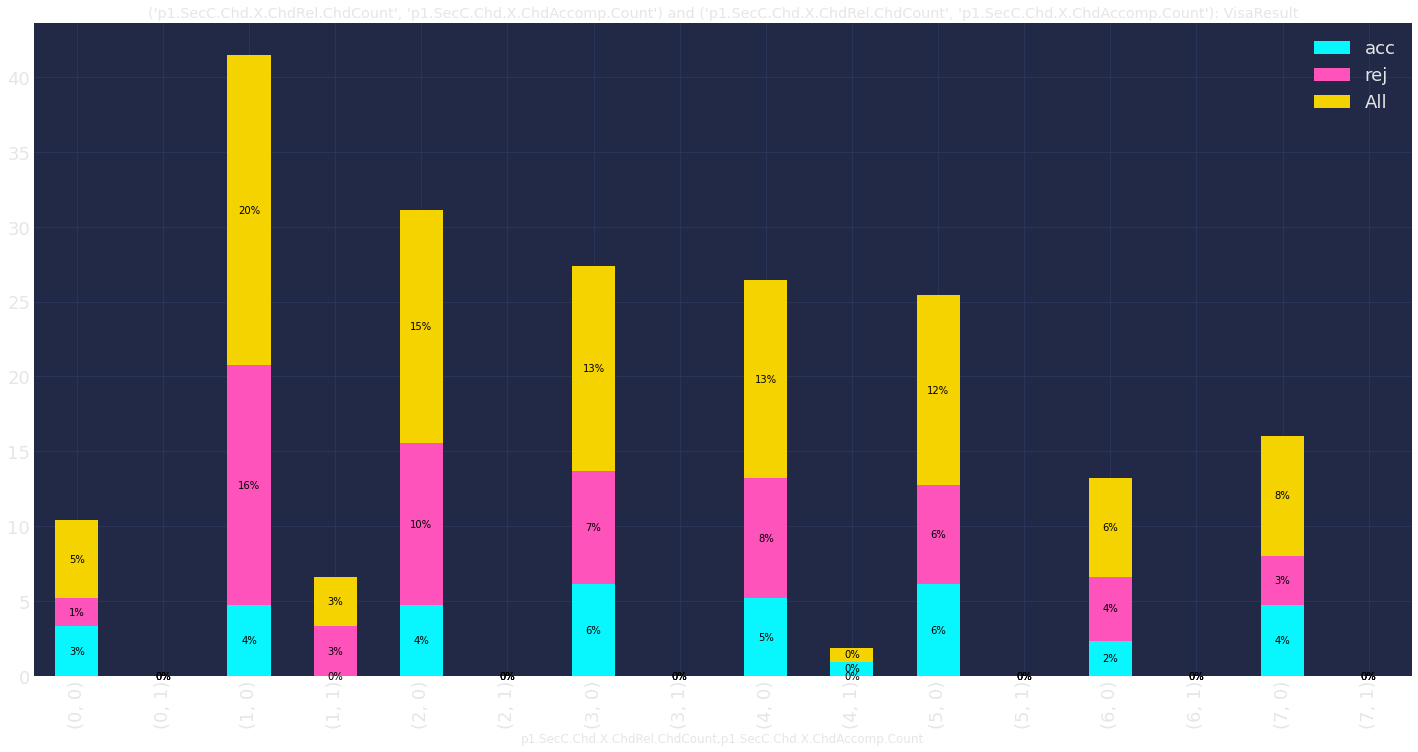

In [339]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name, feature_name, output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

Insights:
1. There is almost no case where someone got visa when going with siblings except very rare cases
2. By increase in number of siblings, the rejection rate decreases considerably. This might be just a correlation behavior since usually people with higher number of siblings (>3 especially) are from traditional families that marry sooner (higher marriage period), are older (zoomers all are alone), have more children, etc. Hence, more likely to go back. This is clearly visible for cases with 5 or more siblings that almost acceptance rate surpasses %50.


### p1.SecA.Fa.ChdMStatus and p1.SecA.Fa.FaDOB.Period

In [340]:
output_name = 'VisaResult'
feature_name = ['p1.SecA.Fa.ChdMStatus', 'p1.SecA.Fa.FaDOB.Period']

In [341]:
display(data[(data[feature_name[0]] == 9) & (data[feature_name[1]] == 0.)].shape[0])

28

For some weird reason, %10 (28/298) of our applicants have provided zero info about their fathers but it seems irrational to think they don't have a known father, so assuming they haven't provided the info, makes sense.

To fill this, we can follow similar path as children and siblings' age, and just fill `0`s with the average difference of age of mothers from fathers (given social trends about age, `fathers > mothers`)

In [342]:
output_name = 'VisaResult'
r = re.compile('p1.SecA.(Fa|Mo)\..*(ChdMStatus|Period)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
father_feature_name = [v for v in feature_name if 'Fa' in v]
mother_feature_name = [v for v in feature_name if 'Mo' in v]
display(feature_name)
display(father_feature_name)
display(mother_feature_name)

['p1.SecA.Mo.ChdMStatus',
 'p1.SecA.Fa.ChdMStatus',
 'p1.SecA.Mo.MoDOB.Period',
 'p1.SecA.Fa.FaDOB.Period']

['p1.SecA.Fa.ChdMStatus', 'p1.SecA.Fa.FaDOB.Period']

['p1.SecA.Mo.ChdMStatus', 'p1.SecA.Mo.MoDOB.Period']

#### Fill Cases With **One** of Mother or Father Age Missing

In [343]:
display(data[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] != 0)][feature_name])
display(data[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] != 0) & (
    data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0)][feature_name])

p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
114                    7.0                    1.0                85.000000   
202                    5.0                    5.0                54.419178   
223                    7.0                    5.0                67.131507   

     p1.SecA.Fa.FaDOB.Period  
114                      0.0  
202                      0.0  
223                      0.0

Empty DataFrame
Columns: [p1.SecA.Mo.ChdMStatus, p1.SecA.Fa.ChdMStatus, p1.SecA.Mo.MoDOB.Period, p1.SecA.Fa.FaDOB.Period]
Index: []

In [344]:
father_age_median = data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] != 0),  father_feature_name[1]].median().item()
mother_age_median = data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] != 0),  mother_feature_name[1]].median().item()
average_difference = father_age_median - mother_age_median  # mostly positive
display('median difference of fathers age from mothers: {}'.format(average_difference))

# fill fathers with no age with available mothers's age
na_mother_age = data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0) & (data[mother_feature_name[1]] != 0), mother_feature_name[1]]
fill_age = na_mother_age + average_difference
# print(data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0 & (data[mother_feature_name[1]] != 0)),  father_feature_name[1]], fill_age)
data.loc[(data[father_feature_name[0]] != 9) & (data[father_feature_name[1]] == 0) & (data[mother_feature_name[1]] != 0),  father_feature_name[1]] = fill_age

# fill mothers with no age with available fathers's age
na_father_age = data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0), father_feature_name[1]]
fill_age = na_father_age + average_difference
# print(data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0),  mother_feature_name[1]], fill_age)
data.loc[(data[mother_feature_name[0]] != 9) & (data[mother_feature_name[1]] == 0) & (data[father_feature_name[1]] != 0),  mother_feature_name[1]] = fill_age

'median difference of fathers age from mothers: 2.628767123287659'

In [345]:
na_mother_age

114    85.000000
202    54.419178
223    67.131507
Name: p1.SecA.Mo.MoDOB.Period, dtype: float64

In [346]:
data[[father_feature_name[1], mother_feature_name[1]]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p1.SecA.Fa.FaDOB.Period  298 non-null    float64
 1   p1.SecA.Mo.MoDOB.Period  298 non-null    float64
dtypes: float64(2)
memory usage: 15.1 KB


In [347]:
display(data.iloc[[110, 198, 219]][feature_name])

p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
114                    7.0                    1.0                85.000000   
202                    5.0                    5.0                54.419178   
223                    7.0                    5.0                67.131507   

     p1.SecA.Fa.FaDOB.Period  
114                87.628767  
202                57.047945  
223                69.760274

#### Fill Cases With **Both** of Mother or Father Age Missing

These group of people are probably dead!

In [348]:
aggregator_feature_name = 'P1.PD.DOBYear.Period'

In [349]:
display(data[(data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] == 0)][[*feature_name, aggregator_feature_name]])

p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
5                      9.0                    9.0                      0.0   
21                     9.0                    9.0                      0.0   
30                     9.0                    9.0                      0.0   
31                     9.0                    9.0                      0.0   
46                     9.0                    9.0                      0.0   
69                     9.0                    9.0                      0.0   
73                     9.0                    9.0                      0.0   
75                     9.0                    9.0                      0.0   
87                     9.0                    9.0                      0.0   
95                     9.0                    9.0                      0.0   
133                    9.0                    9.0                      0.0   
147                    9.0                    9.0                      0.0   
149                    9.0                    9.0                      0.0   
181                    9.0                    9.0                      0.0   
219                    9.0                    9.0                      0.0   
259                    9.0                    9.0                      0.0   

     p1.SecA.Fa.FaDOB.Period  P1.PD.DOBYear.Period  
5                        0.0             51.652055  
21                       0.0             59.687671  
30                       0.0             61.671233  
31                       0.0             57.290411  
46                       0.0             86.594521  
69                       0.0             84.827397  
73                       0.0             75.076712  
75                       0.0             28.775342  
87                       0.0             45.005479  
95                       0.0             73.446575  
133                      0.0             33.819178  
147                      0.0             44.884932  
149                      0.0             65.476712  
181                      0.0             76.484932  
219                      0.0             53.994521  
259                      0.0             74.076712

In [350]:
data2 = data.copy()

In [351]:
# dead people that have age 
cond = (data[father_feature_name[0]] == 9) & (
    data[father_feature_name[1]] != 0)

# average difference of medians of applicants' age from their parents' age (only for applicants with dead parents)
# since I capped to 85, mean and median are 85 too
father_age_median = data.loc[cond, father_feature_name[1]].median().item()
# since I capped to 85, mean and median are 85 too
mother_age_median = data.loc[cond,  mother_feature_name[1]].median().item()
app_age_median = data.loc[cond, aggregator_feature_name].median().item()

app_father_age_diff = father_age_median - app_age_median
app_mother_age_diff = mother_age_median - app_age_median
# here, it's mostly positive, because the median 
average_difference = father_age_median - mother_age_median
display('median difference of dead fathers age from dead mothers: {}\n \
       median age of dead fathers: {}\nmedian age of dead mothers: {}\n'.format(
    average_difference, father_age_median, mother_age_median))

# apps with both parents dead
cond = (data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] == 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] == 0)
# fill deads' age
na_app_age = data.loc[cond, aggregator_feature_name]
display(na_app_age.shape)
# fill dead fathers' age
data.loc[cond, father_feature_name[1]] = na_app_age + app_father_age_diff
# fill dead mothers' age
data.loc[cond, mother_feature_name[1]] = na_app_age + app_mother_age_diff

'median difference of dead fathers age from dead mothers: 8.358904109589048\n        median age of dead fathers: 82.33972602739726\nmedian age of dead mothers: 73.98082191780821\n'

(16,)

In [352]:
index = data2[(data2[father_feature_name[0]] == 9) & (data2[father_feature_name[1]] == 0) & (
    data2[mother_feature_name[0]] == 9) & (data2[mother_feature_name[1]] == 0)][[*feature_name, aggregator_feature_name]].index
display(data.loc[index, [*feature_name, aggregator_feature_name]])

p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
5                      9.0                    9.0                78.693151   
21                     9.0                    9.0                86.728767   
30                     9.0                    9.0                88.712329   
31                     9.0                    9.0                84.331507   
46                     9.0                    9.0               113.635616   
69                     9.0                    9.0               111.868493   
73                     9.0                    9.0               102.117808   
75                     9.0                    9.0                55.816438   
87                     9.0                    9.0                72.046575   
95                     9.0                    9.0               100.487671   
133                    9.0                    9.0                60.860274   
147                    9.0                    9.0                71.926027   
149                    9.0                    9.0                92.517808   
181                    9.0                    9.0               103.526027   
219                    9.0                    9.0                81.035616   
259                    9.0                    9.0               101.117808   

     p1.SecA.Fa.FaDOB.Period  P1.PD.DOBYear.Period  
5                  87.052055             51.652055  
21                 95.087671             59.687671  
30                 97.071233             61.671233  
31                 92.690411             57.290411  
46                121.994521             86.594521  
69                120.227397             84.827397  
73                110.476712             75.076712  
75                 64.175342             28.775342  
87                 80.405479             45.005479  
95                108.846575             73.446575  
133                69.219178             33.819178  
147                80.284932             44.884932  
149               100.876712             65.476712  
181               111.884932             76.484932  
219                89.394521             53.994521  
259               109.476712             74.076712

#### Age With No Marital Status
People who have their parents have a valid age field but no martial status dedicated which probably is the indication for dead case which that they should be left as it is. For other cases that people actually forgot to fill, we can follow these approaches:
1. Fill it with their mother's status:
   1. mother widowed (`8`)-> father (dead) -> don't change (`9`)
   2. mother single (`7`) -> father other -> don't change (`9`)
   3. mother married/divorced/all other cases -> father same as mother
2. Leave it! **<- CURRENT IMPL.**

In [353]:
display(data[(data[feature_name[0]] == 9) & (data[feature_name[1]] != 0.)].shape[0])

62

In [354]:
#nb>
data[(data[father_feature_name[0]] == 9) & (data[father_feature_name[1]] != 0) & (
    data[mother_feature_name[0]] == 9) & (data[mother_feature_name[1]] != 0)][[*feature_name]]

p1.SecA.Mo.ChdMStatus  p1.SecA.Fa.ChdMStatus  p1.SecA.Mo.MoDOB.Period  \
3                      9.0                    9.0                61.501370   
5                      9.0                    9.0                78.693151   
16                     9.0                    9.0                71.934247   
17                     9.0                    9.0                85.000000   
19                     9.0                    9.0                66.167123   
..                     ...                    ...                      ...   
289                    9.0                    9.0                85.000000   
291                    9.0                    9.0                85.000000   
292                    9.0                    9.0                85.000000   
300                    9.0                    9.0                70.602740   
302                    9.0                    9.0                85.000000   

     p1.SecA.Fa.FaDOB.Period  
3                  67.282192  
5                  87.052055  
16                 79.810959  
17                 85.000000  
19                 85.000000  
..                       ...  
289                85.000000  
291                69.764384  
292                85.000000  
300                76.693151  
302                85.000000  

[57 rows x 4 columns]

57 out of 62 cases have dead father and dead mother. So, it means that almost all cases where marital status is missed, probably person is dead and filling it with other values might not seem appropriate.

TODO: until occupation fields are incorporated which contain `deceased` for people who are actually dead.

In [355]:
data[[father_feature_name[1], mother_feature_name[1]]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p1.SecA.Fa.FaDOB.Period  298 non-null    float64
 1   p1.SecA.Mo.MoDOB.Period  298 non-null    float64
dtypes: float64(2)
memory usage: 15.1 KB


### p1.SecX.*.*Addr -> int (count)

Since there are some `other` in `ChdRel` here that are not "ghost case", we use `ChdDOB.Period` that have been already cleaned and filled based on conditions to detect "ghost" case from "incomplete" case. Hence, in this section, we just rely on non-zero cases of `ChdDOB.Period` to find out if child exists or not!

In [356]:
output_name = 'VisaResult'
r = re.compile('p1.Sec(A|B|C)\..*\..*(Addr)')
mask = np.isin(data.columns.values, list(filter(r.match, data.columns.values)))
feature_name = list(data.columns.values[mask])
display(feature_name)

['p1.SecA.App.AppAddr',
 'p1.SecA.Sps.SpsAddr',
 'p1.SecA.Mo.MoAddr',
 'p1.SecA.Fa.FaAddr',
 'p1.SecB.Chd.[0].ChdAddr',
 'p1.SecB.Chd.[1].ChdAddr',
 'p1.SecB.Chd.[2].ChdAddr',
 'p1.SecB.Chd.[3].ChdAddr',
 'p1.SecC.Chd.[0].ChdAddr',
 'p1.SecC.Chd.[1].ChdAddr',
 'p1.SecC.Chd.[2].ChdAddr',
 'p1.SecC.Chd.[3].ChdAddr',
 'p1.SecC.Chd.[4].ChdAddr',
 'p1.SecC.Chd.[5].ChdAddr',
 'p1.SecC.Chd.[6].ChdAddr']

In [357]:
data[[*feature_name, output_name]].sample(2, random_state=SEED)

p1.SecA.App.AppAddr  \
146          NO.88-BEHDARI TOWN-MOAZEN BLVD-KARAJ-IRAN   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                                   p1.SecA.Sps.SpsAddr  \
146          NO.88-BEHDARI TOWN-MOAZEN BLVD-KARAJ-IRAN   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                                     p1.SecA.Mo.MoAddr  \
146   SHAHID FAHMIDEH SQ-KARKHANEH GHAND CR-KARAJ-IRAN   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                                     p1.SecA.Fa.FaAddr  \
146   SHAHID FAHMIDEH SQ-KARKHANEH GHAND CR-KARAJ-IRAN   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                               p1.SecB.Chd.[0].ChdAddr  \
146                                               None   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                               p1.SecB.Chd.[1].ChdAddr  \
146                                               None   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

                               p1.SecB.Chd.[2].ChdAddr  \
146                                               None   
234  UNIT 1, BERELIAN BUILDING 10, RASTAKHIZ BLV, G...   

    p1.SecB.Chd.[3].ChdAddr  \
146                    None   
234                    None   

                               p1.SecC.Chd.[0].ChdAddr  \
146  NO.14-NILOUFAR ALLEY-BESAT BLVD-ASBI SQ.-AZIMI...   
234                                        PASSED AWAY   

                       p1.SecC.Chd.[1].ChdAddr  \
146            NO.130-ST 122-GOLSR -RASHT-IRAN   
234  YAS BUILDING, 9 BOUSTAN, BAGHESTAN, KARAJ   

                         p1.SecC.Chd.[2].ChdAddr p1.SecC.Chd.[3].ChdAddr  \
146  NO.24-GOLSHAN ST-HAFT E TIR BLVD-KARAJ-IRAN                    None   
234                              SAADI ST, AHVAZ           AMIN BLV, QOM   

    p1.SecC.Chd.[4].ChdAddr p1.SecC.Chd.[5].ChdAddr p1.SecC.Chd.[6].ChdAddr  \
146                    None                    None                    None   
234                    None                    None                    None   

    VisaResult  
146        rej  
234    no idea

In [358]:
IRAN_PROVINCES = {
    'Alborz': 'Alborz',
    'AKBORZ': 'Alborz',  # Typo case: Alborz
    'Ardabil': 'Ardabil',
    'Ardebil': 'Ardebil',
    'Azarbayjan-e Gharbi': 'West',
    'West Azerbaijan': 'West',
    'Azerbaijan-e Gharbi': 'West',
    'Azerbaijan, West': 'West',
    'West': 'West',  # we only have one province with 'West' in it
    'Gharbi': 'West', # we only have one province with 'Gharbi' in it
    'Azerbaijan-e Sharqi': 'East',
    'Azarbayjan-e Sharqi': 'East',
    'Azerbaijan, East': 'East',
    'East Azerbaijan': 'East',
    'East': 'East',  # we only have one province with 'East' in it
    'Sharqi': 'East', # we only have one province with 'Sharghi' in it
    'Sharghi': 'East', # we only have one province with 'Sharghi' in it
    'Bushehr': 'Bushehr',
    'Chaharmahal and Bakhtiari': 'Chaharmahal and Bakhtiari',
    'Chahar Mahaal and Bakhtiari': 'Chaharmahal and Bakhtiari',
    'Chahar Mahal-e Bakhtiari': 'Chaharmahal and Bakhtiari',
    'Fars': 'Fars',
    'Gilan': 'Gilan',
    'Guilan': 'Gilan',
    'Golestan': 'Golestan',
    'Hamadan': 'Hamadan',
    'Hamedan': 'Hamadan',
    'Hormozgan': 'Hormozgan',
    'Ilam': 'Ilam',
    'Isfahan': 'Isfahan',
    'Esfahan': 'Isfahan',
    'ESFSHAN': 'Isfahan',  # typo case: Esfahan
    'Kerman': 'Kerman',
    'Kermanshah': 'Kermanshah',
    'Khorasan-e Janubi': 'South',
    'Khorasan-e Jonubi': 'South',
    'Khorasan Jonubi': 'South',
    'South Khorasan': 'South',
    'Khorasan, South': 'South',
    'Khorasan Janubi': 'South',
    'Jonubi': 'South',  # we only have one province with 'Jonubi' in it
    'Janubi': 'South', # we only have one province with 'Janubi' in it
    'South': 'South', # we only have one province with 'South' in it
    'Khorasan-e Razavi': 'Razavi',
    'Khorasan, Razavi': 'Razavi',
    'Razavi Khorasan': 'Razavi',
    'Razavi': 'Razavi', # we only have one province with 'Razavi' in it
    'Khorasan-e Shemali': 'North',
    'Khorasan Shomali': 'North',
    'Khorasan-e Shomali': 'North',
    'Khorasan, North': 'North',
    'North Khorasan': 'North',
    'Shomali': 'North',  # we only have one province with 'Shomali' in it
    'Shemali': 'North', # we only have one province with 'Shemali' in it
    'North': 'North', # we only have one province with 'North' in it
    'Khuzestan': 'Khuzestan',
    'KHOUZESTAN': 'Khuzestan',
    'Kohgiluyeh and Buyer Ahmad': 'Kohgiluyeh and Buyer Ahmad',
    'Kohgiluyeh and Boyer-Ahmad': 'Kohgiluyeh and Buyer Ahmad',
    'Kurdistan': 'Kurdistan',
    'Kordestan': 'Kurdistan',
    'Lorestan': 'Lorestan',
    'Markazi': 'Markazi',
    'Mazandaran': 'Mazandaran',
    'Qazvin': 'Qazvin',
    'GHAZVIN': 'Qazvin',
    'Qom': 'Qom',
    'Semnan': 'Semnan',
    'Sistan and Baluchestan': 'Sistan and Baluchestan',
    'Tehran': 'Tehran',
    'Tehra': 'Tehran',  # typo case: Tehran
    'Teh': 'Tehran',  # typo case: Tehran
    'Te': 'Tehran',  # typo case: Tehran
    'TRHRAN': 'Tehran', # typo case: Tehran
    'TEHRTAN': 'Tehran', # typo case: Tehran
    'TEHRANIRAN': 'Tehran', # typo case: Tehran
    'EHRAN': 'Tehran', # typo case: Tehran
    'Urmia': 'Urmia',
    'Orumiyeh': 'Urmia',
    'Orumiye': 'Urmia',
    'Orumieh': 'Urmia',
    'Orumie': 'Urmia',
    'OROMIEH': 'Urmia', # typo case: Urmia
    'Yazd': 'Yazd',
    'Zanjan': 'Zanjan',
}

# hardcoded af
FOREIGN_COUNTRY_MISSED = [
    'USA',
    'UAE',
    'TURKET',
    'Meadow',
    'US',
    'ONTARIO',
    'DUBAI',
    'TORONTO',
    'FRAMINGHAM',
    'SCOTTSDDIE',
    'EMIRATES',
    'OAKLAND',
    'Stockholm',
    'frankfurt',
    'VANCOUVER',
    'TORENTO',
    'JACKSON',
    'ISTANBUL',
    'BRECKENRIDGE',
    'London',

]

from vizard.configs import IRAN_PROVINCE_TO_CITY
from typing import Optional

def make_dictionary_lowercase(dictionary: dict) -> dict:
    return {key.lower(): value.lower() for key, value in dictionary.items()}

IRAN_PROVINCE_TO_CITY_DICT =  make_dictionary_lowercase(functional.config_csv_to_dict(IRAN_PROVINCE_TO_CITY))
IRAN_PROVINCES = make_dictionary_lowercase(IRAN_PROVINCES)
# combine list of countries and manually extracted list of them
country_list = list(functional.config_csv_to_dict(CANADA_COUNTRY_CODE_TO_NAME).values())
FOREIGN_COUNTRY_MISSED = [country.lower() for country in FOREIGN_COUNTRY_MISSED]
country_list.extend(FOREIGN_COUNTRY_MISSED)

def address_to_city(address: Optional[str],
                    city_province_dict: dict,
                    province_dict: dict,
                    country_list: list) -> Optional[str]:
    """Takes an full address and extracts the city then province containing the city.

    Note:
        Since the goal of defining this function is to aggregate over addresses, if
            the address is not provided, it is valid to ignore it since it cannot be
            inferred with %100 accuracy and any statistical method would be biased
            towards the majority class which is the applicant's address.

    TODO: implement a spell checker to correct the city names.
        You must be aware that the city names also have multiple ways of being spelled
            but we ignore it as it would be too much effort to correct it. 
        Just a reminder, this has been done manually for the provinces and has been
            provided using `province_dict`.
            

    Args:
        address (str, optional): full address which is expected to contain
            the city and province.
        city_province_dict (dict): dictionary mapping city names to provinces
        province_dict (dict): dict of provinces and their typos. This dict
            needs to be separately provided to include different spelling 
            for the name of the same province. This would prevent unnecessary
            duplication of entries in keys of `city_province_dict`.
            Keys are all type of spelling and values are the correct spelling. E.g.::
                {
                    'Kordestan': 'Kurdistan',
                    'Kurdistan': 'Kurdistan'
                }

        country_list (list): list of countries. We consider any address that has an
            instance in this list as 'foreign' to just separate it from "long distance"
            cases where cases are inside a country (here, Iran).

    Returns:
        str: Province of the address
    """

    if address is None:
        return None
    
    # lower case items in country_list
    country_list = [item.lower() for item in country_list]

    addr_part = re.split(r'(,|-|:| )', address)
    # look for city in the address
    for part in addr_part:
        part = part.lower().strip()
        # skip dead cases
        if ('deceased' in part) or ('passed' in part):
            return 'deceased'
        # return province if it is already in address
        if part in province_dict.keys():
            return province_dict[part]
        # return foreign if it is in country list except 'Iran'
        if (part in country_list) and (part != 'iran'):
            return 'foreign'
        # get the province of the city if province not in address
        if part in city_province_dict.keys():
            return city_province_dict[part]
    # if we cannot infer address, just ignore it :D
    print(ValueError(f'Cannot infer city from address: {address}'))
    return None

for f in feature_name:
    data[f] = data[f].apply(address_to_city, args=(IRAN_PROVINCE_TO_CITY_DICT,
                                                   IRAN_PROVINCES,
                                                   country_list, ))


Cannot infer city from address: NO 44, ANDARZGOU SQ, FARMANIYEH
Cannot infer city from address: UNIT 28-NO.16-EMAM REZA ALLEY-EBRAHIM NOORI ST-NATEGH NOORI ST-ASHRAFI ESFAHANI HIGHWAY
Cannot infer city from address: NO 44, ANDARZGOU BLVD, FARMANIYEH
Cannot infer city from address: NO.7-HOSSEINKHANI DIST-ANBAR NOJAVANI -JAVAD ZANDI ST-ALGHADIR SQ-YAFTABAD
Cannot infer city from address: NO 44, ANDARZGOU SQ, FARMANIYEH
Cannot infer city from address: NO 44, ANDARZGOU BLVD, FARMANIYEH
Cannot infer city from address: BARANI KORD VILAGE-NAGHDEH-IRAN
Cannot infer city from address: NO 1, FARMANIYEH
Cannot infer city from address: NO 10, ASGARI BLVD, SALEHI ST, FARMANIYEH
Cannot infer city from address: BEHESHT SAKINEH Cemetary  2017-04-10
Cannot infer city from address: TABASOM BLDG.-EASTERN ARGHAVAN AVE.-GOLSHHARKARAJ-IRAN
Cannot infer city from address: UNIT B4-PARASTOU COMPLEX-NEXT TO THE 14 EASTERN ALLEY-LALEH SOUTHERN-FERDOS WESTRN-T
Cannot infer city from address: BEHESHT SAKINEH Cemet

In [359]:
data[[*feature_name, output_name]].sample(5, random_state=SEED)

p1.SecA.App.AppAddr p1.SecA.Sps.SpsAddr p1.SecA.Mo.MoAddr  \
146              alborz              alborz            alborz   
234              alborz              alborz            alborz   
287           khuzestan                None         khuzestan   
197              tehran              tehran            tehran   
69               tehran              tehran          deceased   

    p1.SecA.Fa.FaAddr p1.SecB.Chd.[0].ChdAddr p1.SecB.Chd.[1].ChdAddr  \
146            alborz                    None                    None   
234            alborz                  alborz                  alborz   
287         khuzestan                    None                    None   
197            tehran                  tehran                    None   
69           deceased                  tehran                 foreign   

    p1.SecB.Chd.[2].ChdAddr p1.SecB.Chd.[3].ChdAddr p1.SecC.Chd.[0].ChdAddr  \
146                    None                    None                  alborz   
234                  alborz                    None                deceased   
287                    None                    None                  tehran   
197                    None                    None                 hamadan   
69                  foreign                    None                  tehran   

    p1.SecC.Chd.[1].ChdAddr p1.SecC.Chd.[2].ChdAddr p1.SecC.Chd.[3].ChdAddr  \
146                   gilan                 isfahan                    None   
234                  tehran               khuzestan                     qom   
287                  tehran                 foreign                 foreign   
197                 hamadan                    None                    None   
69                     None                    None                    None   

    p1.SecC.Chd.[4].ChdAddr p1.SecC.Chd.[5].ChdAddr p1.SecC.Chd.[6].ChdAddr  \
146                    None                    None                    None   
234                    None                    None                    None   
287                 foreign                    None                    None   
197                    None                    None                    None   
69                     None                    None                    None   

    VisaResult  
146        rej  
234    no idea  
287        acc  
197    no idea  
69         acc

In [360]:
# count number of family members that are living in different place than applicant (non-foreign)
agg_column_name = 'p1.SecX.LongDistAddr'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_long_distance_family_resident,
                                   agg_column_name=agg_column_name, columns=feature_name)

In [361]:
data[[agg_column_name, *feature_name, output_name]].sample(5, random_state=SEED)

p1.SecX.LongDistAddr p1.SecA.App.AppAddr p1.SecA.Sps.SpsAddr  \
146                     2              alborz              alborz   
234                     3              alborz              alborz   
287                     2           khuzestan                None   
197                     2              tehran              tehran   
69                      0              tehran              tehran   

    p1.SecA.Mo.MoAddr p1.SecA.Fa.FaAddr p1.SecB.Chd.[0].ChdAddr  \
146            alborz            alborz                    None   
234            alborz            alborz                  alborz   
287         khuzestan         khuzestan                    None   
197            tehran            tehran                  tehran   
69           deceased          deceased                  tehran   

    p1.SecB.Chd.[1].ChdAddr p1.SecB.Chd.[2].ChdAddr p1.SecB.Chd.[3].ChdAddr  \
146                    None                    None                    None   
234                  alborz                  alborz                    None   
287                    None                    None                    None   
197                    None                    None                    None   
69                  foreign                 foreign                    None   

    p1.SecC.Chd.[0].ChdAddr p1.SecC.Chd.[1].ChdAddr p1.SecC.Chd.[2].ChdAddr  \
146                  alborz                   gilan                 isfahan   
234                deceased                  tehran               khuzestan   
287                  tehran                  tehran                 foreign   
197                 hamadan                 hamadan                    None   
69                   tehran                    None                    None   

    p1.SecC.Chd.[3].ChdAddr p1.SecC.Chd.[4].ChdAddr p1.SecC.Chd.[5].ChdAddr  \
146                    None                    None                    None   
234                     qom                    None                    None   
287                 foreign                 foreign                    None   
197                    None                    None                    None   
69                     None                    None                    None   

    p1.SecC.Chd.[6].ChdAddr VisaResult  
146                    None        rej  
234                    None    no idea  
287                    None        acc  
197                    None    no idea  
69                     None        acc

In [362]:
# count number of family members that are living in a foreign country
agg_column_name = 'p1.SecX.ForeignAddr'
canada_logic.reset_dataframe(dataframe=data)
data = canada_logic.add_agg_column(aggregator=canada_logic.count_foreign_family_resident,
                                   agg_column_name=agg_column_name, columns=feature_name)

In [363]:
data[[agg_column_name, *feature_name, output_name]].sample(5, random_state=SEED)

p1.SecX.ForeignAddr p1.SecA.App.AppAddr p1.SecA.Sps.SpsAddr  \
146                    0              alborz              alborz   
234                    0              alborz              alborz   
287                    3           khuzestan                None   
197                    0              tehran              tehran   
69                     2              tehran              tehran   

    p1.SecA.Mo.MoAddr p1.SecA.Fa.FaAddr p1.SecB.Chd.[0].ChdAddr  \
146            alborz            alborz                    None   
234            alborz            alborz                  alborz   
287         khuzestan         khuzestan                    None   
197            tehran            tehran                  tehran   
69           deceased          deceased                  tehran   

    p1.SecB.Chd.[1].ChdAddr p1.SecB.Chd.[2].ChdAddr p1.SecB.Chd.[3].ChdAddr  \
146                    None                    None                    None   
234                  alborz                  alborz                    None   
287                    None                    None                    None   
197                    None                    None                    None   
69                  foreign                 foreign                    None   

    p1.SecC.Chd.[0].ChdAddr p1.SecC.Chd.[1].ChdAddr p1.SecC.Chd.[2].ChdAddr  \
146                  alborz                   gilan                 isfahan   
234                deceased                  tehran               khuzestan   
287                  tehran                  tehran                 foreign   
197                 hamadan                 hamadan                    None   
69                   tehran                    None                    None   

    p1.SecC.Chd.[3].ChdAddr p1.SecC.Chd.[4].ChdAddr p1.SecC.Chd.[5].ChdAddr  \
146                    None                    None                    None   
234                     qom                    None                    None   
287                 foreign                 foreign                    None   
197                    None                    None                    None   
69                     None                    None                    None   

    p1.SecC.Chd.[6].ChdAddr VisaResult  
146                    None        rej  
234                    None    no idea  
287                    None        acc  
197                    None    no idea  
69                     None        acc

In [364]:
#nb>
agg_column_name = ['p1.SecX.LongDistAddr', 'p1.SecX.ForeignAddr']
data[[*feature_name, *agg_column_name]]

p1.SecA.App.AppAddr p1.SecA.Sps.SpsAddr p1.SecA.Mo.MoAddr  \
0               isfahan             isfahan          deceased   
1                tehran              tehran           isfahan   
2                  east                east              east   
3              golestan            golestan          golestan   
4            mazandaran          mazandaran        mazandaran   
..                  ...                 ...               ...   
300              alborz                None            alborz   
301              razavi              razavi            razavi   
302                fars                fars          deceased   
303              tehran              tehran            tehran   
304                west                west              fars   

    p1.SecA.Fa.FaAddr p1.SecB.Chd.[0].ChdAddr p1.SecB.Chd.[1].ChdAddr  \
0            deceased              kermanshah                 foreign   
1             isfahan                  tehran                    None   
2                east                    east                    None   
3            golestan                    None                    None   
4          mazandaran                    None                    None   
..                ...                     ...                     ...   
300            alborz                    east                    None   
301            razavi                  razavi                    None   
302          deceased                    fars                    fars   
303            tehran                    None                    None   
304              fars                    None                    None   

    p1.SecB.Chd.[2].ChdAddr p1.SecB.Chd.[3].ChdAddr p1.SecC.Chd.[0].ChdAddr  \
0                      None                    None                 isfahan   
1                      None                    None                  qazvin   
2                      None                    None                   north   
3                      None                    None                 foreign   
4                      None                    None              mazandaran   
..                      ...                     ...                     ...   
300                    None                    None                  alborz   
301                    None                    None                  razavi   
302                 foreign                    fars                deceased   
303                    None                    None                  tehran   
304                    None                    None                    west   

    p1.SecC.Chd.[1].ChdAddr p1.SecC.Chd.[2].ChdAddr p1.SecC.Chd.[3].ChdAddr  \
0                   hamadan                 foreign              kermanshah   
1                    tehran                  tehran                    None   
2                      east                    east                    None   
3                      None                    None                    None   
4                      None                    None                    None   
..                      ...                     ...                     ...   
300                  alborz                    None                    None   
301                  razavi                    None                    None   
302                    fars                 foreign                    west   
303                  tehran                 foreign                    None   
304                    fars                    None                    None   

    p1.SecC.Chd.[4].ChdAddr p1.SecC.Chd.[5].ChdAddr p1.SecC.Chd.[6].ChdAddr  \
0                   isfahan                 isfahan                    None   
1                      None                    None                    None   
2                      None                    None                    None   
3                      None                    None                    None   
4                      None                    None  

In [365]:
# drop aggregated address columns
data.drop(columns=feature_name, axis=1, inplace=True)

#### Vis

In [366]:
output_name = 'VisaResult'
feature_name = ['p1.SecX.LongDistAddr', 'p1.SecX.ForeignAddr', 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit']

In [367]:
#nb>
z = data[(data[output_name] == 'acc') | (data[output_name] == 'rej')]
z = z[(z[feature_name[0]] <= 7) & (z[feature_name[1]] <= 4)]
ct = pd.crosstab([z[feature_name[0]], z[feature_name[1]]], z[output_name],
            margins=False, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
# ct.drop(['no idea', 'w-acc', 'w-rej'], axis=1, inplace=True)
ct

VisaResult                                     acc        rej
p1.SecX.LongDistAddr p1.SecX.ForeignAddr                     
0                    0                    1.463415  18.536585
                     1                    0.975610   3.414634
                     2                    1.463415   1.463415
                     3                    0.975610   0.487805
                     4                    0.000000   0.000000
1                    0                    2.926829   7.804878
                     1                    2.926829   1.951220
                     2                    0.000000   0.000000
                     3                    0.487805   0.975610
                     4                    0.000000   0.000000
2                    0                    2.926829   4.390244
                     1                    0.487805   0.000000
                     2                    3.414634   0.487805
                     3                    1.951220   0.000000
                     4                    0.487805   0.000000
3                    0                    3.414634   8.292683
                     1                    0.487805   0.975610
                     2                    1.463415   0.487805
                     3                    0.000000   0.000000
                     4                    0.000000   0.487805
4                    0                    1.463415   4.878049
                     1                    1.463415   0.487805
                     2                    1.463415   0.000000
                     3                    0.000000   0.000000
                     4                    0.000000   0.000000
5                    0                    1.951220   1.951220
                     1                    1.463415   0.000000
                     2                    0.487805   0.000000
                     3                    0.487805   0.000000
                     4                    0.000000   0.487805
6                    0                    1.951220   2.439024
                     1                    0.000000   0.000000
                     2                    0.000000   0.000000
                     3                    0.000000   0.000000
                     4                    0.000000   0.000000
7                    0                    0.975610   1.463415
                     1                    0.487805   0.000000
                     2                    0.487805   0.000000
                     3                    0.000000   0.000000

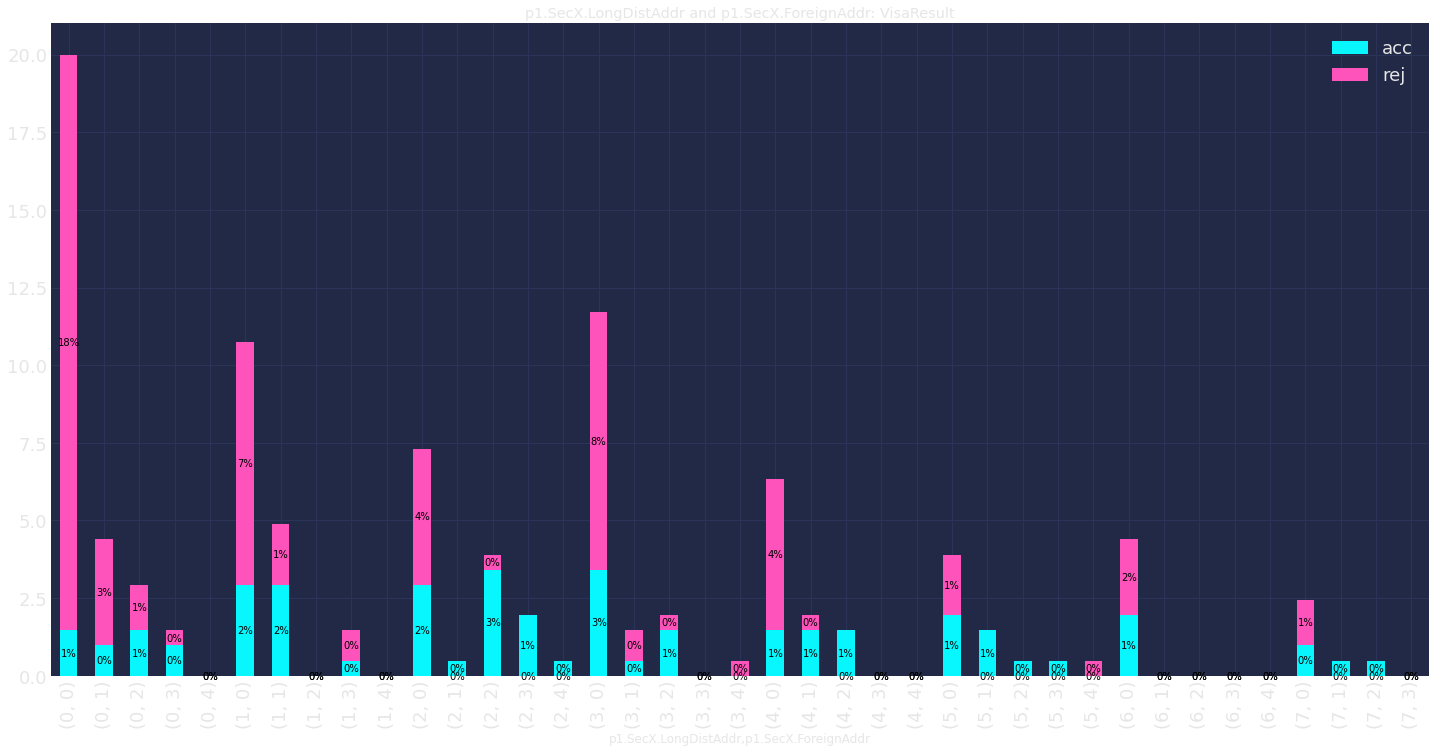

In [368]:
#nb>
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

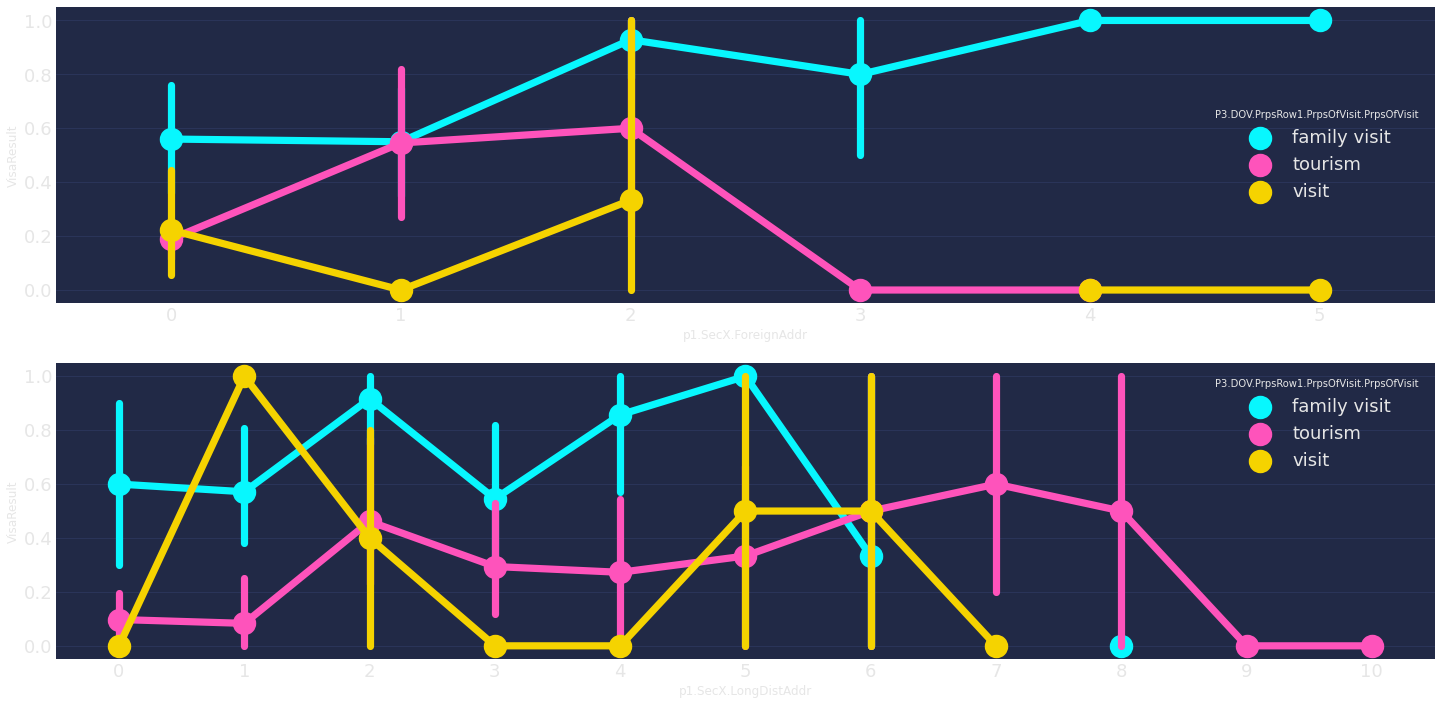

In [369]:
f, ax = plt.subplots(2, 1, figsize=(22, 12))
z = data[(data[output_name] == 'acc') | (data[output_name] == 'rej')].copy()
z = z[(z[feature_name[2]] != 'business') & (z[feature_name[2]] != 'other')]
z[output_name] = z[output_name].apply(lambda x: True if x == 'acc' else False)
sns.pointplot(x=feature_name[1], y=output_name, hue=feature_name[2],
              data=z,
              kind='point', ax=ax[0])

sns.pointplot(x=feature_name[0], y=output_name, hue=feature_name[2],
              data=z,
              kind='point', ax=ax[1])
plt.show()

Insights:
1. When `ForeignAddr` increases, the change of getting visa with purpose of `f2` decrease hugely.
2. As expected, visiting `f1` is dominant factor and does not seem that `Addr` have any effect on it.
3. This is the data for all people, single, married, old, young, etc. So a subset of these might provide more info
   1. Single people for `longDistAddr` and purpose `relationship`

##### Single people

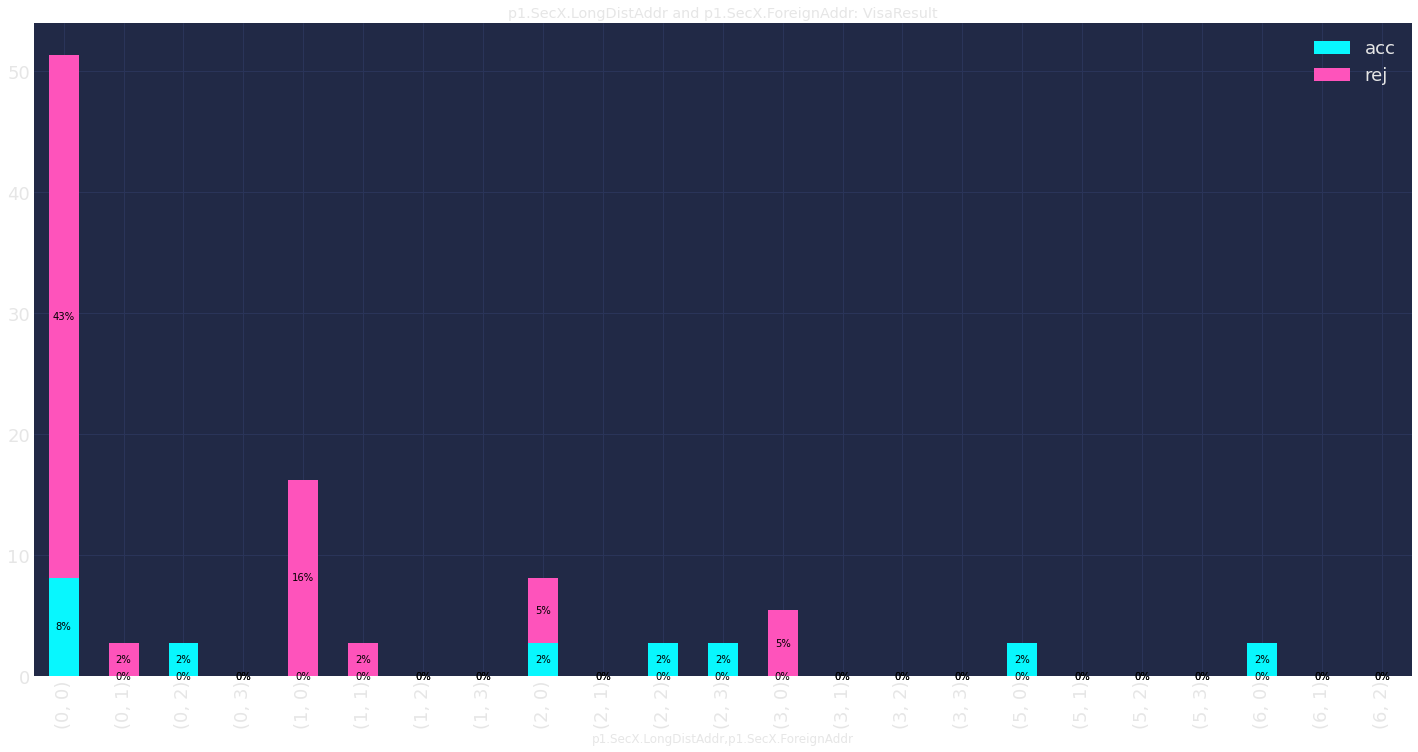

In [370]:
#nb>
z = data[(data[output_name] == 'acc') | (data[output_name] == 'rej')]
z = z[(z[feature_name[0]] <= 7) & (z[feature_name[1]] <= 4)]
# single people
z = z[z['p1.SecA.App.ChdMStatus'] == 7]


ct = pd.crosstab([z[feature_name[0]], z[feature_name[1]]], z[output_name],
            margins=False, dropna=False, normalize=True) * 100
ct.drop(ct.tail(1).index, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(22, 12))
ct.plot(kind='bar', stacked=True, rot=90, ax=ax)
ax.set_title('{} and {}: {}'.format(
    feature_name[0], feature_name[1], output_name))
ax.legend(loc='upper right')
for c in ax.containers:
    ax.bar_label(c, label_type='center', fmt='%1d%%', color='black')
plt.show()

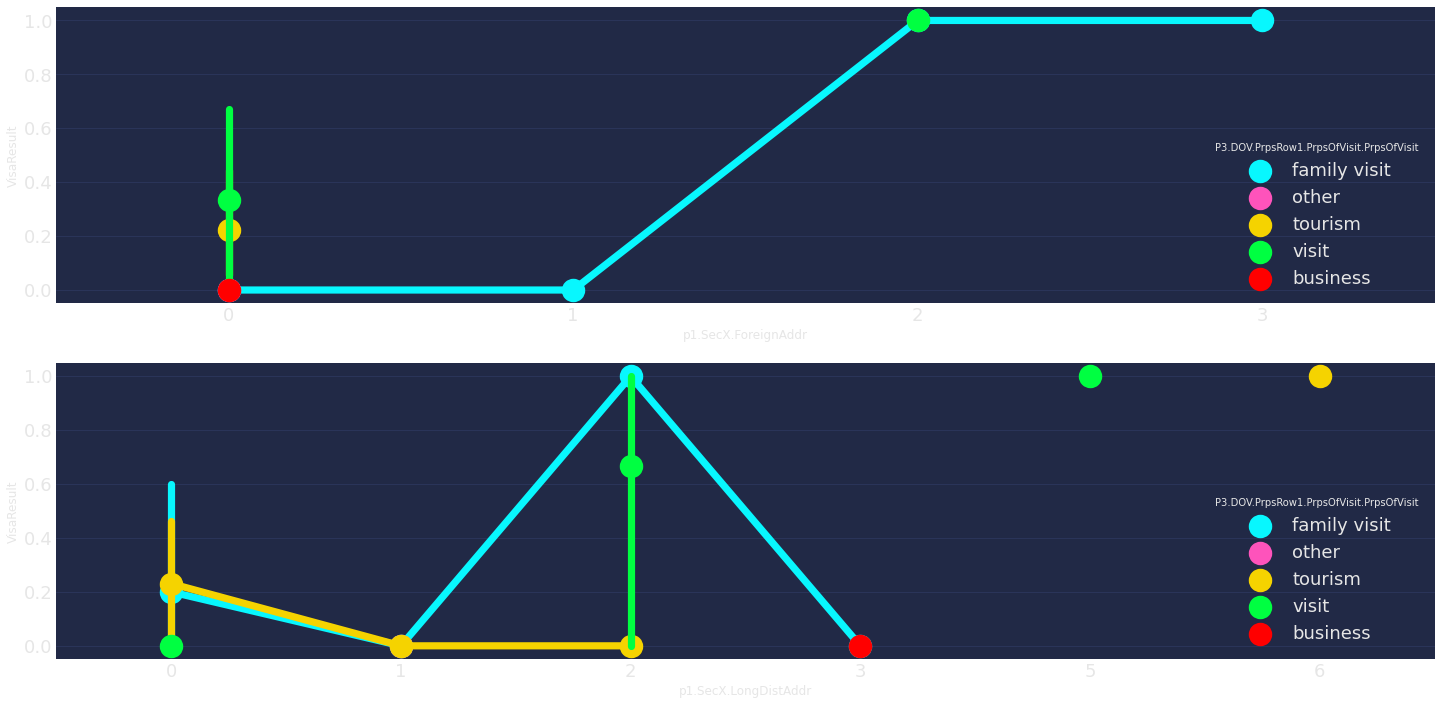

In [371]:
f, ax = plt.subplots(2, 1, figsize=(22, 12))
z = data[(data[output_name] == 'acc') | (data[output_name] == 'rej')].copy()
z = z[(z[feature_name[2]] != 'ukn') & (z[feature_name[2]] != 'work')]
z[output_name] = z[output_name].apply(lambda x: True if x == 'acc' else False)

# single people
z = z[z['p1.SecA.App.ChdMStatus'] == 7]

sns.pointplot(x=feature_name[1], y=output_name, hue=feature_name[2],
              data=z,
              kind='point', ax=ax[0])

sns.pointplot(x=feature_name[0], y=output_name, hue=feature_name[2],
              data=z,
              kind='point', ax=ax[1])
plt.show()

No information here.

In [372]:
#nb>
data.sample(5, random_state=SEED)

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
146                                              False             Male   
234                                              False             Male   
287                                              False             Male   
197                                              False             Male   
69                                               False             Male   

     P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
146                    1.107154                        1.0   
234                    1.107154                        1.0   
287                    1.107154                        1.0   
197                    1.107154                        1.0   
69                     1.107154                        1.0   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
146                    1.429856                    1.429856   
234                    1.429856                    1.429856   
287                    1.429856                    1.429856   
197                    1.429856                    1.429856   
69                     1.429856                    1.429856   

    P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country  P1.PD.CWA.Row2.Status  \
146                    False                Georgia                    6.0   
234                    False                 TURKEY                    6.0   
287                    False                 TURKEY                    3.0   
197                    False                 TURKEY                    6.0   
69                     False                 TURKEY                    3.0   

    P2.MS.SecA.PrevMarrIndicator P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  \
146                        False                                 tourism   
234                         True                                   visit   
287                        False                            family visit   
197                        False                                 tourism   
69                         False                            family visit   

     P3.DOV.PrpsRow1.Funds.Funds  \
146                       6000.0   
234                      10000.0   
287                       8000.0   
197                       6000.0   
69                       10000.0   

    P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe  \
146                                              hotel     
234                                              hotel     
287                                                 f1     
197                                              hotel     
69                                                  f1     

    P3.cntcts_Row2.Relationship.RelationshipToMe P3.Edu.EduIndicator  \
146                                        hotel               False   
234                                        hotel                True   
287                                          ukn                True   
197                                        hotel                True   
69                                           ukn                True   

    P3.Edu.Edu_Row1.FieldOfStudy  P3.Edu.Edu_Row1.Country.Country  \
146                        unedu                         1.000000   
234                       master                         3.177804   
287                   apprentice                         3.177804   
197                     bachelor                         3.177804   
69                       diploma                         3.177804   

    P3.Occ.OccRow1.Occ.Occ  P3.Occ.OccRow1.Country.Country  \
146               employee                        1.107154   
234               employee                        1.107154   
287               employee                        1.107154   
197                manager                        1.107154   
69                 manager                        1.107154   

    P3.Occ.OccRow2.Occ.Occ  P3.Occ.OccRow2.Country.Country  \
146           

In [373]:
#nb>
data.describe()

P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
count                  298.000000                 298.000000   
mean                     1.111291                   1.010067   
std                      0.071408                   0.129357   
min                      1.107154                   1.000000   
25%                      1.107154                   1.000000   
50%                      1.107154                   1.000000   
75%                      1.107154                   1.000000   
max                      2.339843                   3.000000   

       P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
count                  298.000000                  298.000000   
mean                     1.436077                    1.432910   
std                      0.103711                    0.052714   
min                      1.000000                    1.429856   
25%                      1.429856                    1.429856   
50%                      1.429856                    1.429856   
75%                      1.429856                    1.429856   
max                      2.339843                    2.339843   

       P1.PD.CWA.Row2.Status  P3.DOV.PrpsRow1.Funds.Funds  \
count             298.000000                   298.000000   
mean                4.295302                  9065.436242   
std                 1.576355                  2039.982499   
min                 1.000000                  1000.000000   
25%                 3.000000                  8000.000000   
50%                 3.000000                 10000.000000   
75%                 6.000000                 10000.000000   
max                 6.000000                 30000.000000   

       P3.Edu.Edu_Row1.Country.Country  P3.Occ.OccRow1.Country.Country  \
count                       298.000000                      298.000000   
mean                          2.493399                        1.112209   
std                           1.042642                        0.072555   
min                           1.000000                        1.105588   
25%                           1.000000                        1.107154   
50%                           3.177804                        1.107154   
75%                           3.177804                        1.107154   
max                           5.113013                        2.339843   

       P3.Occ.OccRow2.Country.Country  P3.Occ.OccRow3.Country.Country  \
count                      298.000000                      298.000000   
mean                         1.111946                        1.107149   
std                          0.072274                        0.000091   
min                          1.105588                        1.105588   
25%                          1.107154                        1.107154   
50%                          1.107154                        1.107154   
75%                          1.107154                        1.107154   
max                          2.339843                        1.107154   

       P1.PD.DOBYear.Period  P1.PD.PrevCOR.Row2.Period  \
count            298.000000                 298.000000   
mean              43.473835                  28.137584   
std               13.304900                 180.428907   
min               17.808219                   0.000000   
25%               34.471918                   0.000000   
50%               39.671233                   0.000000   
75%               51.643836                   0.000000   
max               86.594521                1917.000000   

       P1.PD.PrevCOR.Row3.Period  P1.PD.CWA.Row2.Period  \
count                 298.000000             298.000000   
mean                    1.214765              43.919463   
std                    20.970097              25.310999   
min                     0.000000              28.000000   
25%                     0.000000              30.000000   
50%                     0.000000              31.000000   
75%                     0.000000 

## Optimized Datatype

1. **Preference**: I have my own preferences in some valid data types, i.e. `float32` instead of `float64`
   1. continuous data represented as `floatx` to `float32`

2. **Validate**: Some data types are not valid and cannot be used, so it has to be converted:
    1. categorical data represented as `integer` to Pandas `category`
    2. categorical data represented as `string` to Pandas `category`


In [374]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 89 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    object 
 1   P1.PD.Sex.Sex                                          298 non-null    object 
 2   P1.PD.CurrCOR.Row2.Country                             298 non-null    float64
 3   P1.PD.CurrCOR.Row2.Status                              298 non-null    float64
 4   P1.PD.PrevCOR.Row2.Country                             298 non-null    float64
 5   P1.PD.PrevCOR.Row3.Country                             298 non-null    float64
 6   P1.PD.SameAsCORIndicator                               298 non-null    object 
 7   P1.PD.CWA.Row2.Country                                 298 non-null    object 
 8   P1.PD.CWA.Row2.Status                             

None

In [375]:
unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
display(unique_counts.transpose())

0   \
Column_Name  P1.PD.AliasName.AliasNameIndicator.AliasNameIn...   
Num_Unique                                                   2   

                                         22             23               24  \
Column_Name  P3.Occ.OccRow3.Country.Country  P3.noAuthStay  P3.refuseDeport   
Num_Unique                                2              2                2   

                              14                 25  \
Column_Name  P3.Edu.EduIndicator  P3.BGI2.PrevApply   
Num_Unique                     2                  2   

                                    28                            9   \
Column_Name  P1.PD.PrevCOR.Row3.Period  P2.MS.SecA.PrevMarrIndicator   
Num_Unique                           2                             2   

                                   6                           5   \
Column_Name  P1.PD.SameAsCORIndicator  P1.PD.PrevCOR.Row3.Country   
Num_Unique                          2                           2   

                                      83                             84  \
Column_Name  p1.SecA.Sps.SpsAccomp.Count  p1.SecC.Chd.X.ChdAccomp.Count   
Num_Unique                             2                              2   

                                     2              1   \
Column_Name  P1.PD.CurrCOR.Row2.Country  P1.PD.Sex.Sex   
Num_Unique                            2              2   

                                 46                      50  \
Column_Name  p1.SecB.Chd.[2].ChdRel  p1.SecC.Chd.[0].ChdRel   
Num_Unique                        3                       3   

                                     47                      48  \
Column_Name  p1.SecB.Chd.[3].ChdMStatus  p1.SecB.Chd.[3].ChdRel   
Num_Unique                            3                       3   

                                     45                      52  \
Column_Name  p1.SecB.Chd.[2].ChdMStatus  p1.SecC.Chd.[1].ChdRel   
Num_Unique                            3                       3   

                                 58                      56  \
Column_Name  p1.SecC.Chd.[4].ChdRel  p1.SecC.Chd.[3].ChdRel   
Num_Unique                        3                       3   

                                     57                          43  \
Column_Name  p1.SecC.Chd.[4].ChdMStatus  p1.SecB.Chd.[1].ChdMStatus   
Num_Unique                            3                           3   

                                 60                      62  \
Column_Name  p1.SecC.Chd.[5].ChdRel  p1.SecC.Chd.[6].ChdRel   
Num_Unique                        3                       3   

                                  78                                   79  \
Column_Name  P1.PD.PrevCOR.Row.Count  p1.SecC.Chd.X.ChdCOB.ForeignerCount   
Num_Unique                         3                                    3   

                                                     80  \
Column_Name  p1.SecB.ChdMoFaSps.X.ChdCOB.ForeignerCount   
Num_Unique                                            3   

                                        81                       82  \
Column_Name  p1.SecB.Chd.X.ChdAccomp.Count  p1.SecA.ParAccomp.Count   
Num_Unique                               3                        3   

                                 54                      42  \
Column_Name  p1.SecC.Chd.[2].ChdRel  p1.SecB.Chd.[0].ChdRel   
Num_Unique                        3                       3   

                                 44                         3   \
Column_Name  p1.SecB.Chd.[1].ChdRel  P1.PD.CurrCOR.Row2.Status   
Num_Unique                        3                          3   

                                8                           55  \
Column_Name  P1.PD.CWA.Row2.Status  p1.SecC.Chd.[3].ChdMStatus   
Num_Unique                       3                           4   

                                     59                              20  \
Column_Name  p1.SecC.Chd.[5].ChdMStatus  P3.Occ.OccRow2.Country.Country   
Num_Unique                            4                               4   

     

### To `category`

In [376]:
feature_name = [
    'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator', 'P3.BGI2.PrevApply', 'P3.refuseDeport', 'P3.noAuthStay', 'P3.Edu.EduIndicator', 
    'P2.MS.SecA.PrevMarrIndicator', 'P1.PD.SameAsCORIndicator', 'P1.PD.Sex.Sex', 'p1.SecB.Chd.[2].ChdMStatus', 'p1.SecB.Chd.[3].ChdMStatus', 
    'p1.SecC.Chd.[2].ChdRel', 'p1.SecC.Chd.[3].ChdRel', 'p1.SecC.Chd.[4].ChdMStatus', 'p1.SecB.Chd.[1].ChdMStatus', 'p1.SecC.Chd.[5].ChdRel',
    'p1.SecC.Chd.[6].ChdRel', 'p1.SecC.Chd.[4].ChdRel', 'p1.SecB.Chd.[1].ChdRel', 'P1.PD.CWA.Row2.Status', 'p1.SecC.Chd.[5].ChdMStatus', 'p1.SecC.Chd.[1].ChdRel',
    'p1.SecC.Chd.[0].ChdRel', 'p1.SecB.Chd.[3].ChdRel', 'p1.SecC.Chd.[3].ChdMStatus', 'p1.SecC.Chd.[2].ChdMStatus', 'p1.SecC.Chd.[1].ChdMStatus', 
    'p1.SecB.Chd.[2].ChdRel', 'P3.cntcts_Row2.Relationship.RelationshipToMe', 'p1.SecB.Chd.[0].ChdMStatus', 'p1.SecA.App.ChdMStatus', 'p1.SecC.Chd.[6].ChdMStatus',
    'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit', 'VisaResult', 'p1.SecB.Chd.[0].ChdRel', 'P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe',
    'p1.SecA.Fa.ChdMStatus', 'p1.SecA.Mo.ChdMStatus', 'p1.SecC.Chd.[0].ChdMStatus', 'P1.PD.CurrCOR.Row2.Status', 'P1.PD.CWA.Row2.Country',
    'P3.Edu.Edu_Row1.FieldOfStudy', 'P3.Occ.OccRow1.Occ.Occ', 'P3.Occ.OccRow2.Occ.Occ', 'P3.Occ.OccRow3.Occ.Occ'
]

In [377]:
#nb>
data[feature_name].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 44 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    object 
 1   P3.BGI2.PrevApply                                      298 non-null    object 
 2   P3.refuseDeport                                        298 non-null    object 
 3   P3.noAuthStay                                          298 non-null    object 
 4   P3.Edu.EduIndicator                                    298 non-null    object 
 5   P2.MS.SecA.PrevMarrIndicator                           298 non-null    object 
 6   P1.PD.SameAsCORIndicator                               298 non-null    object 
 7   P1.PD.Sex.Sex                                          298 non-null    object 
 8   p1.SecB.Chd.[2].ChdMStatus                        

#### convert all those containing 'Status' to `int` from `float64`

In [378]:
feature_name_status = [c for c in feature_name if 'Status' in c]
# float to int since status is categorical
data[feature_name_status] = data[feature_name_status].astype(int)
# int to categorical
data[feature_name_status] = data[feature_name_status].astype('category')

#### convert `string` to `category`

In [379]:
for c in feature_name:  # all have to be type of `object`
    if (data[c].dtype == 'string'):
        display(c)
    data[c] = data[c].astype('category')

'P3.Edu.Edu_Row1.FieldOfStudy'

#### convert `object` to `category`

In [380]:
# NBVAL_IGNORE_OUTPUT
feature_name_obj = list(set(feature_name) - set(feature_name_status))
for c in feature_name_obj:  # all have to be type of `object`
    assert (data[c].dtype == 'object') or (data[c].dtype == 'category')

data[feature_name_obj] = data[feature_name_obj].astype('category')
display(feature_name_obj)

['P3.DOV.cntcts_Row1.RelationshipToMe.RelationshipToMe',
 'P3.Occ.OccRow1.Occ.Occ',
 'P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator',
 'p1.SecC.Chd.[1].ChdRel',
 'P1.PD.Sex.Sex',
 'p1.SecC.Chd.[5].ChdRel',
 'VisaResult',
 'P3.Edu.EduIndicator',
 'P3.cntcts_Row2.Relationship.RelationshipToMe',
 'P3.Occ.OccRow3.Occ.Occ',
 'P3.Edu.Edu_Row1.FieldOfStudy',
 'P3.Occ.OccRow2.Occ.Occ',
 'p1.SecC.Chd.[6].ChdRel',
 'p1.SecB.Chd.[1].ChdRel',
 'p1.SecB.Chd.[2].ChdRel',
 'P3.BGI2.PrevApply',
 'P3.refuseDeport',
 'P3.noAuthStay',
 'p1.SecC.Chd.[2].ChdRel',
 'p1.SecC.Chd.[3].ChdRel',
 'P1.PD.CWA.Row2.Country',
 'P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit',
 'P2.MS.SecA.PrevMarrIndicator',
 'P1.PD.SameAsCORIndicator',
 'p1.SecB.Chd.[0].ChdRel',
 'p1.SecB.Chd.[3].ChdRel',
 'p1.SecC.Chd.[0].ChdRel',
 'p1.SecC.Chd.[4].ChdRel']

In [381]:
#nb>
data[feature_name].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 44 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    category
 1   P3.BGI2.PrevApply                                      298 non-null    category
 2   P3.refuseDeport                                        298 non-null    category
 3   P3.noAuthStay                                          298 non-null    category
 4   P3.Edu.EduIndicator                                    298 non-null    category
 5   P2.MS.SecA.PrevMarrIndicator                           298 non-null    category
 6   P1.PD.SameAsCORIndicator                               298 non-null    category
 7   P1.PD.Sex.Sex                                          298 non-null    category
 8   p1.SecB.Chd.[2].ChdMStatus              

#### To `32` bit (`float` and `int`)

In [382]:
feature_name_continuous = list(set(data.columns.values) - set(feature_name))

In [383]:
#nb>
# NBVAL_IGNORE_OUTPUT
data[feature_name_continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   P1.PD.DOBYear.Period                        298 non-null    float64
 1   P3.DOV.PrpsRow1.HLS.Period                  298 non-null    float64
 2   P2.MS.SecA.Psprt.ExpiryDate.Remaining       298 non-null    float64
 3   P1.PD.CurrCOR.Row2.Country                  298 non-null    float64
 4   P1.PD.PrevCOR.Row3.Period                   298 non-null    float64
 5   P3.Edu.Edu_Row1.Period                      298 non-null    float64
 6   P3.Occ.OccRow3.Period                       298 non-null    float64
 7   p1.SecC.Chd.X.ChdRel.ChdCount               298 non-null    int64  
 8   p1.SecB.Chd.[3].ChdDOB.Period               298 non-null    float64
 9   p1.SecB.Chd.[1].ChdDOB.Period               298 non-null    float64
 10  p1.SecC.Chd.[6

In [384]:
for c in feature_name_continuous:
    if data[c].dtype == 'int64':
        data[c] = data[c].astype(np.int32)
    if data[c].dtype == 'float64':
        data[c] = data[c].astype(np.float32)

In [385]:
#nb>
# NBVAL_IGNORE_OUTPUT
data[feature_name_continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   P1.PD.DOBYear.Period                        298 non-null    float32
 1   P3.DOV.PrpsRow1.HLS.Period                  298 non-null    float32
 2   P2.MS.SecA.Psprt.ExpiryDate.Remaining       298 non-null    float32
 3   P1.PD.CurrCOR.Row2.Country                  298 non-null    float32
 4   P1.PD.PrevCOR.Row3.Period                   298 non-null    float32
 5   P3.Edu.Edu_Row1.Period                      298 non-null    float32
 6   P3.Occ.OccRow3.Period                       298 non-null    float32
 7   p1.SecC.Chd.X.ChdRel.ChdCount               298 non-null    int32  
 8   p1.SecB.Chd.[3].ChdDOB.Period               298 non-null    float32
 9   p1.SecB.Chd.[1].ChdDOB.Period               298 non-null    float32
 10  p1.SecC.Chd.[6

In [386]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 89 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    category
 1   P1.PD.Sex.Sex                                          298 non-null    category
 2   P1.PD.CurrCOR.Row2.Country                             298 non-null    float32 
 3   P1.PD.CurrCOR.Row2.Status                              298 non-null    category
 4   P1.PD.PrevCOR.Row2.Country                             298 non-null    float32 
 5   P1.PD.PrevCOR.Row3.Country                             298 non-null    float32 
 6   P1.PD.SameAsCORIndicator                               298 non-null    category
 7   P1.PD.CWA.Row2.Country                                 298 non-null    category
 8   P1.PD.CWA.Row2.Status                   

None

### Correlation Between The Features

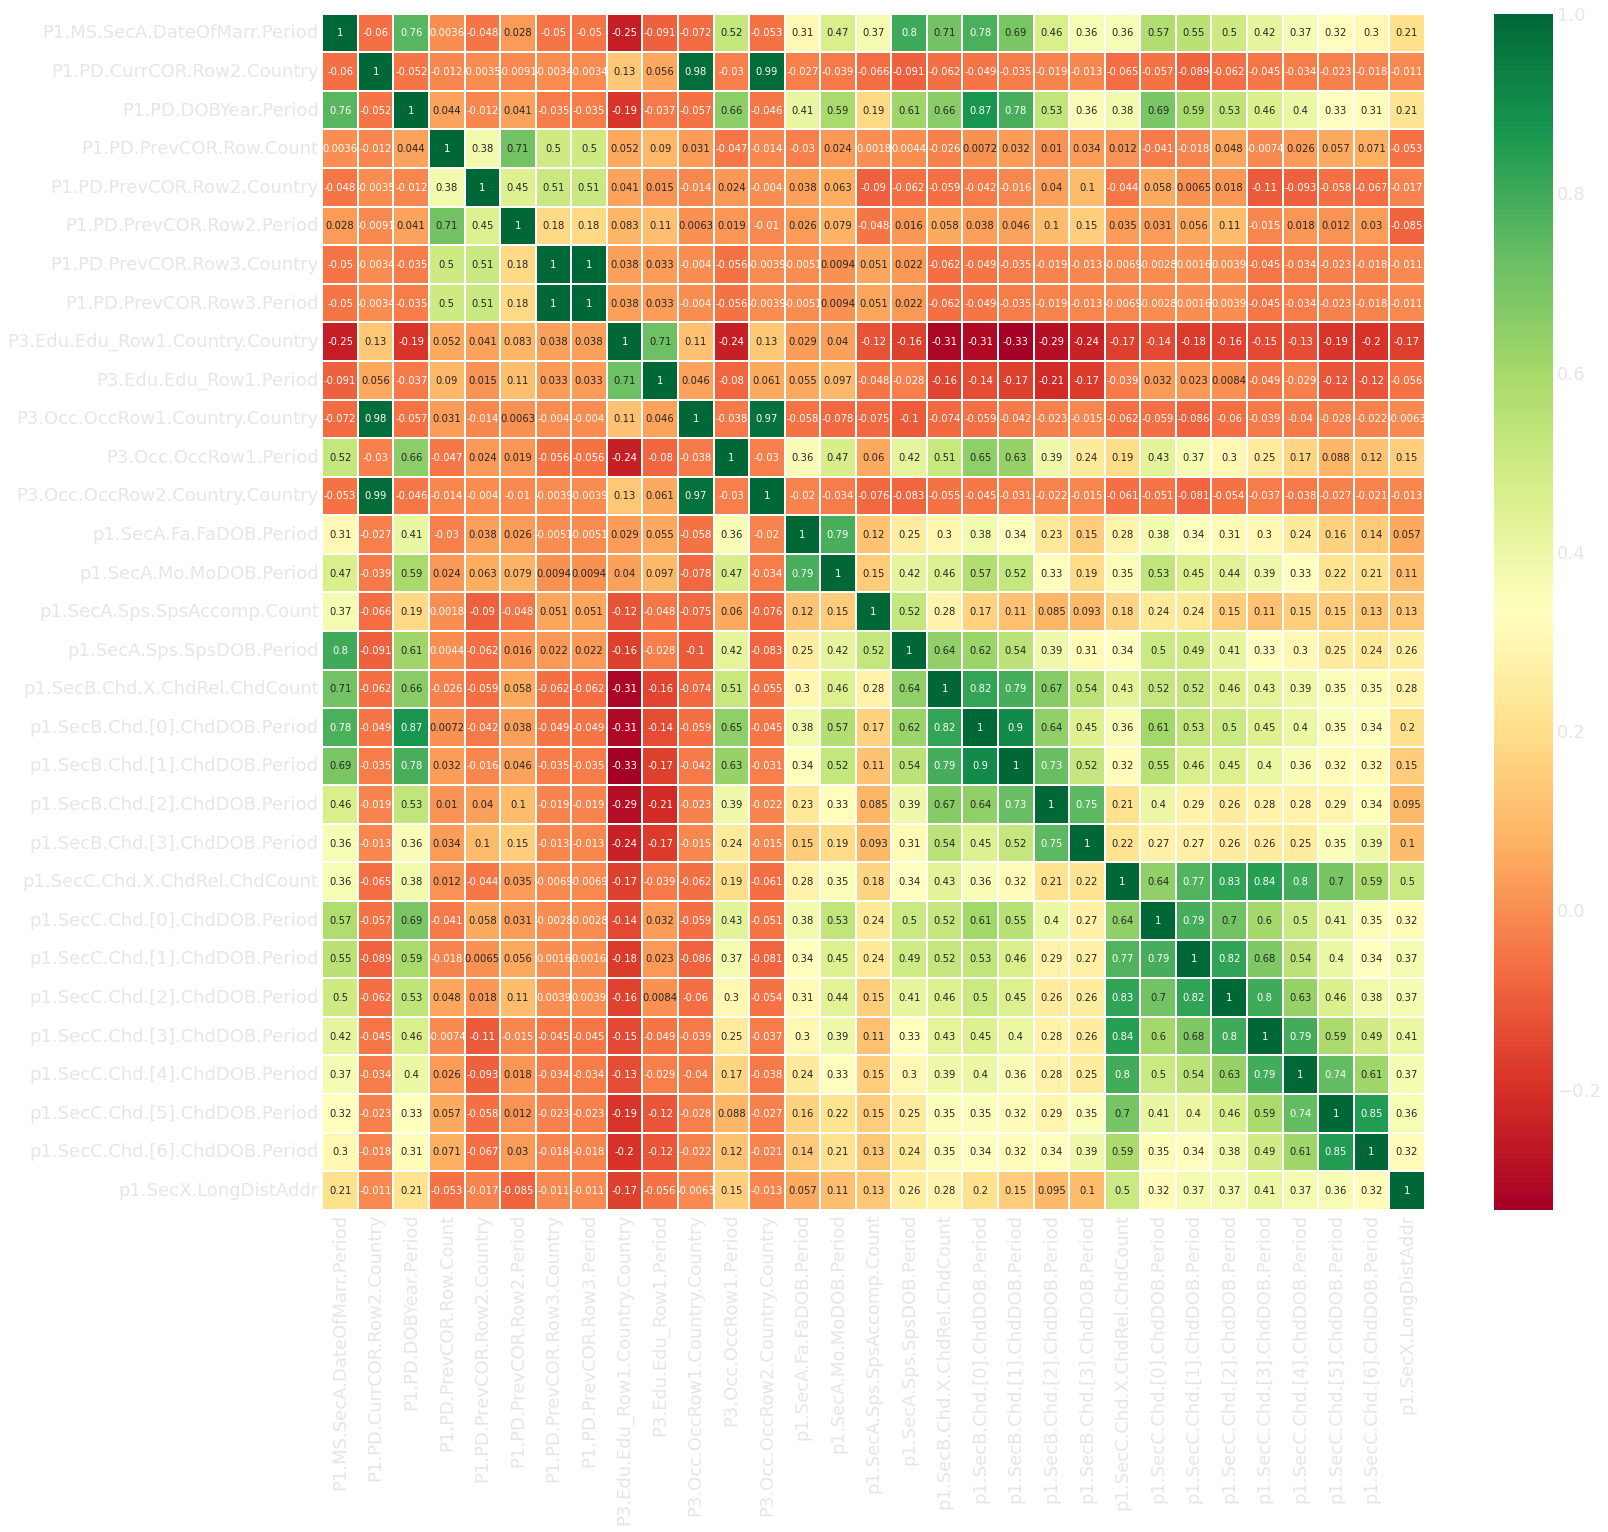

In [387]:
#nb>

# ref https://datascience.stackexchange.com/a/82237/135109
from itertools import combinations


def abs_high_pass(df, abs_thresh):
    passed = set()
    for (r, c) in combinations(df.columns, 2):
        if (abs(df.loc[r, c]) >= abs_thresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed, passed]

corr_data = data.corr()
sns.heatmap(abs_high_pass(corr_data, 0.5), annot=True, cmap='RdYlGn',
            linewidths=0.2, xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(22, 22)
plt.show()

Highly correlated data:
1. DateOfMarr 
   1. with all other "age" related periods, and the later the child/sibling, the lower the correlation (later children are younger)
   2. Chd.Count since the older the person the more chance of having more children
2. OccRow1.Country and OccRow2.Country since most of the people have the same Country
3. PrevCOR.Row3.Country and PrevCOR.Row3.Period have max correlation since its the exact same for all (all 0)
   1. practically we can drop both of them! (theoretically dropping one should be done)
4. P3.Edu.Edu_Row1.Period has *negative* correlation with marriage and children factors. I.e. the more education person has, the higher age of marriage and fewer children which are having them in older ages
5. P3.Edu.Edu_Row1.Country: same as (4) with this difference that the correlation is *twice negative* as (4). I.e. if person studies in a country better than default (here Iran), it's way less likely to get married.
6. p1.SecB.ChdX.ChdDOB.Period all have positive correlation with each other and factors in (1) since the more traditional, the younger the marriage age, the more kids, more siblings, lower education, higher marriage period, and so on.

### Dimensionality Reduction for Visualization
1. PCA 
2. t-SNE

In [388]:
#nb>
data_encoded = data.copy()
columns_to_encode = [c for c in data.columns.values if (data[c].dtype == 'category') and (c != 'VisaResult')]
data_encoded = pd.get_dummies(data_encoded, drop_first=True, columns=columns_to_encode)
data_encoded.shape

(298, 166)

In [389]:
#nb>
blah = [c for c in data_encoded.columns.values if data_encoded[c].isna().sum() > 0]
display(blah)
data_encoded[blah] = data_encoded[blah].fillna(0)

[]

In [390]:
#nb>
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

Y = data_encoded['VisaResult'].to_numpy()
y_label_encoder = LabelEncoder()
Y = y_label_encoder.fit_transform(Y)
data_encoded.drop(['VisaResult'], axis=1, inplace=True)
X = data_encoded.to_numpy()

#### PCA

In [391]:
#nb>
pca = PCA(n_components=2)
Xt = pca.fit_transform(X)

display(Xt.shape)
display(Y.shape)

(298, 2)

(298,)

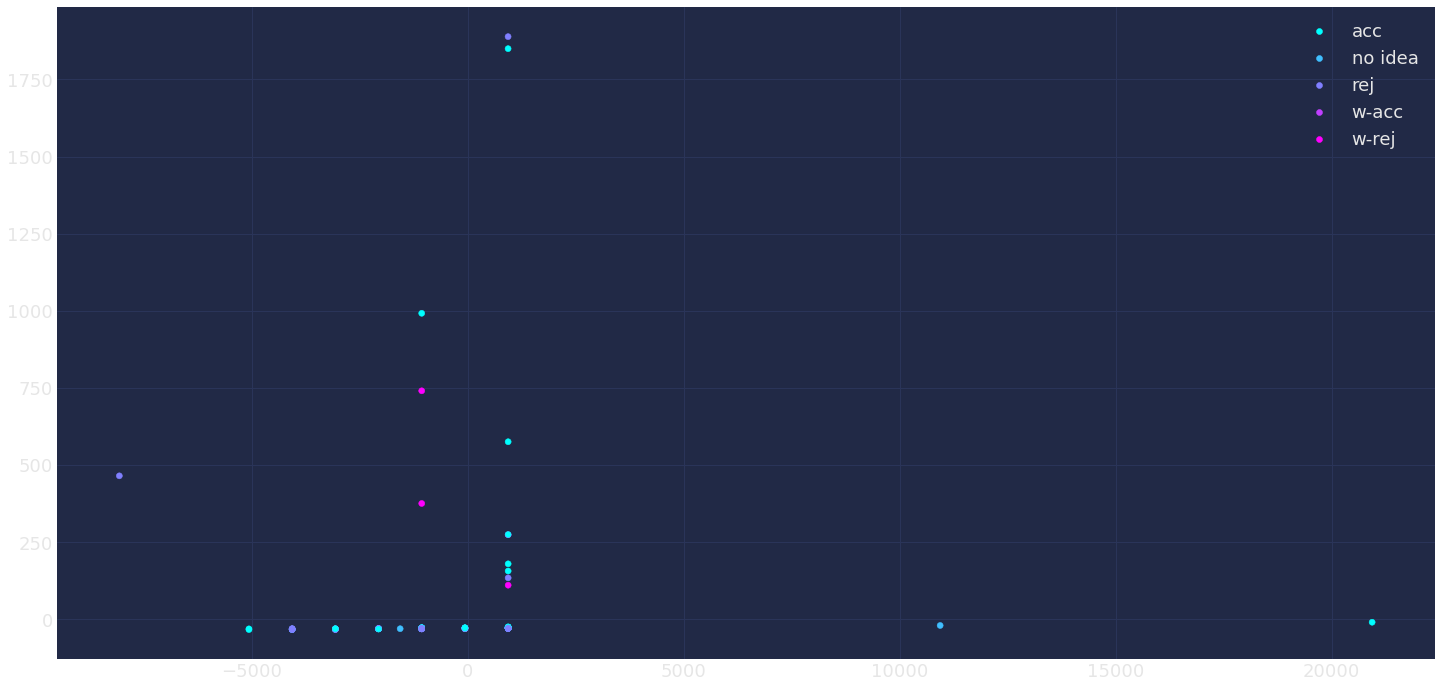

In [392]:
#nb>
plt.figure(figsize=(22, 12))
plot = plt.scatter(Xt[:, 0], Xt[:, 1], c=Y.flatten())
plt.legend(handles=plot.legend_elements()[0], labels=list(y_label_encoder.classes_))
plt.show()

In [393]:
#nb>
pca = PCA(n_components=3)
Xt = pca.fit_transform(X)

display(Xt.shape)
display(Y.shape)

(298, 3)

(298,)

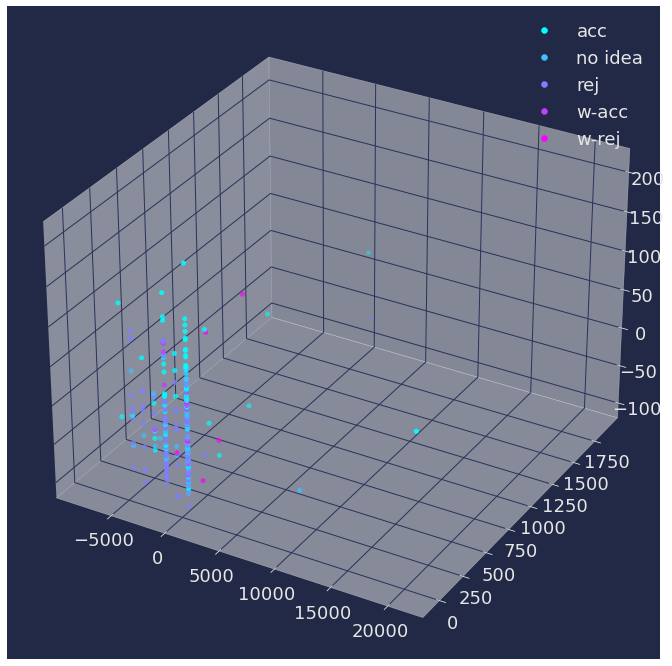

In [394]:
#nb>
fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:, 2], c=Y.flatten())
ax.legend(handles=plot.legend_elements()[0], labels=list(y_label_encoder.classes_))
plt.show()

#### t-SNE

In [395]:
#nb>
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', method='exact', init='pca', random_state=SEED, n_jobs=-1)
Xt = tsne.fit_transform(X)

display(Xt.shape)
display(Y.shape)

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(298, 2)

(298,)

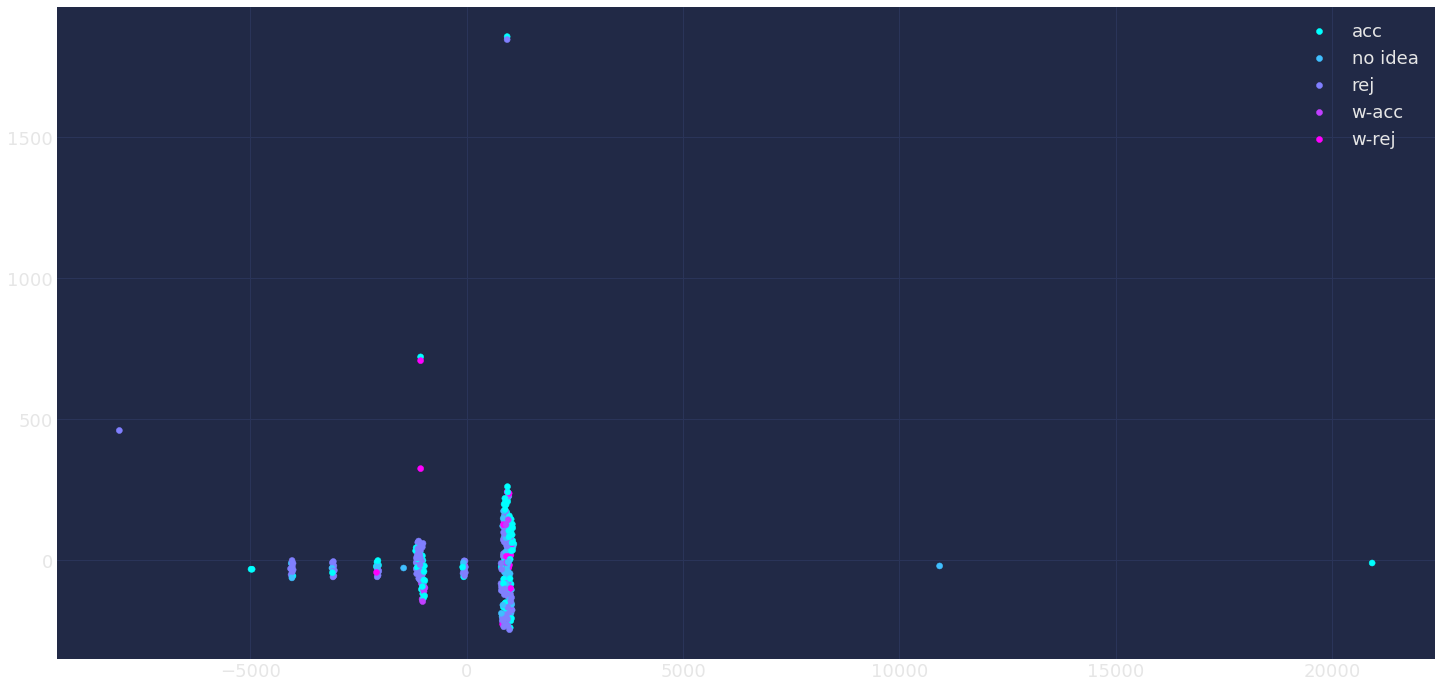

In [396]:
#nb>
plt.figure(figsize=(22, 12))
plot = plt.scatter(Xt[:, 0], Xt[:, 1], c=Y.flatten())
plt.legend(handles=plot.legend_elements()[0], labels=list(y_label_encoder.classes_))
plt.show()

In [397]:
#nb>
tsne = TSNE(n_components=3, perplexity=30, learning_rate='auto', method='exact', init='pca', random_state=SEED, n_jobs=-1)
Xt = tsne.fit_transform(X)

display(Xt.shape)
display(Y.shape)

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(298, 3)

(298,)

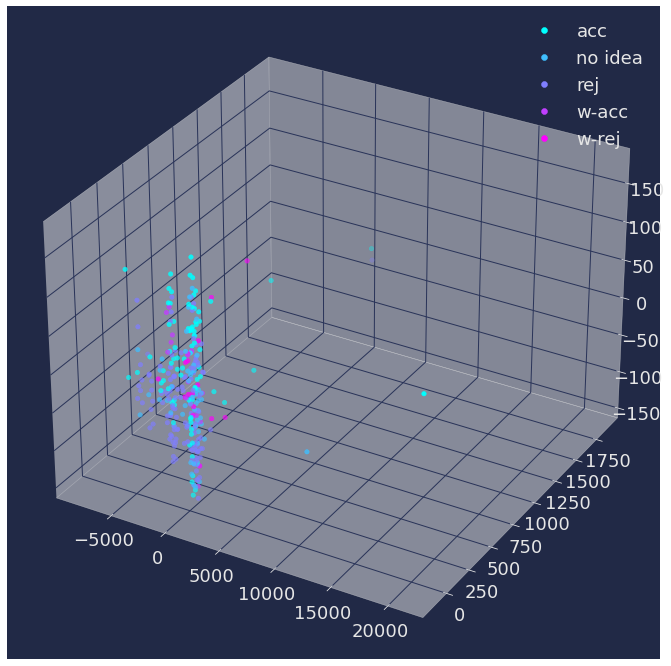

In [398]:
#nb>
fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:, 2], c=Y.flatten())
ax.legend(handles=plot.legend_elements()[0], labels=list(y_label_encoder.classes_))
plt.show()

## Save Data to Disc
**Save preprocessed data to disc, as a baseline. Why:**
1. All type casting, feature engineering, visualization, etc all needed to be added to the main package to ensure reproducibility as being part of the same end to end pipeline
2. During the transition happening at step (1), we check the correct implementation by comparing to this saved data
3. I am tired af of EDA and all software engineering and cheeky if else pleb approaches of data analysis, doing some new stuff like weak supervision for converting non/weak labeled data to absolute one would add some fun
4. It's not gonna cost anything, so why not!


**Tracking:**
1. This data need to be tracked by DVC too
2. Consider this data, `dev` version with a new unique tag (i.e. if last tag is `v1.0.2`, we use `v1.1.0-dev`) and use following format for commit message `EDA of [previous_production_tag_version]`, i.e. `EDA of v1.0.2`
3. After all implementation in this notebook have been merged into original codebase cleanly, we rerun data generation pipeline and create the production ready data which will be tracked and tagged with `v1.1.0` (same as step 2 but without `-dev`)

The reason for this is the step 3 of previous part and we want to track the snorkel procedure too.

In [399]:
# dataset_path = REPO + '/raw-dataset/all-dev.pkl'  # Don't change the name, 
# data.to_pickle(dataset_path)

## Load Data For Comparison

In [400]:
from pandas import testing as tm

DATASET_PATH_ORIGINAL = 'raw-dataset/all-dev.pkl'  # Don't change the name, 
REPO = '/home/nik/visaland-visa-form-utility'
VERSION = 'v1.2.5-dev'  # use latest `dev` version using `git tag`
data_url_original = dvc.api.get_url(path=DATASET_PATH_ORIGINAL, repo=REPO, rev=VERSION)
data_original = pd.read_pickle(data_url_original)

In [401]:
# tm.assert_frame_equal(data, data_original, check_exact=False, rtol=1e-4, atol=1e-5)
import pandas.testing as pdt
BLAH = False
for c in data_original.columns.values:
    try:
        pdt.assert_series_equal(left=data[c], right=data_original[c],
                                check_exact=False, rtol=1e-3, atol=1e-4)
    except AssertionError as e:
        print(f'column="{c}" {e}\n\n')
        BLAH = True
if BLAH:
    raise AssertionError('data not equal')

In [402]:
#nb>
data

P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
0                                                False           Female   
1                                                 True           Female   
2                                                False           Female   
3                                                False           Female   
4                                                False           Female   
..                                                 ...              ...   
300                                              False           Female   
301                                              False             Male   
302                                              False             Male   
303                                              False             Male   
304                                              False             Male   

     P1.PD.CurrCOR.Row2.Country P1.PD.CurrCOR.Row2.Status  \
0                      1.107154                         1   
1                      1.107154                         1   
2                      1.107154                         1   
3                      1.107154                         1   
4                      1.107154                         1   
..                          ...                       ...   
300                    1.107154                         1   
301                    1.107154                         1   
302                    1.107154                         1   
303                    1.107154                         1   
304                    1.107154                         1   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
0                      1.429856                    1.429856   
1                      1.429856                    1.429856   
2                      1.429856                    1.429856   
3                      1.429856                    1.429856   
4                      1.429856                    1.429856   
..                          ...                         ...   
300                    1.429856                    1.429856   
301                    1.429856                    1.429856   
302                    1.429856                    1.429856   
303                    1.429856                    1.429856   
304                    1.429856                    1.429856   

    P1.PD.SameAsCORIndicator P1.PD.CWA.Row2.Country P1.PD.CWA.Row2.Status  \
0                       True                 TURKEY                     6   
1                      False                 TURKEY                     3   
2                      False                 TURKEY                     6   
3                      False                  OTHER                     3   
4                      False                 TURKEY                     3   
..                       ...                    ...                   ...   
300                    False                 TURKEY                     3   
301                    False                 TURKEY                     6   
302                    False                 TURKEY                     3   
303                    False                 TURKEY                     6   
304                    False                 TURKEY                     6   

    P2.MS.SecA.PrevMarrIndicator P3.DOV.PrpsRow1.PrpsOfVisit.PrpsOfVisit  \
0                          False                            family visit   
1                          False                                 tourism   
2                          False                                 tourism   
3                          False                                 tourism   
4                          False                                 tourism   
..                           ...                                     ...   
300                         True                            family visit   
301                        False                                 tourism   
302 

In [403]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 304
Data columns (total 89 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator  298 non-null    category
 1   P1.PD.Sex.Sex                                          298 non-null    category
 2   P1.PD.CurrCOR.Row2.Country                             298 non-null    float32 
 3   P1.PD.CurrCOR.Row2.Status                              298 non-null    category
 4   P1.PD.PrevCOR.Row2.Country                             298 non-null    float32 
 5   P1.PD.PrevCOR.Row3.Country                             298 non-null    float32 
 6   P1.PD.SameAsCORIndicator                               298 non-null    category
 7   P1.PD.CWA.Row2.Country                                 298 non-null    category
 8   P1.PD.CWA.Row2.Status                   

In [404]:
#nb>
# copy notebook to `artifacts` dir to be logged by mlflow
notebook_name = 'notebooks/data_exploration_dev.ipynb'
shutil.copy2(notebook_name, REPO + '/artifacts/' + notebook_name)

'/home/nik/visaland-visa-form-utility/artifacts/notebooks/data_exploration_dev.ipynb'

In [405]:
#nb>
# NBVAL_IGNORE_OUTPUT
!jupyter nbconvert --to html $notebook_name
notebook_name_html = notebook_name.replace('ipynb', 'html')
shutil.copy2(notebook_name_html, REPO + '/artifacts/' + notebook_name_html)
import pathlib
pathlib.Path(notebook_name_html).unlink()

[NbConvertApp] Converting notebook notebooks/data_exploration_dev.ipynb to html
[NbConvertApp] Writing 7611693 bytes to notebooks/data_exploration_dev.html


## Save MLflow Tracking to Disc

In [406]:
#nb>
# log data params
mlflow.log_param('data_url', data_url)
mlflow.log_param('data_url_DEV', data_url_original)
mlflow.log_param('raw_dataset_dir', DST_DIR)
mlflow.log_param('EDA_passed_dataset_dir_x-dev', DATASET_PATH_ORIGINAL)
mlflow.log_param('data_version_after_EDA_vxxx-dev', VERSION)
mlflow.log_param('helper_dataset_info', all_helper_data_info)
mlflow.log_param('input_shape', data.shape)
mlflow.log_param('input_columns', data.columns.values)
mlflow.log_param('input_dtypes', data.dtypes.values)

# Log artifacts (logs, saved files, etc)
mlflow.log_artifacts(REPO + '/artifacts/')
# delete redundant logs, files that are logged as artifact
shutil.rmtree(REPO + '/artifacts')
# terminate mlflow tracker
client.set_terminated(mlflow.active_run().info.run_id, status='FINISHED')